In [1]:
import os
import pickle
import torch
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import ccdc

#from ccdc.conformer import ConformerGenerator
from egnn_models import EGNN
from torch_geometric.nn.models import SchNet
from torch_geometric.data import Batch, DataLoader
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from rdkit.Chem.PropertyMol import PropertyMol
from ConformationEnsemble import ConformationEnsembleLibrary, ConformationEnsemble
from ConfEnsembleDataset import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from rdkit.Chem.rdForceFieldHelpers import MMFFGetMoleculeProperties, MMFFGetMoleculeForceField
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from torch_geometric.data import DataLoader
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter

# Data preparation

In [14]:
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [15]:
pdbbind_dir = '/home/baillifb/v2019-other-PL/'

In [19]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(f'{pdbbind_dir}index/INDEX_general_PL_data.2019', widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [21]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [22]:
pl_data.shape

(15304, 7)

In [23]:
pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [24]:
mols = []
for pdb_id in pdb_ids :
    mol = None
    try :
        mol = Chem.rdmolfiles.MolFromMol2File(f'{pdbbind_dir}{pdb_id}/{pdb_id}_ligand.mol2', removeHs=False)
        if mol is not None :
            rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
            if rdmol is not None :
                #mol = PropertyMol(mol)
                mol.GetConformer().SetProp('PDB_ID', pdb_id)
                mols.append(mol)
    except :
        print('Impossible to read mol2 file for ' + pdb_id)

Impossible to read mol2 file for 1d2v
Impossible to read mol2 file for 1jou
Impossible to read mol2 file for 1s8j
Impossible to read mol2 file for 1cam
Impossible to read mol2 file for 5y79
Impossible to read mol2 file for 2adj
Impossible to read mol2 file for 6eu6
Impossible to read mol2 file for 3b5y
Impossible to read mol2 file for 4mdm
Impossible to read mol2 file for 4lz9
Impossible to read mol2 file for 3h1k
Impossible to read mol2 file for 5oqt
Impossible to read mol2 file for 1z9j
Impossible to read mol2 file for 3b5d
Impossible to read mol2 file for 3b62
Impossible to read mol2 file for 4mdl
Impossible to read mol2 file for 4mdg
Impossible to read mol2 file for 4q78
Impossible to read mol2 file for 1h9s
Impossible to read mol2 file for 1ztz
Impossible to read mol2 file for 1hpb
Impossible to read mol2 file for 1e59
Impossible to read mol2 file for 1lr8
Impossible to read mol2 file for 4cpa
Impossible to read mol2 file for 3i8w
Impossible to read mol2 file for 5e7v


In [25]:
len(mols)

13584

In [28]:
with open('pdbbind_mol_list.p', 'wb') as f :
    pickle.dump(mols, f)

In [29]:
with open('pdbbind_mol_list.p', 'rb') as f :
    mols = pickle.load(f)

In [30]:
conf_ensemble_library = ConformationEnsembleLibrary(mols)

100%|███████████████████████████████████| 13584/13584 [00:01<00:00, 8134.72it/s]


In [31]:
with open('data/raw/pdbbind_conf_ensemble_library.p', 'wb') as f :
    pickle.dump(conf_ensemble_library, f)

In [57]:
with open('data/raw/pdbbind_conf_ensemble_library.p', 'rb') as f :
    conf_ensemble_library = pickle.load(f)

In [2]:
%%time
dataset = ConfEnsembleDataset('data/')

INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
INFO: /home/baillifb/CCDC/CSD_2021/bin/mogul
CPU times: user 1.51 s, sys: 1.3 s, total: 2.81 s
Wall time: 3.54 s


In [3]:
val_limit = int(len(dataset) * 0.6)
test_limit = int(len(dataset) * 0.8)

train_dataset = dataset[:val_limit]
val_dataset = dataset[val_limit:test_limit]
test_dataset = dataset[test_limit:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training SchNet

In [4]:
writer = SummaryWriter()

tfd_loss = False

schnet = SchNet()
if tfd_loss :
    schnet.lin2 = torch.nn.Linear(schnet.hidden_channels // 2, 2) # predict rmsd and tfd
schnet = schnet.to('cuda')
optimizer = optim.Adam(schnet.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
leaky_relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()

def training_step(schnet, batch, tfd_loss=False) :
    batch = batch.to('cuda')
    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

    if tfd_loss :
        rmsd_pred = leaky_relu(preds[:, 0]) # to scale between 0 and +inf
        rmsd_loss = mseloss(rmsd_pred, batch.rmsd)
        tfd_pred = torch.sigmoid(preds[:, 1]) # to scale betwenn 0 and 1
        tfd_loss = mseloss(tfd_pred, batch.tfd)
        loss = rmsd_loss + tfd_loss * 5
        
    else :
        tfd_pred = preds # torch.sigmoid(preds) # to scale betwenn 0 and 1
        tfd_loss = mseloss(tfd_pred.squeeze(), batch.tfd)
        loss = tfd_loss
        
    return loss

In [5]:
for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    # Training
    schnet.train()
    
    train_loss = 0
    for batch in train_loader :
        optimizer.zero_grad()
        loss = training_step(schnet, batch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train', train_loss, epoch)
        
    # Validation
    schnet.eval()
        
    val_loss = 0
    for batch in val_loader :
        loss = training_step(schnet, batch)
        val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    scheduler.step(val_loss)

torch.save(schnet, 'schnet_tfd_100epochs_limited_pdbbind')
    
print('Finished Training')

100%|███████████████████████████████████████| 100/100 [2:45:20<00:00, 99.20s/it]

Finished Training


In [13]:
torch.save(schnet, 'schnet_tfd_20epochs_limited_pdbbind')

In [12]:
schnet = torch.load('schnet_tfd_20epochs_limited_pdbbind')

FileNotFoundError: [Errno 2] No such file or directory: 'schnet_tfd_20epochs_limited_pdbbind'

# Evaluation on test set

In [6]:
def group_data_by_smiles(data_list) :
    d = defaultdict(list)
    for data in data_list :
        d[data.smiles].append(data)
    return d

[H]N1C(=[N+]([H])[H])N([H])[C@@]2([H])C([H])([H])S[C@@]([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])[C@@]12[H]
tensor(0.0084)


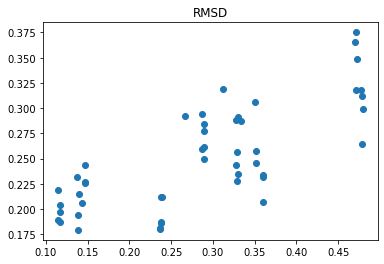

[H]Oc1c([H])c([H])c(C2=C(c3c([H])c([H])c(O[H])c([H])c3[H])[C@]3([H])O[C@@]2([H])[C@]([H])(C(=O)OC([H])([H])C([H])([H])[H])[C@]3([H])C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0022)


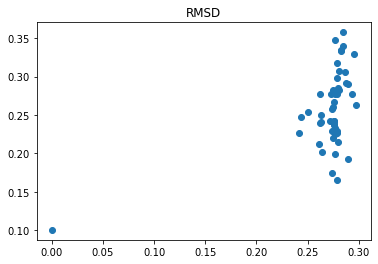

[H]c1nc([H])c([H])c(C([H])([H])N([H])c2c([H])c(-c3c([H])c([H])c([H])c([H])c3F)nc3c([H])c([H])nn23)c1[H]
tensor(0.0036)


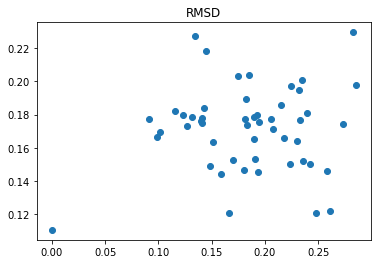

[H]c1c([H])c([H])c(C([H])([H])N([C@@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]2([H])N(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])c([H])c1[H]
tensor(0.0255)


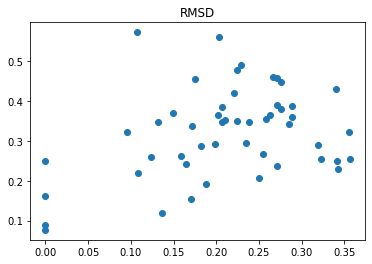

[H]OC([H])([H])[C@@]1([H])N([H])/C(=N\C([H])([H])C([H])([H])[N+]([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0214)


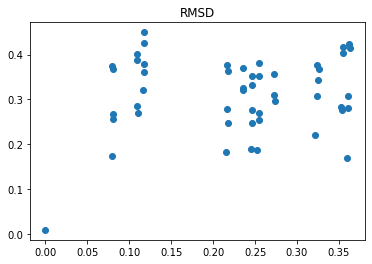

[H]c1c([H])c([H])c(C([H])([H])[N@@+]2([H])[C@@]3([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]([H])(OC2([H])c4c([H])c([H])c([H])c([H])c4C([H])([H])C([H])([H])c4c([H])c([H])c([H])c([H])c42)C3([H])[H])c([H])c1[H]
tensor(0.0026)


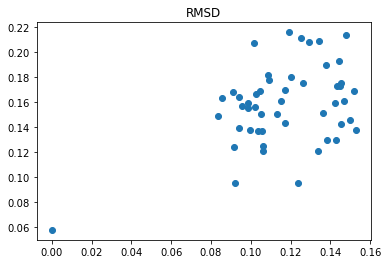

[H]c1nc([H])c(C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c([H])c1[H]
tensor(0.0177)


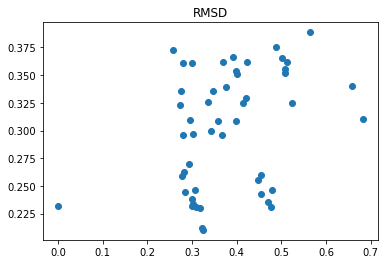

[H]C(=O)[C@@]1([H])N(C(=O)N([H])[C@@]2([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])C([H])([H])C([H])([H])[C@@]1([H])N([H])S(=O)(=O)[O-]
tensor(0.0052)


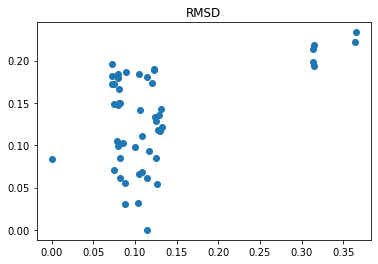

[H]c1nc2c(c([H])nn2[H])c(N2C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[N+]([H])([H])[H])C2([H])[H])c1C(=O)OC([H])([H])C([H])([H])[H]
tensor(0.0184)


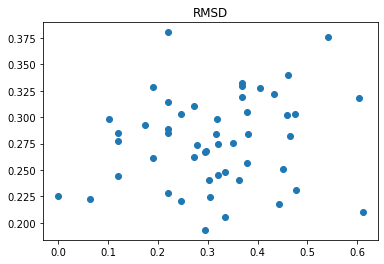

[H]c1oc(C(=O)N([H])[C@]([H])(C(=O)N2C([H])([H])c3c(c4c([H])c([H])c([H])c([H])c4n3[H])C([H])([H])[C@@]2([H])C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(0.0104)


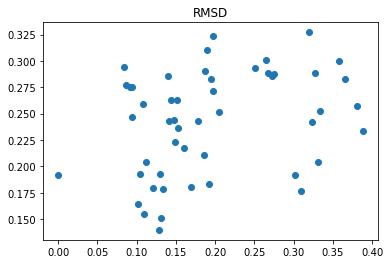

[H]c1c(N=C=S)c([H])c2c([H])c(C3=NC([H])([H])C([H])([H])N3[H])oc2c1[H]
tensor(0.0210)


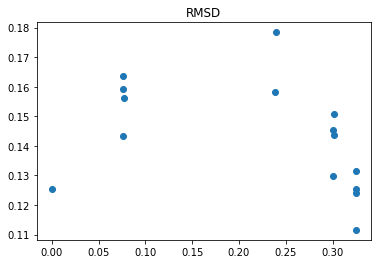

[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)C([H])([H])C(=O)C(F)(F)F
tensor(0.0140)


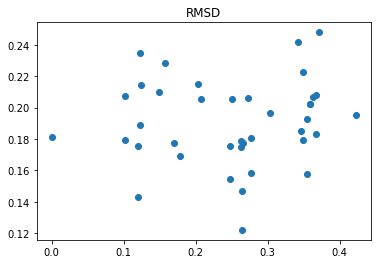

[H]Oc1c([H])c([H])c(Cl)c([H])c1Oc1c([H])c([H])c(Cl)c2c([H])c([H])c([H])nc12
tensor(0.0292)


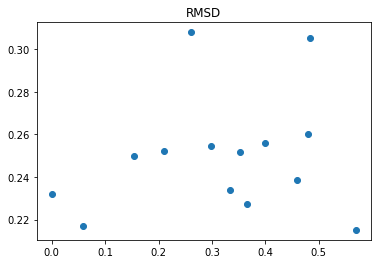

[H]OC([H])([H])[C@@]([H])(c1c([H])c([H])c([H])c([H])c1[H])[N+]([H])([H])C([H])([H])[C@@]1([H])N(C([H])([H])[H])C(=O)[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0085)


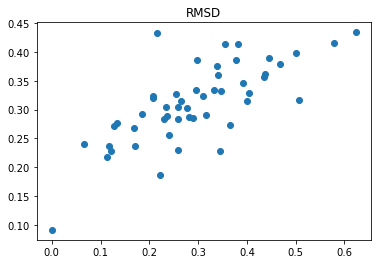

[H]Oc1c([H])c([H])c(Cl)c([H])c1N1C(=O)C([H])([H])S[C@@]1([H])c1c([H])c([H])c([H])c(Br)c1[H]
tensor(0.0231)


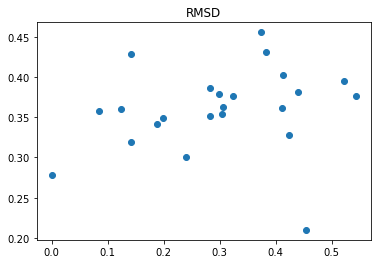

[H]O[C@]1(C(=O)OC([H])([H])[H])C([H])([H])[C@@]2([H])O[C@]1(C([H])([H])[H])n1c3c([H])c([H])c([H])c([H])c3c3c4c(c5c6c([H])c([H])c([H])c([H])c6n2c5c31)C(=O)N([H])C4([H])[H]
tensor(0.0280)


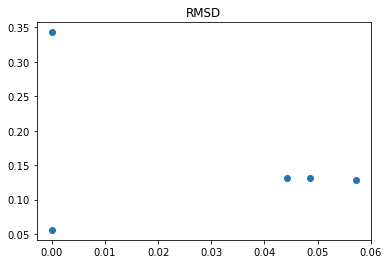

[H]c1c([H])c([H])c2c(c1[H])N([H])C(=O)[C@@]21C([H])([H])[C@]([H])(C(=O)O[C@]2([H])c3c([H])c(Br)c([H])c([H])c3S(=O)(=O)C([H])([H])C2([H])[H])[N+]([H])([H])C1([H])[H]
tensor(0.0099)


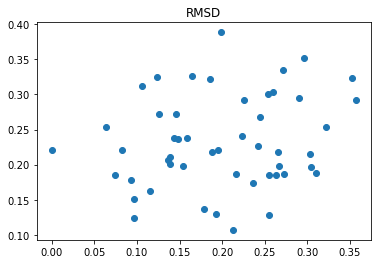

[H]c1nc(N2C([H])([H])C([H])([H])C3(C([H])([H])C2([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]3([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.0282)


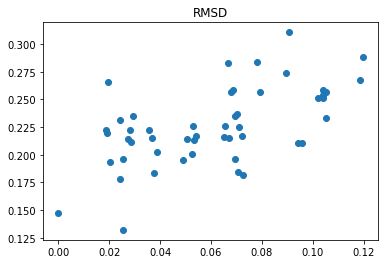

[H]c1nc2c(c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n2[H])c(-c2c([H])c([H])c(S(=O)(=O)N([H])C3([H])C([H])([H])C([H])([H])S(=O)(=O)C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
tensor(0.0064)


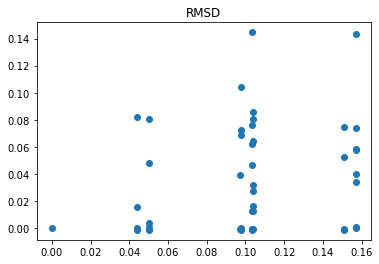

[H]c1nn([H])c([H])c1-c1c([H])c([H])c(C(=O)N([H])c2c([H])c([H])c([H])c([H])c2[H])c(OC([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c1[H]
tensor(0.0041)


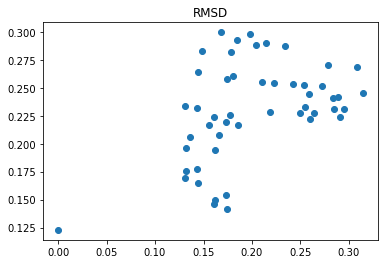

[H]c1c([H])c(S(=O)(=O)N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c(-c2nc3c(c(=O)n2[H])C([H])([H])C([H])([H])C3([H])[H])c1OC([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.0083)


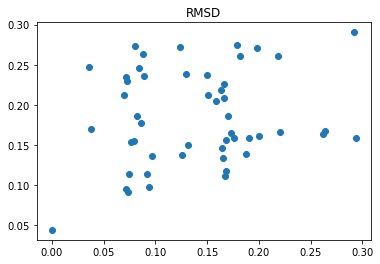

[H]c1c(Cl)c(N([H])C(=O)C([H])([H])[H])c(Cl)c([H])c1C([H])([H])N([H])C(N([H])C(=O)C([H])([H])n1c([H])c([H])c2c([H])c([H])c([H])c([H])c21)=[N+]([H])[H]
tensor(0.0050)


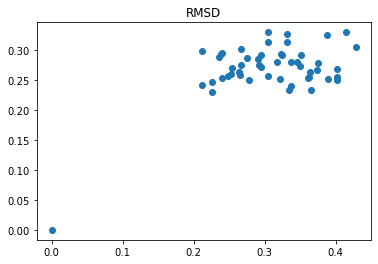

[H]/C1=C(/C([H])([H])[H])C(=O)N([H])c2c([H])c(OC([H])([H])[H])c([H])c(c2[H])C([H])([H])OC([H])([H])[C@]([H])(OC([H])([H])[H])[C@]([H])(OC([H])([H])[H])[C@@]([H])(C([H])([H])[H])/C([H])=C(\C([H])([H])[H])[C@]([H])(OC(=O)N([H])[H])[C@@]([H])(OC(=O)N([H])[H])C([H])([H])C1([H])[H]
tensor(0.0346)


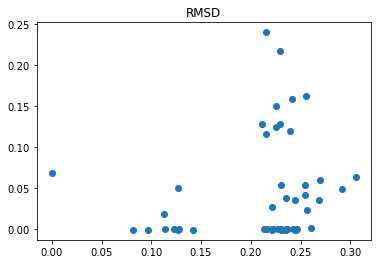

[H]c1c([H])c([H])c(C([H])([H])[C@]2([H])O[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])N(C([H])([H])[H])C2=O)c([H])c1[H]
tensor(0.1135)


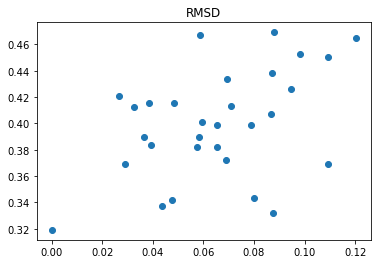

[H]c1c(Br)c2c(c([H])c1C([H])([H])[H])C(=O)C(=O)N2[H]
tensor(0.0031)


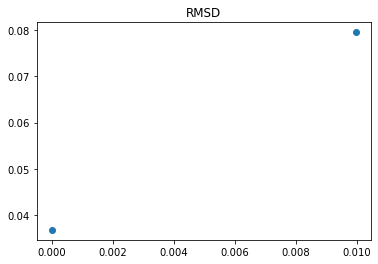

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)C([H])([H])C([H])([H])c1nc2c([H])c([H])c([H])c([H])c2c(=O)n1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0091)


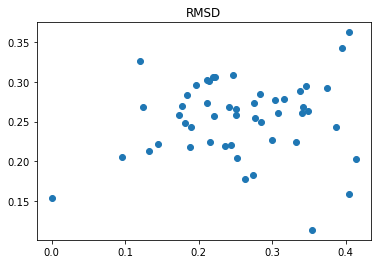

[H]c1c([H])c(C([H])([H])[H])c(N([H])[H])c([H])c1C(=O)N([H])c1c([H])c([H])c(S(=O)(=O)[O-])c2c([H])c([H])c([H])c(S(=O)(=O)[O-])c12
tensor(0.0121)


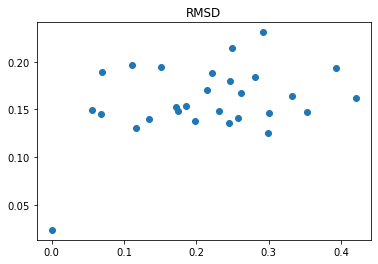

[H]c1c([H])c([H])c2c(=O)c([H])c(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])oc2c1-c1c([H])c([H])c([H])c2c1sc1c([H])c([H])c([H])c([H])c12
tensor(0.0038)


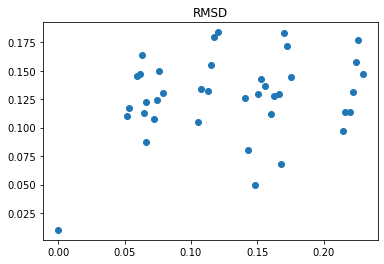

[H]c1c(C(=O)N([H])c2c([H])c([H])c(-c3nnnn3[H])c([H])c2C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])nc(C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0017)


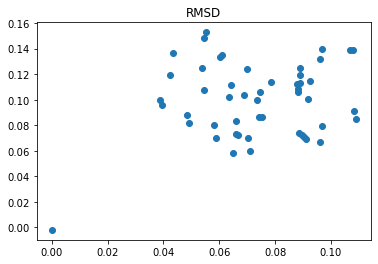

[H]c1nc(N([H])c2c([H])c([H])c(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c2[H])c2nc(N([H])C([H])([H])c3c([H])nc([H])c([H])c3[H])c([H])c([H])c2n1
tensor(0.0066)


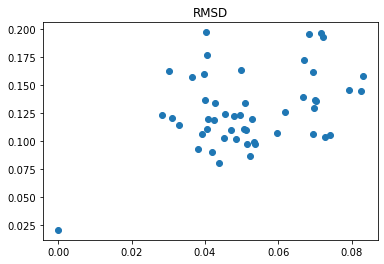

[H]c1nc([H])c(-c2c([H])c([H])c3c(c2[H])[C@]2(N([H])C(=[N+]([H])[H])OC2([H])[H])[C@@]2([H])C([H])([H])C([H])([H])OC([H])([H])[C@]2([H])O3)c([H])c1Cl
tensor(0.0198)


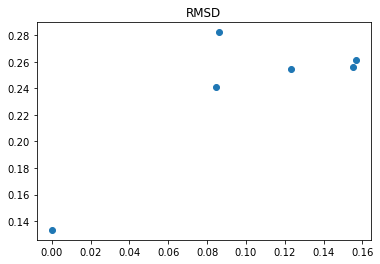

[H]OB1O[C@]([H])(C([H])([H])C(=O)[O-])c2c1c([H])c(Oc1nc([H])c([H])nc1[H])c(C([H])([H])[H])c2C([H])([H])[H]
tensor(0.0130)


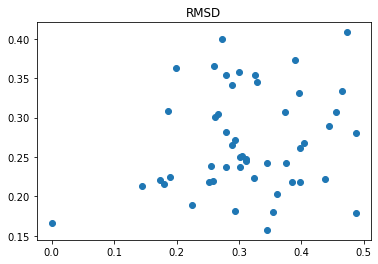

[H]c1nc2c(c([H])c1[H])c([H])c(-c1nc3c([H])c(C(=O)N4C([H])([H])C([H])([H])C([H])([H])[C@@]([H])([N+]([H])([H])[H])C4([H])[H])c([H])c(OC([H])([H])[H])c3n1C([H])([H])[H])n2C([H])([H])C([H])([H])[H]
tensor(0.0195)


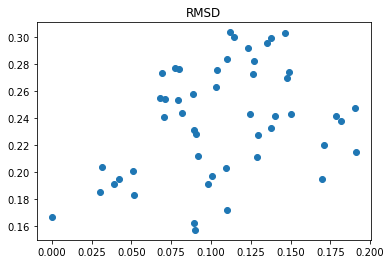

[H]c1c([H])c(C([H])([H])C([H])([H])c2c([H])n([H])c3c2c(=O)n([H])c(=[N+]([H])[H])n3[H])c([H])c([H])c1C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0035)


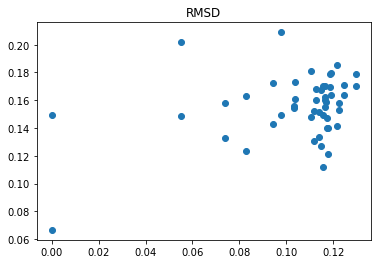

[H]O[C@]1([H])[C@@]([H])(C([H])([H])N=[N+2]#N)O[C@@]([H])(n2c(SC([H])([H])C(=O)N([H])C([H])([H])C([H])([H])c3c([H])c([H])c([H])c(Br)c3[H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0071)


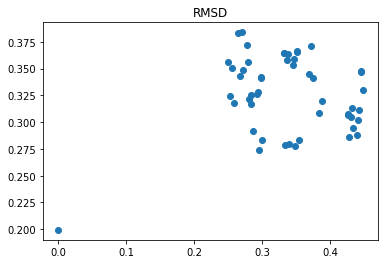

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.0090)


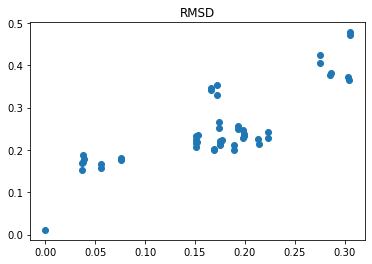

[H]c1c([H])c(N2C([H])([H])C([H])([H])C([H])(C([H])([H])C([H])([H])C(=O)N3C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C2([H])[H])c([H])c([H])c1C#N
tensor(0.0284)


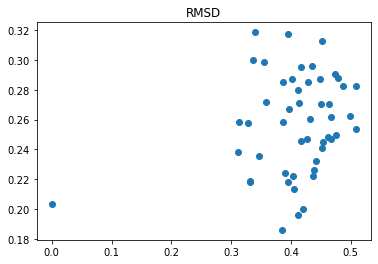

[H]c1c([H])c([H])c2c(C([H])([H])c3c(C4([H])C([H])([H])C4([H])[H])c4n(c(=O)c3[H])[C@]([H])(C(=O)[O-])C([H])([H])S4)c([H])c([H])c([H])c2c1[H]
tensor(0.0128)


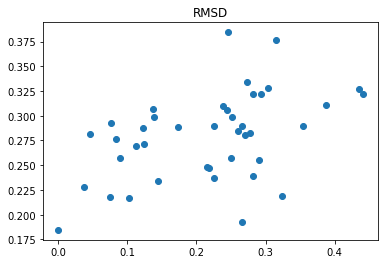

[H]OB(O[H])c1c([H])c([H])c([H])c([H])c1OC([H])([H])c1c([H])c([H])c([H])c(Cl)c1[H]
tensor(0.0215)


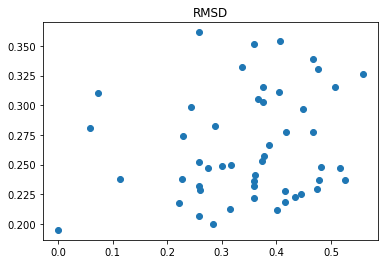

[H]Oc1c([H])c(O[H])c(S(=O)(=O)N(C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1-c1nn([H])c(=O)n1-c1c([H])c([H])c([H])c([H])c1F
tensor(0.0264)


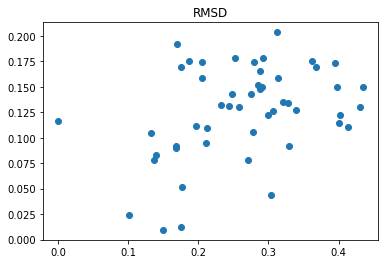

[H]c1c([H])c(C([H])([H])c2nn([H])c(-c3sc(C([H])([H])[H])nc3C([H])([H])[H])c2[H])c([H])c([H])c1OC([H])([H])[H]
tensor(0.0048)


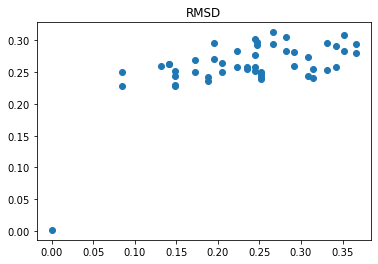

[H]OB(O[H])c1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])c([H])c1[H]
tensor(0.0141)


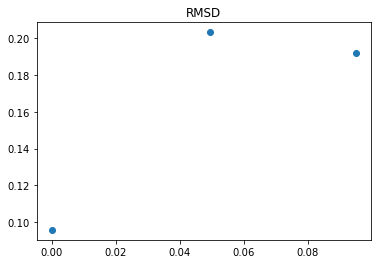

[H]c1nc(N([H])c2c([H])c([H])c(N3C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c2[H])nc2c1C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])c1c(C(=O)N([H])C([H])([H])[H])nn(C([H])([H])[H])c1-2
tensor(0.0072)


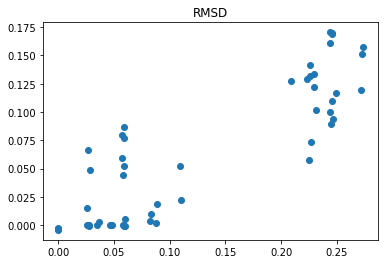

[H]c1c([H])c(N([H])C(=O)N(C([H])([H])c2c([H])c([H])c3c(c2[H])OC([H])([H])O3)[C@]2([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c(C(F)(F)F)c1[H]
tensor(0.0185)


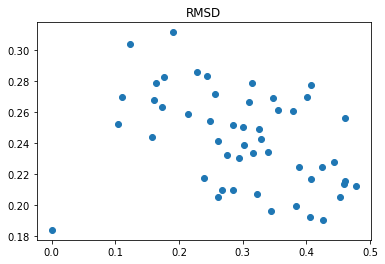

[H]C1=C([H])C1([H])S(=O)(=O)N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]1([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]([H])(Oc2c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])nc3c([H])c(OC([H])([H])[H])c([H])c([H])c23)C1([H])[H])C([H])([H])C([H])(F)F
tensor(0.0138)


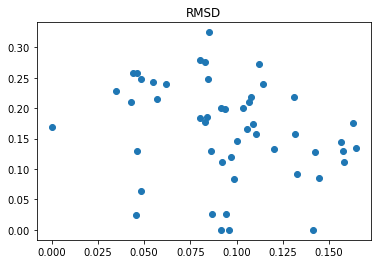

[H]c1c([H])c(Cl)c(C(=O)C([H])([H])C(=O)C(=O)[O-])c(Cl)c1[H]
tensor(0.0300)


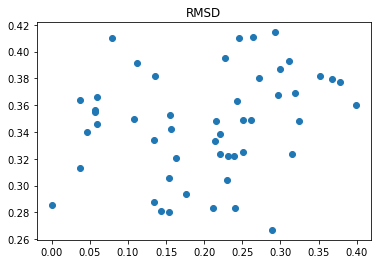

[H]c1nc([H])c([H])c(-c2c([H])c([H])c(C(=O)N([H])[C@@]([H])(c3c([H])c([H])c([H])c(OC([H])([H])[H])c3[H])C([H])([H])[H])c(N([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c2[H])c1[H]
tensor(0.0032)


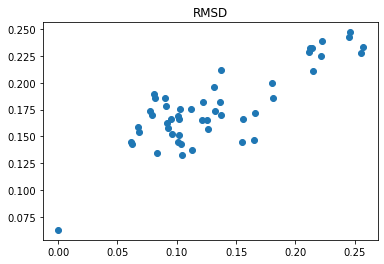

[H]c1nc(Cl)c(N([H])S(=O)(=O)c2c([H])c([H])c([H])c([H])c2[H])c([H])c1-c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0076)


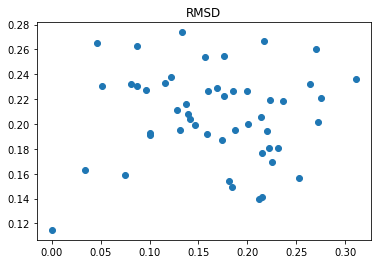

[H]OC([H])([H])[C@@]12C3=C([H])C([H])([H])[C@@]4([H])[C@@](C(=O)O[C@@]5([H])O[C@@]([H])(C([H])([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]5([H])O[H])(C([H])([H])[H])[C@]([H])(OC(=O)C([H])([H])[H])C([H])([H])C([H])([H])[C@]4(C([H])([H])[H])[C@@]3([H])C([H])([H])[C@]([H])(O[H])[C@@]1(C([H])([H])[H])[C@]([H])([C@]([H])(C([H])=O)C([H])([H])C(=O)C([H])=C(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(O[H])C2([H])[H]
tensor(0.0061)


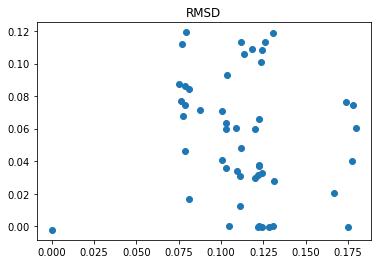

[H]c1c([H])c([H])c(C(=O)C2([H])C([H])([H])C([H])([H])N(C(=O)[C@@]([H])(c3c([H])c([H])c([H])c([H])c3[H])N([H])C(=O)c3c([H])c([H])c([H])c(C(N([H])[H])=[N+]([H])[H])c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0035)


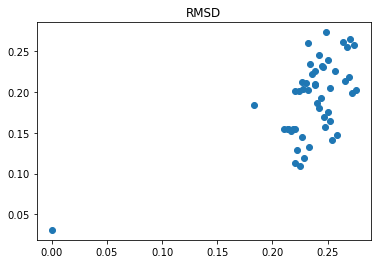

[H]Oc1c([H])c([H])c(C(=O)C([H])([H])[H])c([H])c1[H]
tensor(0.0170)


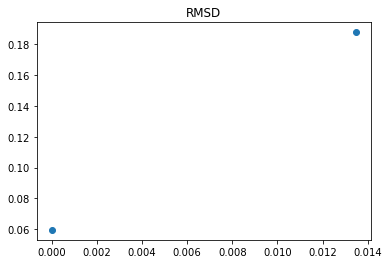

[H]c1c([H])c([H])c2c(c1[H])c1c(c(C([H])([H])[H])nn1[H])c(=O)n2C([H])([H])C([H])([H])[H]
tensor(0.0185)


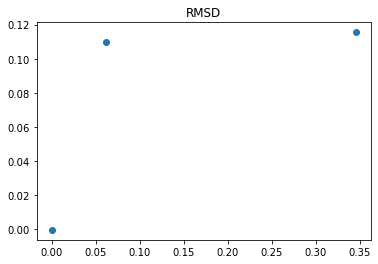

[H]OC([H])([H])[C@@]1([H])C([H])([H])[N+]([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0575)


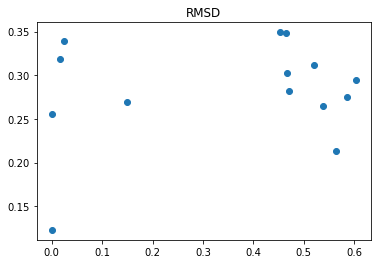

[H]ON([H])C(=O)c1sc(C(=O)N2C([H])([H])c3nc([H])c(-c4c([H])c([H])c([H])c([H])c4[H])n3C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0039)


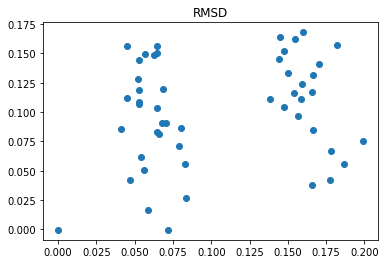

[H]O[C@]1([H])C(=O)[C@@]([H])(C([H])([H])c2c(F)c(F)c(F)c(F)c2F)[C@@](O[H])(C(=O)[O-])C([H])([H])[C@@]1([H])O[H]
tensor(0.0871)


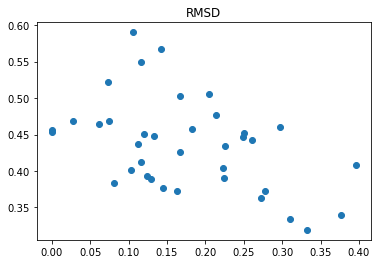

[H]c1c([H])c([H])c(C([H])([H])[C@]2([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])C([H])([H])[N+]([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0209)


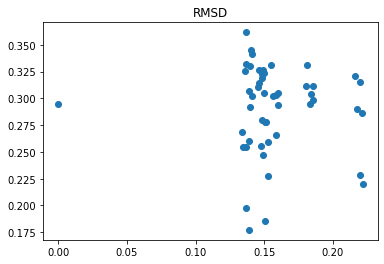

[H]c1c([H])c(OC([H])([H])C([H])([H])N2C(=O)C([H])([H])[C@@]([H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C2([H])[H])c([H])c(C#N)c1F
tensor(0.0155)


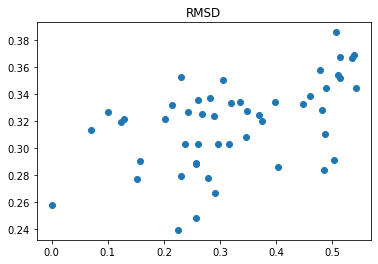

[H]c1c([H])c(C(=O)C([H])([H])[H])c([H])c(N([H])c2c([H])c([H])c3c([H])c([H])n(S(=O)(=O)C([H])([H])[H])c3c2[H])c1OC([H])([H])C([H])([H])[H]
tensor(0.0303)


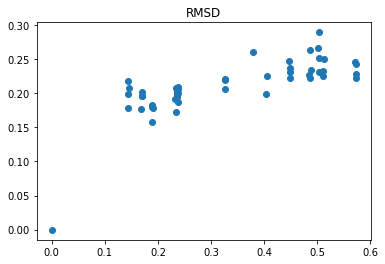

[H]c1nc2nc(C([H])([H])[H])c([H])c([C@]3([H])C([H])([H])N(C(=O)c4c([H])c([H])c(F)c(F)c4[H])C([H])([H])C(F)(F)C3([H])[H])n2n1
tensor(0.0628)


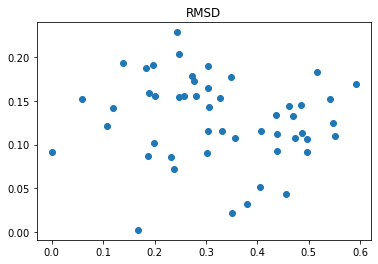

[H]Oc1c([H])c(C([H])([H])C#N)c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1C(=O)n1c([H])c2c([H])c([H])c([H])c([H])c2c1[H]
tensor(0.0234)


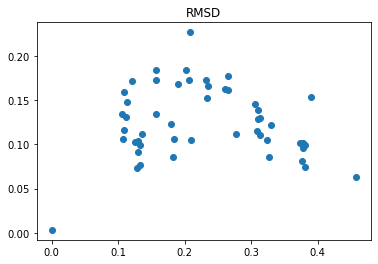

[H]c1c([H])c([H])c(Oc2c([H])c([H])c([H])c([H])c2-c2nn(C([H])([H])[H])c(=O)c([H])c2OC([H])([H])[H])c([H])c1[H]
tensor(0.0157)


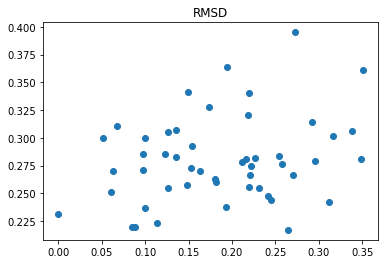

[H]c1c([H])c([C@@]([H])(C([H])([H])[H])[N+]([H])([H])OC(=O)N([H])[H])c([H])c(OC2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c1OC([H])([H])[H]
tensor(0.0235)


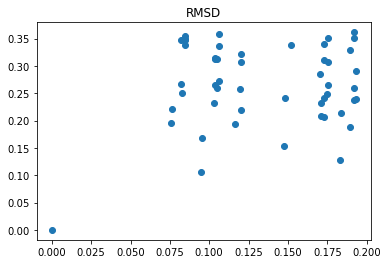

[H]ON([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)N([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0217)


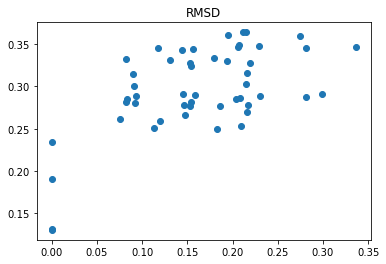

[H]O[C@]1([H])N2/C(=N\C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])SC([H])([H])[C@]2([H])[C@@]([H])(O[H])[C@]([H])(O[H])[C@@]1([H])O[H]
tensor(0.0132)


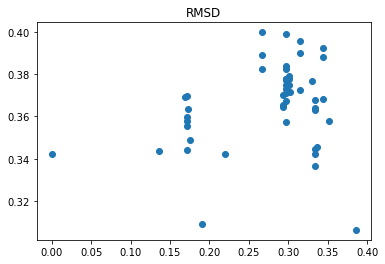

[H]O[C@]1([H])[C@@]([H])(C([H])([H])OS(=O)(=O)N([H])C(=O)[C@@]([H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[N+]([H])([H])[H])O[C@@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0139)


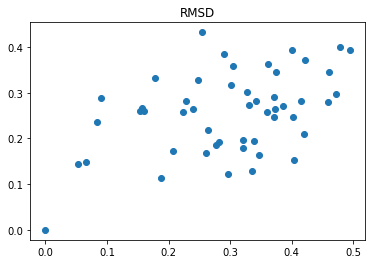

[H]c1c([H])c(C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H])c([H])c([H])c1F
tensor(0.0185)


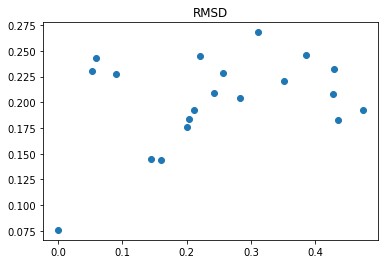

[H]c1c([H])c([H])c(C([H])([H])C([H])([H])c2c([H])n([H])c3c2c(=O)n([H])c(=[N+]([H])[H])n3[H])c([H])c1[H]
tensor(0.0215)


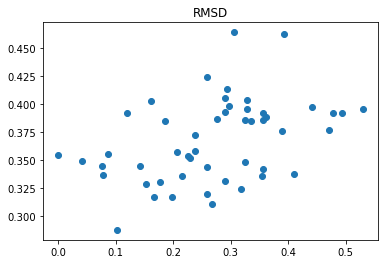

[H]Oc1c([H])c([H])c(C([H])([H])[C@]2([H])C([H])([H])S(=O)(=O)C([H])([H])[C@]([H])([N+]([H])([H])C([H])([H])c3c([H])c([H])c([H])c(C4([H])C([H])([H])C4([H])[H])c3[H])[C@@]2([H])O[H])c([H])c1Br
tensor(0.0188)


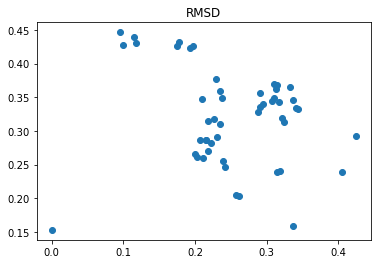

[H]c1c([H])c2c3c(c1[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])OC(=O)N([H])[C@@]([H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C(=O)N1C([H])([H])[C@]([H])(OC(=O)N(C2([H])[H])C3([H])[H])C([H])([H])[C@@]1([H])C(=O)N([H])[C@]1(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])C([H])([H])[C@@]1([H])C([H])([H])C([H])([H])[H]
tensor(8.7413e-05)


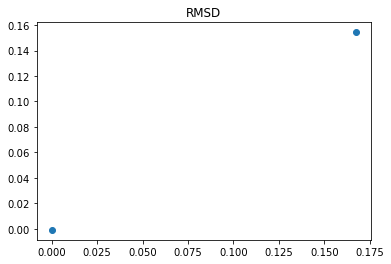

[H]O[C@]([H])(C([H])([H])OC([H])=O)[C@@]([H])(OC([H])([H])[H])[C@]1([H])O[C@]([H])(C(=O)[O-])C([H])([H])[C@]([H])(N([H])C(N([H])[H])=[N+]([H])[H])[C@@]1([H])N([H])C(=O)C([H])([H])[H]
tensor(0.0217)


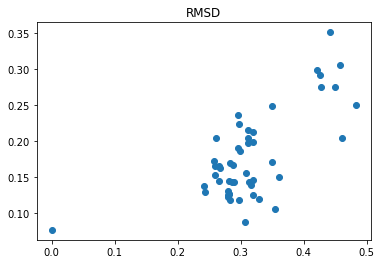

[H]c1nc(Oc2c([H])c([H])c3c(c2[H])c([H])c([H])n3C(=O)N([H])c2c([H])c([H])c(C([H])([H])[N@+]3([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c(C(F)(F)F)c2[H])c([H])c(N([H])C(=O)C([H])([H])[H])n1
tensor(0.0044)


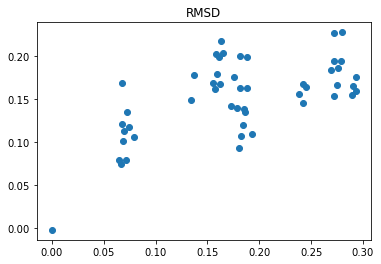

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@@]2([H])[C@]([H])(O[H])[C@@]([H])(O[H])[N+]([H])([H])C([H])([H])[C@]2([H])C([H])([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0071)


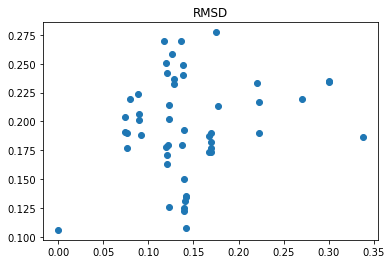

[H]c1c([H])c(C([H])([H])[N@+]2([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])C(=O)N([H])[C@@]3([H])C([H])([H])[C@@]([H])(OC([H])([H])[H])C([H])([H])C([H])([H])[C@]3([H])OC([H])([H])[H])C([H])([H])C2([H])[H])c([H])c2c1OC([H])([H])O2
tensor(0.0122)


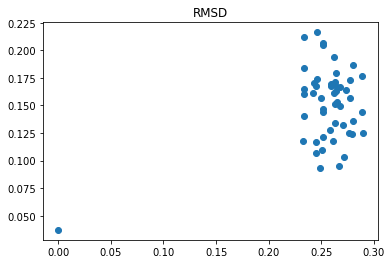

[H]O[C@@](c1c([H])c([H])c([H])c([H])c1[H])(C1([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])[C@]1([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])C([H])([H])C([H])([H])Oc2c([H])c([H])c(C#N)c([H])c2[H])C([H])([H])C1([H])[H]
tensor(0.0212)


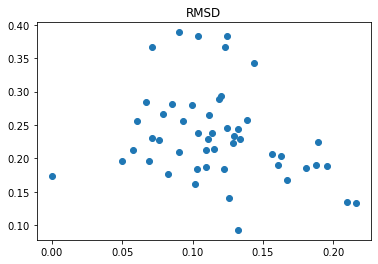

[H]O[C@@]([H])(C([H])([H])[N+]([H])([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)OC([H])([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])[C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])[C@]([H])(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])[N+]([H])([H])[H]
tensor(0.0035)


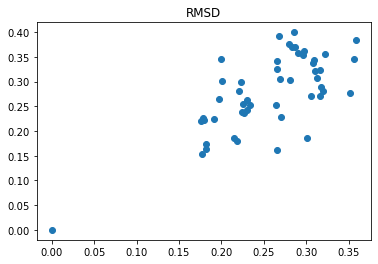

[H]c1nc(C([H])([H])[N+]([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c(C(=O)[O-])c1[H]
tensor(0.0298)


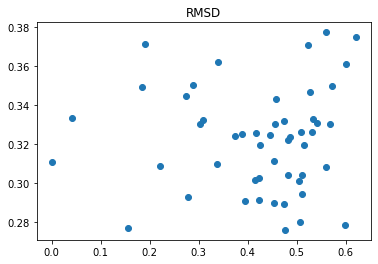

[H]c1c([H])c(Cl)c([H])c(Oc2c([H])c(C([H])([H])[N@+]3([H])C([H])([H])C([H])([H])[C@@]([H])(n4c([H])c(C([H])([H])[H])c(=O)n([H])c4=O)C([H])([H])C3([H])[H])nc3c([H])c([H])c([H])c([H])c23)c1[H]
tensor(0.0024)


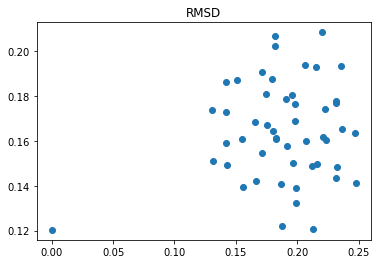

[H]c1nc([H])n([H])c1C([H])([H])[C@]([H])(C(=O)[O-])[N+]([H])([H])C([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[C@]([H])(C(=O)[O-])C([H])([H])[H]
tensor(0.0175)


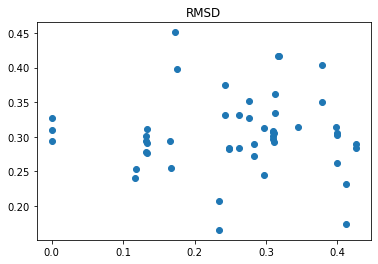

[H]O[C@@]([H])(C(F)(F)C(=O)N([H])C([H])([H])[H])[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)N1C([H])([H])C([H])([H])OC([H])([H])C1([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0187)


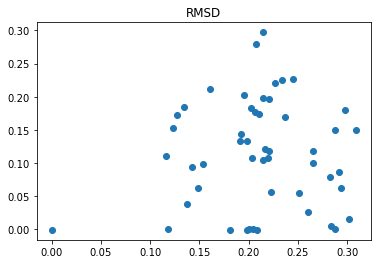

[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])Br
tensor(0.0123)


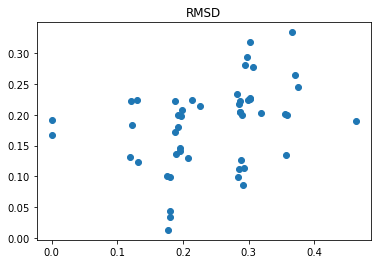

[H]c1c([H])c(S(=O)(=O)N([H])[H])c2c([H])c([H])c([H])c(N(C([H])([H])[H])C([H])([H])[H])c2c1[H]
tensor(0.0133)


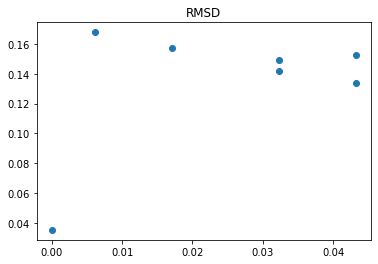

[H]Oc1c([H])c([H])c2c([H])c1-c1c([H])c(c([H])c([H])c1O[H])[C@]([H])(N(C(=O)C([H])([H])N([H])C(=O)[C@]([H])(N([H])C(=O)[C@]([H])(N(C(=O)C([H])([H])[H])C([H])([H])[H])C([H])([H])O[H])C([H])([H])[H])C([H])([H])[H])C(=O)N([H])[C@@]([H])(C([H])([H])[H])C(=O)N([H])[C@]([H])(C(=O)[O-])C2([H])[H]
tensor(0.0187)


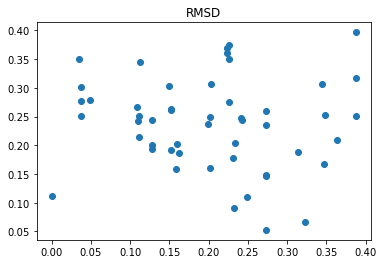

[H]OC([H])(c1sc(N([H])c2c([H])c([H])c([H])c([H])c2[H])nc1N([H])[H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0044)


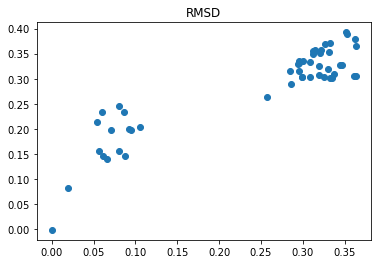

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(O[C@]3([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(O[C@@]4([H])[C@]([H])(O[H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]4([H])C([H])([H])O[H])[C@]([H])(O[H])[C@@]3([H])O[H])[C@]([H])(O[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0041)


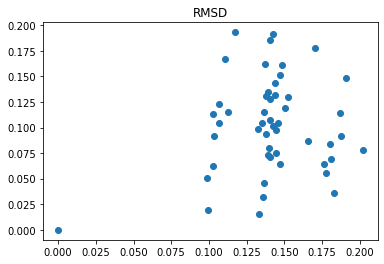

[H]S/C(=N\C([H])([H])C([H])([H])C([H])([H])n1c([H])nc([H])c1[H])N([H])c1c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c1[H]
tensor(0.0127)


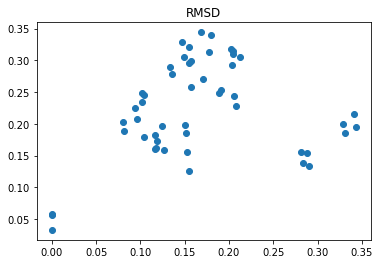

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(N2C(=O)N([H])c3c(c([H])c(C([H])([H])[H])n3[H])C2([H])[H])[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0085)


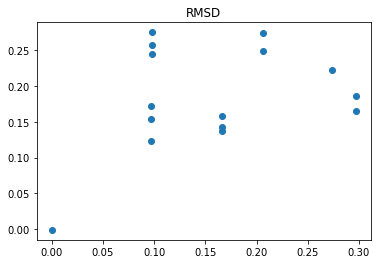

[H]/N=c1\c([H])c([H])n([C@]2([H])O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@@]2([H])O[H])c(=O)n1[H]
tensor(0.0248)


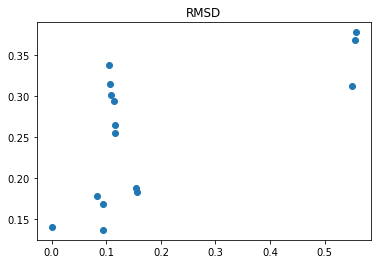

[H]c1c([H])c([H])c(N2C(=O)C3([H])SC([H])([H])C([H])([H])C3([H])[N+]([H])([H])C2([H])SC([H])([H])C(=O)N([H])c2nc3c([H])c([H])c(C([H])([H])[H])c([H])c3s2)c([H])c1[H]
tensor(0.0098)


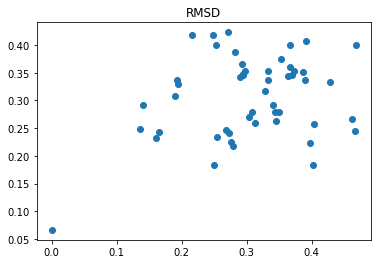

[H]O[C@]1([H])C(=O)N([H])c2c([H])c([H])c(F)c([H])c21
tensor(0.0098)


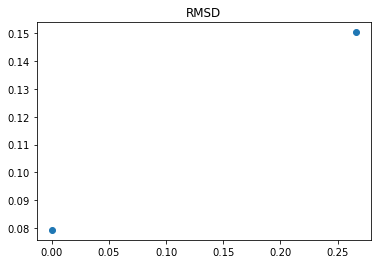

[H]Oc1c([H])c([H])c([H])c(OC([H])([H])/C([H])=C(\[H])c2c([H])c([H])c([H])c(-c3onc(C(=O)[O-])c3C([H])([H])O[H])c2[H])c1C(=O)OC([H])([H])[H]
tensor(0.0063)


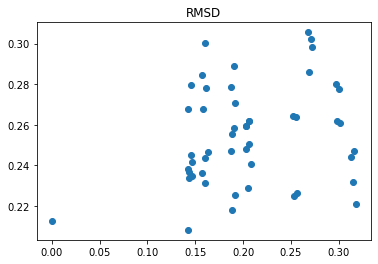

[H]c1c(-c2c([H])c([H])c([H])c([H])c2[H])noc1-c1nn([H])c([H])c1[H]
tensor(0.0071)


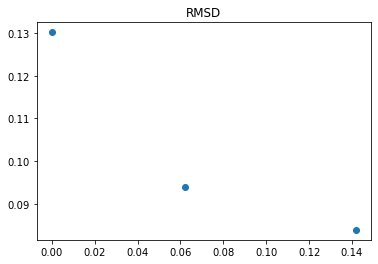

[H]c1c([H])c([H])c2c(nc(-c3nn([H])c([H])c3[H])n2[H])c1[H]
tensor(0.0179)


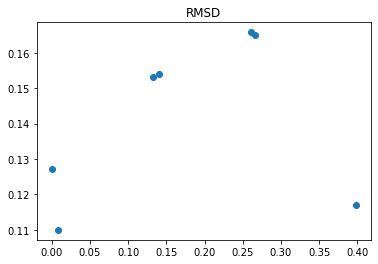

[H]c1nc(N([H])C(=O)N([H])S(=O)(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])sc1Br
tensor(0.0331)


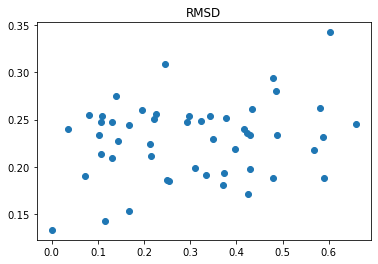

[H]c1c([H])c([H])c(-c2nc([H])n(C([H])([H])c3c([H])c([H])c(Cl)c([H])c3[H])c2-c2c(C(=O)[O-])n([H])c3c([H])c(Cl)c([H])c([H])c23)c([H])c1[H]
tensor(0.0174)


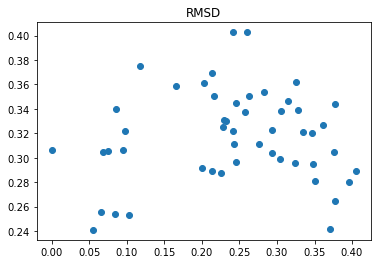

[H]c1nc(C(=O)N([H])c2c([H])c([H])c(F)c([C@@]3(C([H])([H])[H])N([H])C(=[N+]([H])[H])OC([H])([H])C3(F)F)c2[H])c([H])c([H])c1OC([H])([H])C([H])([H])[H]
tensor(0.0062)


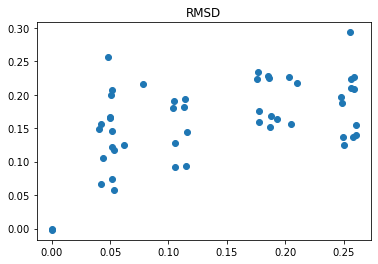

[H]c1c([H])c(-c2c(N([H])[H])nc(N([H])[H])nc2C([H])([H])C([H])([H])[H])c([H])c([H])c1Cl
tensor(0.0118)


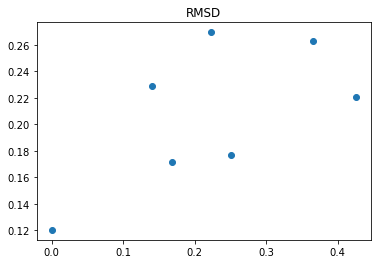

[H]Oc1c(C([H])([H])[H])c([H])c(/N=N/c2c([H])c([H])c(S(=O)(=O)N([H])c3nc([H])c([H])c([H])c3[H])c([H])c2[H])c([H])c1C([H])([H])[H]
tensor(0.0067)


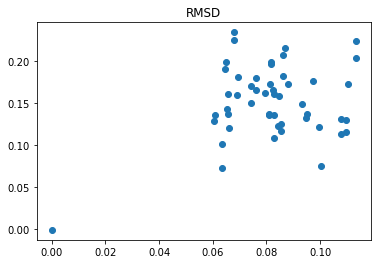

[H]/C(=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])C([H])([H])C([H])([H])[H]
tensor(0.0287)


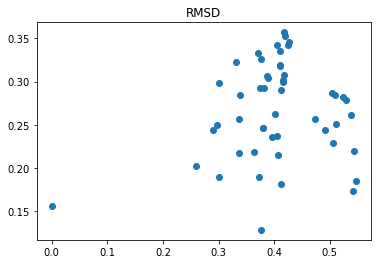

[H]ON([H])C(=O)C([H])([H])n1c([H])c([H])c2c([H])c(Br)c([H])c([H])c21
tensor(0.0141)


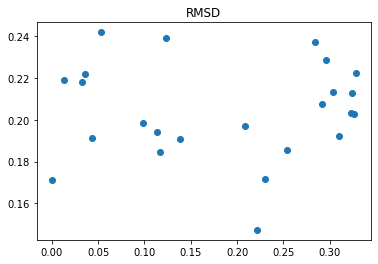

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1C(=O)C([H])([H])n1c([H])nc2c([H])c([H])c([H])c([H])c21
tensor(0.0052)


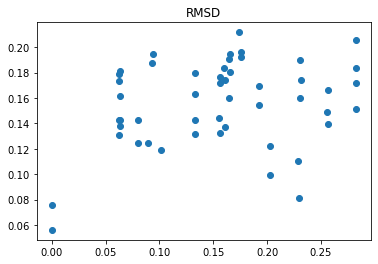

[H]OC([H])([H])[C@@]1([H])OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0365)


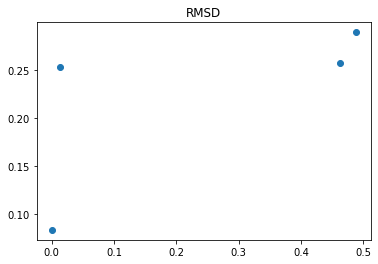

[H]c1nc([H])c([H])c(-c2c([H])c([H])c(C(=O)N([H])C([H])([H])c3c([H])c([H])c([H])c4c3OC([H])([H])C([H])([H])O4)c([H])c2[H])c1[H]
tensor(0.0051)


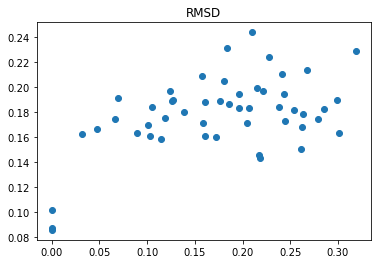

[H]/N=C(\N([H])S(=O)(=O)N([H])[H])C([H])([H])C([H])([H])SC([H])([H])c1nc(N([H])C(N([H])[H])=[N+]([H])[H])sc1[H]
tensor(0.0493)


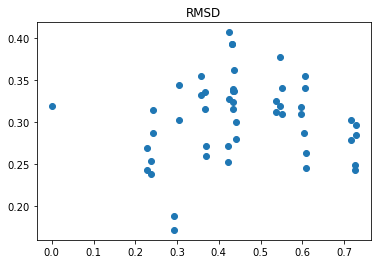

[H]Oc1c([H])c([H])c([N+](=O)[O-])c([H])c1O[H]
tensor(0.0165)


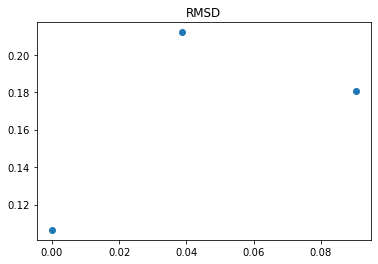

[H]C(=O)[C@@]([H])(N([H])C(=O)/C(=N\OC([H])([H])[H])c1nc(N([H])[H])sc1[H])[C@@]1([H])SC(C([H])([H])[H])(C([H])([H])[H])[C@]([H])(C(=O)[O-])[N+]1([H])[H]
tensor(0.0107)


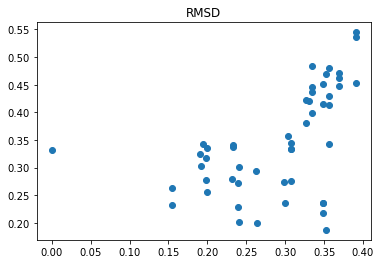

[H]c1nc(N([H])c2c([H])c([H])c(C(F)(F)F)c([H])c2[H])nc(-c2sc(C([H])([H])[H])nc2C([H])([H])[H])c1[H]
tensor(0.0136)


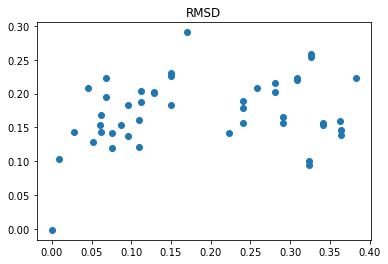

[H]c1c([H])c([H])c(N([H])C(=O)c2c([H])c([H])c([H])c([N+](=O)[O-])c2[H])c(Oc2c([H])c([H])c(C(=O)[O-])c(C(=O)[O-])c2[H])c1[H]
tensor(0.0043)


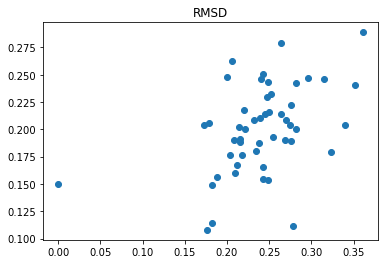

[H]c1c([H])c([H])c(C(=O)c2c([H])c([H])c3c(c2[H])C([H])([H])N(C([H])([H])C([H])([H])C(=O)N(C([H])([H])[H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C(N([H])[H])=N3)c([H])c1[H]
tensor(0.0157)


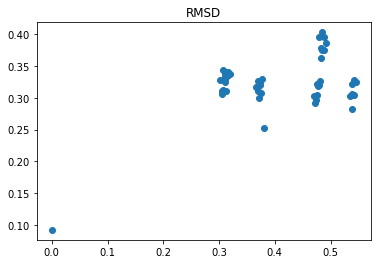

[H]c1nc([H])c([H])c(C([H])([H])N([H])c2c([H])c(-c3c([H])c([H])c([H])c(Cl)c3Cl)nc3c(SC#N)c([H])nn23)c1[H]
tensor(0.0093)


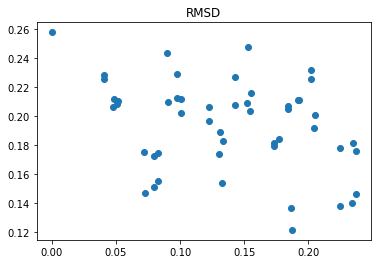

[H]c1c([H])c(-c2c(C#N)c(N([H])[H])nc3sc(C(=O)N([H])[H])c(N([H])[H])c23)c([H])c([H])c1OC([H])([H])C([H])([H])[H]
tensor(0.0077)


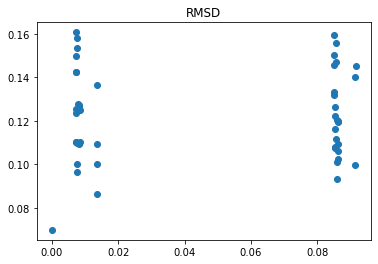

[H]c1c([H])c(S(=O)(=O)N(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])N(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])c([H])c([H])c1N([H])[H]
tensor(0.0082)


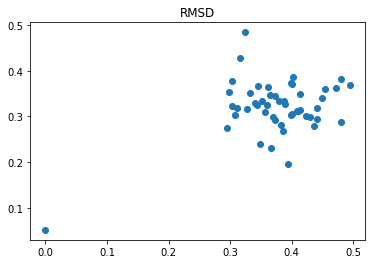

[H]Oc1c([H])c([H])c([C@@]2([H])Oc3c([H])c(OC([H])([H])[H])c([H])c(O[H])c3C(=O)C2([H])[H])c([H])c1[H]
tensor(0.0231)


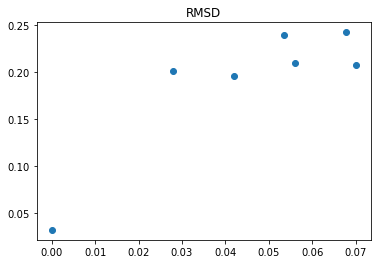

[H]Oc1c([H])c([H])c([H])c(-c2c([H])c(C(F)(F)F)c([H])c3nc([H])c(N4C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C4([H])[H])nc23)c1[H]
tensor(0.0065)


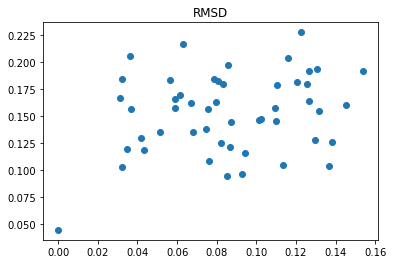

[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])Sc1c([H])c([H])c([N+](=O)[O-])c2nonc12
tensor(0.0149)


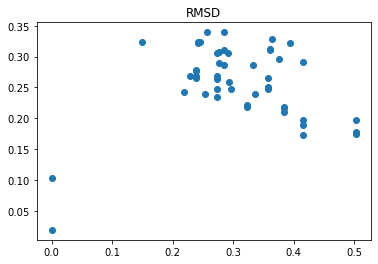

[H]c1c([H])c([H])c(C(=O)N([H])c2c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c([H])c([H])c2N([H])[H])c([H])c1[H]
tensor(0.0086)


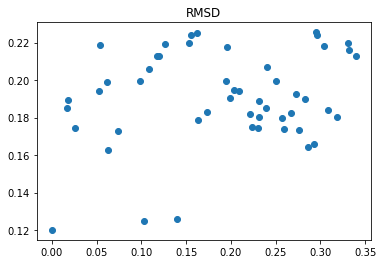

[H]Oc1c([H])c([H])c(C(=O)[O-])c([H])c1F
tensor(7.9693e-05)


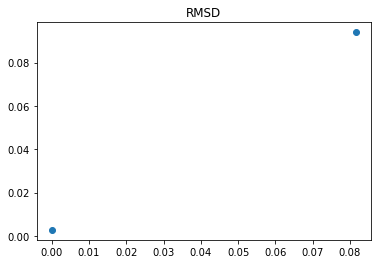

[H]c1c([H])c([H])c(C([H])([H])n2c(C(=O)[O-])c(-c3c([H])c([H])c([H])c([H])c3F)c3c([H])c(Cl)c([H])c([H])c32)c([H])c1[H]
tensor(0.0083)


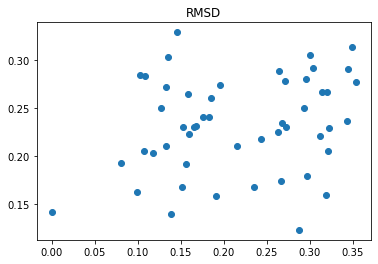

[H]c1c(OC([H])([H])[H])c(C(=O)N([H])C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])C([H])([H])[N@+]2([H])C([H])([H])C([H])([H])[H])c([H])c([N+](=O)[O-])c1N(C([H])([H])[H])C([H])([H])[H]
tensor(0.0152)


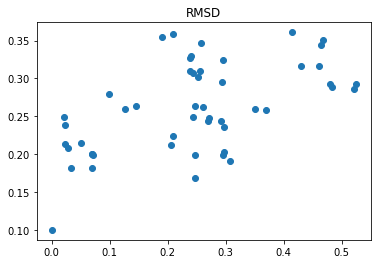

[H]c1nc2c([H])c([H])c(C([H])([H])C3([H])SC(N([H])C([H])([H])c4sc([H])c([H])c4[H])=NC3=O)c([H])c2c([H])c1[H]
tensor(0.0153)


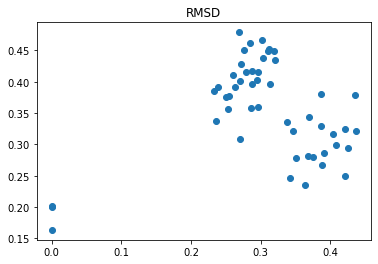

[H]/C(=C1\SC(N([H])C([H])([H])c2sc([H])c([H])c2[H])=NC1=O)c1c([H])c([H])c2nc([H])c([H])c([H])c2c1[H]
tensor(0.0270)


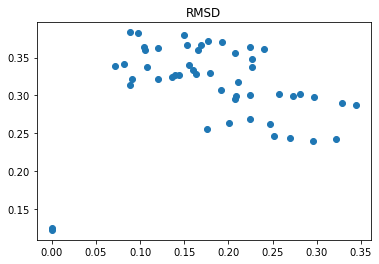

[H]/C(=C1/C(=O)N(c2c([H])c([H])c([H])c([H])c2[H])c2c([H])c(C(F)(F)F)c([H])c([H])c2N(C([H])([H])[H])C1=O)N([H])C([H])([H])C([H])([H])OC([H])([H])[H]
tensor(0.0013)


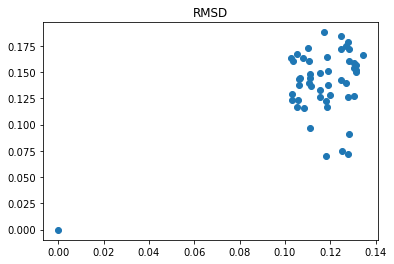

[H]c1c([H])c(-n2nc(C(=O)N([H])[H])c(N([H])C(=O)N([H])[H])c2[H])c2c([H])c(OC([H])([H])C([H])([H])[H])c([H])c([H])c2c1[H]
tensor(0.0189)


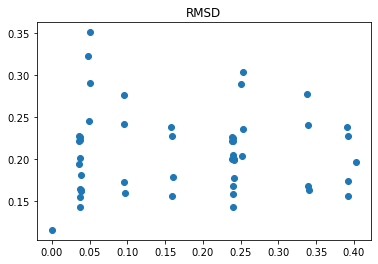

[H]Oc1c(C#N)c(=O)n([H])c2sc(Br)c(-c3c([H])c([H])c(Br)c([H])c3[H])c12
tensor(0.0303)


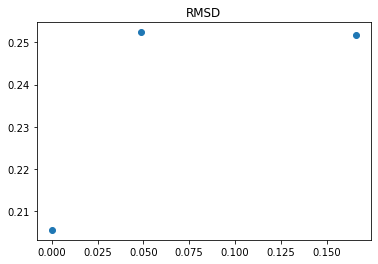

[H]c1c([H])c([H])c([C@]2([H])C([H])([H])C(=O)c3c(C([H])([H])[H])nc(N([H])[H])nc3C2([H])[H])c([H])c1[H]
tensor(0.0357)


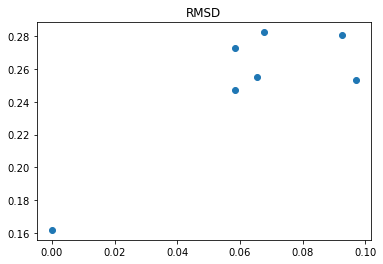

[H]c1nn(-c2nc([H])c([H])c3c(=O)n([H])c([H])nc23)c([H])c1C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])c1c([H])c([H])c(F)c([H])c1[H]
tensor(0.0122)


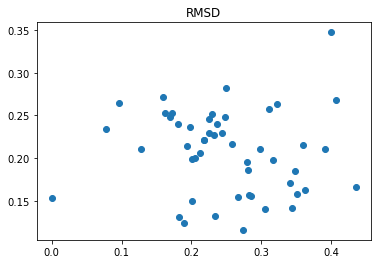

[H]Oc1c([H])c([H])c2c3c(c([H])c([H])c2c1[H])C1=C([H])C([H])([H])C(=O)[C@@]1(C([H])([H])[H])C([H])=C3[H]
tensor(0.0005)


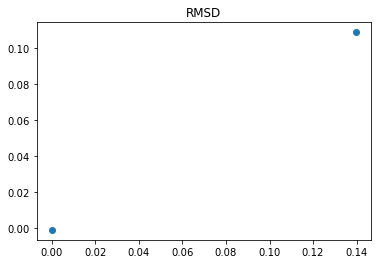

[H]c1c([H])c(OC([H])([H])[H])c2c(c1[H])C([H])([H])[C@@]1([H])[C@]([H])(C2([H])[H])C([H])([H])[C@]([H])(C([H])([H])c2c([H])c([H])c([H])c(OC([H])([H])[H])c2[H])C([H])([H])[N@+]1([H])C([H])([H])[H]
tensor(0.0088)


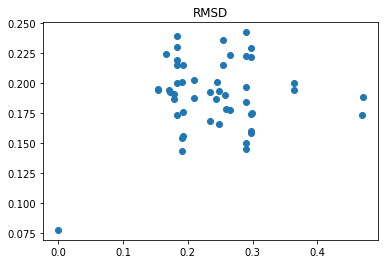

[H]c1nc([H])c(-c2c([H])c([H])c([H])c([H])c2C(=O)[O-])c([H])c1[H]
tensor(0.0450)


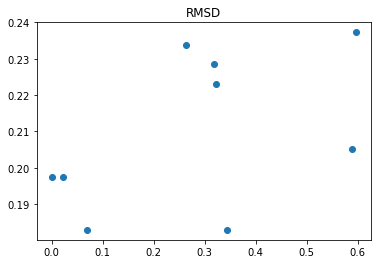

[H]c1nc([H])c2sc(-c3c([H])c([H])c([H])c([H])c3Oc3c([H])c([H])c(N([H])C(=O)C([H])([H])[H])c([H])c3[H])nc2c1[H]
tensor(0.0085)


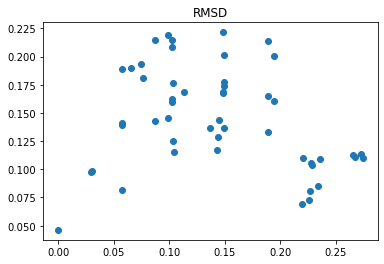

[H]c1c([H])c([H])c([C@]([H])(c2nn([H])c(-c3sc(C([H])([H])[H])nc3C([H])([H])[H])c2[H])C([H])([H])[H])c([H])c1[H]
tensor(0.0018)


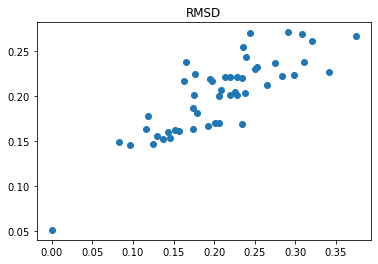

[H]OC([H])([H])[C@@]1([H])O[C@]([H])(SC([H])([H])[C@@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@@]([H])(O[H])[C@]2([H])O[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0340)


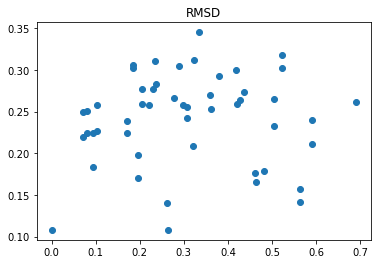

[H]c1nc2c(c([H])c(-c3c([H])c([H])c(N4C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C4([H])[H])c([H])c3[H])n2C([H])([H])[H])c(C#N)c1[H]
tensor(0.0020)


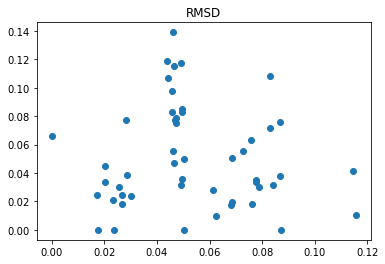

[H]c1c([H])c([H])c([C@@]2([H])[C@]([H])(C(=O)[O-])[C@]([H])(c3c([H])c([H])c([H])c([H])c3[H])[C@@]2([H])C(=O)Oc2c([H])c([H])c([H])c3c([H])c([H])c([H])c([H])c23)c([H])c1[H]
tensor(0.0274)


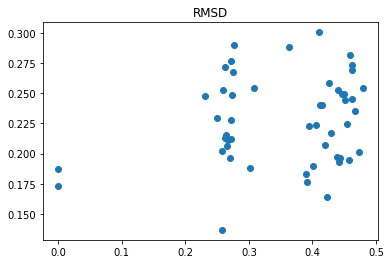

[H]Oc1c([H])c([H])c(-c2c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])c(C([H])([H])[H])nn2[H])c(O[H])c1[H]
tensor(0.0030)


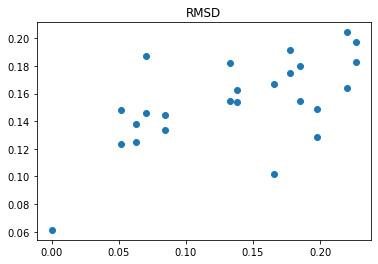

[H]c1c([H])c(Oc2nc(Oc3c([H])c([H])c([H])c(C(N([H])[H])=[N+]([H])[H])c3[H])c(F)c(C([H])([H])[H])c2F)c([H])c(C(N([H])[H])=[N+]([H])[H])c1[H]
tensor(0.0344)


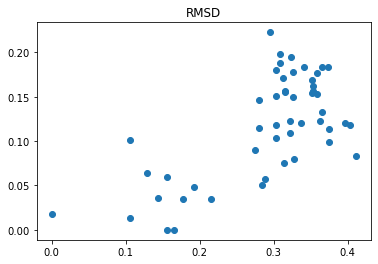

[H]Oc1c([H])c(O[H])c(C(=O)OC([H])([H])[H])c(C([H])([H])C([H])([H])C(=O)N([H])c2c([H])c(O[H])c(OC([H])([H])[H])c([H])c2O[H])c1Cl
tensor(0.0062)


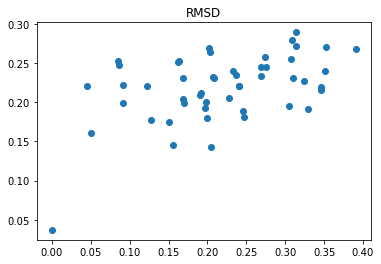

[H]c1nc(OC([H])([H])[H])c(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])nc1[H]
tensor(0.0486)


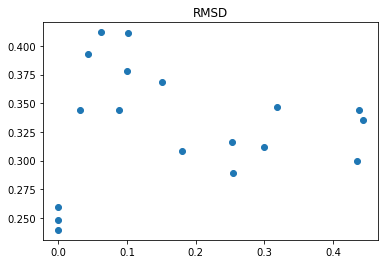

[H]c1nc(N([H])[H])c(N2C([H])([H])C([H])([H])C([H])(C(=O)[O-])C([H])([H])C2([H])[H])nc1-c1c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c(OC([H])([H])[H])c1[H]
tensor(0.0027)


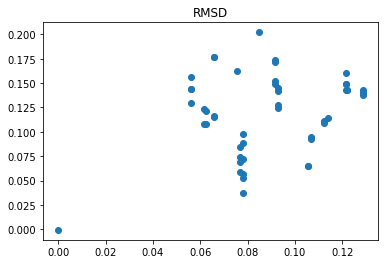

[H]c1nc(N2C([H])([H])C([H])([H])O[C@]([H])(C([H])([H])[N+]([H])([H])[H])C2([H])[H])c2c3c([H])c([H])nc([H])c3n([H])c2n1
tensor(0.0229)


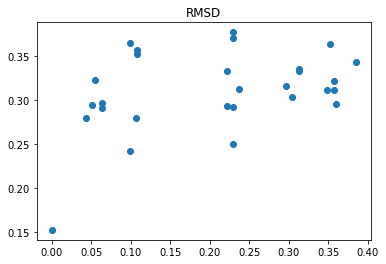

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])c([H])c(=O)n([H])c2=S)[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0189)


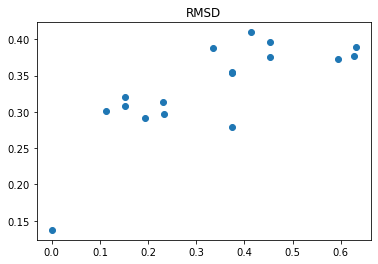

[H]OB(O[H])(O[H])~[C]([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@](C(=O)[O-])(C([H])([H])[H])[N+]([H])([H])[H]
tensor(0.0189)


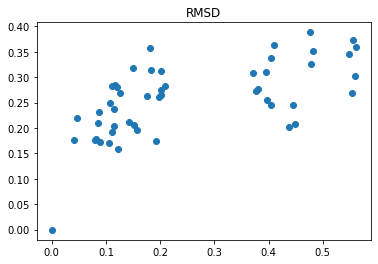

[H]c1c([H])c([H])c(N([H])C2=NC(=O)C(C([H])([H])c3c([H])c([H])c4c(c3[H])OC([H])([H])O4)=N2)c([H])c1[H]
tensor(0.0139)


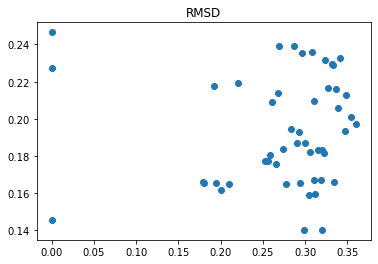

[H]Oc1c([H])c([H])c(-c2oc3c([H])c(O[H])c([H])c([H])c3c(=O)c2[H])c([H])c1O[H]
tensor(0.0214)


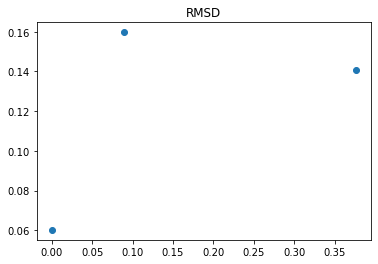

[H]c1c([H])c(N(C(=O)C([H])([H])[H])C([H])([H])[H])c([H])c([H])c1OC([H])([H])c1c([H])c([H])c(C(F)(F)F)c([H])c1C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0164)


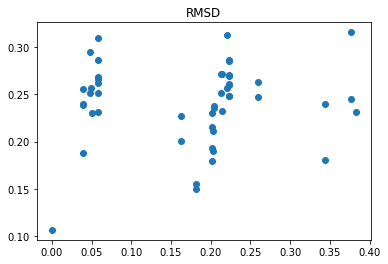

[H]N(c1nc(C2([H])C([H])([H])C2([H])[H])nc(Cl)c1C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.0221)


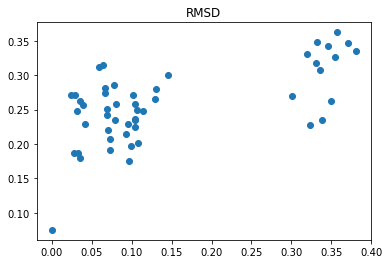

[H]Oc1c([H])c(C([H])([H])[H])c(S(=O)(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c1N([H])C(=O)c1c(C([H])([H])C([H])([H])[H])c(C(=O)C([H])([H])[H])c(C([H])([H])[H])n1[H]
tensor(0.0206)


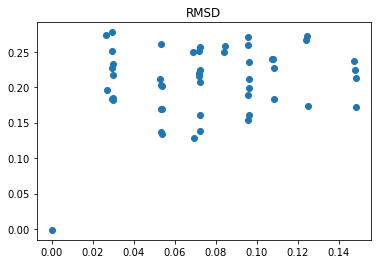

[H]OC([H])([H])C1(C([H])([H])Cl)C([H])([H])N(c2nc(-c3c([H])nc(N([H])[H])c([H])c3C(F)(F)F)nc(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])n2)C1([H])[H]
tensor(0.0080)


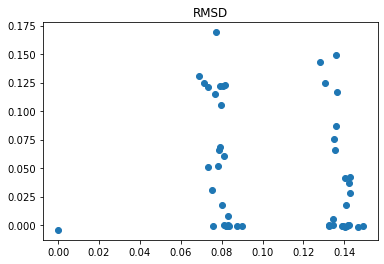

[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0039)


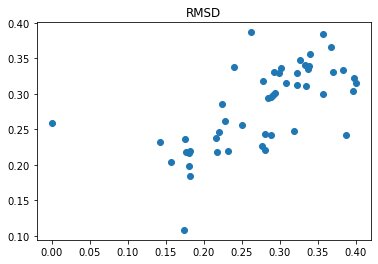

[H]c1c([H])c([H])c2c(c1[H])c1c([H])n2C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(C([H])([H])C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C1([H])[H]
tensor(3.6999)


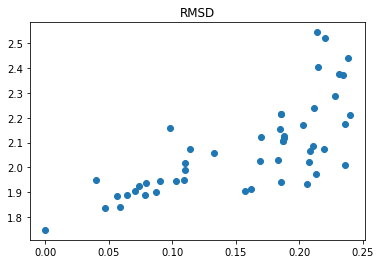

[H]Oc1c([H])c([H])c(-c2oc3c([H])c(O[H])c([H])c([H])c3c(=O)c2O[H])c([H])c1O[H]
tensor(0.0111)


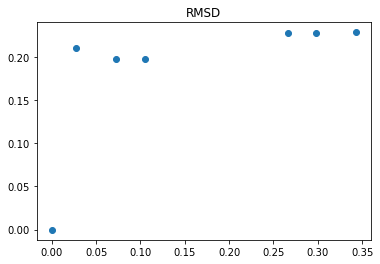

[H]O[C@]([H])(c1nc([H])c([H])s1)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])[H])=[N+]([H])[H]
tensor(0.0128)


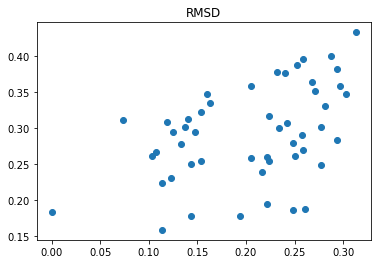

[H]O[C@@]1([H])c2c([H])c([H])c([H])c([H])c2-c2c([H])c([H])c([H])c([H])c2[C@]1([H])SC([H])([H])[C@@]([H])(C(=O)N([H])C([H])([H])C(=O)[O-])N([H])C(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H]
tensor(0.0068)


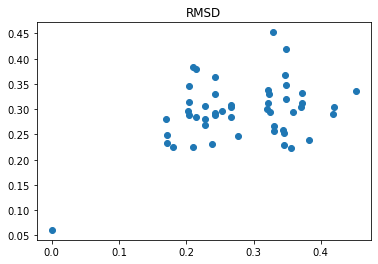

[H]ON([H])C(=O)C1(C([H])([H])S(=O)(=O)c2c([H])c([H])c(N([H])C([H])([H])C#CC([H])([H])[H])c([H])c2[H])C([H])([H])C([H])([H])N(C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0053)


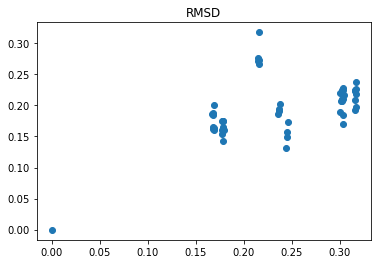

[H]c1nn([H])c(C(=O)N([H])c2c([H])c([H])c(F)c([H])c2[H])c1N([H])C(=O)C([H])([H])[H]
tensor(0.0086)


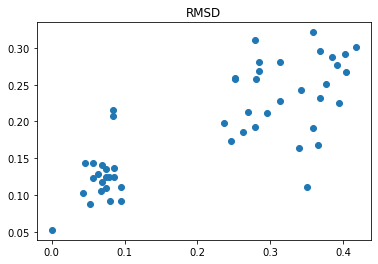

[H]c1nc2c(c([H])nn2[H])c(N2C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[N+]([H])([H])[H])C2([H])[H])c1-c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0095)


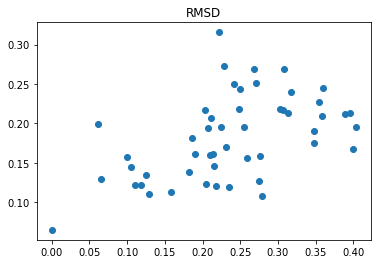

[H]c1c(C([H])([H])[H])nc(N([H])[H])nc1S(=O)(=O)c1c([H])c([H])c(C([H])([H])[H])c([H])c1[H]
tensor(0.0169)


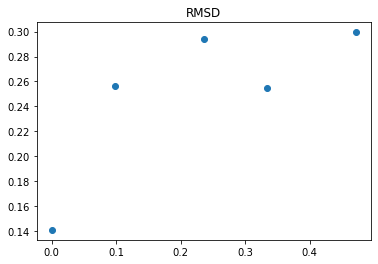

[H]OC([H])([H])C(=O)C([H])([H])[C@]([H])(C(=O)[O-])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0109)


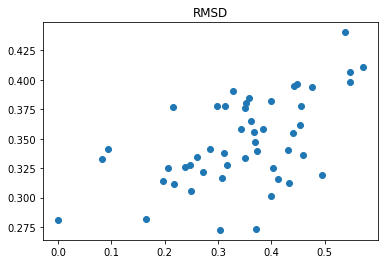

[H]c1c([H])c([H])c(-c2nc3c([H])c([H])c([H])c([H])c3c(C(=O)N3C([H])([H])C([H])([H])C([H])(C([H])([H])c4c([H])c([H])c5nc(C([H])([H])[H])c([H])c([H])c5c4[H])C([H])([H])C3([H])[H])c2[H])c([H])c1[H]
tensor(0.0058)


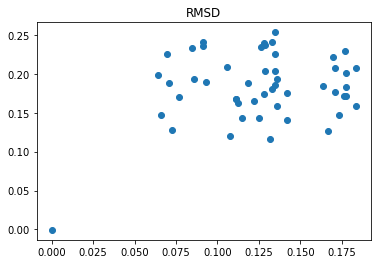

[H]c1c([H])c([H])c2c([H])c(C(=O)N([H])C([H])([H])c3c([H])c4c([H])c(OC([H])([H])[H])c([H])c([H])c4n3C([H])([H])C(=O)[O-])oc2c1[H]
tensor(0.0142)


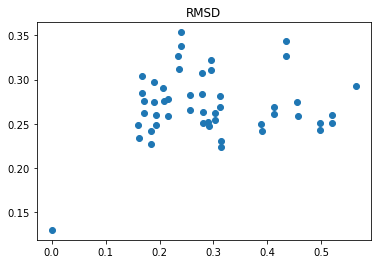

[H]Oc1c([H])c([H])c2c(c1[H])c1c(C([H])([H])[H])c3c(=O)n([H])c([H])c([H])c3c(C([H])([H])[H])c1n2[H]
tensor(0.0036)


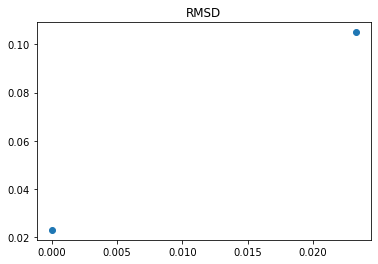

[H]Oc1c([H])c(C([H])([H])Cl)c([H])c([H])c1Oc1c([H])c([H])c(Cl)c([H])c1Cl
tensor(0.0515)


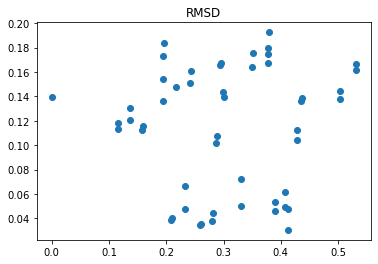

[H]c1c([H])c(-c2oc3c([H])c([H])c([H])c([H])c3c(=O)c2[H])c([H])c([H])c1C(=O)[O-]
tensor(0.0183)


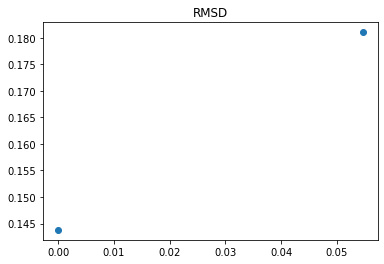

[H]c1nc(N([H])[C@]([H])(c2c(-c3nc([H])c([H])c([H])c3[H])nc3c([H])c(F)c([H])c([H])c3c2[H])C([H])([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.0099)


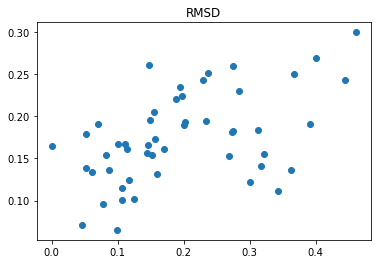

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(O[H])[C@]([H])(N([H])C(=O)C([H])([H])[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[C@@]2(C(=O)[O-])O[C@@]([H])([C@]([H])(O[H])[C@]([H])(O[H])C([H])([H])O[H])[C@]([H])(N([H])C(=O)C([H])([H])[H])[C@@]([H])(O[H])C2([H])[H])[C@@]1([H])O[H]
tensor(0.0173)


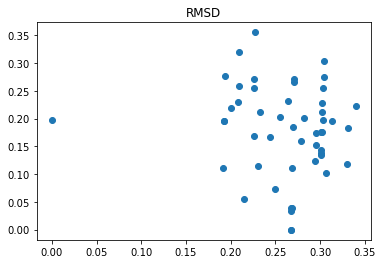

[H]c1c([H])c([C@]([H])(c2nn([H])c(-c3sc(C([H])([H])[H])nc3C([H])([H])[H])c2[H])C([H])([H])[H])c([H])c([H])c1OC([H])([H])[H]
tensor(0.0032)


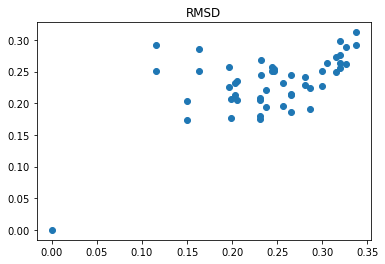

[H]c1c([H])c(N([H])C(=O)[C@@]([H])(Oc2c([H])c([H])c(OC([H])([H])[H])c([H])c2[H])C([H])([H])[H])c([H])c([H])c1I
tensor(0.0167)


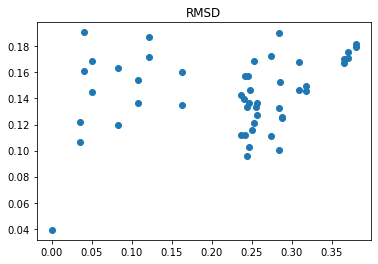

[H]c1c(N([H])[H])c([H])c2oc(=O)c(C([H])([H])C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])(C([H])([H])C(=O)[O-])C([H])([H])C(=O)[O-])c(C([H])([H])[H])c2c1[H]
tensor(0.1711)


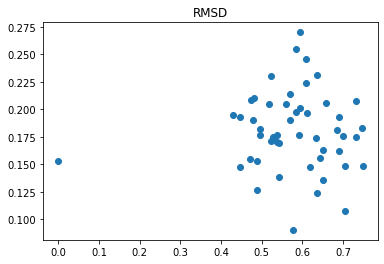

[H]OC([H])([H])[C@]([H])(C([H])([H])C(=O)C([H])=C(C([H])([H])[H])C([H])([H])[H])[C@]1([H])[C@@]([H])(O[H])C([H])([H])[C@]2(C([H])([H])[H])C3=C([H])C([H])([H])[C@@]4([H])[C@@](C(=O)[O-])(C([H])([H])[H])[C@]([H])(OC(=O)C([H])([H])[H])C([H])([H])C([H])([H])[C@]4(C([H])([H])[H])[C@@]3([H])C([H])([H])C([H])([H])[C@]21C([H])([H])[H]
tensor(0.0048)


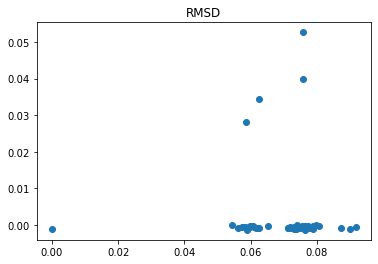

[H]OC([H])([H])C([H])([H])[C@@]([H])(O[H])C(=O)N([H])[C@@]1([H])[C@]([H])(O[H])[C@]([H])(O[C@@]2([H])O[C@]([H])(C([H])([H])[H])[C@@]([H])(N([H])C(=O)[C@]([H])(O[H])C([H])([H])C([H])([H])O[H])[C@]([H])(O[H])[C@]2([H])OC([H])([H])[H])[C@@]([H])(OC([H])([H])[H])O[C@]1([H])C([H])([H])[H]
tensor(0.0022)


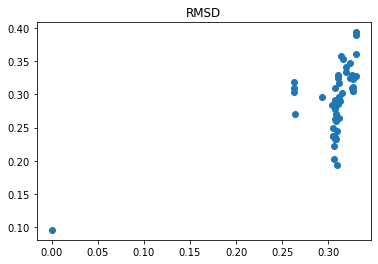

[H]OC([H])([H])c1nc(-c2c([H])c([H])c([H])c(N([H])c3nc([H])nc4c([H])c(OC([H])([H])C([H])([H])[H])c(OC([H])([H])C([H])([H])[H])c([H])c34)c2[H])c([H])s1
tensor(0.0014)


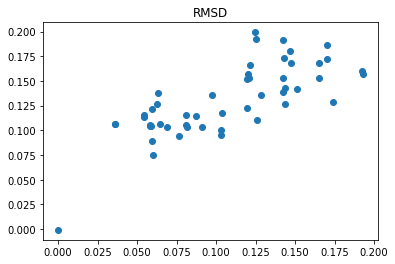

[H]O[C@@]1(C#CC([H])([H])[H])C([H])([H])C([H])([H])[C@@]2([H])[C@@]3([H])C(=C4C(=C([H])C(=O)C([H])([H])C4([H])[H])C([H])([H])C3([H])[H])[C@@]([H])(c3c([H])c([H])c(N(C([H])([H])[H])C([H])([H])[H])c([H])c3[H])C([H])([H])[C@]12C([H])([H])[H]
tensor(0.0046)


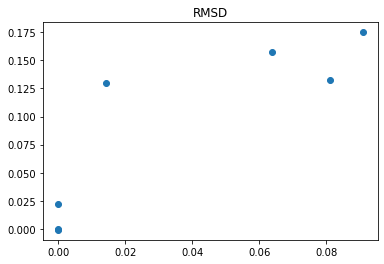

[H]Oc1c(C([H])([H])[H])c([H])c(/N=N/c2c([H])c([H])c([H])c([H])c2C(=O)[O-])c([H])c1C([H])([H])[H]
tensor(0.0072)


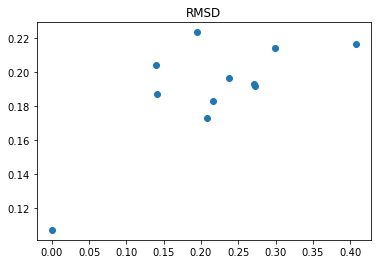

[H]OC([H])([H])[C@@]1([H])C([H])([H])[N@@+]([H])(C([H])([H])C([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0349)


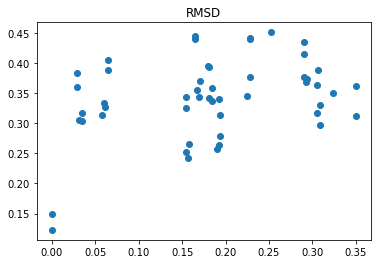

[H]O[C@]1([H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]([H])(O[H])N2/C(=N/C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])OC([H])([H])[C@@]21[H]
tensor(0.0109)


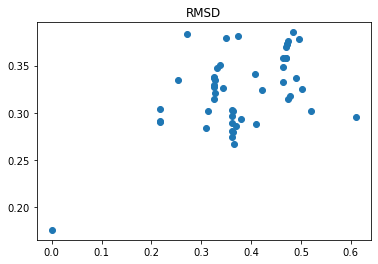

[H]c1nc([H])c(C(=O)/[N+]([H])=C2\N([H])c3c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c([H])c3C3([H])N2C([H])([H])C([H])([H])[N+]3([H])[H])c([H])c1[H]
tensor(0.0050)


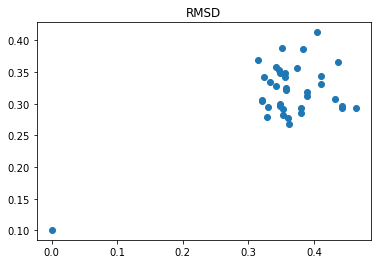

[H]OC(O[H])(C([H])([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])[C@@]([H])(N([H])C(=O)c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0113)


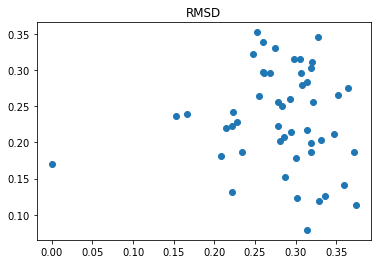

[H]c1c([H])c(C(=O)N([H])C([H])([H])C([H])([H])n2c([H])c(SC([H])([H])C(=O)N([H])c3c([H])c([H])c4c(c3[H])OC([H])([H])C([H])([H])O4)c3c([H])c([H])c([H])c([H])c32)c([H])c(C(F)(F)F)c1[H]
tensor(0.0127)


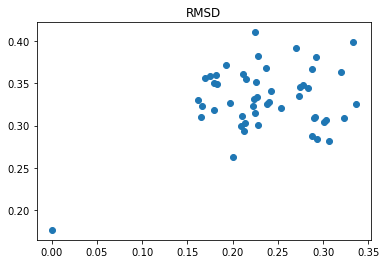

[H]c1c([H])c([H])c2c(nc(C([H])([H])[C@]([H])(C(=O)[O-])N([H])C(=O)c3sc4c([H])c([H])c([H])c([H])c4c3[H])n2[H])c1[H]
tensor(0.0682)


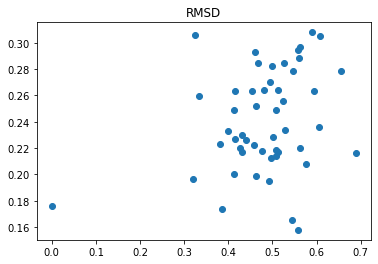

[H]c1c([H])c([H])c(Oc2c([H])c([H])n3c(C(=O)C([H])([H])[H])c([H])c(-c4c([H])c([H])c([H])c([H])c4S(=O)(=O)C([H])([H])[H])c3c2[H])c([H])c1[H]
tensor(0.0098)


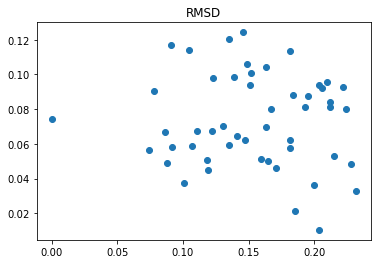

[H]c1nc(SC([H])([H])C(=O)c2c([H])c([H])c(S(=O)(=O)N([H])[H])c(Cl)c2[H])nc([H])c1[H]
tensor(0.0361)


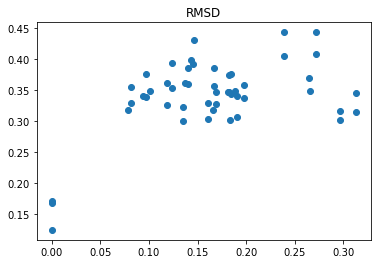

[H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])([H])[H])C([H])([H])[C@@]2([H])C(=O)N([H])C([H])([H])C2([H])[H])N([H])C(=O)C(=O)N([H])C([H])([H])C2([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0048)


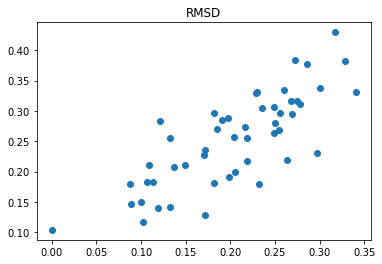

[H]c1c([H])c(S(=O)(=O)N([H])[H])c(Cl)c([H])c1C(=O)C([H])([H])n1c([H])nc2c([H])c([H])c([H])c([H])c21
tensor(0.0192)


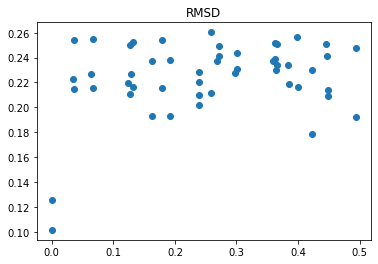

[H]N([H])c1nc2c(nc(SC([H])([H])C(=O)[O-])n2[H])c(=O)n1[H]
tensor(0.0156)


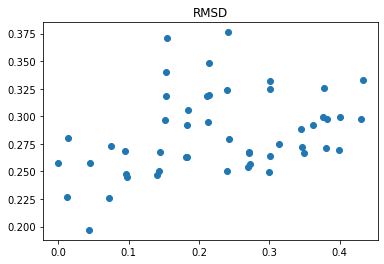

[H]c1nc(N([H])c2c([H])c([H])c(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c2[H])c([H])c(-c2nc([H])n([H])c2C([H])([H])[H])c1[H]
tensor(0.0122)


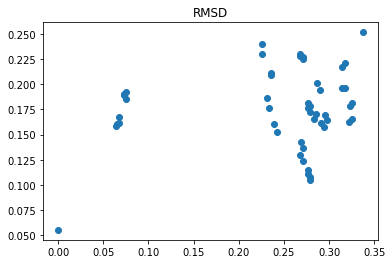

[H]OC1([H])C([H])([H])C([H])([H])[N+]([H])(C([H])([H])C(=O)c2c([H])c(C([H])([H])[H])n(-c3c([H])c([H])c(C#N)c([H])c3[H])c2C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0093)


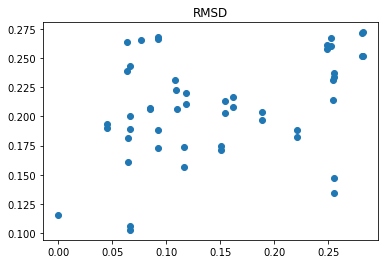

[H]Oc1c(-c2c([H])c([H])c([H])c([H])c2[H])c([H])c([H])c([H])c1-c1nc2c([H])c(C(N([H])[H])=[N+]([H])[H])c(Cl)c([H])c2n1[H]
tensor(0.0068)


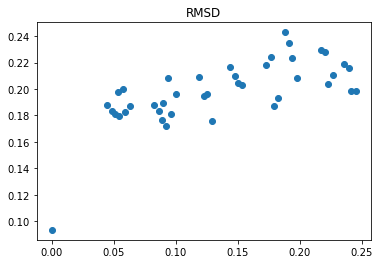

[H]O[C@]1([H])[C@@]([H])(C([H])([H])SC([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H])O[C@@]([H])(n2c([H])nc3c(N([H])C([H])([H])c4c([H])c([H])c([H])c(Cl)c4[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0176)


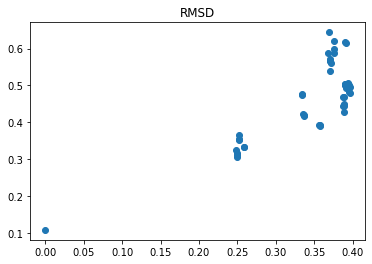

[H]Oc1c(/N=N/c2c([H])c([H])c(-c3c([H])c([H])c(N([H])N([H])c4c([H])c([H])c5c(S(=O)(=O)[O-])c([H])c(S(=O)(=O)[O-])c(N([H])[H])c5c4O[H])c(OC([H])([H])[H])c3[H])c([H])c2OC([H])([H])[H])c([H])c([H])c2c(S(=O)(=O)[O-])c([H])c(S(=O)(=O)[O-])c(N([H])[H])c12
tensor(0.0033)


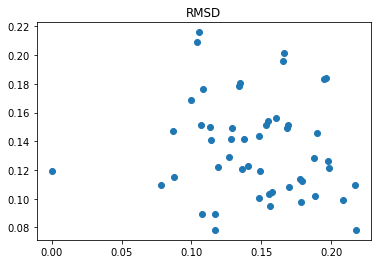

[H]c1c([H])c([H])c(-c2c([H])c([H])c(C(=O)C([H])([H])Sc3nc4c(c(=O)n([H])c(=[N+]([H])[H])n4[H])n3[H])c([H])c2[H])c([H])c1[H]
tensor(0.0073)


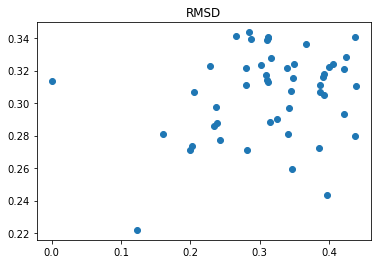

[H]c1nc([H])c(C(=O)N([H])N([H])C(=O)C([H])([H])C([H])([H])C(=O)[O-])c(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1[H]
tensor(0.0042)


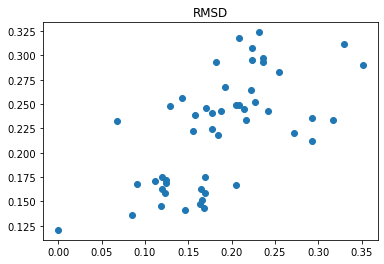

[H]c1nnc(N([H])C([H])([H])c2nc3c([H])c(OC([H])([H])C(=O)[O-])c([H])c([H])c3s2)nc1-c1c(OC([H])([H])[H])c([H])c([H])c([H])c1OC([H])([H])[H]
tensor(0.0061)


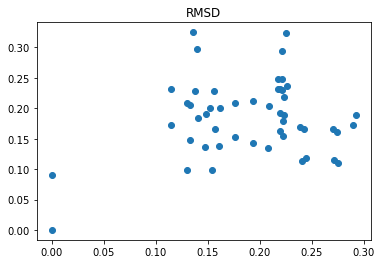

[H]c1sc(C(=O)N([H])[H])c(N([H])c2nc(N([H])c3c([H])c4c(c([H])c3OC([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])N4C(=O)C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])nc3c2c([H])c([H])n3[H])c1[H]
tensor(0.0049)


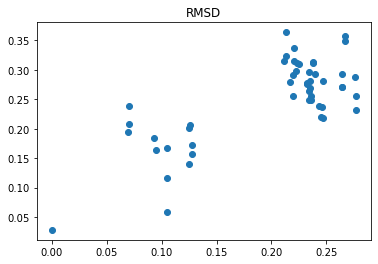

[H]Oc1c([H])c([H])c(S(=O)(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c1N([H])C(=O)c1c(C([H])([H])C([H])([H])[H])c(C(=O)N([H])[H])c(C([H])([H])[H])n1[H]
tensor(0.0045)


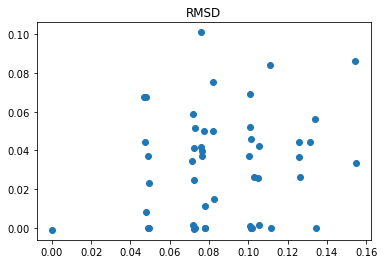

[H]c1c([H])c([H])c(N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c(S(=O)(=O)N([H])c3c([H])c([H])c(Br)c([H])c3[H])c2[H])c(C(=O)[O-])c1[H]
tensor(0.0061)


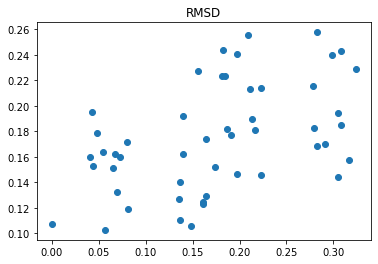

[H]c1nc(-c2c([H])oc([H])c2[H])c2c(-c3c([H])c([H])c([H])c([H])c3[H])n([H])nc2c1[H]
tensor(0.0091)


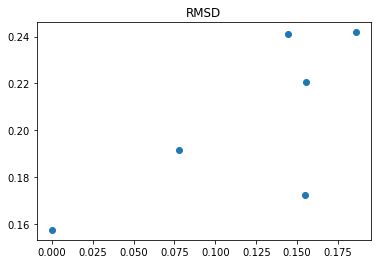

[H]N1C(=O)N([H])/C(=N/C([H])([H])[H])C([H])([H])C1=O
tensor(0.0079)


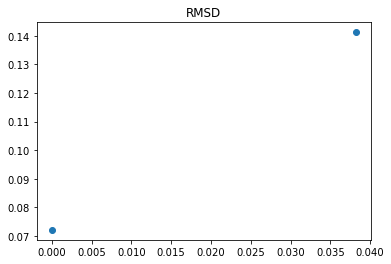

[H]c1c([H])c(Cl)c([H])c([C@@]2([H])[C@]([H])([N+]([H])([H])[H])C([H])([H])[N@@+]([H])(C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@@]23C(=O)N([H])c2c([H])c(Cl)c([H])c([H])c23)c1[H]
tensor(0.0937)


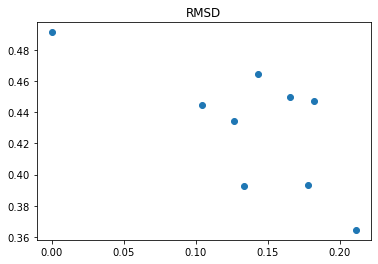

[H]O[C@@]1([H])C([H])([H])[C@]2([H])C([H])([H])[C@]([H])(O[H])C([H])([H])C([H])([H])[C@]2(C([H])([H])[H])[C@@]2([H])C([H])([H])C([H])([H])[C@@]3(C([H])([H])[H])[C@@]([H])(C([H])([H])C([H])([H])[C@]3([H])[C@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[N+]3([H])C([H])([H])C([H])([H])N(C(=O)OC([H])([H])c4c([H])c(Cl)c([H])c(Cl)c4[H])C([H])([H])C3([H])[H])[C@]12[H]
tensor(0.0041)


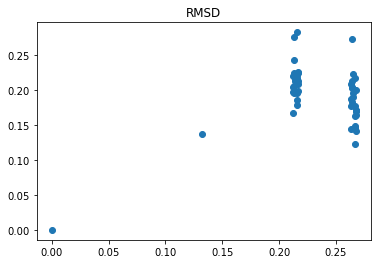

[H]C1=C(C(=O)N(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])N([H])c2c([H])c(=O)oc3c([H])c([H])c([H])c([H])c23)SC([H])([H])C1([H])[H]
tensor(0.0443)


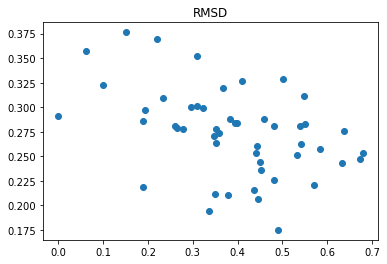

[H]c1c([H])c(N([H])C(=O)C([H])([H])N2C(=O)[C@]([H])(C([H])([H])c3c([H])c(Cl)c([H])c([H])c3OC([H])([H])[H])C([H])([H])N([H])/C(=N\N(C([H])([H])[H])C([H])([H])[H])C2([H])[H])c([H])c(S(=O)(=O)C([H])([H])[H])c1[H]
tensor(0.0106)


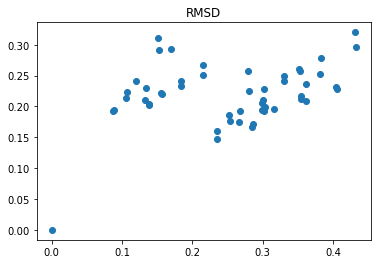

[H]c1nn(C([H])([H])[H])c([H])c1C(=O)N([H])c1c([H])c([H])c(OC([H])([H])c2c([H])c([H])c([H])c(N([H])C(=O)C([H])([H])Sc3nc(C([H])([H])[H])c([H])c(C([H])([H])[H])n3)c2[H])c([H])c1[H]
tensor(0.0071)


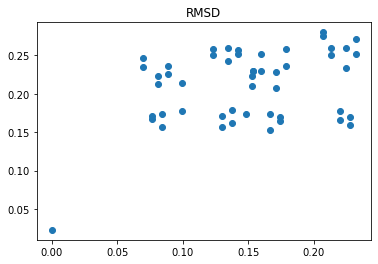

[H]ON([H])C(=O)[C@@]([H])(c1c([H])c([H])c(-c2c([H])c(F)c(F)c(F)c2[H])c([H])c1[H])N([H])C(=O)C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0142)


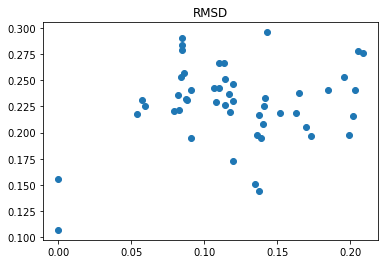

[H]ON([H])C(=O)[C@@]([H])(c1c([H])c([H])c(-c2c([H])c(F)c(F)c(F)c2[H])c([H])c1[H])N([H])C(=O)C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0131)


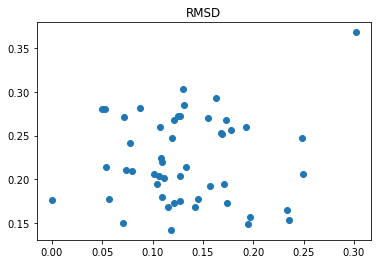

[H]c1c([H])c(C([H])([H])[H])c(I)c([H])c1C(=O)N([H])c1c([H])c([H])c2nc(C([H])([H])[N+]3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])n([H])c2c1[H]
tensor(0.0074)


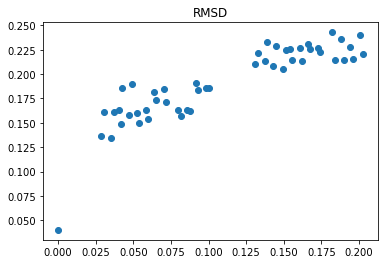

[H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H]
tensor(0.0095)


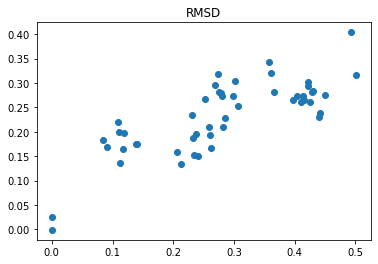

[H]OC([H])(c1c([H])c([H])c([H])c([H])c1[H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0071)


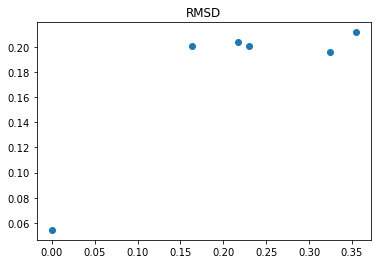

[H]Oc1c([H])c([H])c([H])c(-c2c([H])c([H])c([H])c([H])c2Cl)c1O[H]
tensor(0.0500)


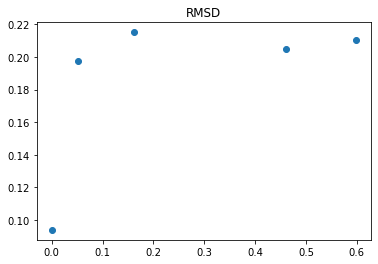

[H]Oc1c([H])c([H])c([H])c2oc3c([N+](=O)[O-])c([H])c([H])c(O[H])c3c(=O)c12
tensor(0.0460)


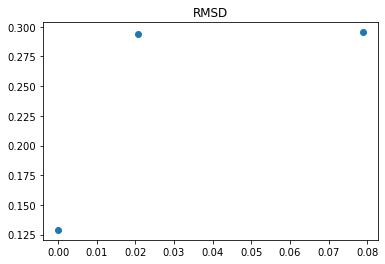

[H]OC([H])([H])c1c([H])c([H])c(C([H])([H])N2C(=O)N(C([H])([H])c3c([H])c([H])c(C([H])([H])O[H])c([H])c3[H])[C@]([H])(C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@@]2([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0362)


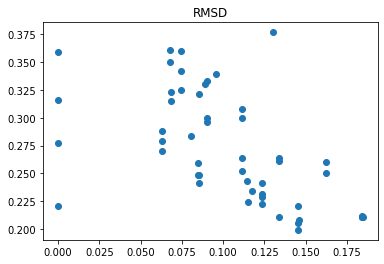

[H]/C(=C1\SC(=S)N(C([H])([H])C([H])([H])C(=O)[O-])C1=O)c1oc(-c2c([H])c([H])c(Cl)c([H])c2[H])c([H])c1[H]
tensor(0.0063)


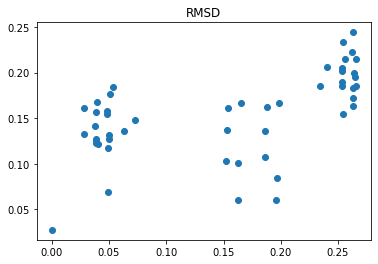

[H]c1c([H])c([H])c(C([H])(O[C@]2([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])C([H])([H])C([H])([H])c3nnnn3[H])C([H])([H])C2([H])[H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0361)


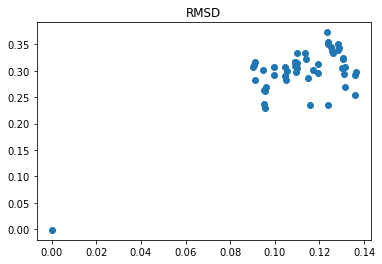

[H]SC([H])([H])[C@]([H])(C(=O)N1C([H])([H])[C@@]([H])(Sc2c([H])c([H])c([H])c([H])c2[H])C([H])([H])[C@@]1([H])C(=O)[O-])C([H])([H])[H]
tensor(0.0187)


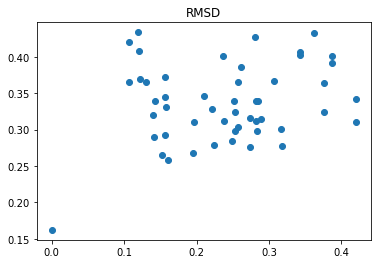

[H]Oc1c(-c2c([H])c([H])c([H])c(C([H])([H])N([H])C(=O)N([H])[H])c2[H])c([H])c([H])c([H])c1-c1c([H])c2c([H])nc([H])c([H])c2n1[H]
tensor(0.0081)


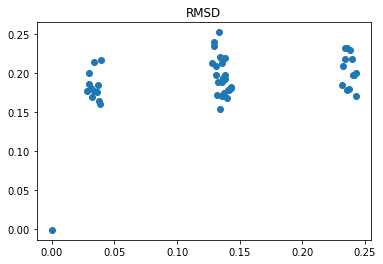

[H]Oc1c([H])c([H])c(Cl)c(C([H])([H])[H])c1[H]
tensor(0.0083)


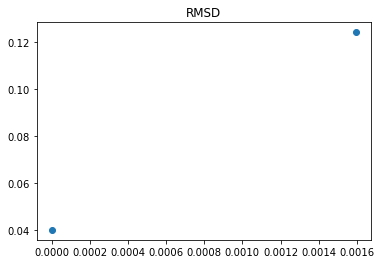

[H]N([H])C(=O)c1c(N([H])C(=O)C2([H])C([H])([H])C2([H])[H])sc2c1C([H])([H])C([H])([H])C([H])([H])C2([H])[H]
tensor(0.0037)


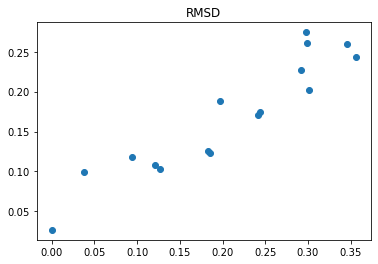

[H]c1nc([H])c(C([H])([H])N([H])c2nc(-c3c([H])c([H])c([H])c([H])c3F)c([H])[n+]3c([H])c([H])n([H])c23)c([H])c1[H]
tensor(0.0112)


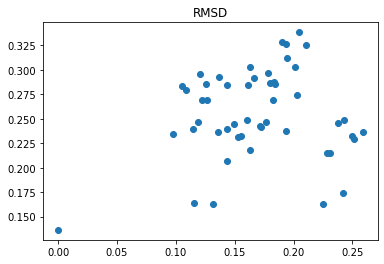

[H]c1nc(N([H])c2c([H])c([H])c([H])c(N([H])S(=O)(=O)C([H])([H])[H])c2[H])nc(N([H])c2c(Cl)c([H])c([H])c3c2OC([H])([H])O3)c1[H]
tensor(0.0110)


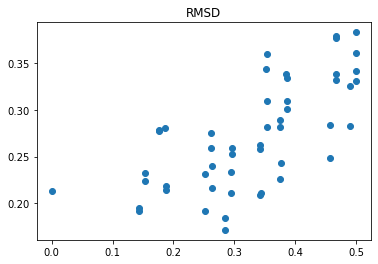

[H]c1c([H])c([H])c2c(c1[H])c(C([H])([H])[H])c([H])c1n([H])n([H])c(=O)[n+]21
tensor(0.0126)


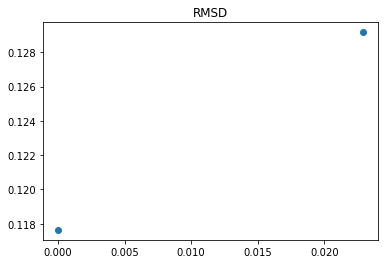

[H]c1c([H])c([H])c(C([H])([H])OC(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C([H])([H])C([H])([H])C(=O)C([H])([H])[H])C([H])([H])[C@@]2([H])C(=O)N([H])C([H])([H])C2([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])N([H])C(=O)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(0.0328)


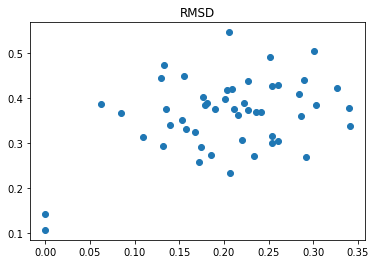

[H]c1c([H])c([H])c(C([H])([H])OC(=O)N([H])C([H])([H])C(=O)C([H])([H])[H])c([H])c1[H]
tensor(0.0163)


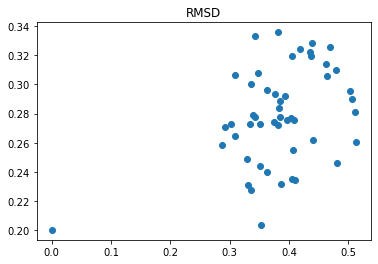

[H]c1nc([H])c(C([H])([H])c2c([H])n([H])c3c(=O)n([H])c(=[N+]([H])[H])n([H])c23)c([H])c1[H]
tensor(0.0261)


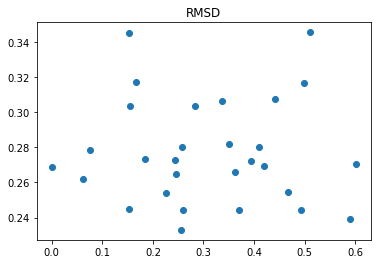

[H]Oc1c([H])c([H])c(C(=O)[O-])c(O[H])c1N([H])C(=O)C([H])([H])C([H])([H])[C@]1(C([H])([H])[H])C(=O)C([H])=C([H])[C@@]23C([H])([H])C(=C([H])[H])[C@@]([H])(C([H])([H])[C@@]2([H])O[H])C([H])([H])[C@@]13[H]
tensor(0.0191)


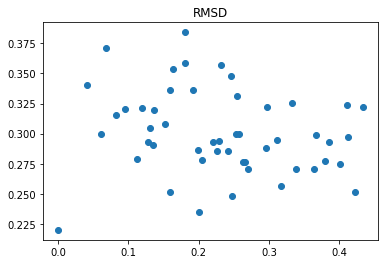

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)C([H])([H])Oc1c([H])c([H])c([H])c(F)c1C(=O)N(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0138)


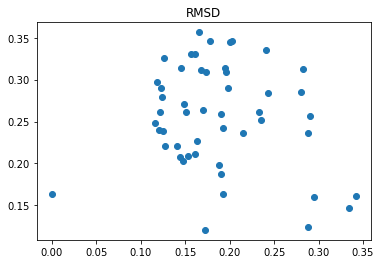

[H]c1nc2c(c([H])c1[H])c(-c1nnn(C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c1[H])c([H])n2[H]
tensor(0.0154)


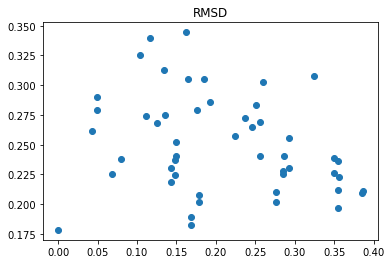

[H]O/C(=C(/[H])C(=O)C(=O)[O-])c1c([H])c([H])c([H])c(Br)c1[H]
tensor(0.0316)


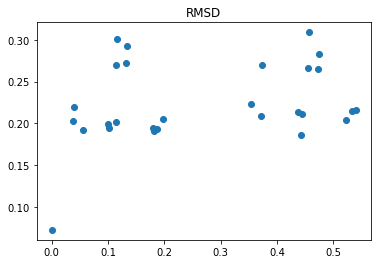

[H]c1nc(N([H])[H])c2c(-c3c([H])c([H])c4c([H])c(OC([H])([H])c5c([H])c([H])c([H])c(Cl)c5[H])c([H])c([H])c4c3[H])nn(C([H])(C([H])([H])[H])C([H])([H])[H])c2n1
tensor(0.0018)


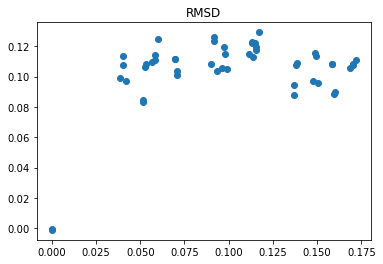

[H]N([H])c1nc(N([H])[H])c2nc(C([H])([H])[H])c(OC([H])([H])[H])nc2n1
tensor(0.0322)


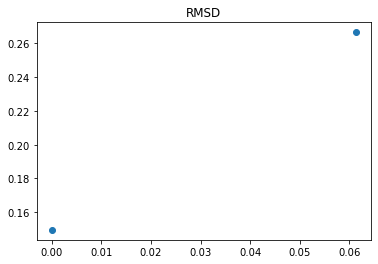

[H]c1sc(S(=O)(=O)N([H])c2c([H])c(-c3c([H])sc(=O)n3[H])c([H])c(N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[H])c2[H])c([H])c1[H]
tensor(0.0126)


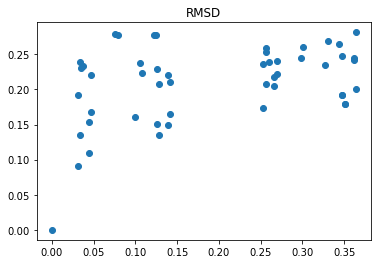

[H]Oc1c([H])c([H])c(-c2oc3c([H])c([H])c([H])c([H])c3c(=O)c2[H])c([H])c1[H]
tensor(0.0061)


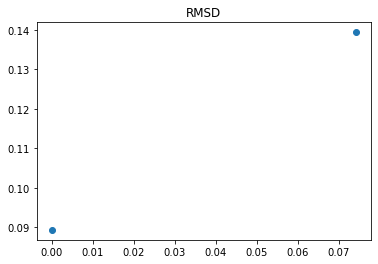

[H]c1c([H])c(C([H])([H])Sc2nc3c(c(=O)n2[H])C([H])([H])C([H])([H])C3([H])[H])c([H])c([H])c1C([H])([H])[H]
tensor(0.0196)


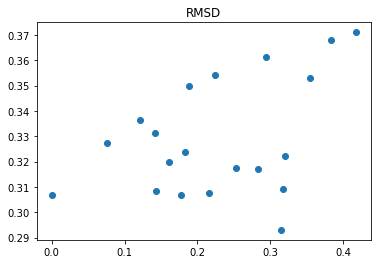

[H]ON([H])C(=O)[C@]([H])(c1c([H])c([H])c(-n2nc([H])c([H])c2[H])c([H])c1[H])N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0083)


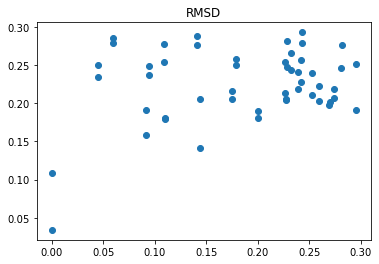

[H]c1oc(C(=O)N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])c3nc4c(c(=O)n(C([H])([H])[H])c(=O)n4C([H])([H])[H])n3C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0038)


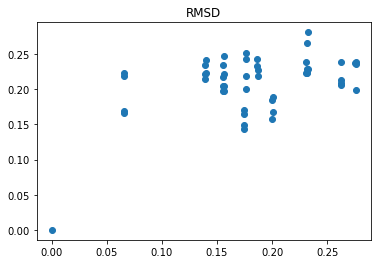

[H]C1=C(C([H])([H])[H])C2=N/C1=C(/[H])C1=N/C(=C(/[H])C3=N/C(=C(/[H])C4=N/C(=C\2[H])C(C([H])([H])[H])=C4C([H])([H])C([H])([H])C(=O)[O-])C(C([H])([H])C([H])([H])C(=O)[O-])=C3C([H])([H])[H])C([H])=C1C([H])([H])[H]
tensor(0.0084)


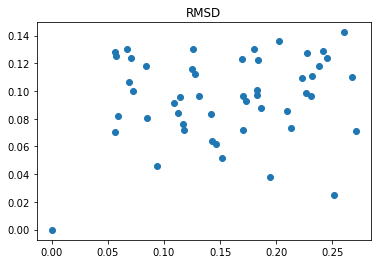

[H]O[C@@]([H])(C([H])([H])[N+]([H])([H])C(c1nc([H])c([H])c([H])c1[H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(N([H])C(=O)c1c([H])c(C(=O)N(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c(N2C([H])=C([H])C([H])=C([H])C2([H])[H])c1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0066)


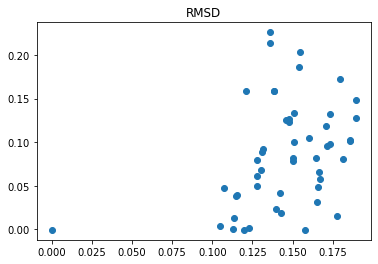

[H]c1nc(N([H])[H])c([H])c([H])c1-c1c([H])c([H])c2c(c1[H])N(c1c([H])c([H])c(Cl)c([H])c1[H])C([H])([H])[C@]([H])(C([H])([H])[H])c1nnc(C([H])([H])[H])n1-2
tensor(0.0049)


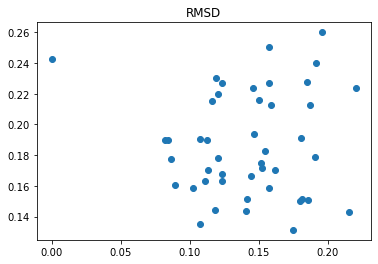

[H]Oc1c([H])c([H])c2sc(N([H])C(=O)C([H])([H])[H])nc2c1[H]
tensor(0.0122)


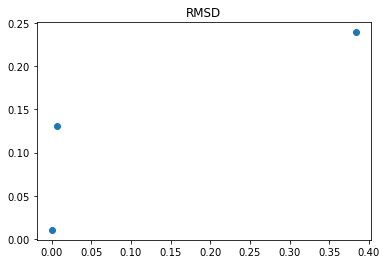

[H]Oc1c(C(=O)N([H])[C@@]([H])(C(=O)[O-])C([H])([H])c2c([H])n([H])c3c([H])c([H])c([H])c([H])c23)nc(Cl)c2c([H])c([H])c([H])c([H])c12
tensor(0.0125)


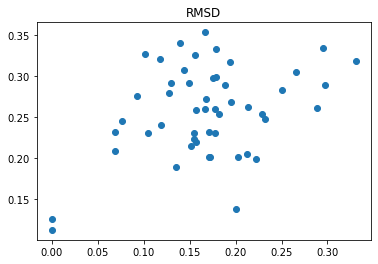

[H]C1=C2C(=NC(=O)N(c3c([H])c([H])c([H])c(OC([H])([H])c4c([H])c([H])c([H])c([H])c4[H])c3[H])C2([H])[H])C([H])([H])C(=O)N1C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0053)


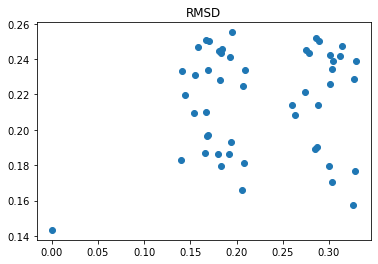

[H]c1oc(C(=O)N2c3c([H])c(-c4c([H])c([H])c([H])c(C(=O)N([H])C([H])([H])[H])c4[H])c([H])c([H])c3N(C(=O)C([H])([H])[H])[C@@]([H])(C([H])([H])[H])C2([H])[H])c([H])c1[H]
tensor(0.0169)


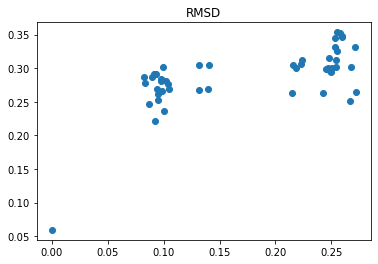

[H]Oc1c(C(=O)N([H])C2([H])C([H])([H])c3c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c3C2([H])[H])nc([C@@]2([H])N(C(=O)C([H])([H])Sc3c([H])c([H])c([H])c([H])c3Cl)C([H])([H])C([H])([H])C2([H])[H])n([H])c1=O
tensor(0.0451)


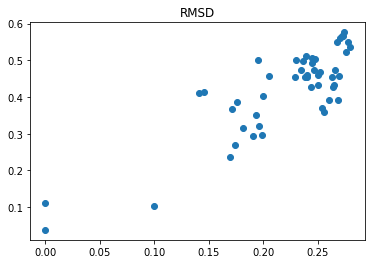

[H]c1nc(C([H])([H])[H])c2c(c1[H])c1c([H])c([H])c(OC([H])([H])[H])c([H])c1n2[H]
tensor(0.0034)


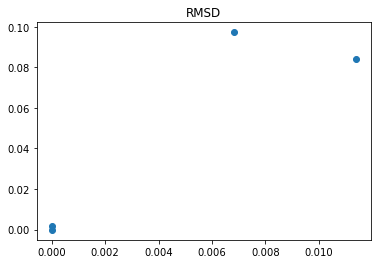

[H]c1nc(N(C([H])([H])[H])[C@]2([H])C([H])([H])[C@]([H])(N([H])S(=O)(=O)C([H])([H])C([H])([H])C([H])([H])[H])C2([H])[H])c2c([H])c([H])n([H])c2n1
tensor(0.0256)


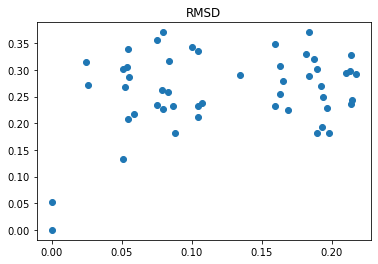

[H]/C(=N\OC([H])([H])C(=O)N1C([H])([H])[C@@]([H])(C([H])([H])[H])O[C@]([H])(C([H])([H])[H])C1([H])[H])c1c([H])c([H])c(OC([H])(F)F)c(OC2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0201)


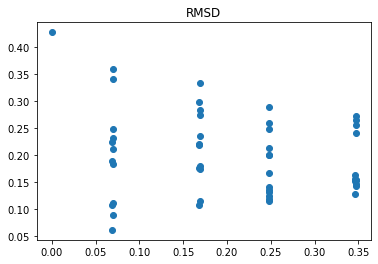

[H]c1c([H])c(N([H])C([H])([H])c2nc3c([H])c(C([H])([H])n4c(C([H])([H])[H])nc5c([H])c([H])c([H])c([H])c54)c([H])c([H])c3n2C([H])([H])[H])c([H])c([H])c1C(N([H])[H])=[N+]([H])[H]
tensor(0.0041)


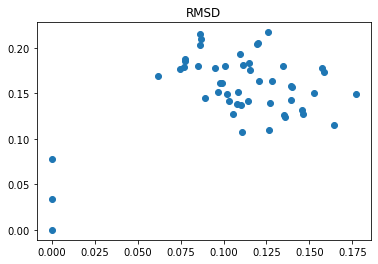

[H]Oc1c([H])c([H])c([H])c2c1C(=O)c1c(O[H])c([H])c([H])c([N+](=O)[O-])c1C2=O
tensor(0.0350)


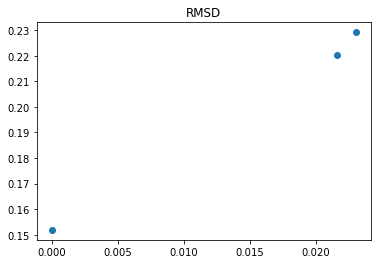

[H]Oc1c(-c2c([H])c([H])c([H])c([H])c2OC([H])([H])[H])c([H])c([C@]([H])(C(=O)[O-])C([H])([H])C(=O)[O-])c([H])c1-c1nc2c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c2n1[H]
tensor(0.0239)


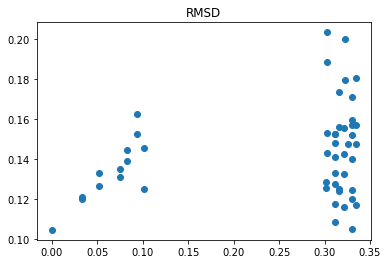

[H]O[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[H])C([H])([H])c1c([H])n([H])c2c([H])c([H])c([H])c([H])c12)C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])[H])=[N+]([H])[H])C([H])([H])C([H])=C([H])[H])C([H])([H])C(=O)OC([H])([H])C([H])([H])[H]
tensor(0.0612)


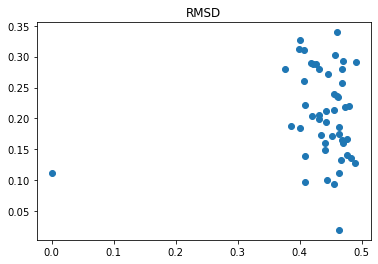

[H]c1c([H])c([H])c(C([H])([H])N([C@@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]2([H])N(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c([H])c([H])c2Cl)S(=O)(=O)c2c([H])c([H])c([H])c([H])c2Cl)c([H])c1[H]
tensor(0.0092)


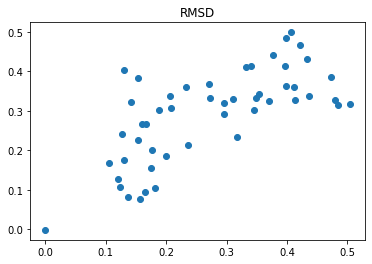

[H]OC([H])([H])C1=Nc2c(nc(N([H])[H])n([H])c2=O)N([H])C1([H])[H]
tensor(0.0079)


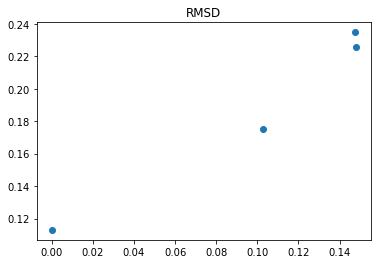

[H]c1nc([H])c([H])c(C(=O)N([H])[C@]2([H])c3c([H])c([H])c([H])c([H])c3-c3c(-c4nc5c([H])c([H])nc([H])c5n4[H])c([H])c([H])c([H])c32)c1[H]
tensor(0.0021)


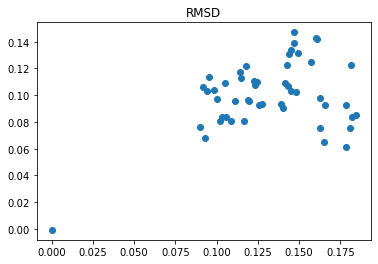

[H]c1nc(N([H])[H])c(O[C@@]([H])(c2c(Cl)c([H])c([H])c(F)c2Cl)C([H])([H])[H])c([H])c1-c1c([H])nn(C([H])([H])[H])c1[H]
tensor(0.0249)


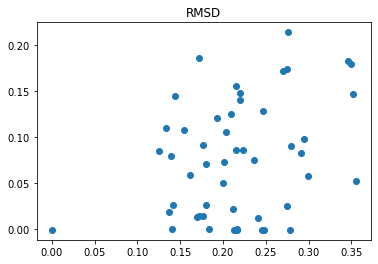

[H]c1c([H])c(-c2c([C@]([H])(OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C(=O)[O-])c(C([H])([H])[H])nc3c([H])c([H])c(Br)c([H])c23)c([H])c([H])c1Cl
tensor(0.0287)


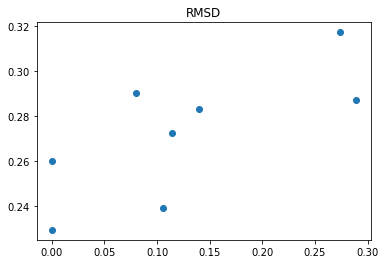

[H]O[C@@]([H])(C(=O)[O-])C([H])([H])C(=O)C([H])([H])C([H])([H])c1c([H])c(C(=O)c2c([H])c([H])c([H])c(F)c2[H])c([H])n1[H]
tensor(0.0118)


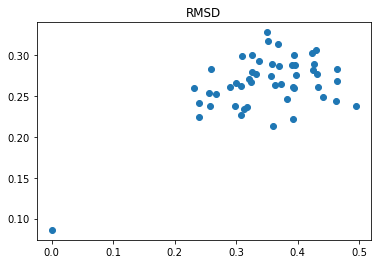

[H]c1nc(C(=O)N([H])c2c([H])c([H])c(F)c([C@@]3(C([H])([H])[H])N([H])C(=[N+]([H])[H])O[C@@]([H])(C(F)(F)F)C3([H])[H])c2[H])c([H])c([H])c1C#N
tensor(0.0119)


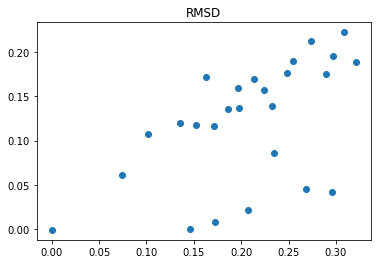

[H]c1nc([H])c(-c2c([H])c([H])c(N([H])C(=O)N([H])c3c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])nn3-c3c([H])c([H])c(C([H])([H])[H])c([H])c3[H])c([H])c2[H])c([H])c1[H]
tensor(0.0045)


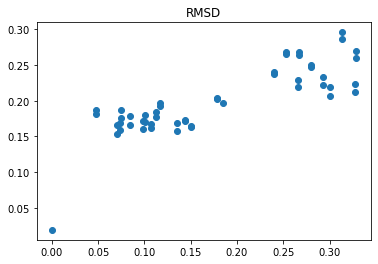

[H]c1c([H])c(C(=O)[C@]2([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])C([H])([H])N([H])C(=O)c3c([H])c(C#N)c(Cl)c([H])c3OC([H])([H])[H])C([H])([H])C2([H])[H])c([H])c([H])c1F
tensor(0.0104)


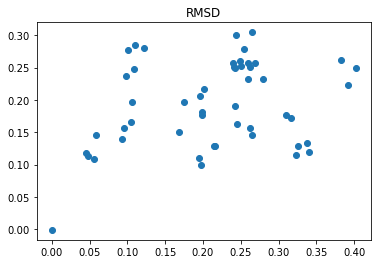

[H]c1c([H])c([H])c(C([H])([H])OC(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@@]([H])(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])S(=O)(=O)C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(0.0151)


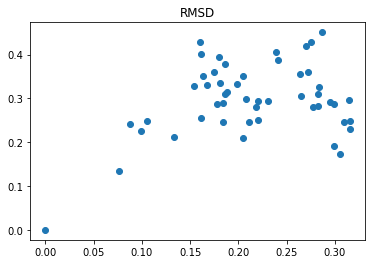

[H]c1c([H])c(C(=O)[O-])c([H])c(C(=O)N([H])c2c([H])c(C(=O)C([H])([H])[H])c([H])c([H])c2OC([H])([H])C([H])([H])[H])c1[H]
tensor(0.0109)


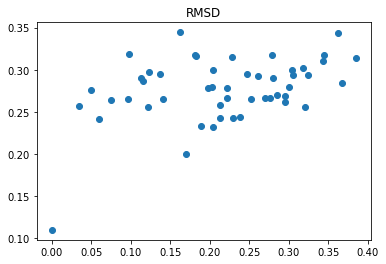

[H]c1nc(N2C([H])([H])C([H])([H])N(c3nnc(C([H])([H])[H])s3)C([H])([H])C2([H])[H])c2c([H])c(C([H])([H])C(F)(F)F)sc2n1
tensor(0.0175)


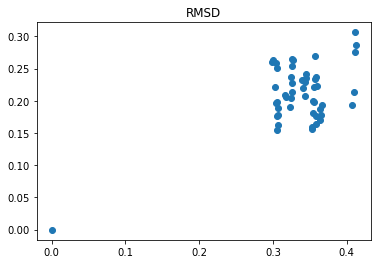

[H]O[C@]1([H])C(=C([H])[H])/C(=C([H])/C([H])=C2/C([H])([H])C([H])([H])C([H])([H])[C@@]3(C([H])([H])[H])[C@@]2([H])C([H])([H])C([H])([H])[C@]3([H])[C@]([H])(C([H])([H])[H])C([H])([H])[C@]2([H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])C(=O)[C@@](O[H])(C([H])([H])[H])C2([H])[H])C([H])([H])[C@@]([H])(O[H])C1([H])[H]
tensor(0.0200)


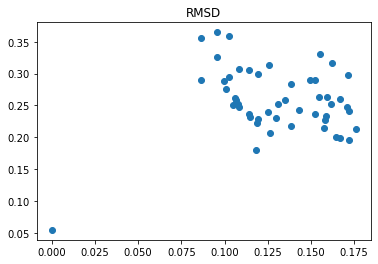

[H]Oc1c([H])c([H])c([H])c([H])c1C([H])([H])[H]
tensor(0.0228)


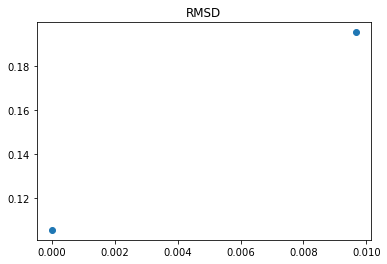

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(N([H])C(=O)C([H])([H])[H])[C@]([H])(N([H])C(=O)c3c([H])c([H])c([H])c(OC([H])([H])[H])c3[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(OC([H])([H])c2c([H])c([H])c([H])c(OC([H])([H])[H])c2[H])[C@@]1([H])O[H]
tensor(0.0048)


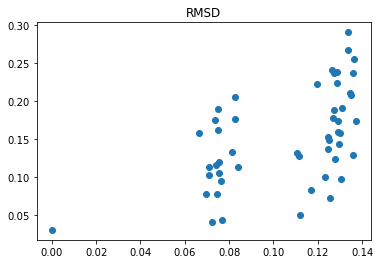

[H]c1sc(S(=O)(=O)N2C([H])([H])c3c(nn(-c4c([H])c([H])c([H])c([H])c4[H])c3C(=O)N([H])c3c([H])c([H])c(C(=O)OC([H])([H])C([H])([H])[H])c([H])c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0176)


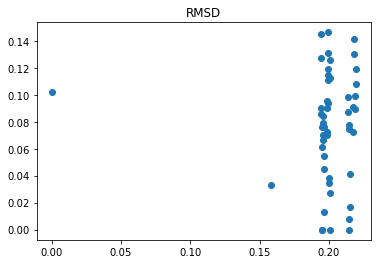

[H]OC1([H])C(c2c([H])c([H])c(Cl)c([H])c2Cl)=C([H])c2c([H])nc(N([H])c3c([H])c([H])c(N4C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C4([H])[H])c(F)c3[H])nc2N1C([H])([H])C([H])([H])[H]
tensor(0.0106)


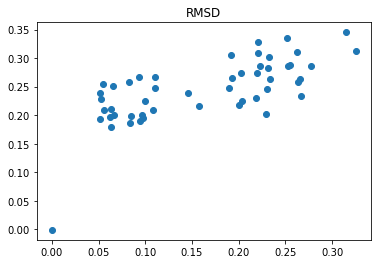

[H]c1c([H])c([H])c2c(c1[H])c(-c1nn(C([H])([H])[H])c(C(=O)[O-])c1[H])c([H])n2C([H])([H])C([H])([H])[H]
tensor(0.0131)


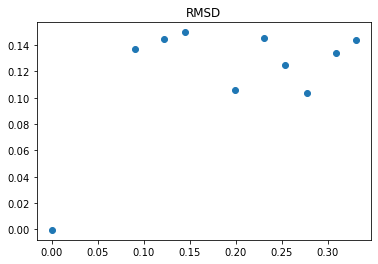

[H]Oc1c(-c2c([H])c([H])c([H])c([H])c2[H])c([H])c([H])c([H])c1-c1c([H])c2c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c2n1[H]
tensor(0.0055)


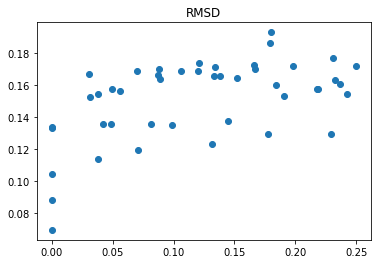

[H]c1c([H])c([H])c2c(c1[H])c1c([H])n2C([H])([H])C([H])([H])O[C@]([H])(C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])n2c([H])c(c3c([H])c([H])c([H])c([H])c32)C2=C1C(=O)N([H])C2=O
tensor(0.0140)


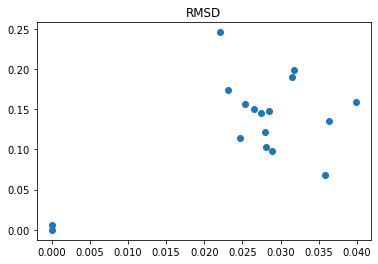

[H]c1c([H])c([H])c(C([H])([H])n2nnc(-c3on([H])c(=O)c3C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H])n2)c([H])c1[H]
tensor(0.0089)


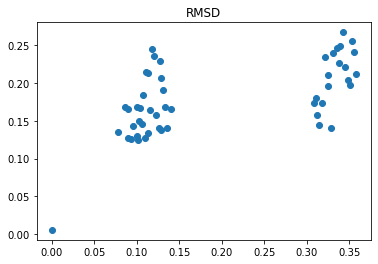

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])c([H])c(N([H])[H])nc2=O)C(F)(F)[C@]1([H])O[H]
tensor(0.0367)


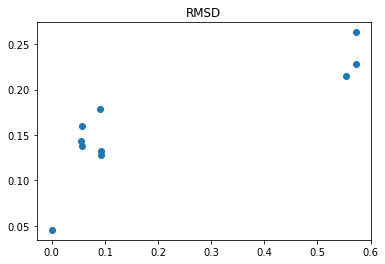

[H]OC([H])([H])[C@@]1([H])[C@@]([H])(O[H])C([H])(O[H])[C@]([H])(O[H])[C@]([H])(C([H])([H])O[H])[N+]1([H])[H]
tensor(0.0447)


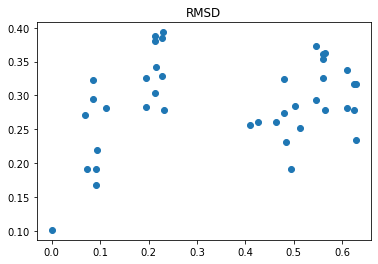

[H]c1c([H])c([H])c(/C(=C2/C(=O)N([H])c3c([H])c([H])c(N([H])[C@]4([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])C([H])([H])[H])C([H])([H])C4([H])[H])c([H])c32)c2nc3c([H])c(OC([H])([H])[H])c([H])c([H])c3n2[H])c([H])c1[H]
tensor(0.0034)


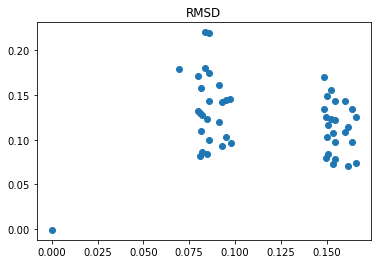

[H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(c2nc(=O)on2[H])N([H])C2=NC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c3c([H])c(Cl)c([H])c([H])c32)c([H])c1[H]
tensor(0.0099)


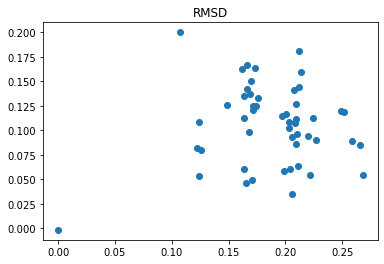

[H]C(=C(C(/[H])=C1/c2c([H])c([H])c([H])c([H])c2C([H])([H])C([H])([H])C1([H])[H])\C([H])([H])[H])/C([H])=C([H])/C(=C(\[H])C(=O)[O-])C([H])([H])[H]
tensor(0.0192)


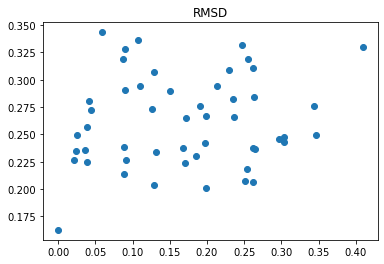

[H]c1c([H])c([H])c2c(c1[H])C(=O)N(C([H])([H])[C@]1([H])c3c([H])c([H])c([H])c(C([H])([H])[H])c3C([H])([H])C([H])([H])N1C(=O)[C@]1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@]1([H])C(=O)[O-])C2([H])[H]
tensor(0.0295)


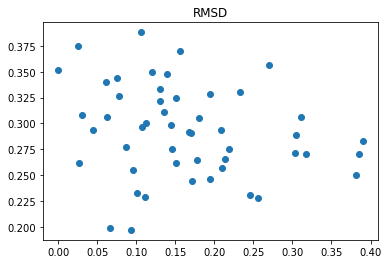

[H]c1nc([H])c([H])c(-c2c([H])c(N([H])C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])nn2[H])c1[H]
tensor(0.0183)


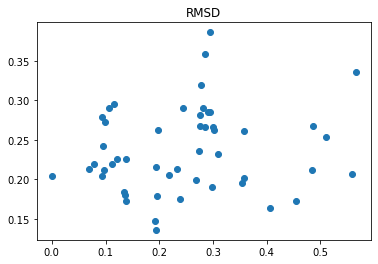

[H]c1c(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c2oc(=O)c([H])c(C([H])([H])[H])c2c1[H]
tensor(0.0014)


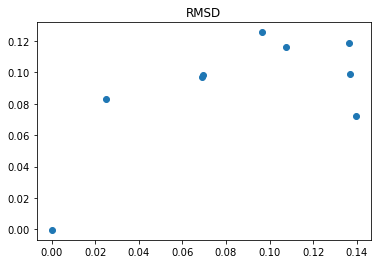

[H]c1c([H])c([H])c([C@@]([H])(C([H])([H])[H])C([H])([H])n2nnc(C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C(=O)N([H])c3c([H])c([H])c([H])c(C(=O)N([H])[H])c3[H])c2[H])c([H])c1[H]
tensor(0.0136)


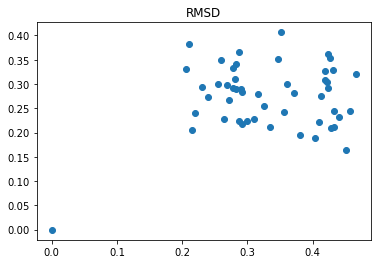

[H]O[C@@]1([H])C([H])([H])N(C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])[H])[C@]([H])(C(=O)N([H])C([H])([H])c2c([H])c([H])c(-c3sc([H])nc3C([H])([H])[H])c([H])c2[H])C1([H])[H]
tensor(0.0096)


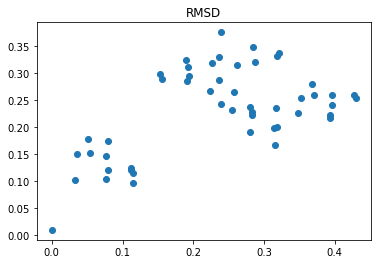

[H]c1c([H])c([H])c(N([H])C(=O)[C@@]([H])(n2c(-c3c([H])c([H])c(Cl)c([H])c3[H])nc3c([H])c(F)c(F)c([H])c32)C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0083)


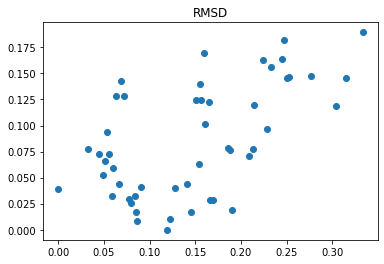

[H]O[C@]1([H])C(=O)N(C([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c2c([H])c([H])c([H])c([H])c21
tensor(0.0301)


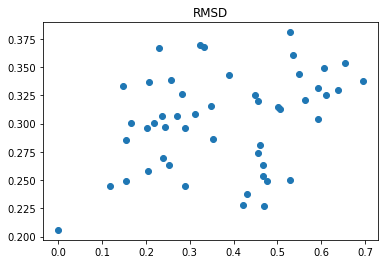

[H]O[C@@]1([H])C([H])([H])N(C(=S)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])[H])[C@]([H])(C(=O)N([H])C([H])([H])c2c([H])c([H])c(-c3sc([H])nc3C([H])([H])[H])c([H])c2[H])C1([H])[H]
tensor(0.0171)


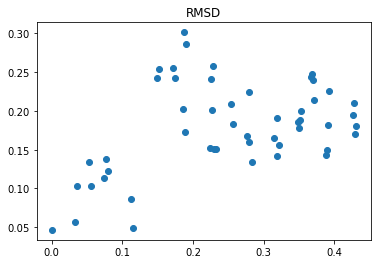

[H]Oc1c([H])c(O[H])c(-c2c(N3C([H])([H])C([H])([H])[N+]([H])(C([H])([H])c4c([H])c([H])c(S(=O)(=O)C([H])([H])[H])c([H])c4[H])C([H])([H])C3([H])[H])c([H])nn2[H])c([H])c1Cl
tensor(0.1527)


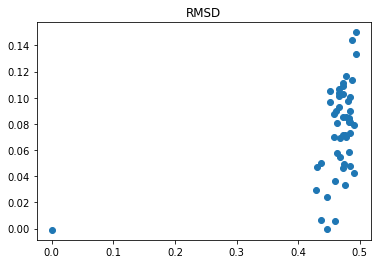

[H]c1nc(N([H])c2c([H])c([H])c(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c2[H])nc(-c2sc(N([H])[H])nc2C([H])([H])[H])c1[H]
tensor(0.0101)


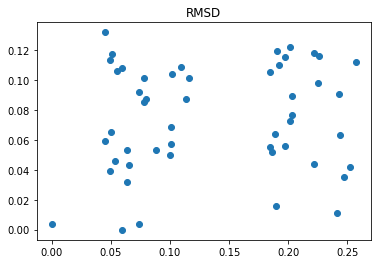

[H]c1sc(-c2c([H])c([H])c(Cl)c([H])c2[H])nc1C([H])([H])Oc1c([H])c([H])c(C([H])([H])[C@]([H])(OC([H])([H])C([H])([H])[H])C(=O)[O-])c(C([H])([H])[H])c1[H]
tensor(0.0170)


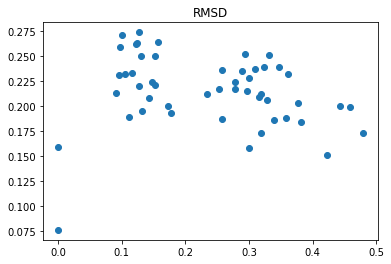

[H]O/N=C1\C(=O)N(C([H])([H])c2c([H])c(F)c([H])c3c2OC([H])([H])OC3([H])[H])c2c([H])c([H])c([H])c(/C([H])=C(\[H])c3c([H])c([H])c([H])c([H])c3[H])c21
tensor(0.0035)


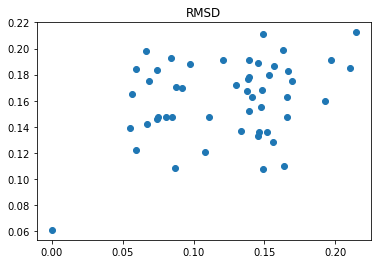

[H]c1nc(N2C([H])([H])C([H])([H])N(C(=O)[C@@]([H])(C([H])([H])c3c([H])n([H])c4c([H])c([H])c([H])c([H])c34)[N+]([H])([H])[H])C([H])([H])C2([H])[H])c2c(n1)C([H])([H])S[C@@]2([H])C([H])([H])[H]
tensor(0.0073)


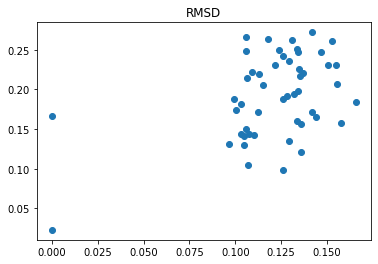

[H]c1c2nc(N([H])C([H])([H])[H])n([H])c2c(C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c2nc([H])n([H])c(=O)c12
tensor(0.0157)


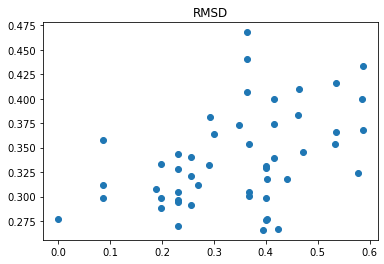

[H]Oc1c([H])c([H])c(/N=N/c2c(N([H])[H])nn([H])c2N([H])[H])c([H])c1[H]
tensor(0.0241)


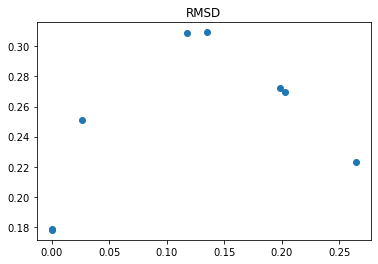

[H]C(=O)c1c([H])c(N([H])[H])c([H])c([H])c1C([H])([H])C(=O)OC([H])([H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0083)


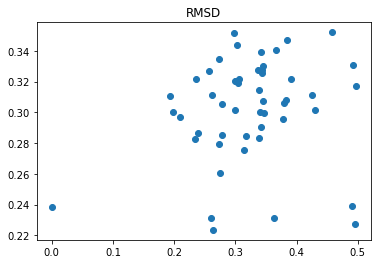

[H]c1sc(-c2c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])C([H])([H])F)c2[H])nc1C([H])([H])Sc1nc(N([H])[H])c([H])c(N([H])[H])n1
tensor(0.0161)


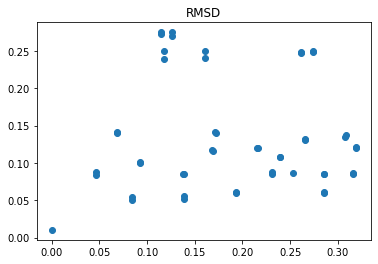

[H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])Oc1c([H])c(-c2nc(C([H])([H])Sc3nc(N([H])[H])nc(N([H])[H])c3[H])c(C([H])([H])C([H])([H])C([H])([H])[H])s2)c([H])c([H])c1OC([H])([H])[H]
tensor(0.0117)


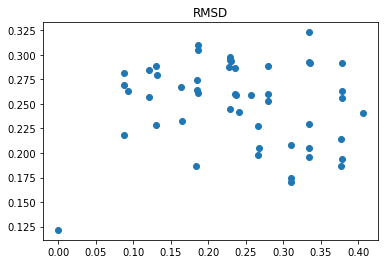

[H]c1nn(C([H])([H])[H])c([H])c1-c1c([H])c([H])c2c(c1[H])[C@@](C([H])([H])[H])(C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])C(=O)N2[H]
tensor(0.0027)


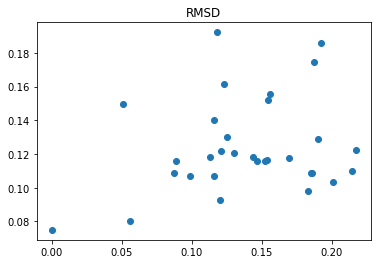

[H]c1nc2nc(N([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c(N([H])c3c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c3[H])n2n1
tensor(0.0124)


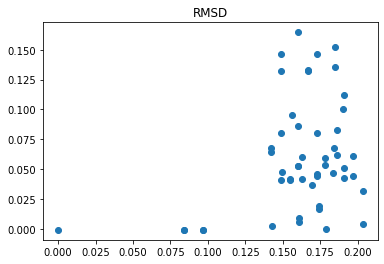

[H]ON([H])C(=O)[C@]([H])(O[H])[C@]([H])(O[H])C([H])([H])SC([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H]
tensor(0.0198)


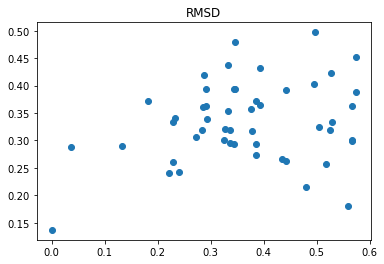

[H]C1=C2c3c([H])c4c(c([H])c3C([H])([H])C([H])([H])N2C([H])([H])c2c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c([H])c21)OC([H])([H])O4
tensor(0.0141)


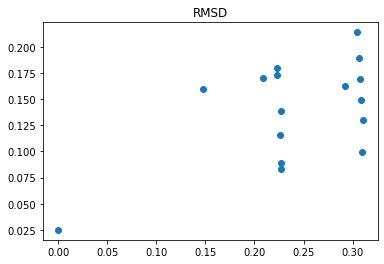

[H]c1nc(N([H])c2nc([H])nn2[H])c([H])c(N([H])C([H])([H])C([H])([H])c2sc(N([H])C(=O)N([H])c3c(C(F)(F)F)oc(C([H])([H])[H])c3[H])nc2[H])n1
tensor(0.0100)


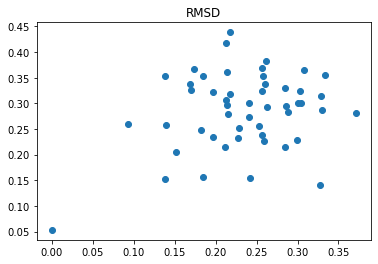

[H]OC1([H])C(=O)C(=O)C([H])=C(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1[H]
tensor(0.0135)


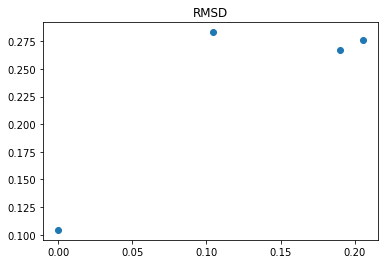

[H]O[C@@]([H])(C(=O)N([H])C([H])([H])c1sc([H])c([H])c1[H])[C@@]([H])(O[H])C(=O)N1C([H])([H])C([H])([H])C([H])([H])[C@]1([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0246)


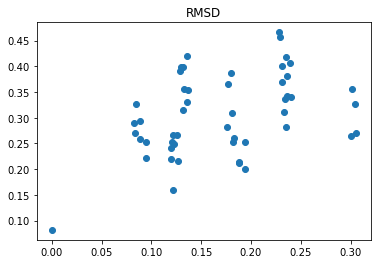

[H]c1nc([H])n(C([H])([H])[H])c1C([H])([H])N1c2c([H])c([H])c(C#N)c([H])c2C([H])([H])N(S(=O)(=O)c2c([H])c([H])c(OC([H])([H])[H])c([H])c2[H])[C@]([H])(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])C1([H])[H]
tensor(0.0034)


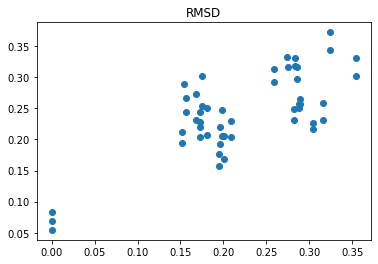

[H]Oc1c([H])c(-c2c([H])c([H])c([H])c(C#N)c2[H])c([H])n([H])c1=O
tensor(0.0546)


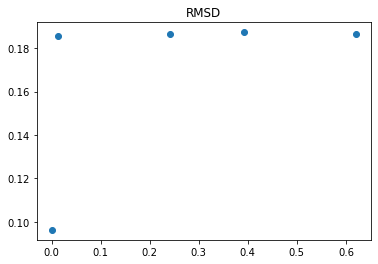

[H]OC([H])([H])C([H])([H])Sc1c(F)c(F)c(S(=O)(=O)N([H])[H])c(N([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c1F
tensor(0.0293)


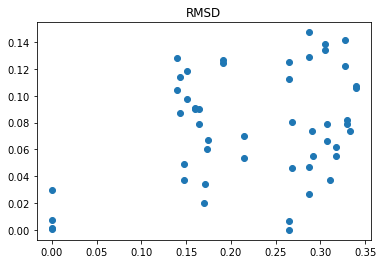

[H]c1nc([H])c2c([H])c(C#CC([H])([H])Oc3c([H])c([H])c(C([H])([H])[N+]4([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C4([H])[H])c(OC([H])([H])[H])c3[H])c([H])c([H])c2c1[H]
tensor(0.0234)


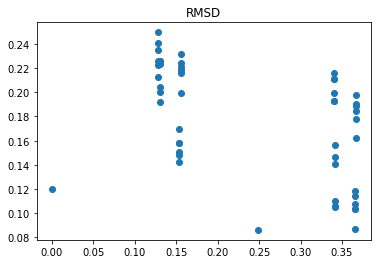

[H]OC([H])([H])[C@@]1([H])O[C@]([H])(S(=O)(=O)N2C([H])([H])C([H])([H])C([H])(OS(=O)(=O)N([H])[H])C([H])([H])C2([H])[H])[C@]([H])(OC(=O)C([H])([H])[H])[C@]([H])(O[H])[C@@]1([H])O[H]
tensor(0.0220)


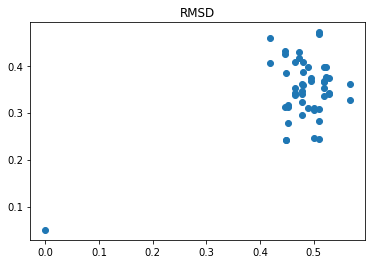

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c(N([H])C([H])([H])c3c([H])c([H])c4nc([H])c([H])c([H])c4c3[H])nc3c(N([H])[H])nc([H])nc32)[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0090)


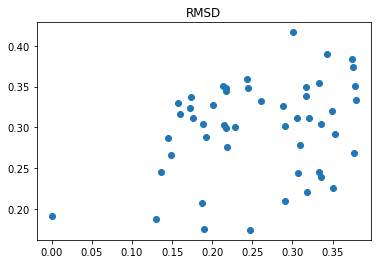

[H]O[C@]1(C([H])([H])[H])C([H])([H])C([H])([H])[C@@]([H])(N([H])C(=O)c2c([H])c([H])c([H])c(N([H])c3nc([H])c(C(=O)N([H])c4c(Cl)c([H])c([H])c([H])c4C([H])([H])[H])s3)c2[H])C([H])([H])C1([H])[H]
tensor(0.0061)


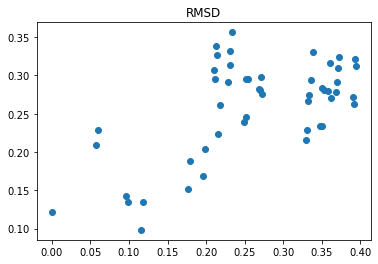

[H]Oc1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c(O[H])c([H])c(O[H])c2[H])c(Cl)c1[H]
tensor(0.0032)


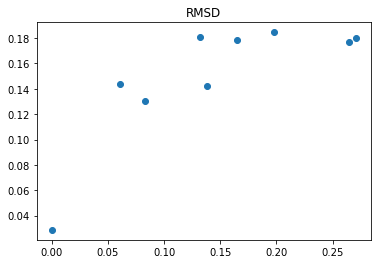

[H]c1nn([C@]2([H])C([H])([H])N(C(=O)c3c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])nn3[H])C([H])([H])C2([H])[H])c([H])c1Br
tensor(0.0160)


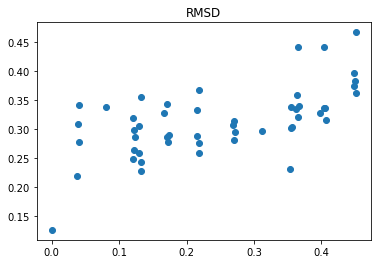

[H]C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.1082)


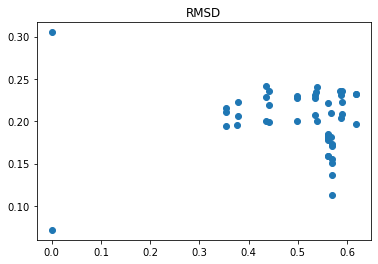

[H]c1c(Cl)c([H])c2c(OC3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c(C([H])([H])C([H])([H])C([H])([H])[H])c(=O)n([H])c2c1[H]
tensor(0.0180)


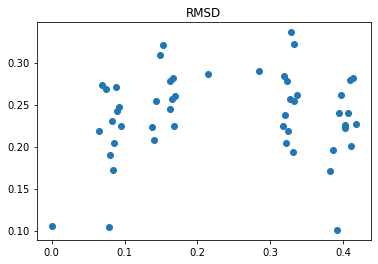

[H]Oc1c([H])c([H])c(C2(c3c([H])c([H])c(O[H])c(Cl)c3[H])OC(=O)c3c([H])c([H])c([H])c4c([H])c([H])c([H])c2c34)c([H])c1Cl
tensor(0.0094)


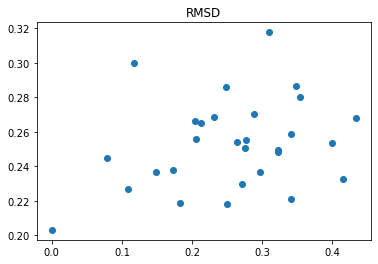

[H]O[C@@]1([H])C([H])=C([H])[C@]23c4c(c(OC([H])([H])[H])c([H])c([H])c4C([H])=[N+](C([H])([H])[H])C([H])([H])C2([H])[H])O[C@@]3([H])C1([H])[H]
tensor(0.0035)


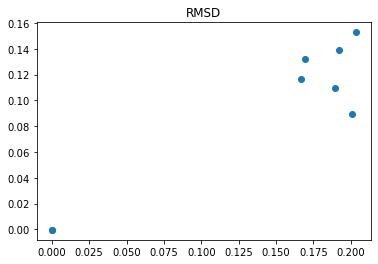

[H]Oc1c([H])c([H])c(N([H])S(=O)(=O)c2c([H])c(Cl)c([H])c([H])c2Cl)c([H])c1-c1c(O[H])c([H])c([H])c2c([H])c([H])c([H])c([H])c12
tensor(0.0134)


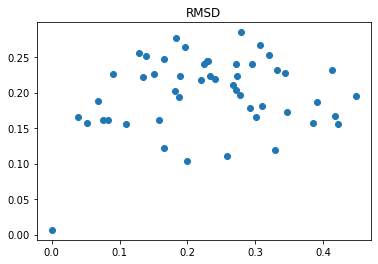

[H]O[C@]([H])(C([H])([H])[N+]([H])([H])C([H])([H])c1c([H])c([H])c([H])c(C([H])([H])[H])c1[H])[C@@]([H])(N([H])C(=O)C1=C([H])c2c([H])c([H])c([H])c([H])c2Oc2c([H])c([H])c([H])c([H])c21)C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0066)


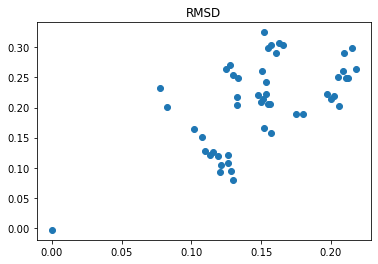

[H]OC([H])([H])[C@]([H])(O[H])C([H])([H])Oc1c([H])c([H])c([H])c(C(=O)c2c([H])nn(-c3c([H])c([H])c(F)c([H])c3[H])c2N([H])[H])c1[H]
tensor(0.0067)


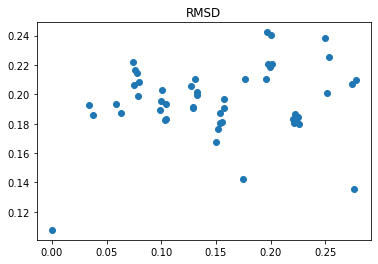

[H]Oc1c([H])c([H])c2c(c1[H])SC([H])(c1c([H])c([H])c(N(C([H])([H])[H])C([H])([H])[H])c([H])c1[H])N2C([H])([H])[H]
tensor(0.0005)


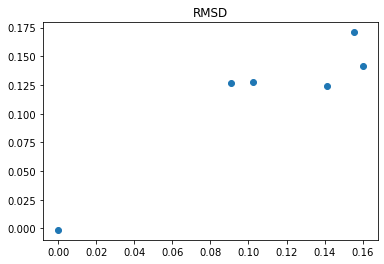

[H]c1c([H])c(Br)c([H])c([C@]2([H])N=C(c3c([H])c([H])c(OC([H])([H])[H])c([H])c3OC([H])(C([H])([H])[H])C([H])([H])[H])N(C(=O)N3C([H])([H])C(=O)N([H])C([H])([H])C3([H])[H])[C@]2([H])c2c([H])c([H])c(Cl)c([H])c2[H])c1F
tensor(0.0053)


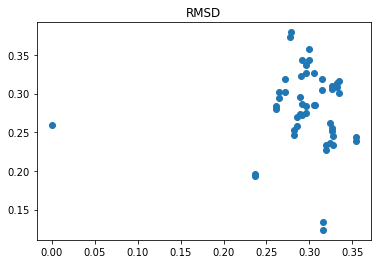

[H]c1c([H])c([H])c(-c2c([H])c([H])c(-c3c([H])c([H])c(Oc4c([H])c([H])c(C(=O)C([H])([H])[H])c([H])c4[H])c([H])c3[H])n2C([H])([H])C(=O)N([H])C(N([H])[H])=[N+]([H])[H])c(Cl)c1[H]
tensor(0.0217)


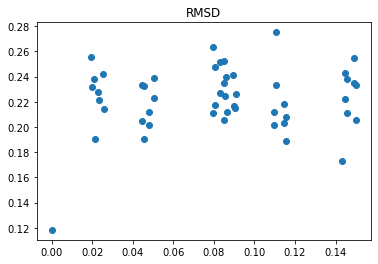

[H]c1nc(N([H])c2c([H])c([H])c(OC([H])([H])c3c([H])c([H])c([H])c(F)c3[H])c(Cl)c2[H])c2c([H])c([H])c([H])c([H])c2n1
tensor(0.0023)


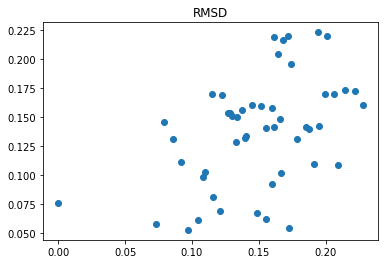

[H]C([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.1202)


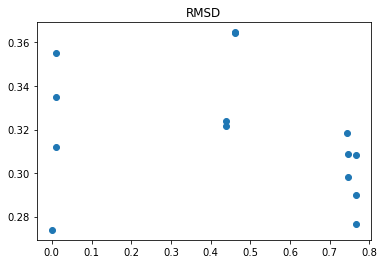

[H]OC1([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])C2([H])C([H])([H])C([H])(N([H])C(=O)C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C2([H])[N+]1([H])[H]
tensor(0.6531)


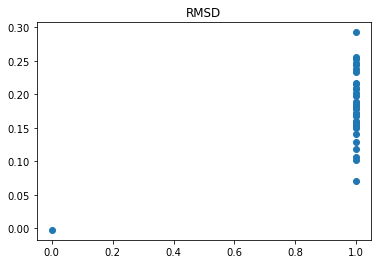

[H]c1c([H])c([H])c(C([H])([H])[N@+]2([H])C([H])([H])C([H])([H])[C@@]([H])(N([H])c3nc(N4C([H])([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C4([H])[H])nc4c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c34)C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0032)


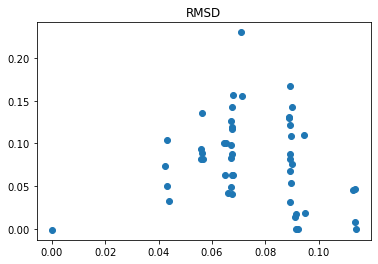

[H]Oc1c(Br)c([H])c(C(c2c([H])c(Br)c(O[H])c(Br)c2[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1Br
tensor(0.0216)


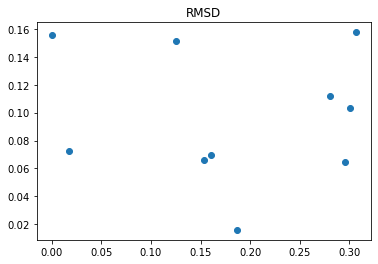

[H]c1nc(N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])c3c(C([H])([H])[H])n([H])c4c([H])c([H])c([H])c([H])c34)C([H])([H])C2([H])[H])c([H])c([H])c1[H]
tensor(0.0421)


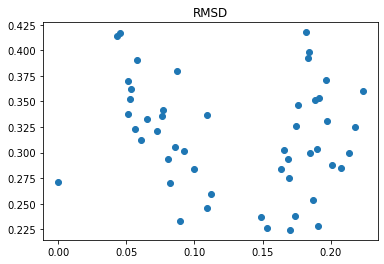

[H]Sc1nnc(N([H])C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])s1
tensor(0.0155)


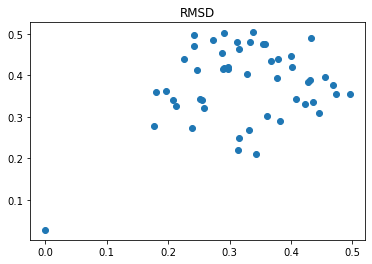

[H]OC([H])([H])[C@@]([H])(C([H])=O)[C@]([H])(O[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])C(=O)[O-]
tensor(0.0108)


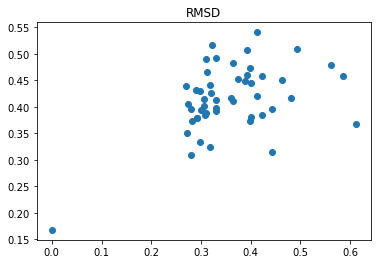

[H]c1c([H])c(C([H])([H])[H])c([H])c([H])c1-n1nc(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1N([H])C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])[N+]1([H])C([H])([H])C([H])([H])OC([H])([H])C1([H])[H]
tensor(0.0093)


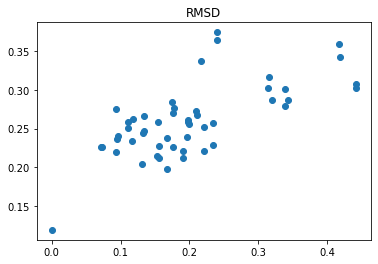

[H]c1nc(N([H])[H])c2c(C([H])([H])Oc3c([H])c([H])c([H])c(Cl)c3[H])nn(C3([H])C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c2n1
tensor(0.0139)


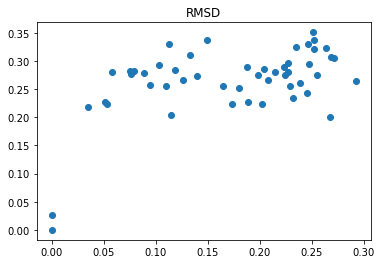

[H]Oc1c([H])c([H])c(S(=O)(=O)n2c([H])c3c([H])c([H])c([H])c([H])c3c2[H])c(O[H])c1[H]
tensor(0.0307)


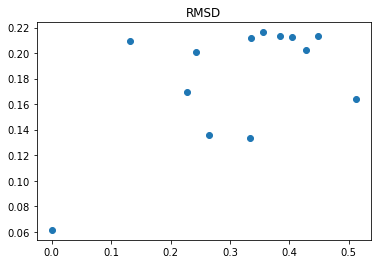

[H]Oc1c([H])c([H])c2c(C([H])([H])[H])c([H])c(=O)oc2c1C([H])([H])[N+]([H])([H])[C@]([H])(C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0169)


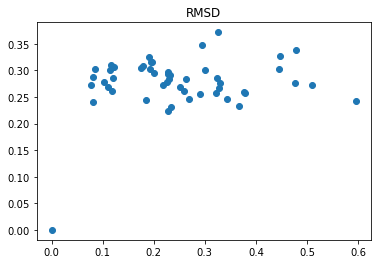

[H]ON([H])C(=O)[C@@]([H])(c1c([H])c([H])c(-n2nc([H])c([H])c2[H])c([H])c1[H])N([H])C(=O)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0040)


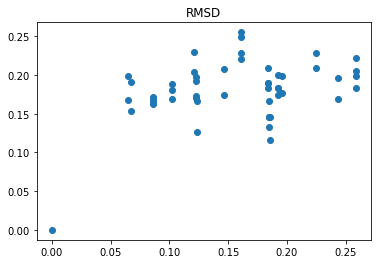

[H]c1c([N+](=O)[O-])c([H])c2sc(N([H])C(=O)C([H])([H])[H])nc2c1[H]
tensor(0.0234)


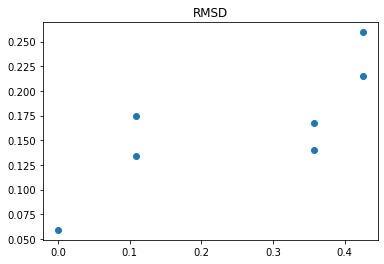

[H]O[C@]([H])(C([H])([H])[H])[C@@]([H])(C(=O)N1C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@@]1([H])C(=O)O[C@@]([H])(c1c([H])c([H])c([H])c(OC([H])([H])C([H])([H])[N+]2([H])C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])c1[H])C([H])([H])C([H])([H])c1c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c1[H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0079)


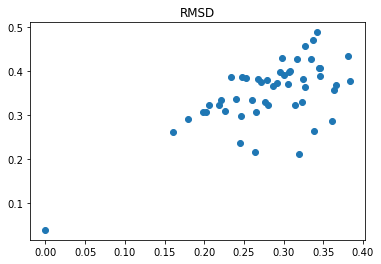

[H]c1c([H])c(C(=O)C([H])([H])Sc2nc3c(c(=O)n([H])c(=[N+]([H])[H])n3[H])n2[H])c([H])c([H])c1Br
tensor(0.0174)


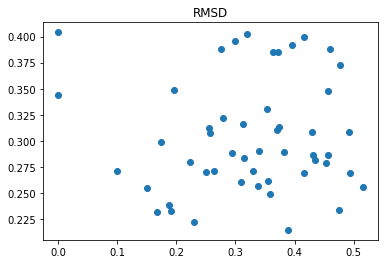

[H]c1c([H])c(C([H])([H])C([H])([H])N([H])C(=O)[C@@]2([H])N(C(=O)N([H])C([H])([H])c3c([H])c([H])c([H])c4c([H])c([H])c([H])c([H])c34)C([H])([H])C([H])([H])C2([H])[H])c([H])c([H])c1OC([H])([H])[H]
tensor(0.0064)


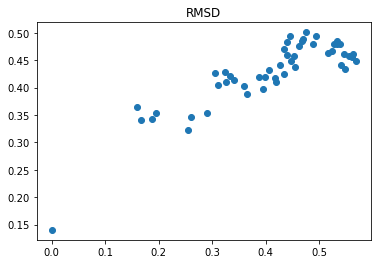

[H]C1=C([H])N(C([H])([H])c2c([H])c([H])c(OC([H])([H])C([H])([H])Oc3c([H])c([H])c(C([H])([H])n4c([H])c([H])c(=[N+](C([H])([H])[H])C([H])([H])[H])c([H])c4[H])c([H])c3[H])c([H])c2[H])C([H])([H])C([H])=C1N(C([H])([H])[H])C([H])([H])[H]
tensor(0.0091)


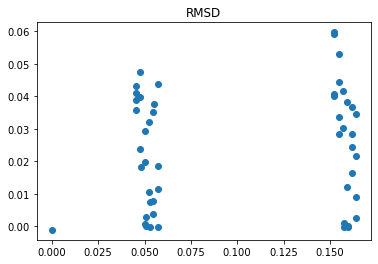

[H]c1c([H])c(N([H])C(=O)c2c(C([H])([H])[H])c(S(=O)(=O)N([H])c3c([H])c([H])c4c([H])n([H])nc4c3[H])c(C([H])([H])[H])n2[H])c([H])c([H])c1F
tensor(0.0243)


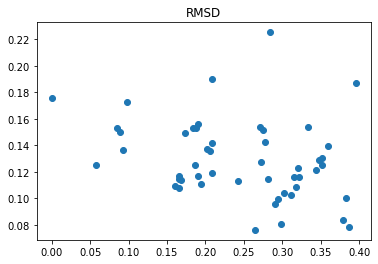

[H]c1c([H])c(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])c2nonc2c1N([H])[H]
tensor(0.0132)


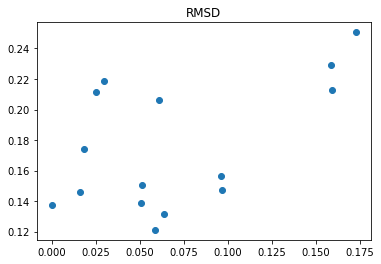

[H]c1nc(N2C([H])([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])Oc2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.0165)


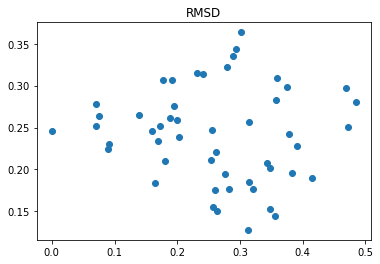

[H]c1c([H])c(C(=O)N([H])[H])c([H])c(N([H])C(=O)C([H])([H])C([H])([H])C(=O)N2C([H])([H])C([H])([H])N(c3c([H])c([H])c(F)c([H])c3[H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0163)


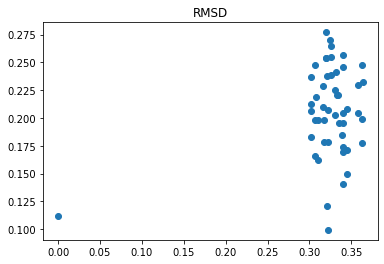

[H]c1c([H])c([H])c(N([H])[H])c(-c2nc3c([H])c([H])c([H])c([H])c3c(=O)n2[H])c1[H]
tensor(0.0146)


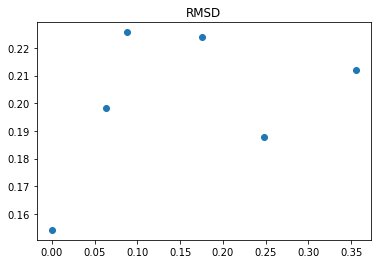

[H]Oc1c([H])c([H])c2oc(-c3c([H])c([H])c([H])c([H])c3[H])c(C(=O)OC([H])([H])C([H])([H])[H])c2c1C([H])([H])[N+]1([H])C([H])([H])C([H])([H])OC([H])([H])C1([H])[H]
tensor(0.0095)


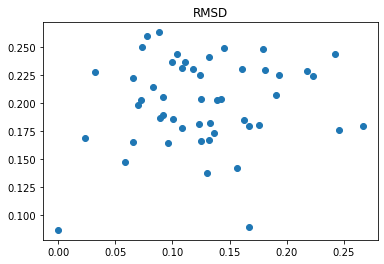

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)OC([H])([H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@@]1([H])C(=O)N([H])C([H])([H])C1([H])[H]
tensor(0.0071)


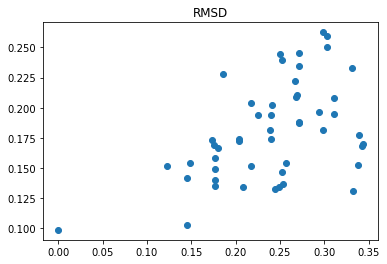

[H]c1c(Cl)c([H])c2c(N([H])c3nc([H])n(C([H])([H])[H])c3[H])nc(N3C([H])([H])C([H])([H])C([H])([N+]([H])([H])[H])C([H])([H])C3([H])[H])nc2c1[H]
tensor(0.0032)


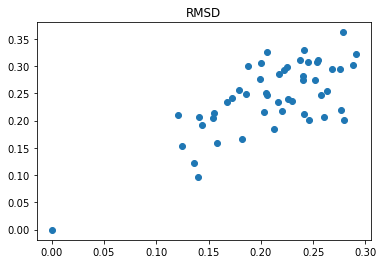

[H]c1c([H])c(C([H])([H])C([H])([H])Sc2c(F)c(F)c(S(=O)(=O)N([H])[H])c(N([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c2F)c([H])c([H])c1C(=O)[O-]
tensor(0.0696)


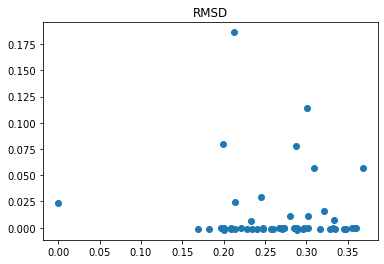

[H]c1c([H])c(C([H])([H])[C@]([H])(C(=O)N2C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])N([H])C(=O)C([H])([H])N([H])S(=O)(=O)c2c([H])c([H])c3c([H])c([H])c([H])c([H])c3c2[H])c([H])c([H])c1C(N([H])[H])=[N+]([H])[H]
tensor(0.0039)


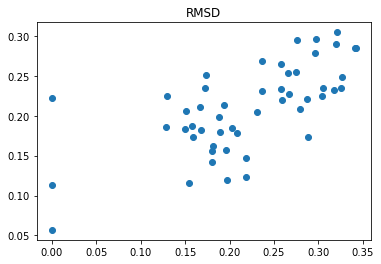

[H]c1c(C(=O)[O-])oc(-c2c([H])c(Cl)c([H])c([H])c2Cl)c1[H]
tensor(0.0541)


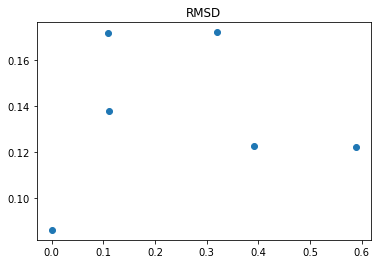

[H]c1c([H])c(C([H])([H])C([H])([H])N(c2nc3c([H])c([H])c([H])c([H])c3o2)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c([H])c1O[C@](C(=O)[O-])(C([H])([H])[H])C([H])([H])C([H])([H])[H]
tensor(0.0187)


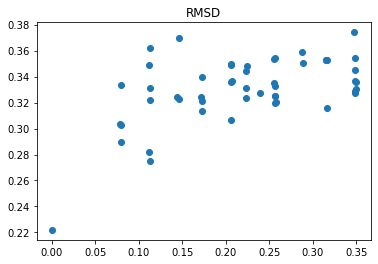

[H]O[C@]([H])(C(=O)N1C([H])([H])SC(C([H])([H])[H])(C([H])([H])[H])[C@@]1([H])C(=O)N([H])[C@@]1([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[C@@]1([H])O[H])[C@@]([H])(N([H])C(=O)C([H])([H])Oc1c(C([H])([H])[H])c([H])c([H])c([H])c1C([H])([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0167)


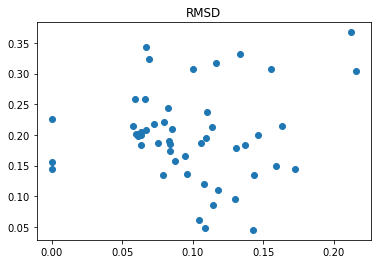

[H]OC([H])([H])C([H])([H])N(C(=O)N([H])c1c([H])c([H])c([H])c([H])c1F)C([H])([H])c1c([H])c2c([H])c(C([H])([H])[H])c([H])c([H])c2n([H])c1=O
tensor(0.0336)


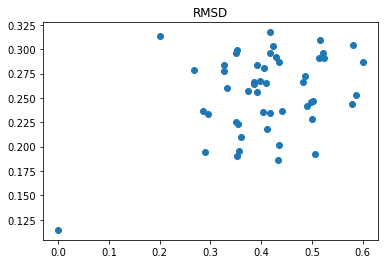

[H]c1nc(N([H])c2c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])[N@+]3([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c2[H])c(C(=O)N([H])[H])nc1-c1c([H])c([H])c(C([H])([H])[H])c(C([H])([H])[H])c1[H]
tensor(0.0033)


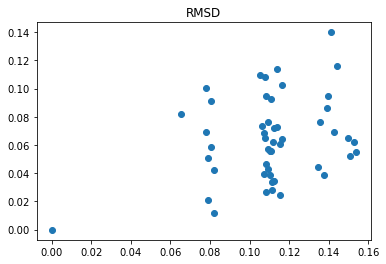

[H]c1c([H])c([H])c2c([H])c([H])c(C([H])([H])Oc3c([H])c([H])c4sc(C([H])([H])[H])nc4c3[H])nc2c1[H]
tensor(0.0127)


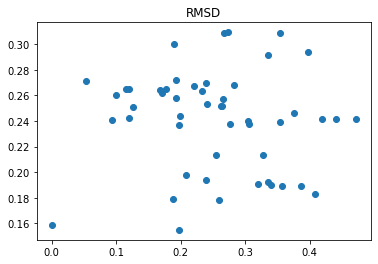

[H]c1c([H])c(-n2c3c(c4c2C([H])([H])[N@+]([H])(C([H])([H])[H])C([H])([H])C4([H])[H])C(=O)C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C3([H])[H])c([H])c([H])c1C(=O)N([H])[H]
tensor(0.0074)


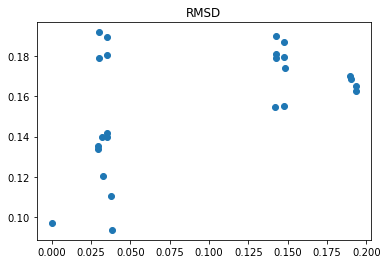

[H]c1nc(N([H])[H])c2c(-c3c([H])c([H])c(Oc4c([H])c([H])c([H])c([H])c4[H])c([H])c3[H])c([H])n([C@]3([H])C([H])([H])C([H])([H])[C@@]([H])([N+]([H])([H])[C@]([H])(C(=O)N(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C3([H])[H])c2n1
tensor(0.0025)


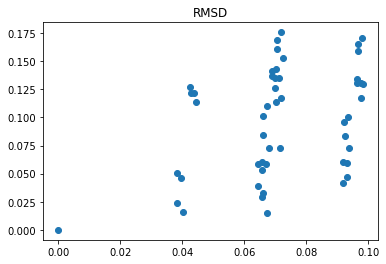

[H]c1nc2c(nc([H])n2[H])c(=O)n1[H]
tensor(0.0172)


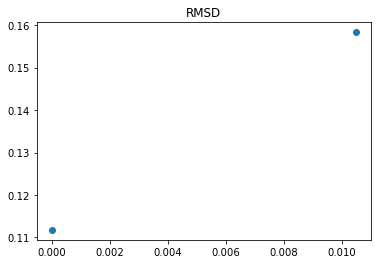

[H]O[C@@]1([H])C([H])([H])[C@@]([H])(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C([H])([H])[C@]1([H])c1c([H])c([H])c(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])c([H])c1[H]
tensor(0.0265)


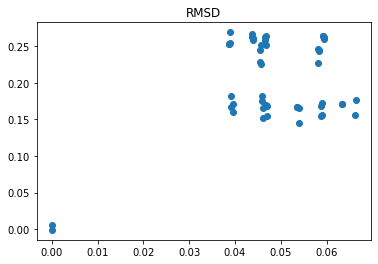

[H]N([H])C(N([H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=O)[C@@]1([H])N(C(=O)[C@@]([H])(C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])[N+]([H])([H])C([H])([H])C(=O)[O-])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])=[N+]([H])[H]
tensor(0.0020)


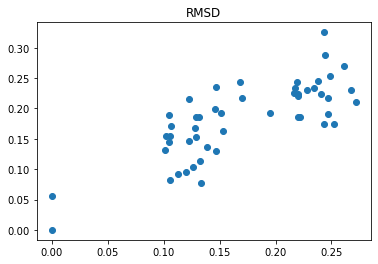

[H]OC([H])([H])[C@]([H])(n1c([H])nc(C(=O)N([H])[H])c1[H])C([H])([H])C([H])([H])c1c([H])c([H])c([H])c2c([H])c([H])c([H])c([H])c12
tensor(0.0110)


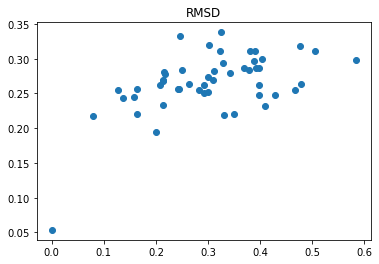

[H]Oc1c([H])c(O[H])c(C([H])([H])C([H])([H])[H])c([H])c1-c1nn([H])c(C(=O)[O-])c1-c1c([H])c([H])c2c(c1[H])OC([H])([H])O2
tensor(0.0113)


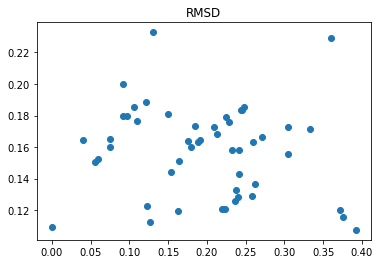

[H]c1c(C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])C([H])([H])C(=O)[O-])sc(N(C([H])([H])[H])C([H])([H])c2c([H])c([H])c3nc(C([H])([H])[H])n([H])c(=O)c3c2[H])c1[H]
tensor(0.0268)


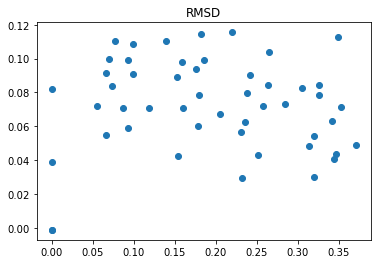

[H]c1c([H])c(OC([H])([H])[H])c([H])c(-c2c([H])c([H])c([H])c([C@@]3(C([H])([H])[H])N([H])C(=[N+]([H])[H])N(C([H])([H])[H])C(=O)C3([H])[H])c2[H])c1[H]
tensor(0.0097)


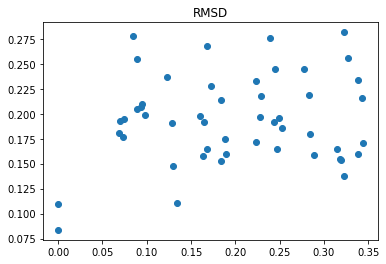

[H]OC(O[H])(C([H])([H])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])c1c([H])n([H])c2c([H])c([H])c([H])c([H])c12)[C@@]([H])(N([H])C(=O)c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0117)


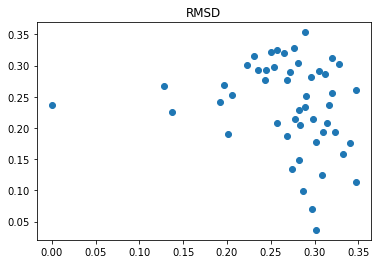

[H]c1sc(-c2sc(C(=O)OC([H])([H])[H])c(N([H])C(=O)C([H])([H])C([H])([H])C(=O)[O-])c2[H])c([H])c1[H]
tensor(0.0084)


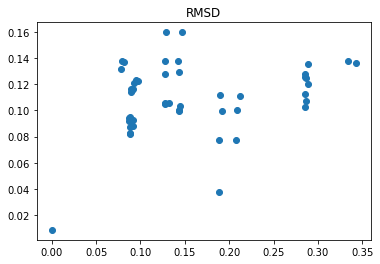

[H]c1c([H])c([H])c(C([H])([H])Oc2c([H])c([H])n(C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c(=O)c2Br)c([H])c1[H]
tensor(0.0063)


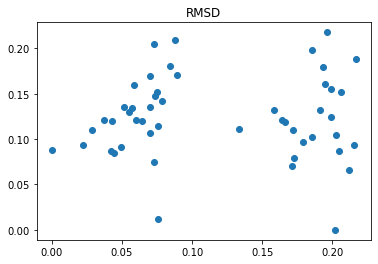

[H]c1c(OS(=O)(=O)N([H])[H])c(C([H])([H])C([H])([H])[H])c([H])c2c1C([H])([H])C([H])([H])[C@]1([H])[C@]2([H])C([H])([H])C([H])([H])[C@]2(C([H])([H])[H])[C@@]([H])(OS(=O)(=O)N([H])[H])C([H])([H])C([H])([H])[C@]21[H]
tensor(0.0035)


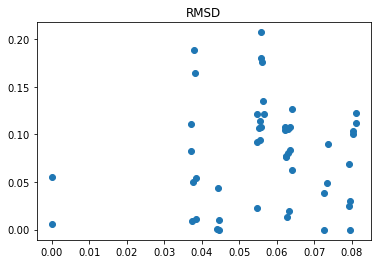

[H]Oc1c([H])c([H])c2c(c1[H])c([H])c([H])c1c2c2c(Cl)nc([H])c(C([H])([H])[H])c2n1[H]
tensor(0.0080)


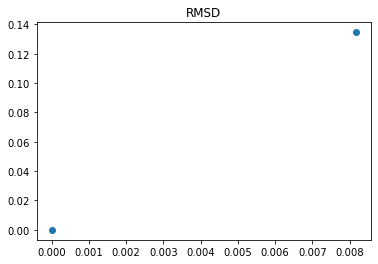

[H]O[C@@]1([H])C([H])([H])N(C(=O)c2c([H])c([H])c([H])c(N([H])[H])c2C([H])([H])[H])[C@]([H])(C(=O)N([H])C([H])([H])c2c([H])c([H])c(-c3sc([H])nc3C([H])([H])[H])c([H])c2[H])C1([H])[H]
tensor(0.0211)


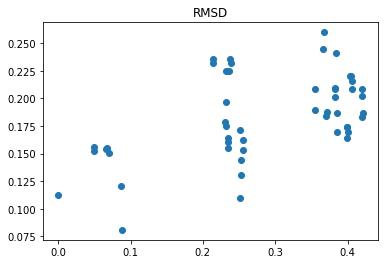

[H]OC([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H]
tensor(0.0029)


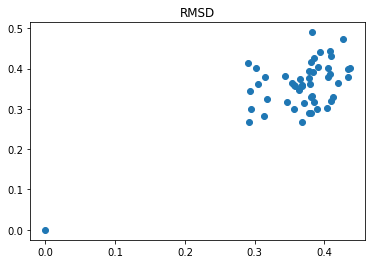

[H]c1nc(N([H])[H])c(C(=O)N([H])C([H])([H])C2([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])nc1-c1c([H])c([H])c([H])c(N([H])S(=O)(=O)C([H])([H])[H])c1[H]
tensor(0.0082)


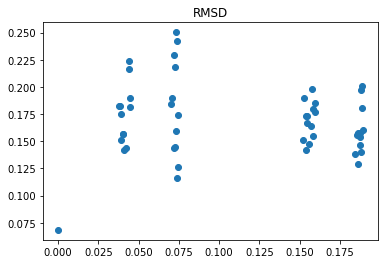

[H]c1nc(-c2nc(N([H])C([H])([H])C([H])([H])N([H])c3nc([H])c(C(F)(F)F)c([H])c3[H])c(Cl)c(C([H])([H])[H])n2)c([H])c([H])c1[H]
tensor(0.0106)


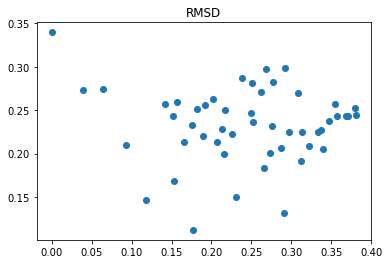

[H]c1c([H])c([H])c(Oc2c([H])c([H])c(N(C(=O)[C@]3([H])C([H])([H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])c(C(=O)[O-])c2[H])c([H])c1[H]
tensor(0.0073)


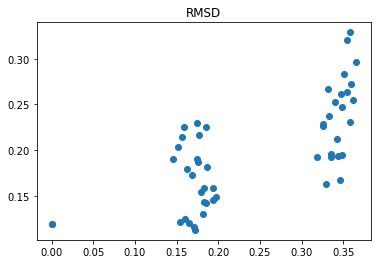

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(O[H])[C@@]([H])(O[H])[C@@]2([H])O[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0044)


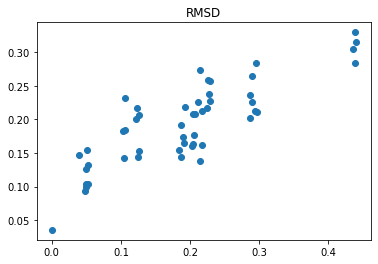

[H]c1nc(N2C([H])([H])C([H])([H])N(C3=NC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])S3)C([H])([H])C2([H])[H])c2c([H])c(C(F)(F)C(F)(F)F)sc2n1
tensor(0.1471)


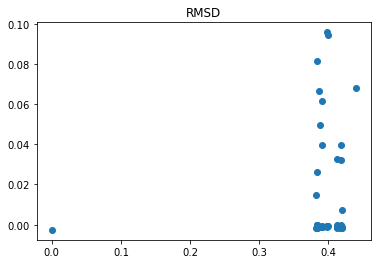

[H]c1c([H])c([H])c(S(=O)(=O)N(C([H])([H])[H])C([H])([H])c2c([H])c([C@@]([H])(c3c([H])c([H])c4c(nnn4C([H])([H])[H])c3[H])C([H])([H])C(=O)[O-])c([H])c([H])c2Cl)c([H])c1[H]
tensor(0.0091)


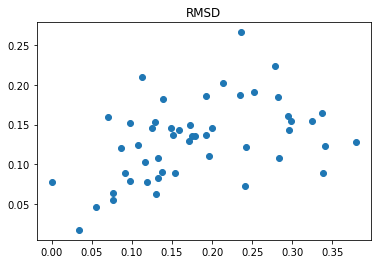

[H]c1nc2nc(C([H])([H])[H])c([H])c([C@]3([H])C([H])([H])N(C(=O)c4c([H])c([H])c(F)c([H])c4[H])C([H])([H])C(F)(F)C3([H])[H])n2n1
tensor(0.0336)


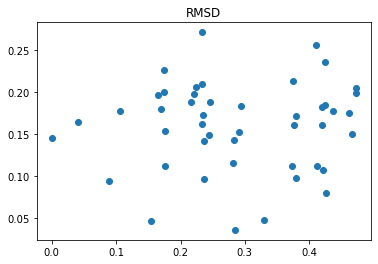

[H]c1nc2c(c([H])c1Cl)c(C(=O)c1c(F)c([H])c([H])c(N([H])[H])c1F)c([H])n2[H]
tensor(0.0221)


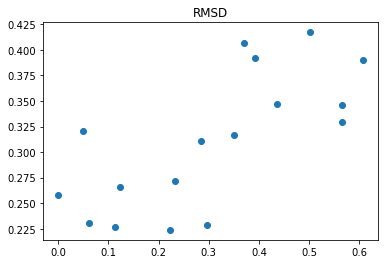

[H]c1c([H])c(-n2c(C([H])([H])[H])c([H])c(C(=O)C([H])([H])[N+]3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c2C([H])([H])[H])c([H])c([H])c1Cl
tensor(0.0133)


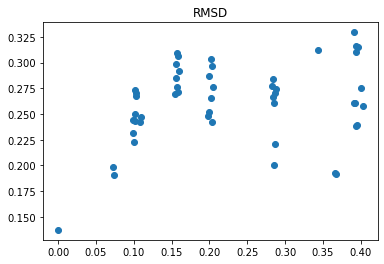

[H]/C(=C1/C(=O)N([H])c2c([H])c([H])c([H])c([H])c21)N([H])c1c([H])c([H])c(S(=O)(=O)N([H])C(N([H])[H])=[N+]([H])[H])c([H])c1[H]
tensor(0.0155)


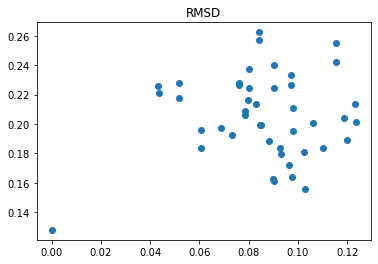

[H]c1c2c(n([H])c1[H])C(=O)N([H])C([H])([H])C([H])([H])/C2=C1/N=C(N([H])[H])N([H])C1=O
tensor(0.0543)


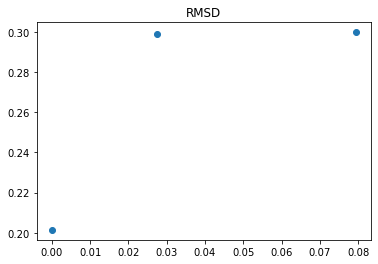

[H]c1nc2c(c([H])c1[H])c(C(=O)O[C@]1([H])C([H])([H])[C@]3([H])C([H])([H])C([H])([H])[C@]([H])(C1([H])[H])[N@@+]3([H])C([H])([H])[H])c([H])n2[H]
tensor(0.0211)


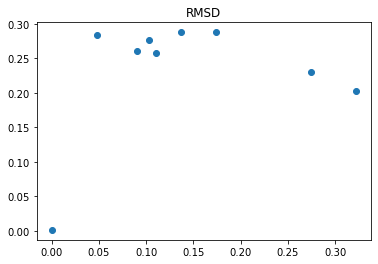

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C(=O)c1c2c([H])c([H])c([H])c([H])c2nn1[H]
tensor(0.0211)


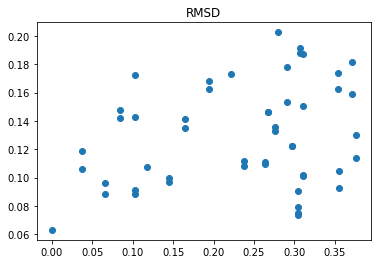

[H]O[C@]1(/C([H])=C([H])/C(=C(/[H])C(=O)[O-])C([H])([H])[H])C(C([H])([H])[H])=C([H])C(=O)C([H])([H])C1(C([H])([H])[H])C([H])([H])[H]
tensor(0.0248)


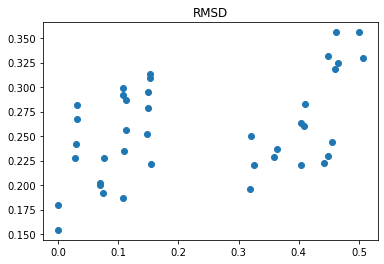

[H]c1c([H])c(C2=C(c3c([H])c([H])c4c(c3[H])N([H])C(=O)C([H])([H])O4)C([H])([H])OC2=O)c(F)c([H])c1F
tensor(0.0136)


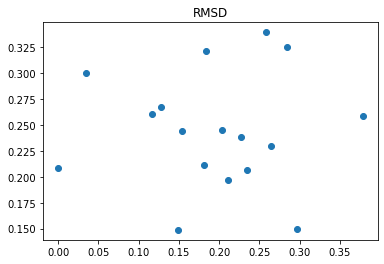

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C([H])([H])C([H])([H])C(=O)n1nc(C([H])([H])[H])c([H])c1C([H])([H])[H]
tensor(0.0149)


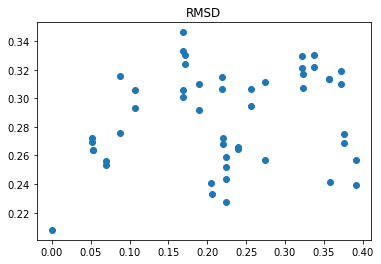

[H]c1c([H])c([H])c(C([H])([H])[N@+]2([H])C([H])([H])C([H])([H])[C@]([H])(N([H])c3nc(N([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])nc4c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c34)C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0086)


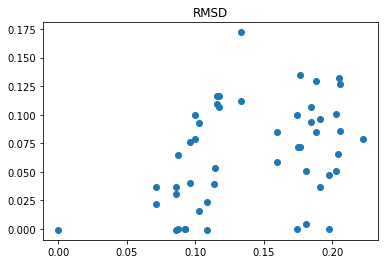

[H]OC([H])([H])C([H])([H])N(c1c([H])c([H])c(-c2nc3c([H])c(Cl)c([H])c([H])c3c(=O)n2[H])c([H])c1[H])C([H])([H])[H]
tensor(0.0165)


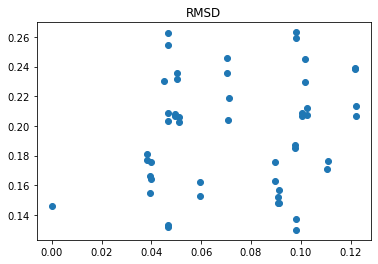

[H]c1c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N2C([H])([H])C([H])([H])N(C(=O)C([H])([H])C([H])([H])[N+]([H])([H])[H])C([H])([H])C2([H])[H])N([H])S(=O)(=O)c2c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2C([H])(C([H])([H])[H])C([H])([H])[H])c1[H]
tensor(0.0309)


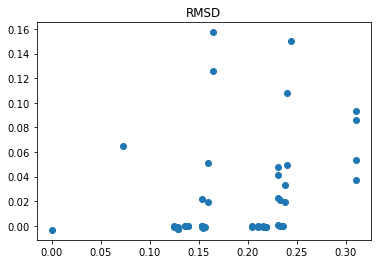

[H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)[O-])N([H])S(=O)(=O)N([H])[H])c([H])c1[H]
tensor(0.0139)


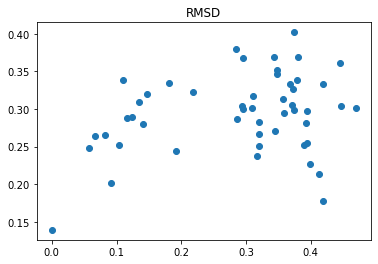

[H]Oc1c([H])c(-c2oc3c([H])c(O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c(O[H])c1O[H]
tensor(0.0113)


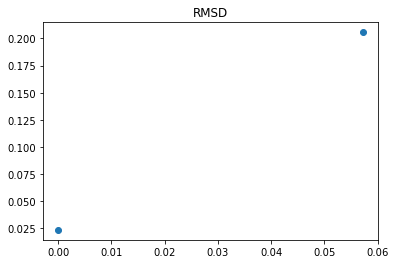

[H]c1c([H])c([H])c2c(c1[H])c([H])c([H])n1c([H])c(C(=O)N([H])[N+]([H])([H])[H])nc21
tensor(0.0069)


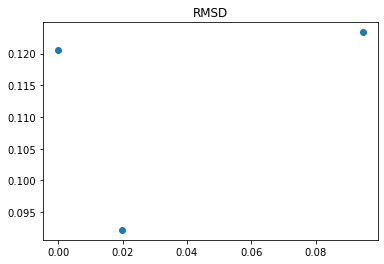

[H]Oc1c([H])c(O[H])c2c(c1Cl)C([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C(C([H])([H])O[H])=C(\[H])C([H])([H])C([H])([H])OC2=O
tensor(0.0091)


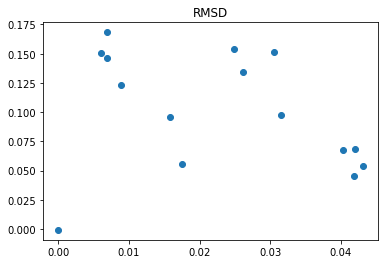

[H]c1c([H])c([H])c(C([H])([H])n2c3c(c4c([H])c([H])c([H])c(C(=O)[O-])c42)C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c(C(F)(F)F)c1[H]
tensor(0.0265)


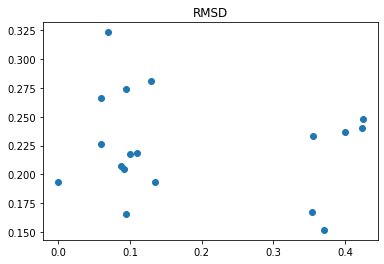

[H]OC([H])(c1sc(N([H])c2c([H])c([H])c([H])c([H])c2[H])nc1N([H])[H])c1c([H])nc([H])c([H])c1[H]
tensor(0.0091)


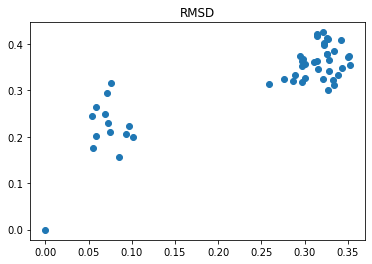

[H]c1c([H])c([H])c(C2=NN(C([H])([H])[H])c3nnc(C([H])([H])[H])n3-c3c([H])c([H])c(Cl)c([H])c32)c([H])c1[H]
tensor(0.0196)


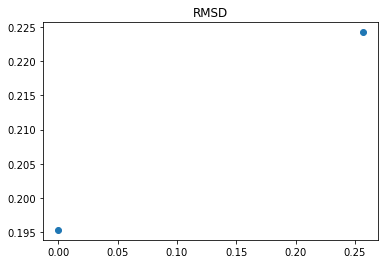

[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H])C(=O)N([H])c2c([H])c([H])c3nn([H])c([H])c3c2[H])c([H])c1[H]
tensor(0.0106)


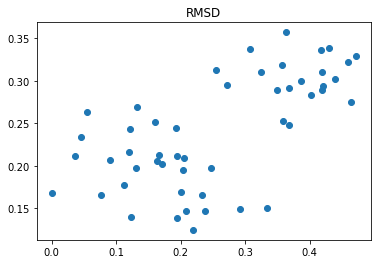

[H]c1c([H])c([H])c(C([H])([H])n2c(N([H])c3c([H])c([H])c(OC([H])([H])[H])c(F)c3[H])nc3c([H])c(C(=O)[O-])c([H])c([H])c32)c(C(F)(F)F)c1[H]
tensor(0.0063)


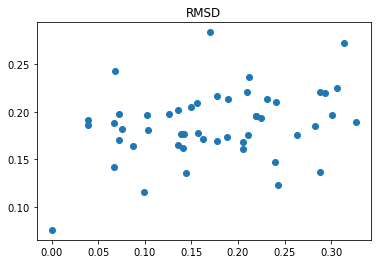

[H]c1nn(C([H])([H])[H])c2c1S(=O)(=O)N(C([H])([H])[H])c1c([H])c([H])c(N([H])C([H])([H])c3c([H])c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c3[H])c([H])c1-2
tensor(0.0469)


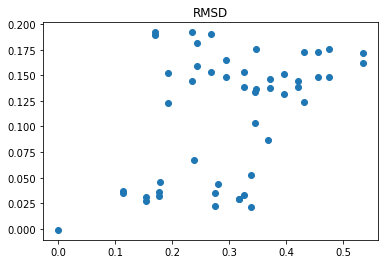

[H]SC(=S)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H]
tensor(0.0195)


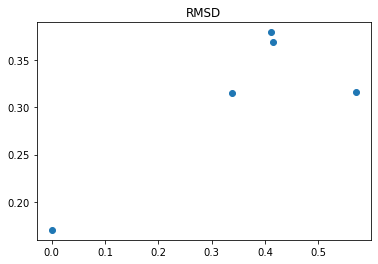

[H]N1C(=[N+]([H])[H])N(C([H])([H])[H])C(=O)[C@@]1(C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]1([H])C([H])([H])N(C(=O)C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C([H])([H])C1([H])[H]
tensor(0.0599)


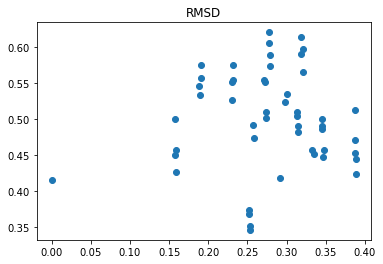

[H]c1nc([H])c2c([H])c(C#CC([H])([H])Oc3c([H])c([H])c(C([H])([H])[N+]([H])([H])[H])c(OC([H])([H])C([H])([H])[H])c3[H])c([H])c([H])c2c1[H]
tensor(0.0322)


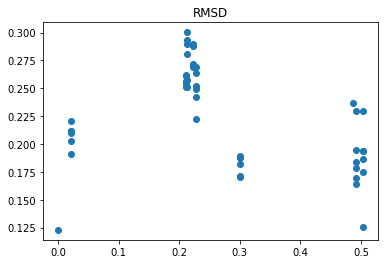

[H]Oc1c([H])c([H])c(-n2nnc(-c3nc4c([H])c([H])c(OC([H])([H])C([H])([H])OC([H])([H])[H])c([H])c4c([H])c3[H])c2[H])c([H])c1[H]
tensor(0.0070)


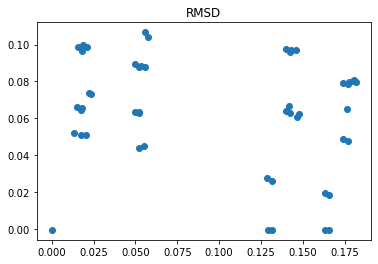

[H]ON([H])C(=O)[C@@]([H])(c1c([H])c([H])c(-c2c([H])sc([H])c2[H])c([H])c1[H])N([H])C(=O)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0074)


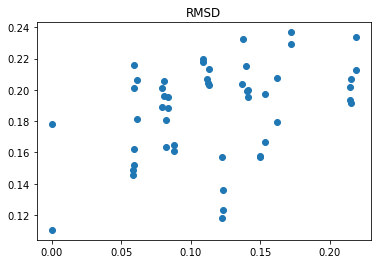

[H]c1c([H])c([H])c2c(c([H])c([H])n2[H])c1-c1noc(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])OC([H])([H])[H])n1
tensor(0.0037)


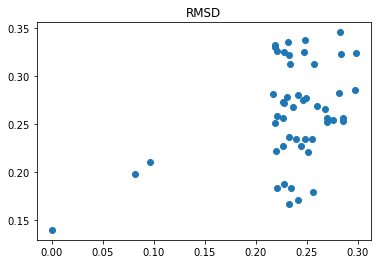

[H]c1nc(Cl)c([H])c2c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])N2C(=O)C([H])([H])[N@@+]1([H])C([H])([H])[C@@]([H])(C([H])([H])[H])[N+]([H])([H])C([H])([H])[C@]1([H])C([H])([H])OC([H])([H])[H]
tensor(0.0249)


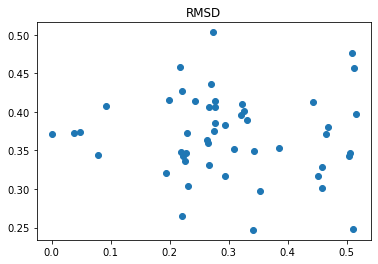

[H]c1nc(N([H])c2nc([H])c3c([H])c(C(=O)N(C([H])([H])[H])C([H])([H])[H])n(C4([H])C([H])([H])C([H])([H])C([H])([H])C4([H])[H])c3n2)c([H])c([H])c1N1C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C1([H])[H]
tensor(0.0355)


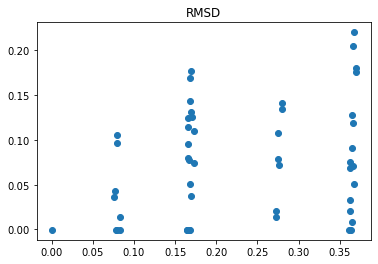

[H]OC([H])([H])[C@@]1([H])N2c3nc4c(C#N)c([H])nn4c(c3[H])N([H])c3c([H])c(c4c(c3[H])C([H])([H])C([H])([H])C(=O)N4[H])OC([H])([H])C([H])([H])C([H])([H])C([H])([H])O[C@]([H])(C2([H])[H])C1([H])[H]
tensor(0.0009)


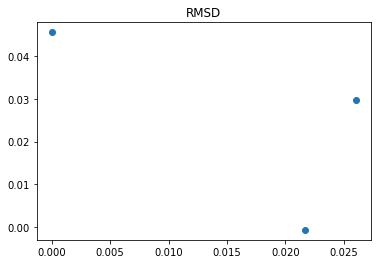

[H]Oc1c([H])c([H])c([H])c(-c2nc3c([H])c([H])c([H])c([H])c3c(=O)n2[H])c1[H]
tensor(0.0084)


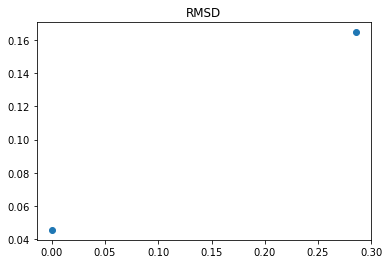

[H]c1c([H])c([H])c([C@@]([H])(Sc2nc3c(c(=O)n([H])c(=[N+]([H])[H])n3[H])n2[H])C(=O)[O-])c([H])c1[H]
tensor(0.0145)


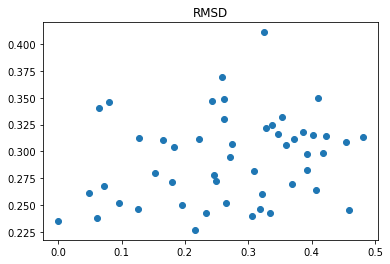

[H]Oc1c([H])c(O[H])c(Cl)c(C([H])([H])C([H])([H])c2nc([H])c([H])n2C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1Cl
tensor(0.0122)


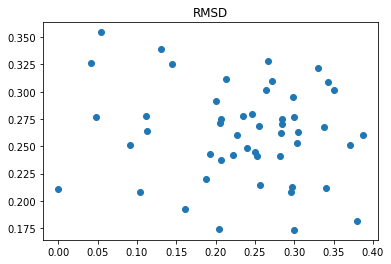

[H]OC([H])([H])[C@]1([H])O[C@@]([H])(O[C@@]([H])(c2c([H])nc([H])n2[H])[C@@]([H])(C(=O)N([H])[C@]([H])(C([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C([H])([H])c2nc(-c3nc(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])[S+](C([H])([H])[H])C([H])([H])[H])c([H])s3)c([H])s2)[C@]([H])(O[H])C([H])([H])[H])C([H])([H])[H])N([H])C(=O)c2nc([C@]([H])(C([H])([H])C(=O)N([H])[H])[N+]([H])([H])C([H])([H])[C@@]([H])(C(=O)N([H])[H])[N+]([H])([H])[H])nc(N([H])[H])c2C([H])([H])[H])[C@@]([H])(O[C@@]2([H])O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]([H])(OC(=O)N([H])[H])[C@]2([H])O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0255)


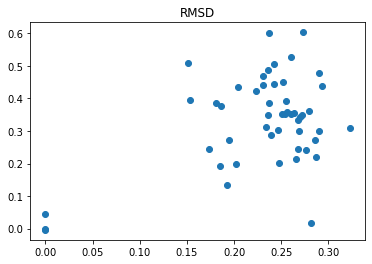

[H]c1c([H])c([H])c(N([H])C(=O)c2c([H])c([H])c3c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c3c2[H])c([H])c1[H]
tensor(0.0050)


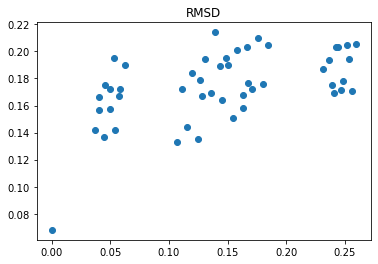

[H]c1c(OC([H])([H])[H])c(C2([H])C([H])([H])N(S(=O)(=O)C([H])([H])[H])[N+]([H])([H])C2([H])[H])c2c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c2c1[H]
tensor(0.0089)


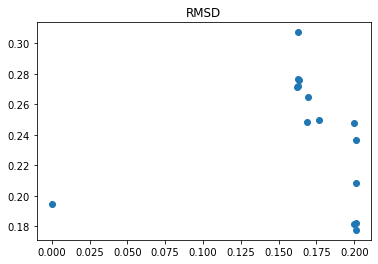

[H]c1c(Cl)c([H])c2c(OC3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c(=O)n([H])c2c1[H]
tensor(0.0145)


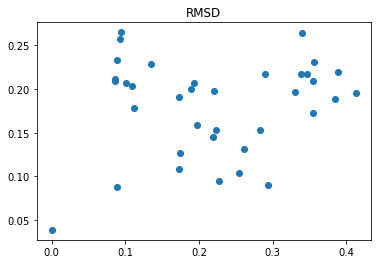

[H]c1nc([H])c([H])c(C([H])([H])C([H])([H])c2c([H])n([H])c3c([H])c([H])c(N([H])C(=O)c4c([H])c(F)c([H])c(N5C([H])([H])C([H])([H])OC([H])([H])C5([H])[H])c4[H])c([H])c23)c1[H]
tensor(0.0011)


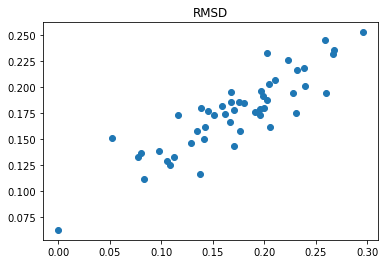

[H]c1c([H])c([H])c(C([H])([H])n2c(N3C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C3([H])[H])nc3c2c(=O)n(C([H])([H])[H])c(=O)n3C([H])([H])[H])c([H])c1[H]
tensor(0.0140)


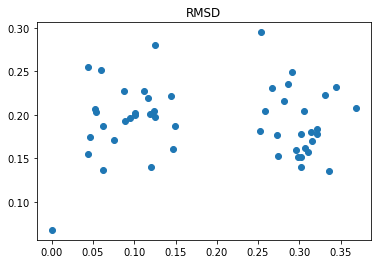

[H]c1c([H])c([H])c(C([H])([H])n2c(=O)c3nc(C([H])([H])c4c([H])c([H])c(N([H])S(=O)(=O)c5nc([H])n(C([H])([H])[H])c5[H])c([H])c4[H])n([H])c3n(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2=O)c(F)c1[H]
tensor(0.0046)


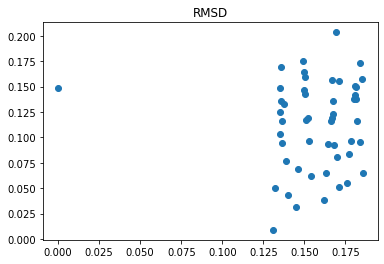

[H]Oc1c([H])c([H])c([H])c([H])c1S[H]
tensor(0.0268)


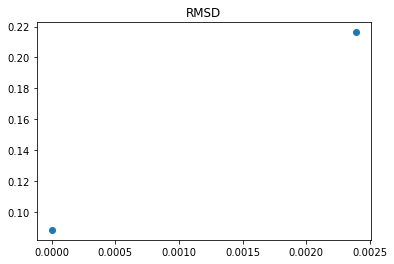

[H]OC([H])([H])[C@@]1([H])O[C@]2(ON=C(c3c([H])c([H])c4c([H])c([H])c([H])c([H])c4c3[H])C2([H])[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0070)


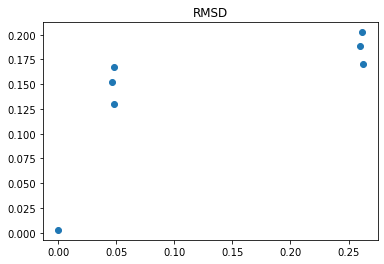

[H]OC([H])([H])C([H])([H])n1nc(C([H])([H])C([H])([H])[H])c(Oc2c([H])c(C#N)c([H])c(C#N)c2[H])c1C([H])([H])C([H])([H])[H]
tensor(0.0205)


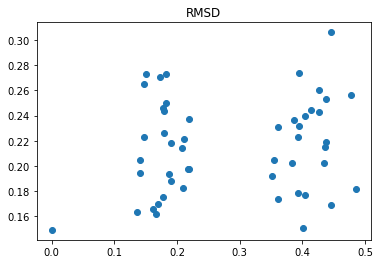

[H]c1nc([H])c(OC([H])([H])c2c([H])c(N([H])C(=O)N([H])c3c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])nn3-c3c([H])c([H])c(C([H])([H])[H])c([H])c3[H])nn2[H])c([H])c1[H]
tensor(0.0126)


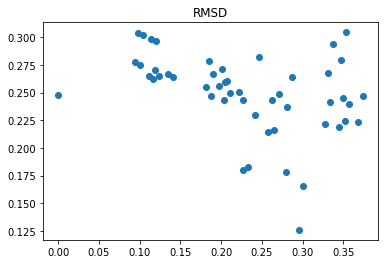

[H]c1c([H])c(C([H])([H])[H])c([H])c2c1OC1(C([H])([H])C2=O)C([H])([H])C([H])([H])N(C(=O)c2c([H])c([H])c([H])c3c([H])nn([H])c23)C([H])([H])C1([H])[H]
tensor(0.0255)


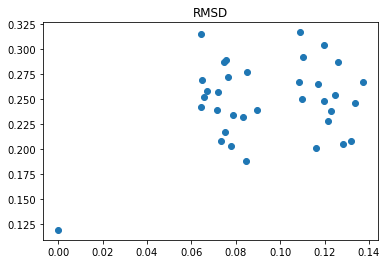

[H]OC([H])([H])[C@@]1([H])O[C@]([H])(O[C@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]([H])(C([H])([H])O[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0095)


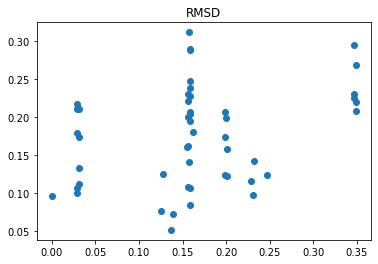

[H]c1nc([H])c(-c2c([H])c([H])c([H])c([C@]3(c4c([H])c([H])c(OC([H])([H])[H])c([H])c4[H])c4sc(C([H])([H])[H])nc4C(=[N+]([H])[H])N3[H])c2[H])c([H])n1
tensor(0.0040)


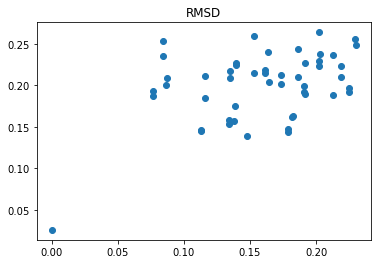

[H]c1c([H])c([H])c(-n2c(=O)n([H])c3c([H])nc4c([H])c(-c5c(C([H])([H])[H])noc5C([H])([H])[H])c(OC([H])([H])[H])nc4c32)c(OC(F)(F)F)c1[H]
tensor(0.0095)


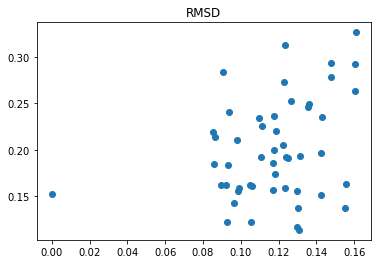

[H]C([H])=C(c1c([H])c([H])c(C(=O)[O-])c([H])c1[H])c1c([H])c2c(c([H])c1C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C2(C([H])([H])[H])C([H])([H])[H]
tensor(0.0267)


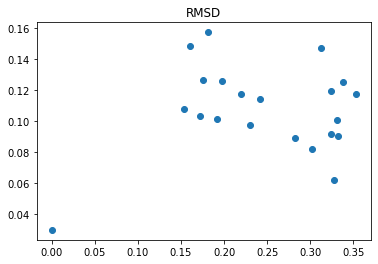

[H]OC([H])([H])[C@]1([H])[C@]([H])(O[H])[C@]([H])(O[H])C([H])([H])[N+]([H])([H])[N+]1([H])[H]
tensor(0.0540)


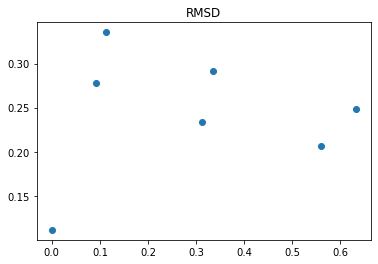

[H]c1nn([H])c([H])c1C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])c1c([H])c([C@]2([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@@]2([H])C([H])([H])Oc2c([H])c([H])c3c(c2[H])OC([H])([H])O3)c([H])c([H])c1F
tensor(0.0160)


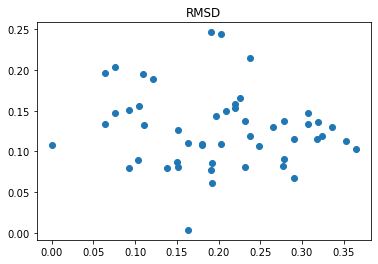

[H]O[C@]1([H])C(=O)N(C([H])([H])C([H])([H])[H])c2c([H])c([H])c([H])c([H])c21
tensor(0.0674)


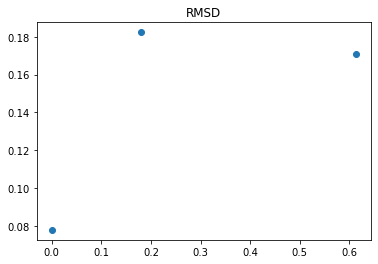

[H]Oc1c([H])c(O[H])c(C(=O)OC([H])([H])[H])c(C([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1Cl
tensor(0.0177)


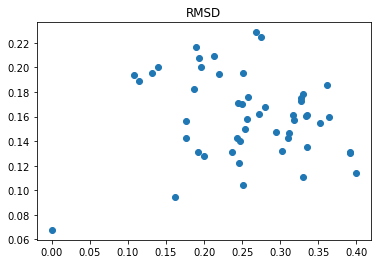

[H]Oc1c(N([H])C(=O)N([H])c2c([H])c([H])c(C(F)(F)F)c([H])c2[H])c([H])c(S(=O)(=O)N([H])[H])c([H])c1[N+](=O)[O-]
tensor(0.0160)


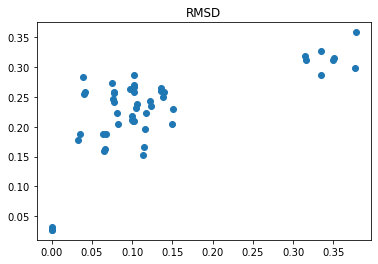

[H]O[C@]([H])(C(=O)[O-])C([H])([H])c1c([H])c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c1[H]
tensor(0.0190)


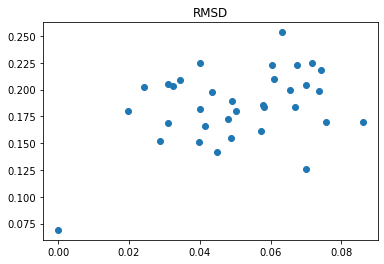

[H]/N=C1/S/C(=C(/[H])c2oc(-c3c([H])c([H])c(S(=O)(=O)N([H])[H])c(C(F)(F)F)c3[H])c([H])c2[H])C(=O)N1[H]
tensor(0.0135)


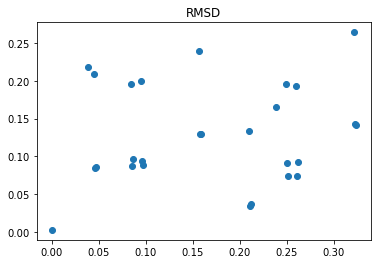

[H]c1nc(N([H])[H])c([H])c(C(=O)N([H])[C@]2([H])c3c([H])c([H])c([H])c([H])c3-c3c(-c4nc5c([H])c([H])nc([H])c5n4[H])c([H])c([H])c([H])c32)c1[H]
tensor(0.0082)


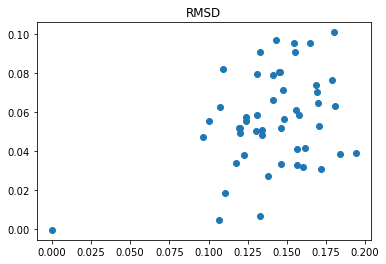

[H]/C(=C1/C(=O)N([H])C(=O)c2c([H])c([H])c(Br)c([H])c21)N([H])c1c([H])c([H])c(C([H])([H])[N+]2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0523)


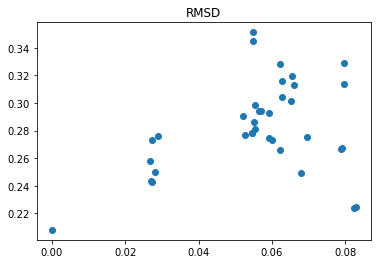

[H]OC([H])([H])[C@@]1([H])O[C@]([H])(OC([H])([H])[C@]([H])(N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])[C@]([H])(O[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])[C@]([H])(O[H])[C@@]([H])(O[H])C1([H])[H]
tensor(0.0143)


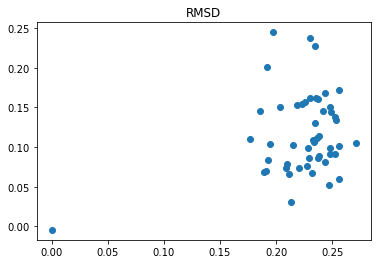

[H]c1c(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])oc(-c2c([H])c([H])c(N([H])C(=O)c3oc4c([H])c([H])c([H])c([H])c4c3[H])c([H])c2[H])c1[H]
tensor(0.0057)


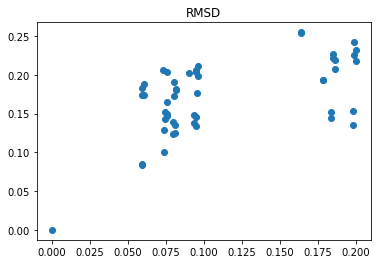

[H]OC1=C(C(=O)C([H])([H])[H])C(=O)[C@]2(C([H])([H])[H])C(=C1[H])Oc1c(C(=O)N([H])C([H])([H])c3c([H])c([H])c([H])c4c([H])c([H])c([H])c([H])c34)c(OC([H])([H])[H])c([H])c(O[H])c12
tensor(0.0036)


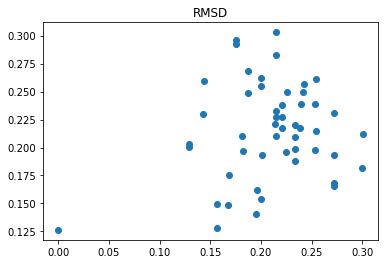

[H]O[C@@]([H])([C@]([H])(O[H])/C([H])=C(\[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(OC([H])([H])[H])C(=O)N([H])C([H])([H])C(=O)N([H])[H]
tensor(0.0143)


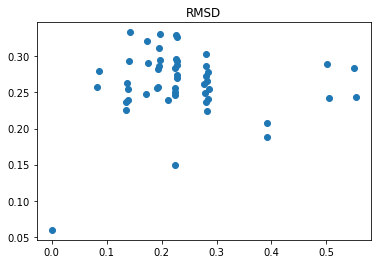

[H]C1=C([H])C1([H])S(=O)(=O)N([H])C(=O)[C@@]1(N([H])C(=O)[C@@]2([H])N3C(=O)[C@]([H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])N([H])C(=O)O[C@]4([H])C([H])([H])[C@@]4([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])c4nc5c([H])c([H])c(OC([H])([H])[H])c([H])c5nc4O[C@@]([H])(C3([H])[H])C2([H])[H])C([H])([H])[C@@]1([H])C([H])([H])C([H])([H])[H]
tensor(0.0234)


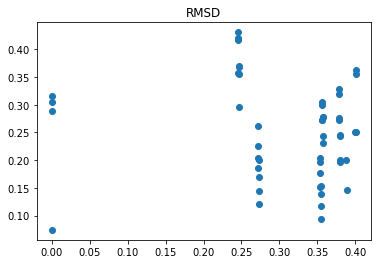

[H]c1nn([H])c2c1C([H])([H])C([H])([H])C([H])([H])c1c-2n([H])c2c([H])c([H])c([H])c([H])c12
tensor(0.0404)


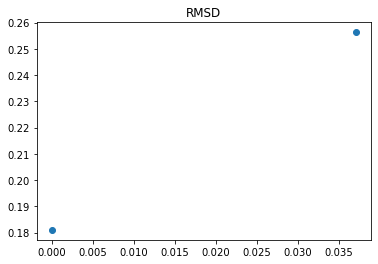

[H]c1c([H])c([H])c(SC([H])([H])[C@]([H])(N([H])c2c([H])c([H])c(S(=O)(=O)N([H])C(=O)c3c([H])c([H])c(-c4c([H])c([H])c([H])c5c(C([H])([H])C([H])([H])C([H])([H])Oc6c([H])c([H])c([H])c7c([H])c([H])c([H])c([H])c67)c(C(=O)[O-])nn45)c(C([H])([H])[H])c3[H])c([H])c2[N+](=O)[O-])C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(0.1099)


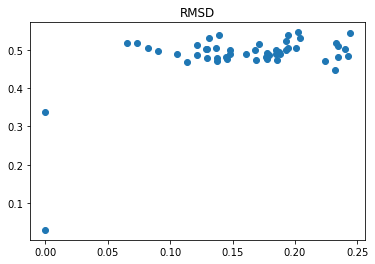

[H]C([H])(F)C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0505)


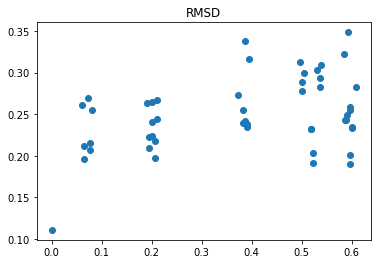

[H]c1c([H])c([H])c(-c2c([H])c([H])c(C([H])([H])n3c([H])c([H])c(=[N+](C([H])([H])[H])C([H])([H])[H])c([H])c3[H])c([H])c2[H])c([H])c1[H]
tensor(0.0034)


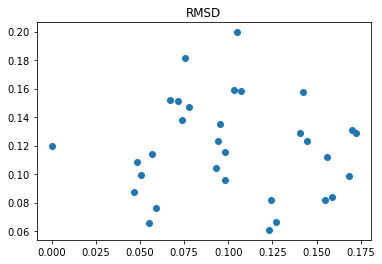

[H]c1nc2c([H])c([H])c(C([H])([H])n3nnc4c3C(=O)N(c3c([H])c([H])c([H])c([H])c3[H])C([H])([H])C4([H])[H])c([H])c2c([H])c1[H]
tensor(0.0082)


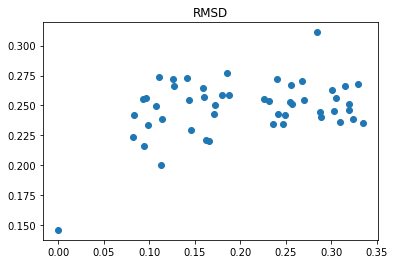

[H]c1nc([H])c([H])c(Oc2c([H])c([H])c(N([H])C(=O)N([H])c3c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])nn3C([H])([H])[H])c([H])c2[H])c1[H]
tensor(0.0340)


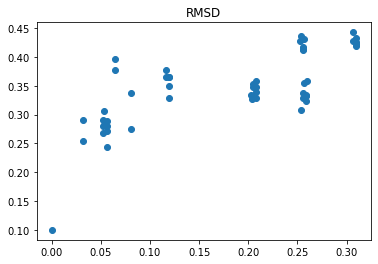

[H]Oc1c([H])c([H])c([H])c(-c2oc3c([H])c(O[H])c([H])c([H])c3c(=O)c2[H])c1[H]
tensor(0.0183)


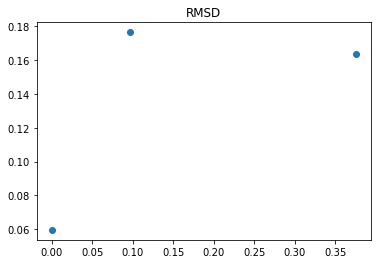

[H]c1sc([H])c(C([H])([H])[C@@]([H])(C(=O)[O-])N([H])C2=NC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c3c([H])c(Cl)c([H])c([H])c32)c1C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.0623)


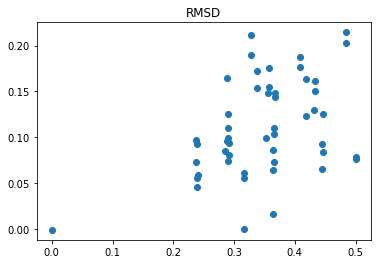

[H]OC([H])([H])c1c([H])c([H])c([H])c([H])c1-c1c([H])c(C(=O)C([H])([H])[H])n2c([H])c([H])c(Oc3c([H])c([H])c([H])c([H])c3[H])c([H])c12
tensor(0.0032)


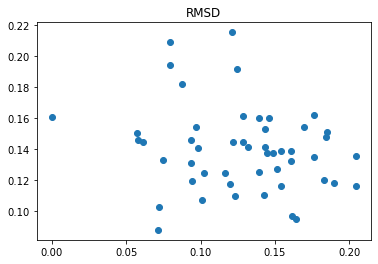

[H]OC([H])([H])[C@@]([H])(N1C(=O)[C@]([H])(C([H])([H])C(=O)[O-])O[C@@]([H])(c2c([H])c([H])c([H])c(Cl)c2[H])[C@@]1([H])c1c([H])c([H])c(Cl)c([H])c1[H])C([H])([H])C([H])([H])[H]
tensor(0.0528)


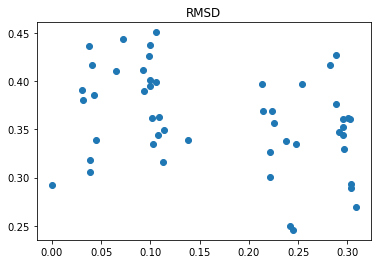

[H]c1c([H])c([H])c2c([H])c(S(=O)(=O)N([H])C(=O)c3c([H])c4c([H])c(OC([H])([H])[H])c([H])c([H])c4n3C([H])([H])C(=O)[O-])c([H])c([H])c2c1[H]
tensor(0.0068)


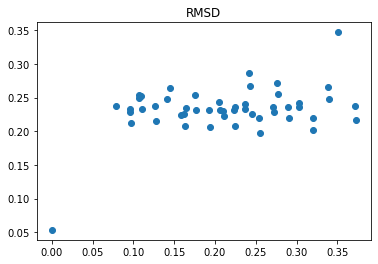

[H]c1c([H])c(C(=O)[O-])c([H])c([C@@]2([H])[C@]([H])(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[N+]([H])([H])[C@]2([H])C(=O)[O-])c1[H]
tensor(0.0754)


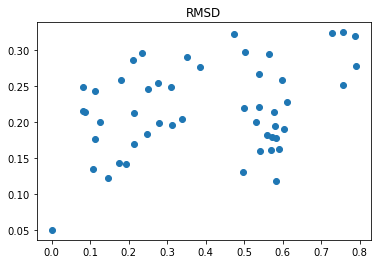

[H]c1c(N2C(=O)C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c2c(c1[H])c(C([H])([H])[H])c([H])c(=O)n2C([H])([H])[H]
tensor(0.0190)


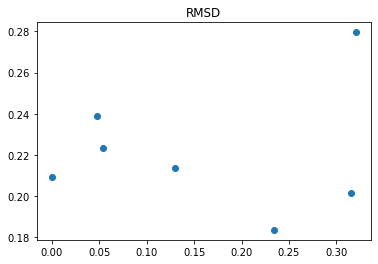

[H]Oc1c([H])c([H])c(-c2oc3c([H])c(Cl)c([H])c(O[H])c3c(=O)c2[H])c([H])c1O[H]
tensor(0.0091)


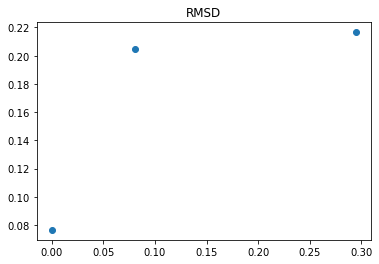

[H]Oc1c([H])c2c(c([H])c1C([H])([H])[H])[C@@]([H])(c1c([H])c([H])c(/C([H])=C(\[H])C(=O)[O-])c([H])c1[H])[N@+]([H])(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C2([H])[H]
tensor(0.0157)


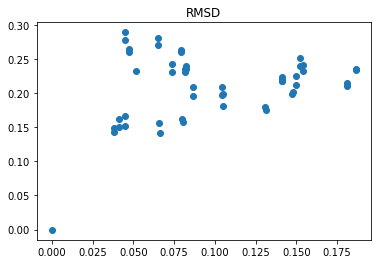

[H]c1sc(-c2c([H])c([H])c([H])c(C(=O)N([H])c3c([H])c([H])c([H])c([H])c3[H])c2[H])nc1C(=O)N([H])c1c([H])c([H])c(C(=O)N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1OC([H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0074)


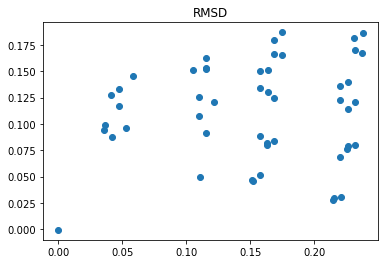

[H]c1c([H])c([H])c(N([H])c2nn([H])c3c2C([H])([H])N(C(=O)C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c1[H]
tensor(0.0092)


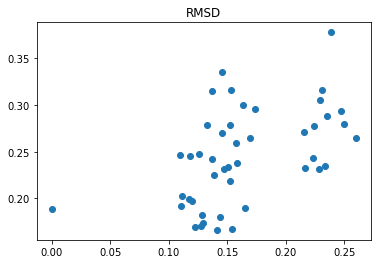

[H]c1c([H])c(C(=O)N(C([H])([H])[H])C([H])([H])[H])c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c3c(n2)nc([H])n3[H])c1[H]
tensor(0.0049)


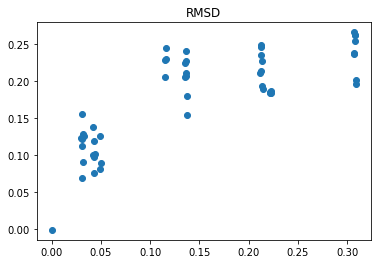

[H]c1c([H])c(-c2nc(N([H])C(=O)[C@@]([H])(Oc3c([H])c([H])c(-c4nc([H])n(C([H])([H])[H])c4[H])c([H])c3[H])C([H])([H])[H])n([H])c2[H])c([H])c([H])c1Br
tensor(0.0036)


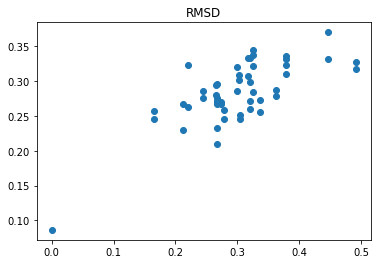

[H]c1c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c2c(N([H])C3([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C3([H])[H])nc(N([H])C([H])([H])C([H])([H])[H])nc12
tensor(0.0015)


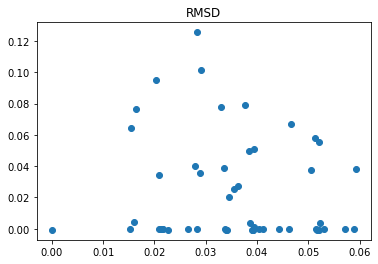

[H]c1nc(C([H])([H])N([H])C(=O)c2c([H])c([C@]3([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@@]3([H])C([H])([H])Oc3c([H])c([H])c4c(c3[H])OC([H])([H])O4)c([H])c([H])c2F)c([H])c([H])c1[H]
tensor(0.0189)


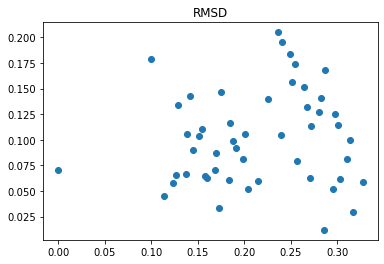

[H]Oc1c([H])c([H])c(-c2c(N([H])[H])nc([H])c(-c3c([H])nc(C(=O)N([H])C([H])([H])[H])c([H])c3[H])c2C([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0078)


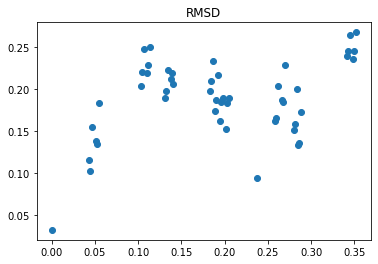

[H]c1c([H])c([H])c(C([H])(O[C@]2([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])c3nn4c([H])nnc4c([H])c3[H])C([H])([H])C2([H])[H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0116)


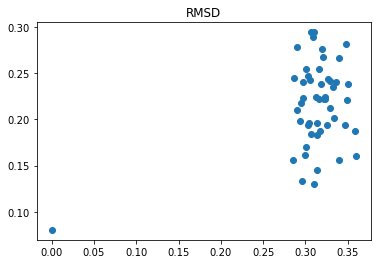

[H]c1c([H])c(OC([H])([H])[H])c(S(=O)(=O)N([H])c2c(C([H])([H])[H])c([H])c3onc(C([H])([H])[H])c3c2[H])c([H])c1Br
tensor(0.0594)


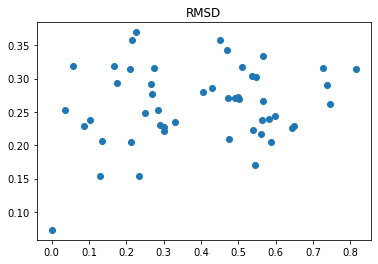

[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])N(C(=O)OC([H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(C([H])([H])SC([H])([H])[H])C(=S)N2[H]
tensor(0.0475)


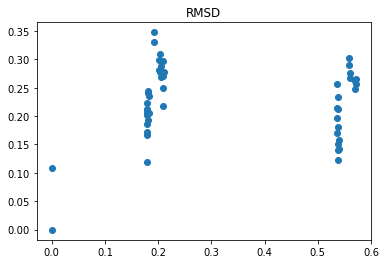

[H]OC([H])([H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])/C([H])=C(C(/[H])=C(\[H])[C@@]1([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[C@]1([H])C([H])([H])[H])\C([H])([H])[H]
tensor(0.0011)


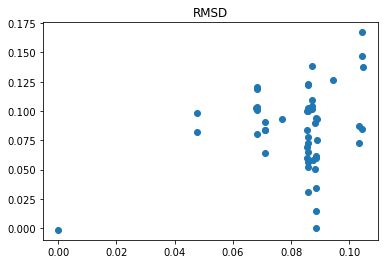

[H]Oc1c([H])c([H])c([H])c([H])c1-c1c([H])c2c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c2n1[H]
tensor(0.0032)


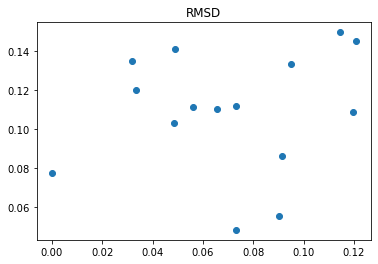

[H]c1c([H])c([H])c2c(c1[H])C(OC([H])([H])[C@]1([H])OC([H])([H])C([H])([H])c3c1sc(N([H])C(=O)C(=O)[O-])c3C(=O)[O-])=NS2(=O)=O
tensor(0.0362)


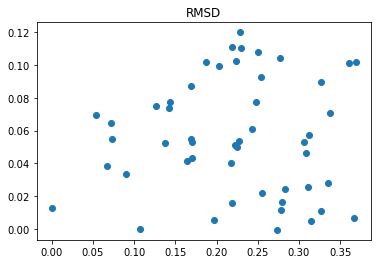

[H]c1c([H])c(-c2c([H])c([H])c3nc(C(F)(F)F)nc(N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c3c2[H])c([H])c(N([H])[H])c1[H]
tensor(0.0005)


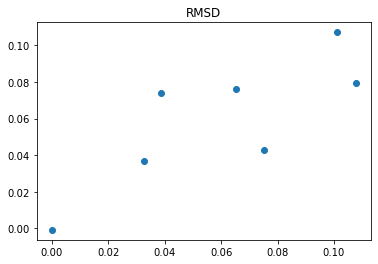

[H]c1nc(-c2nc(N([H])C([H])([H])C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c(Cl)c(C([H])([H])[H])n2)c([H])c([H])c1[H]
tensor(0.0113)


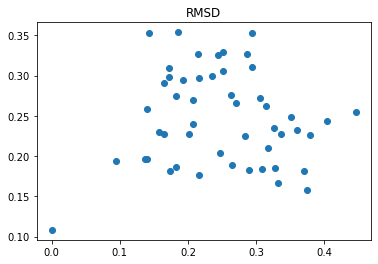

[H]c1c([H])c(Cl)c([H])c([C@]2([H])N=C(c3c([H])c([H])c(C#N)c([H])c3OC([H])(C([H])([H])[H])C([H])([H])[H])N(C(=O)N3C([H])([H])C(=O)N([H])C([H])([H])C3([H])[H])[C@]2([H])c2c([H])c([H])c(Cl)c([H])c2[H])c1[H]
tensor(0.0029)


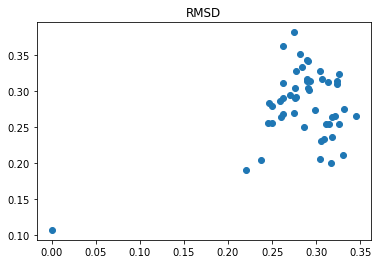

[H]OC([H])([H])c1c([H])nn2c(N([H])C([H])([H])c3c([H])nc([H])c([H])c3[H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])nc12
tensor(0.0084)


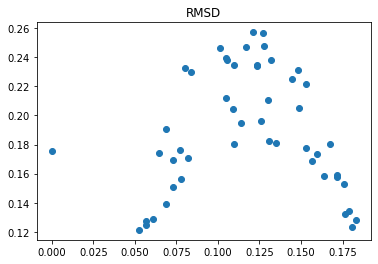

[H]O[C@]([H])(C([H])([H])[N+]([H])([H])[C@]([H])(C(=O)N([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[H])[C@@]([H])(N([H])C(=O)c1c([H])c(OC([H])([H])C([H])([H])C([H])([H])[H])c([H])c(N2C(=O)C([H])([H])C([H])([H])C2([H])[H])c1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0118)


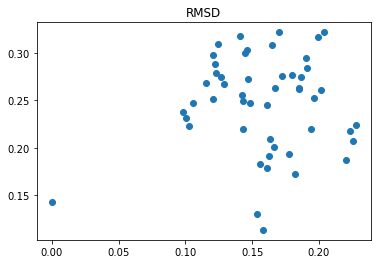

[H]O[C@]1([H])c2sc(C([H])([H])C([H])([H])C3([H])C([H])([H])C3([H])[H])c([H])c2[C@@](O[H])(C(=O)[O-])C([H])([H])[C@@]1([H])O[H]
tensor(0.0110)


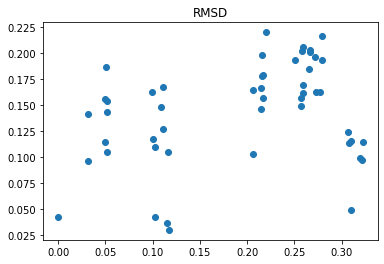

[H]Oc1c([H])c([H])c(N([H])S(=O)(=O)c2sc([H])c([H])c2[H])c([H])c1-c1c(O[H])c([H])c([H])c2c([H])c([H])c([H])c([H])c12
tensor(0.0128)


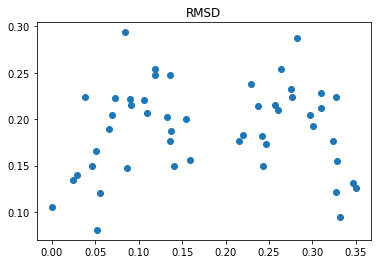

[H]c1c([H])c([H])c(-c2c([H])c([H])c(-c3c([H])c([H])c(N([H])C(=O)c4c([H])c([H])c([H])c(Br)c4[H])c([H])c3[H])n2C([H])([H])C(=O)N([H])C(N([H])[H])=[N+]([H])[H])c([H])c1[H]
tensor(0.0073)


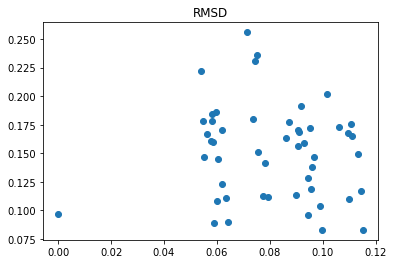

[H]c1c([H])c([H])c(C([H])([H])Oc2c([H])c([H])c([S@+](N([H])S(=O)(=O)c3c([H])c([H])c(C([H])([H])[H])c([H])c3[H])C([H])([H])[H])c([H])c2[H])c([H])c1[H]
tensor(0.0071)


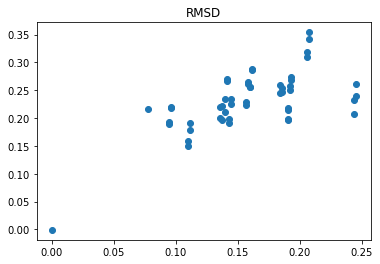

[H]Oc1c([H])c([C@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])/C([H])=C(\[H])N([H])C(=O)OC([H])([H])[H])oc(=O)c1C(=O)/C(=C([H])/C([H])=C(\C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[H]
tensor(0.0027)


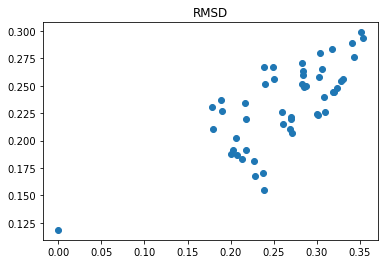

[H]O[C@]1([H])[C@@]([H])(C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])O[C@@]([H])(n2c(C([H])([H])[H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0266)


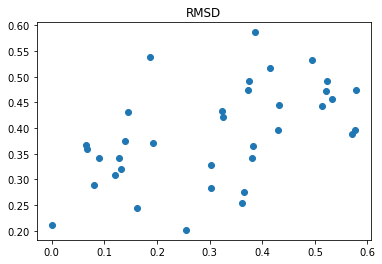

[H]c1nc([H])c([H])c(-c2c([H])nn([H])c2-c2c([H])c([H])c(F)c([H])c2[H])c1[H]
tensor(0.0043)


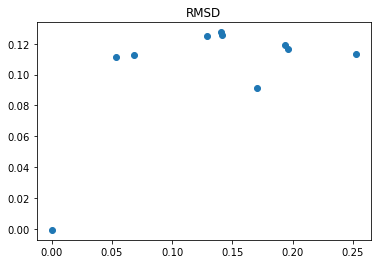

[H]N1C(=[N+]([H])[H])N(C([H])([H])[H])C(=O)[C@@]1(C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0216)


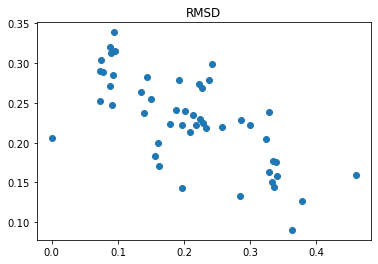

[H]OC([H])([H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]([H])(OS(=O)(=O)[O-])[C@]([H])(O[H])C([H])([H])[S@+]1C([H])([H])[C@@]([H])(O[H])[C@]([H])(O[H])[C@@]1([H])C([H])([H])O[H]
tensor(0.0170)


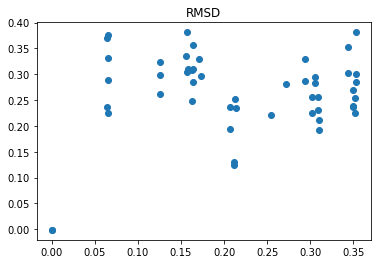

[H]c1c([H])c(C(=O)c2sc(N([H])c3c([H])c([H])c(Cl)c([H])c3[H])nc2N([H])[H])c([H])c([N+](=O)[O-])c1[H]
tensor(0.0107)


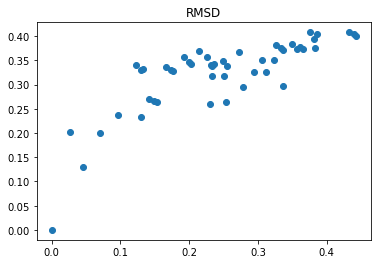

[H]n1oc2c(c1=O)C([H])([H])[C@]([H])(C(=O)[O-])[N+]([H])([H])C2([H])[H]
tensor(0.0105)


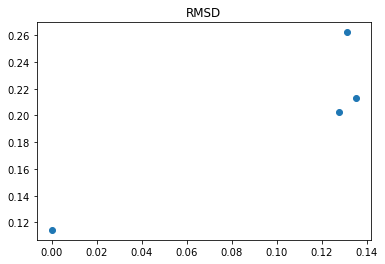

[H]OC([H])([H])[C@@]1([H])N(C(=O)N([H])[C@@]2([H])C([H])([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])C([H])([H])[N+]([H])([H])[H])C([H])([H])C2([H])[H])C([H])([H])C([H])([H])[C@@]1([H])N([H])S(=O)(=O)[O-]
tensor(0.0252)


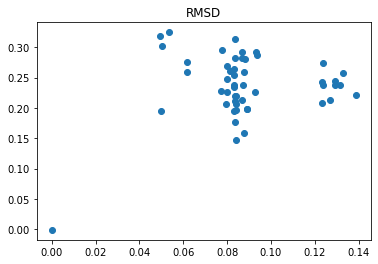

[H]O/C(=C(/[H])C(=O)C(=O)[O-])c1c([H])c([H])c([H])c([H])c1Br
tensor(0.0386)


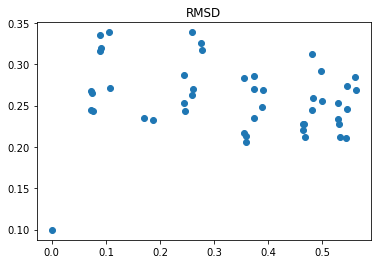

[H]c1nc(N([H])[H])c(O[C@@]([H])(c2c(Cl)c([H])c([H])c(F)c2Cl)C([H])([H])[H])c([H])c1-c1c([H])nn(C2([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0025)


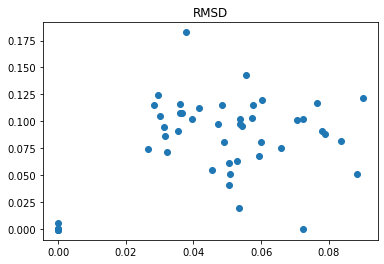

[H]c1c([H])c(OC([H])([H])[H])c([H])c(C([H])([H])OC(=O)c2oc3c([H])c([H])c([H])c(OC4([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C4([H])[H])c3c2C([H])([H])[H])c1[H]
tensor(0.0213)


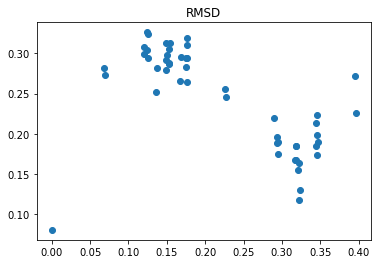

[H]Oc1c([H])c(O[H])c([H])c(Oc2c([H])c([H])c(Cl)c(Cl)c2[H])c1[H]
tensor(0.0163)


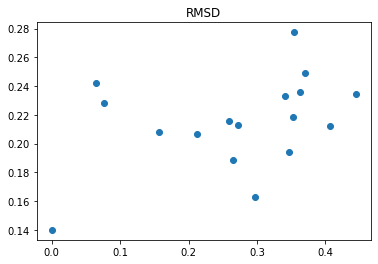

[H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])C(=O)[O-])C([H])([H])C(=O)N([H])[C@]([H])(C(=O)OC([H])([H])[H])C([H])([H])c2nc([H])n([H])c2[H])c([H])c1[H]
tensor(0.0158)


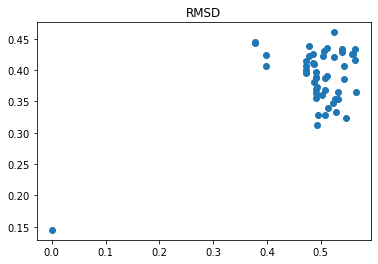

[H]c1c([H])c([H])c(-c2nc3c([H])c([H])c(OC([H])([H])[H])c([H])c3s2)c(F)c1[H]
tensor(0.0024)


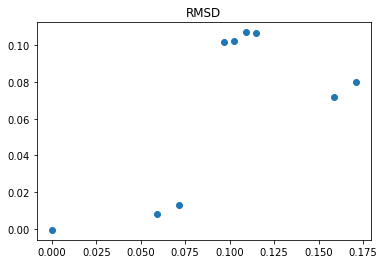

[H]c1c([H])c([H])c([C@]2([H])N(C(=O)C([H])([H])N([H])C(=O)N([H])C([H])([H])c3c([H])c([H])c(N([H])[H])c([H])c3[H])C([H])([H])C([H])([H])C2([H])[H])c(SC([H])([H])[H])c1[H]
tensor(0.0085)


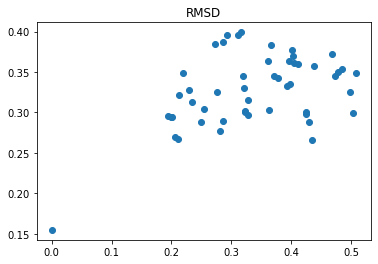

[H]c1c([H])c(C([H])([H])[H])c2c([H])c([H])c3c(c2c1[H])C(=O)C(=O)C1=C3OC([H])([H])[C@]1([H])C([H])([H])[H]
tensor(0.0067)


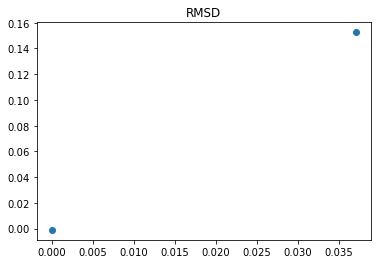

[H]c1c([H])c(C([H])([H])Oc2c([H])c([H])c([C@@]34C(=O)N3[C@@]4(C(=O)N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c3c(C(=O)[O-])n([H])c4c([H])c(Cl)c([H])c([H])c34)c([H])c2[H])c([H])c([H])c1Cl
tensor(0.0152)


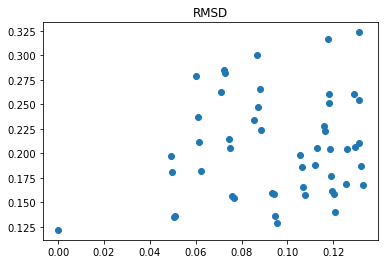

[H]c1c(N([H])C(=O)N([H])C([H])([H])[H])nc(N([H])C(=O)N([H])S(=O)(=O)c2sc(C([H])([H])C([H])([H])OC([H])([H])[H])c(C([H])([H])[H])c2[H])c([H])c1Br
tensor(0.0113)


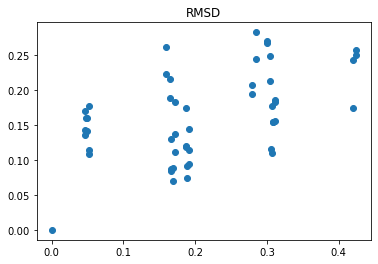

[H]c1c(OC([H])([H])[H])c2c([H])c([H])c3c(S(=O)(=O)[O-])c([H])c(S(=O)(=O)[O-])c4c([H])c([H])c(c1S(=O)(=O)[O-])c2c34
tensor(0.0014)


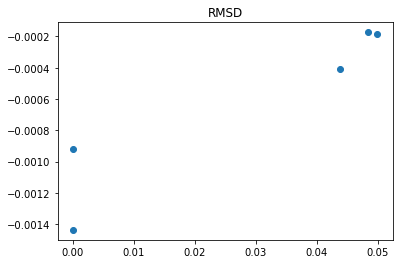

[H]c1nc(-c2nc3n(c2[H])C([H])([H])C([H])([H])Oc2c([H])c([H])c([S@@](=O)[C@]4([H])C([H])([H])C([H])([H])[N@@+]([H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C4([H])[H])c([H])c2-3)n(C([H])(C([H])([H])[H])C([H])([H])[H])n1
tensor(0.0109)


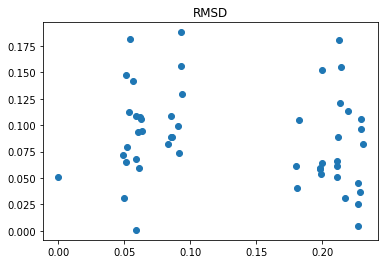

[H]OC([H])([H])/C([H])=C(\C([H])([H])[H])C([H])([H])C([H])([H])/C([H])=C(\C([H])([H])[H])C([H])([H])C([H])([H])C([H])=C(C([H])([H])[H])C([H])([H])[H]
tensor(0.0028)


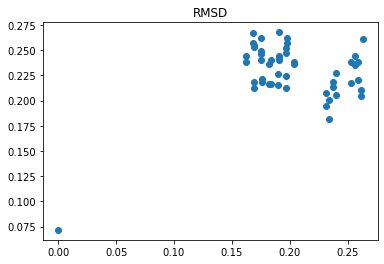

[H]c1c([H])c([H])c([C@]2([H])N(C(=O)C([H])([H])N([H])C(=O)N(C([H])([H])c3nnn(C([H])([H])[H])n3)C([H])([H])c3c([H])c([H])c(N([H])[H])c([H])c3[H])C([H])([H])C([H])([H])C2([H])[H])c(Br)c1[H]
tensor(0.0249)


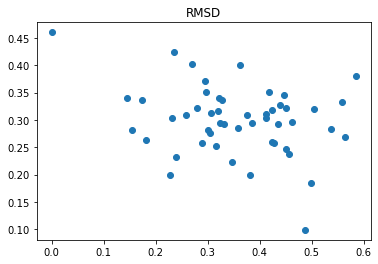

[H]Oc1c([H])c([H])c(-c2c([H])nc3c([H])c([H])c4c([H])c([H])nc([H])c4c3c2[H])c([H])c1[H]
tensor(0.0017)


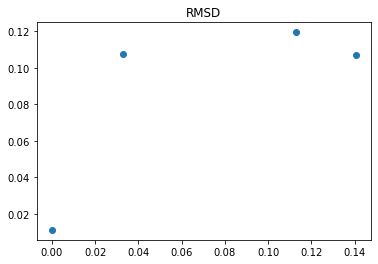

[H]c1sc(-c2c([H])c([H])c([H])c([H])c2Cl)c(C([H])([H])C(=O)N([H])C(N([H])[H])=[N+]([H])[H])c1-c1c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0079)


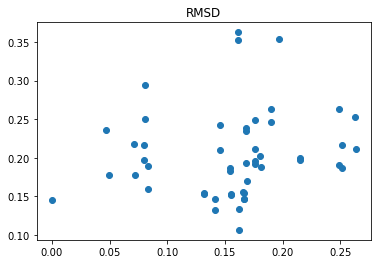

[H]O[C@@]([H])(C([H])([H])[C@]([H])(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[H])[C@@]1([H])N([H])C(=O)[C@]([H])(C([H])([H])[H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])(C([H])([H])[H])C1([H])[H]
tensor(0.0043)


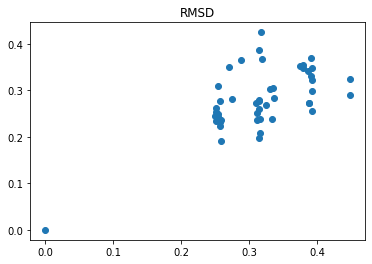

[H]c1c([H])c([H])c(C([H])([H])n2c3c([H])c([H])c([H])c([H])c3c3c([H])c([H])c([H])c(C(=O)[O-])c32)c([H])c1[H]
tensor(0.0251)


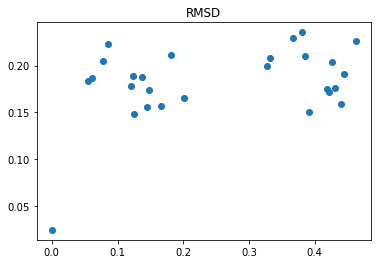

[H]c1c(OS(=O)(=O)N([H])[H])c(C([H])([H])C([H])([H])[H])c([H])c2c1C([H])([H])C([H])([H])[C@]1([H])[C@]2([H])C([H])([H])C([H])([H])[C@]2(C([H])([H])[H])C(=O)C([H])([H])C([H])([H])[C@]21[H]
tensor(0.0088)


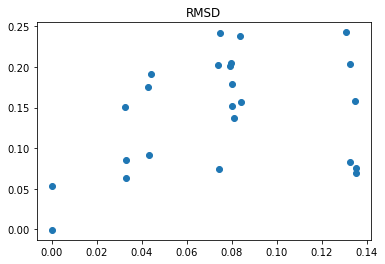

[H]c1c([H])c([H])c(-n2nc(C([H])([H])C([H])([H])[H])c3c([H])c([H])c(N4C([H])([H])[C@]5([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]5([H])C4([H])[H])c([H])c32)c([H])c1[H]
tensor(0.0024)


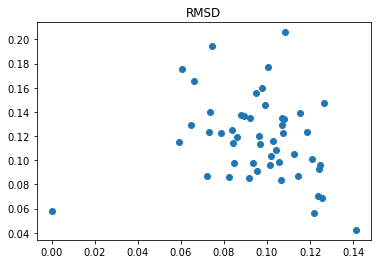

[H]N(C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@]1([H])SC([H])([H])[C@]2([H])N([H])C(=[N+]([H])[H])N([H])[C@]12[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0088)


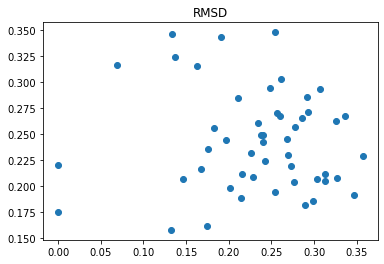

[H]OC([H])([H])C([H])([H])[N+]1([H])C([H])([H])C([H])([H])N(c2nc(-c3nc([H])c([H])c([H])c3[H])nc(C([H])([H])[H])c2Cl)C([H])([H])C1([H])[H]
tensor(0.0101)


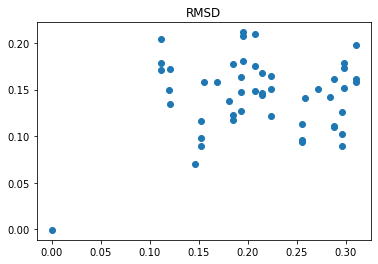

[H]c1c([H])c([H])c(-c2oc3c([H])c([H])c(Cl)c([H])c3c(=O)c2[H])c([H])c1[H]
tensor(0.0032)


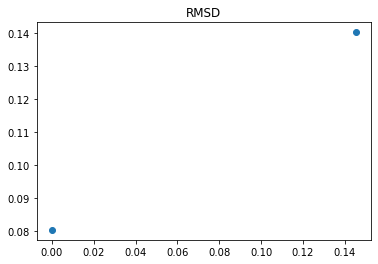

[H]O[C@@]1([H])C([H])([H])N(C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@]([H])(C(=O)N([H])C([H])([H])c2c([H])c([H])c(-c3sc([H])nc3C([H])([H])[H])c([H])c2[H])C1([H])[H]
tensor(0.0189)


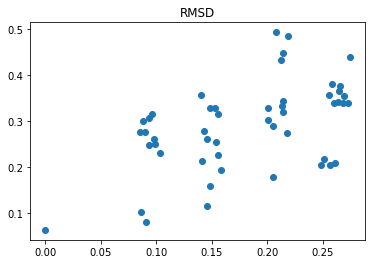

[H]Oc1c([H])c([H])c(-n2nnc(-c3nc4c([H])c([H])c([H])c([H])c4c([H])c3[H])c2[H])c([H])c1[H]
tensor(0.0188)


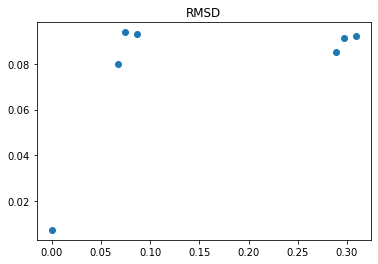

[H]c1oc(C(=O)N([H])c2c([H])c([H])c([H])c([C@]3(c4c([H])c([H])c([H])c([H])c4[H])C(=O)N(C([H])([H])[H])C(=[N+]([H])[H])N3[H])c2[H])c([H])c1[H]
tensor(0.0093)


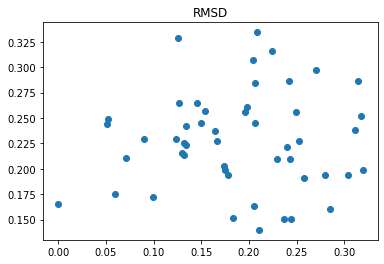

[H]c1c([H])c([H])c2c(S(=O)(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])c([H])c([H])c(OC([H])([H])[H])c2c1[H]
tensor(0.0194)


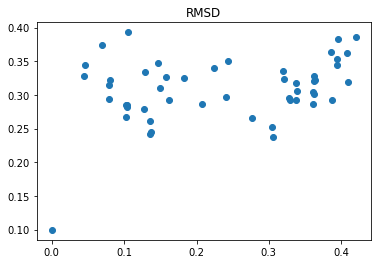

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c2c1C([H])([H])C([H])([H])[N+]([H])([H])C2([H])[H]
tensor(0.0023)


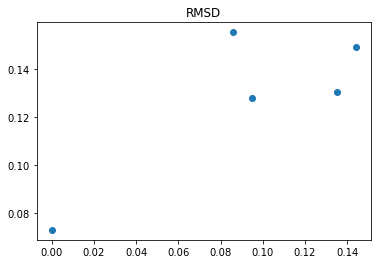

[H]c1c([H])c([H])c2c(c1[H])c1c([H])c([H])c([H])c([H])c1n2C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0281)


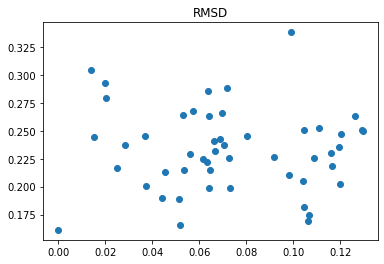

[H]c1c([H])c([C@]2([H])C([H])([H])C(=O)N([H])C2([H])[H])c([H])c(OC2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c1OC([H])([H])[H]
tensor(0.0139)


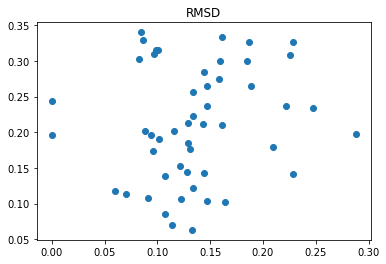

[H]OB(O[H])[C@]([H])(c1c([H])c([H])c([H])c(C(=O)[O-])c1[H])N([H])C(=O)C([H])([H])c1sc([H])c([H])c1[H]
tensor(0.0136)


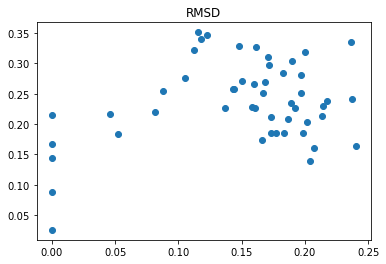

[H]Oc1c([H])c([H])c([C@@]2([H])OC([H])([H])[C@@]3(C([H])([H])O[H])C([H])([H])C([H])=C(C([H])([H])[H])[C@]2([H])[C@@]3([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0051)


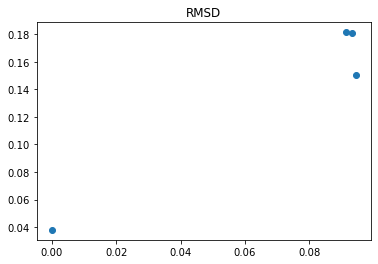

[H]c1c([H])c(-c2c([H])c(OC([H])([H])[H])c([H])c3nc(N([H])S(=O)(=O)c4c([H])c(Cl)c([H])c([H])c4Cl)oc23)c([H])c(N([H])[H])c1[H]
tensor(0.0152)


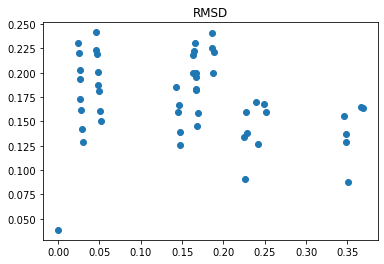

[H]c1c([H])c(/N=N/c2c(N([H])[H])nn([H])c2N([H])[H])c([H])c([H])c1F
tensor(0.0233)


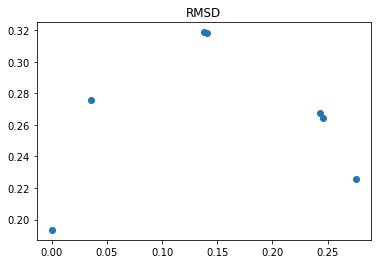

[H]c1nc(N([H])c2c([H])c([H])c([H])c(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c2[H])nc(N([H])c2c(Cl)c([H])c([H])c3c2OC([H])([H])O3)c1[H]
tensor(0.0056)


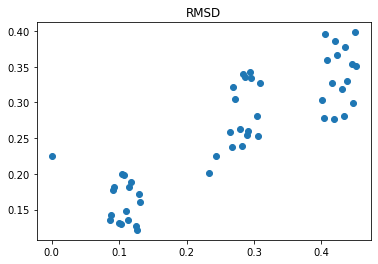

[H]OC([H])([H])C(N([H])C(=O)c1c([H])c([H])c2c(c1[H])c(-c1c([H])c3c([H])c([H])c([H])nc3n1[H])c([H])n2C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0030)


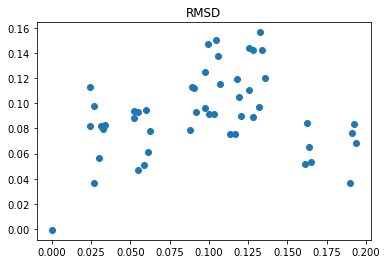

[H]c1nc(SC([H])([H])c2c([H])c([H])c(F)c([H])c2[H])n([H])n1
tensor(0.0467)


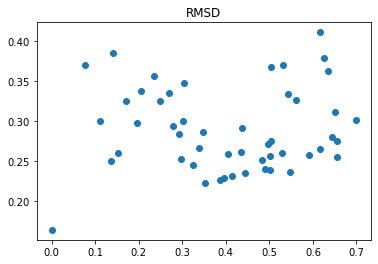

[H]c1sc(-c2noc(C3([H])C([H])([H])C([H])([H])N(C(=O)C([H])([H])n4nnc(C([H])([H])N([H])S(=O)(=O)c5c([H])c([H])c(I)c([H])c5[H])c4[H])C([H])([H])C3([H])[H])n2)c([H])c1[H]
tensor(0.0058)


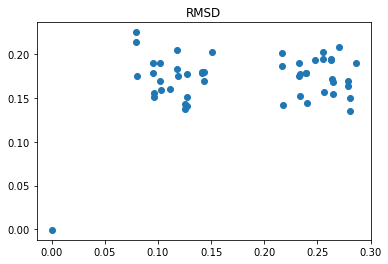

[H]Oc1c([H])c([H])c([H])c2c([H])c([H])c([H])nc12
tensor(0.0090)


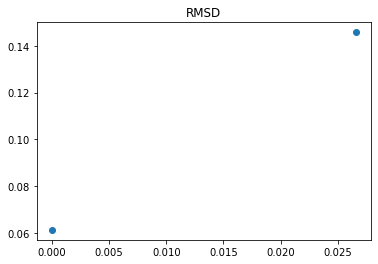

[H]Oc1nc(N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])[H])C([H])([H])C2([H])[H])sc1C([H])([H])c1c([H])c([H])c(Cl)c(Cl)c1[H]
tensor(0.0026)


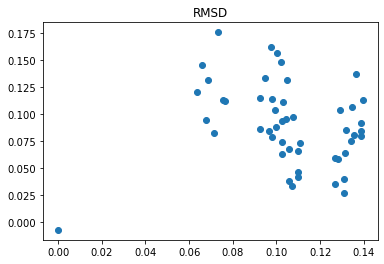

[H]c1c([H])c([H])c(C([H])([H])N(C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])N=[N+2]#N)C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])C(=O)N([H])C([H])([H])[H])=[N+]([H])[H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0070)


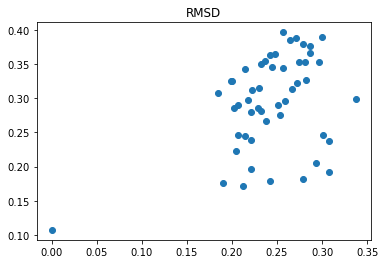

[H]Oc1c([H])c([H])c(/C([H])=C(\C#N)[C@@]([H])(O[H])[N+]([H])([H])[H])c([H])c1O[H]
tensor(0.0270)


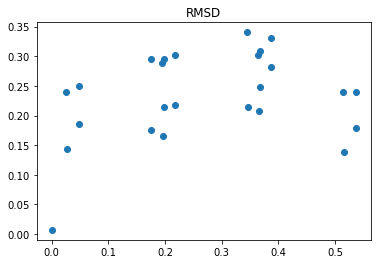

[H]O[C@@]([H])(C(=O)[O-])C([H])([H])C(=O)C([H])([H])/C([H])=C1/N=C([H])C(C(=O)c2c([H])c([H])c(F)c([H])c2[H])=C1[H]
tensor(0.1090)


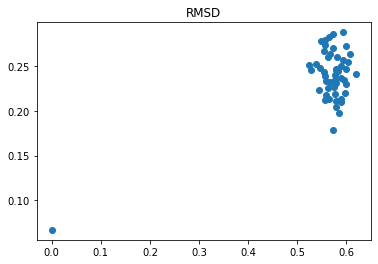

[H]c1c([H])c([H])c(-c2c([H])c([H])c3c(=O)n(C([H])([H])[C@]4([H])O[C@]([H])(c5c([H])c([H])c([H])c([H])c5[H])C([H])([H])C4([H])[H])c(=[N+]([H])[H])n([H])c3c2[H])c([H])c1[H]
tensor(0.0233)


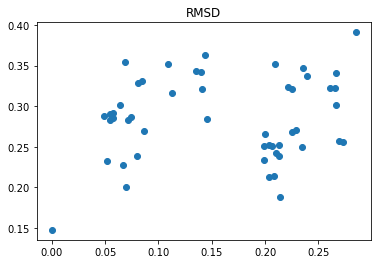

[H]c1nc([H])c(N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1-c1c([H])c([H])c([H])c2c1c([H])c([H])n2[H]
tensor(0.0112)


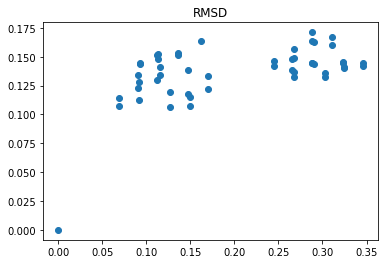

[H]OC([H])([H])[C@@]([H])(C(=O)N([H])c1c([H])c([H])c(Oc2c([H])c([H])c3c(c2[H])c(C#N)c(N([H])[H])n3[H])c([H])c1[H])[N+]([H])([H])[H]
tensor(0.0071)


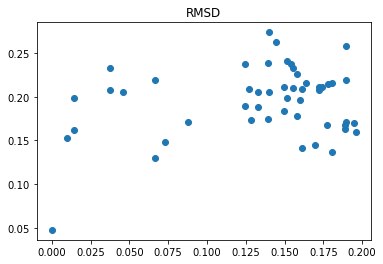

[H]c1c([H])c([H])c2c(C([H])([H])n3c([H])nc4sc5c(c4c3=O)C([H])([H])C([H])([H])[C@@]([H])([N+]([H])([H])C([H])([H])c3c(C([H])([H])[H])noc3C([H])([H])[H])C5([H])[H])c([H])c([H])c(OC([H])([H])[H])c2c1[H]
tensor(0.0032)


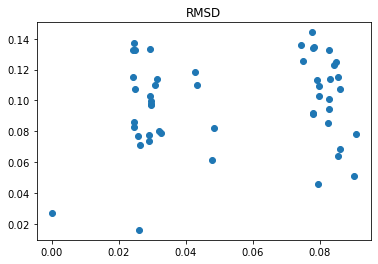

[H]c1c([H])c([H])c(-c2noc(C([H])(C([H])([H])[H])C([H])([H])[H])c2C(=O)N([H])[C@@]([H])(c2c([H])c([H])c3c([H])c([H])c([H])c([H])c3c2[H])C([H])([H])[H])c(Cl)c1[H]
tensor(0.0068)


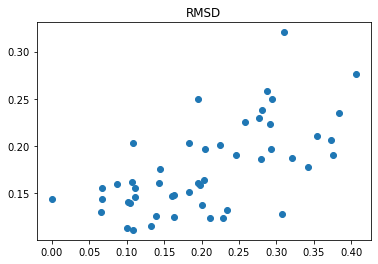

[H]c1c([H])c([H])c(C([H])([H])[N@+]2([H])C([H])([H])C([H])([H])[C@@](C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])C3([H])C([H])([H])C3([H])[H])(c3c([H])c([H])c(Br)c([H])c3[H])C([H])([H])C2([H])[H])c(C(F)(F)F)c1[H]
tensor(0.0162)


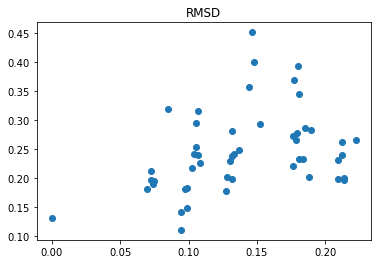

[H]c1c([H])c(N([H])C(=O)C([H])([H])C([H])([H])[H])c([H])c([H])c1C(=O)c1sc(N([H])c2c([H])c([H])c(N3C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c2OC([H])([H])[H])nc1N([H])[H]
tensor(0.0036)


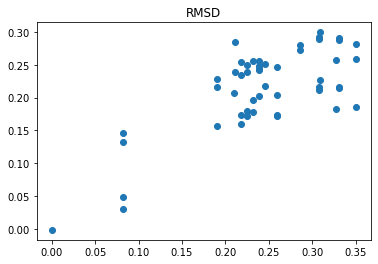

[H]O[C@@]([H])(/C([H])=C(\[H])C([H])([H])[H])[C@@](C(=O)OC([H])([H])[H])(C([H])([H])[H])[C@@]1([H])OC(=O)c2nc(oc2[H])/C([H])=C([H])/C([H])=C([H])/C([H])=C(/[H])C([H])([H])[C@@]([H])([C@](C(=O)OC([H])([H])[H])(C([H])([H])[H])[C@@]([H])(O[H])/C([H])=C(\[H])C([H])([H])[H])OC(=O)c2nc(oc2[H])/C([H])=C([H])/C([H])=C([H])/C([H])=C(/[H])C1([H])[H]
tensor(0.2470)


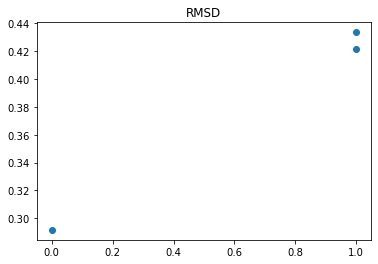

[H]/C(=C1/C(=O)N([H])c2c([H])c([H])c([H])c([H])c21)N([H])c1c([H])c([H])c(S(=O)(=O)N([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0169)


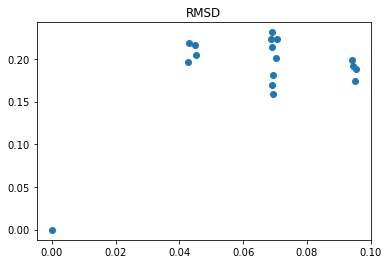

[H]c1c([H])c([H])c(-c2c(-c3nnc4c(c(N([H])[H])nn4C([H])([H])C([H])([H])C([H])([H])[H])c3[H])c3c([H])c([H])c([H])c([H])c3n2[H])c([H])c1[H]
tensor(0.0044)


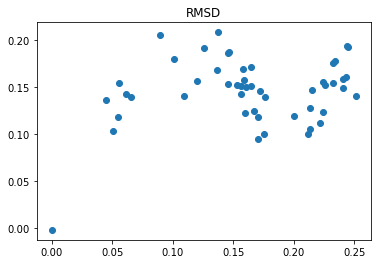

[H]c1c([H])c(Cl)c(C(=O)c2c([H])c([H])c3nc(N([H])c4c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c4[H])c([H])n3c2[H])c(Cl)c1[H]
tensor(0.0123)


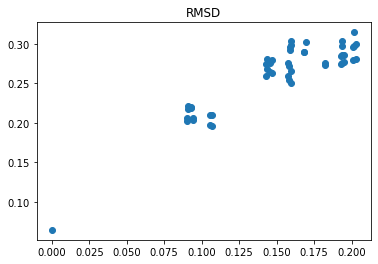

[H]Oc1c([H])c([H])c([C@]2([H])OC([H])([H])[C@@]3(C([H])([H])O[H])[C@]([H])(C([H])([H])[H])C([H])=C(C([H])([H])[H])[C@]2([H])[C@@]3([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0047)


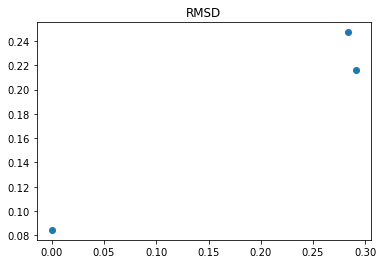

[H]ON([H])S(=O)(=O)N([H])[H]
tensor(0.1358)


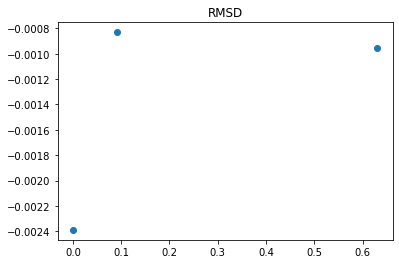

[H]c1c([H])c(C([H])([H])N([H])C(=O)[C@@]2([H])N(C(=O)C([H])([H])C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C([H])([H])C2([H])[H])c([H])c([H])c1C(N([H])[H])=[N+]([H])[H]
tensor(0.0093)


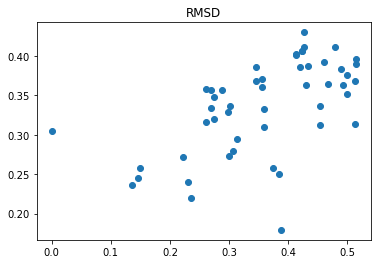

[H]c1c([H])c([H])c([C@@]2([H])C([H])([H])[C@]2([H])N([H])C(=O)c2c([H])c([H])c(C#N)c([H])c2[H])c([H])c1[H]
tensor(0.0105)


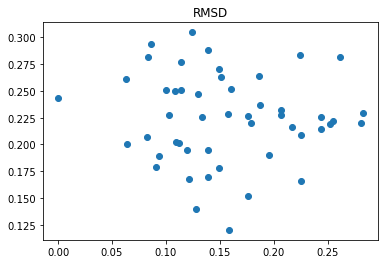

[H]c1c([H])c(Cl)c([H])c([C@]([H])(OC([H])([H])C([H])([H])N([H])C(=O)OC([H])([H])[H])[C@@]2([H])C([H])([H])N(C(=O)N([H])[C@@]([H])(C([H])([H])[C@]3([H])C([H])([H])OC([H])([H])C([H])([H])C3([H])[H])C([H])([H])[N+]([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0102)


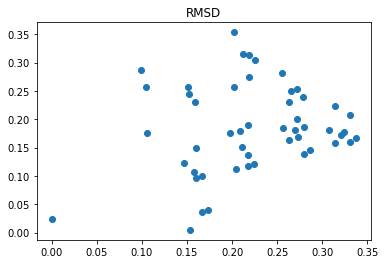

[H]c1oc(C([H])([H])N([H])c2c([H])c(Cl)c(S(=O)(=O)N([H])[H])c([H])c2C(=O)[O-])c([H])c1[H]
tensor(0.0682)


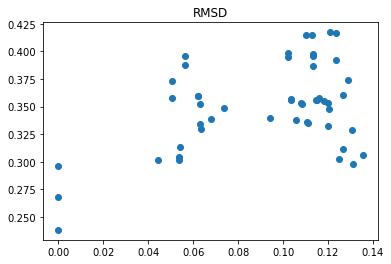

[H]OC([H])(C(=O)[O-])C([H])([H])C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])c1c([H])c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c1[H]
tensor(0.0076)


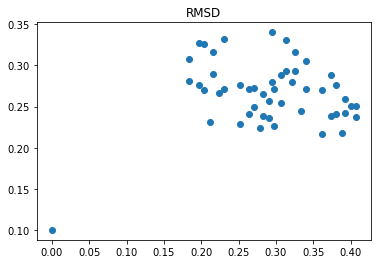

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C(=O)[C@@]([H])(OC(=O)c1c2c(nc3c([H])c([H])c([H])c([H])c13)C([H])([H])C([H])([H])[C@]([H])(C([H])([H])[H])C2([H])[H])C([H])([H])[H]
tensor(0.0196)


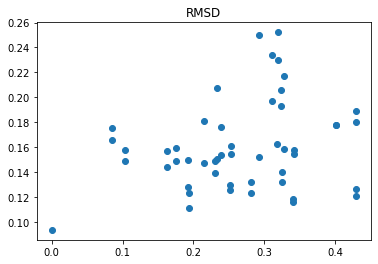

[H]c1nc(N([H])c2c([H])c([H])c([H])c(N3C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C3([H])[H])c2[H])nc(-c2sc(N([H])C([H])([H])[H])nc2C([H])([H])[H])c1C#N
tensor(0.0065)


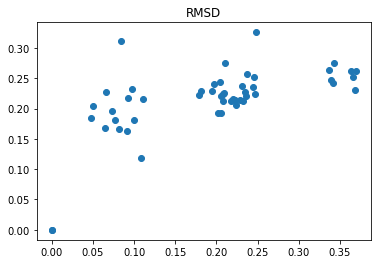

[H]Oc1c([H])c([H])c(-c2nc3c([H])c([H])c([H])c(C(=O)N([H])[H])c3n2[H])c([H])c1[H]
tensor(0.0102)


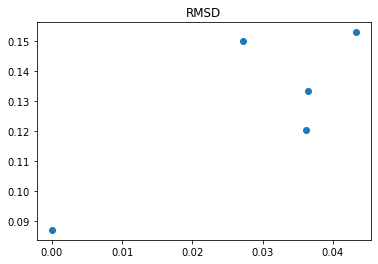

[H]c1sc(C([H])([H])N([H])S(=O)(=O)C([H])([H])C([H])([H])C([H])([H])[H])nc1-c1c([H])c([H])c(C(=O)N([H])C([H])([H])C([H])([H])C(F)(F)F)c([H])c1[H]
tensor(0.0048)


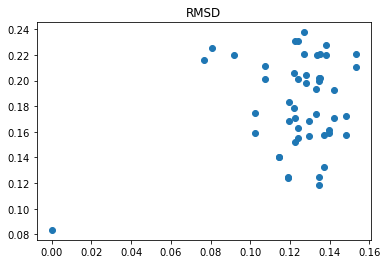

[H]c1sc2nc([H])n([H])c(=O)c2c1C(=O)N([H])C([H])([H])c1c([H])c([H])c(C([H])([H])[N+]([H])([H])[H])c([H])c1[H]
tensor(0.0162)


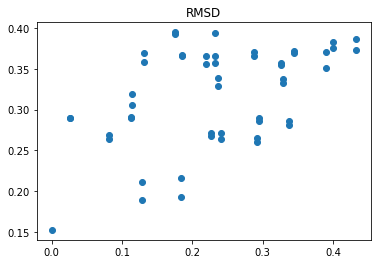

[H]OC([H])([H])C([H])(C([H])([H])O[H])C([H])([H])[N+]([H])([H])[C@@]([H])(C(=O)[O-])C(C([H])([H])[H])(C([H])([H])[H])S([H])(=O)=O
tensor(0.0215)


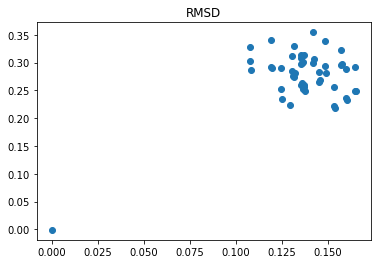

[H]Oc1c(F)c([H])c(/C([H])=C2\N=C(C([H])([H])[H])N(C([H])([H])[H])C2=O)c([H])c1F
tensor(0.0029)


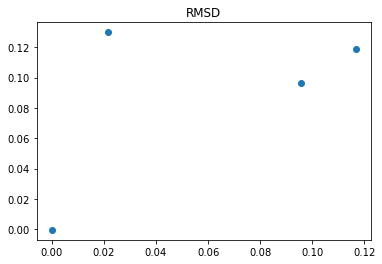

[H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])OC(C(=O)[O-])=C([H])[C@]([H])(O[H])[C@@]1([H])[N+]([H])([H])[C@]([H])(O[H])C([H])([H])[H]
tensor(0.0092)


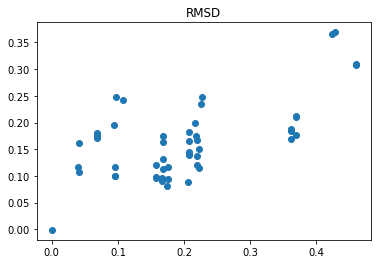

[H]c1nn([H])c(-c2c([H])c(C(=O)N([H])C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])n([H])c2[H])c1-c1c([H])c([H])c([H])c(Cl)c1[H]
tensor(0.0171)


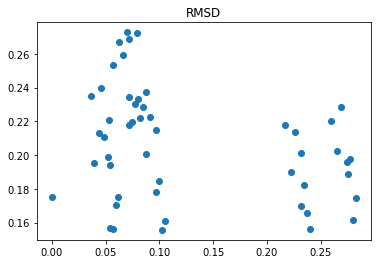

[H]c1c([H])c([H])c(-c2c(-c3c([H])c([H])c([H])c([H])c3[H])n([H])c3c(C(=O)[O-])c([H])c([H])c([H])c23)c([H])c1[H]
tensor(0.0034)


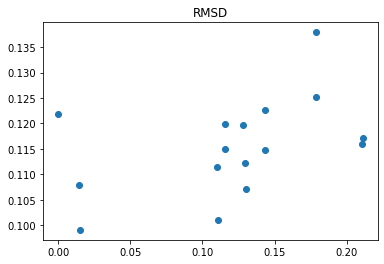

[H]C1=C([H])C([H])([H])c2c([H])c([H])c([H])c3c([C@]4([H])C(=O)N([H])C(=O)[C@@]4([H])c4c([H])n([H])c5c([H])c([H])c([H])c([H])c45)c([H])n1c23
tensor(0.0145)


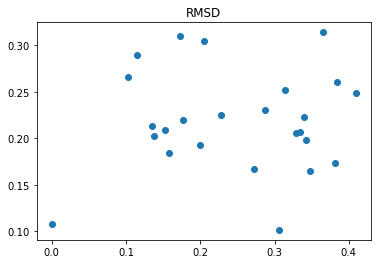

[H]c1sc(S(=O)(=O)N([H])[H])c([H])c1-c1nc2c([H])c([H])c([H])c([H])c2s1
tensor(0.0707)


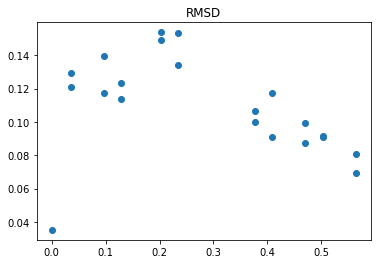

[H]c1nc(N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])c3c([H])c(OC([H])([H])C(=O)N([H])C([H])([H])[H])c([H])c([H])c3-c3c([H])c([H])c(C#N)c([H])c3[H])C([H])([H])C2([H])[H])c([H])c([H])c1[H]
tensor(0.0029)


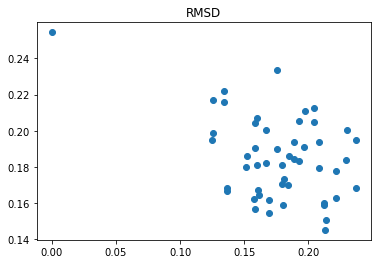

[H]Oc1c([H])c([H])c(/C([H])=C2\S/C(=N\c3c([H])c([H])c([H])c([H])c3Cl)N([H])C2=O)c([H])c1[N+](=O)[O-]
tensor(0.0228)


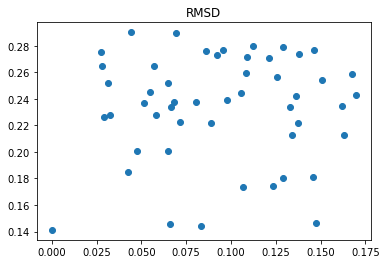

[H]c1nc(N([H])c2c([H])c(N([H])C(=O)C([H])([H])C([H])([H])[H])c([H])c([H])c2OC([H])([H])[H])nc(-c2c([H])n([H])c3c([H])c([H])c([H])c([H])c23)c1Cl
tensor(0.0072)


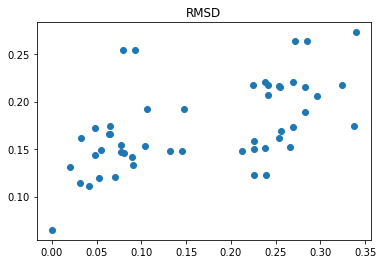

[H]c1sc(C([H])([H])[H])nc1-c1c([H])c([H])c(S(=O)(=O)N([H])C([H])([H])C([H])([H])C(F)(F)F)c([H])c1[H]
tensor(0.0016)


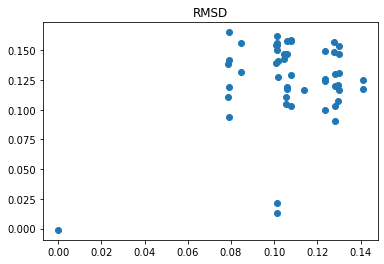

[H]c1c(C(=O)[O-])oc(-c2c([H])c([H])c(C(=S)N([H])C([H])([H])c3c([H])c([H])c(-c4c([H])c(C(=O)[O-])nn4-c4c([H])c([H])c(Cl)c(Cl)c4[H])c([H])c3[H])c([H])c2[H])c1[H]
tensor(0.0083)


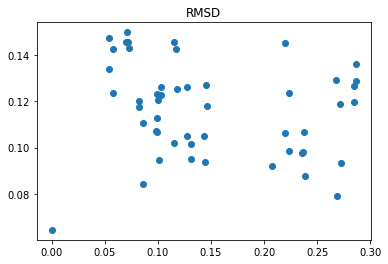

[H]c1nc([H])c2n([H])c(-c3c([H])c([H])c(-c4c(C([H])([H])[H])noc4C([H])([H])[H])c([H])c3[H])c(N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[n+]2c1[H]
tensor(0.0061)


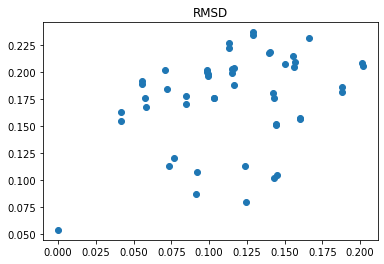

[H]c1nc2c([H])c(-c3c([H])c([H])c(N(C([H])([H])[H])C([H])([H])[H])c([H])c3[H])nc(N([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c2c([H])c1[H]
tensor(0.0044)


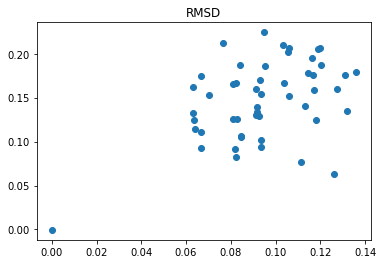

[H]C([H])(C(=O)[O-])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0281)


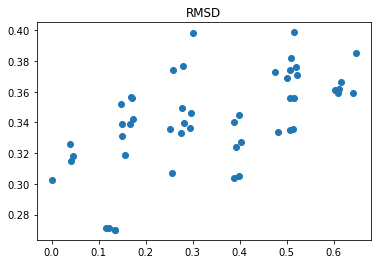

[H]c1c([H])c(-c2c(C#N)c(N([H])[H])nc3sc(C(=O)N([H])[H])c(N([H])[H])c23)c([H])c(OC([H])([H])C([H])([H])C([H])([H])C(=O)[O-])c1OC([H])([H])[H]
tensor(0.0140)


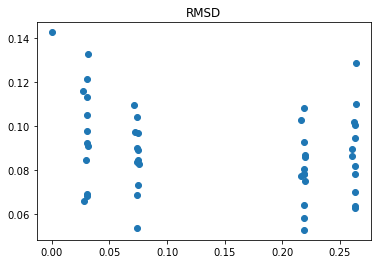

[H]Oc1c([H])c(C(=O)[O-])nc2c([H])c(Cl)c([H])c(Cl)c12
tensor(0.0257)


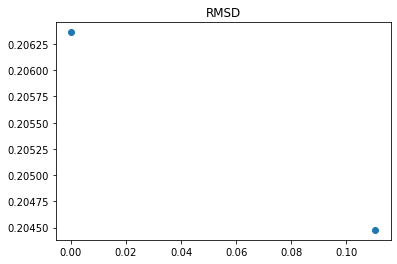

[H]c1c(Cl)sc(-c2nnc(S(=O)(=O)N([H])[C@]3([H])C(=O)N([C@]([H])(C(=O)N4C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])C([H])([H])[H])C([H])([H])C3([H])[H])n2[H])c1[H]
tensor(0.0103)


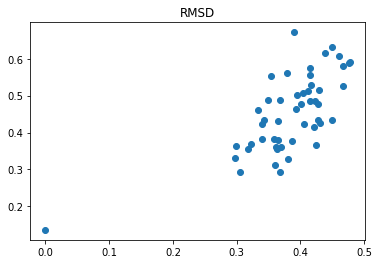

[H]c1nc(N([H])[H])c2nc(-c3c(-c4c([H])c([H])c([H])c([H])c4[H])nc([H])n3C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])sc2n1
tensor(0.0133)


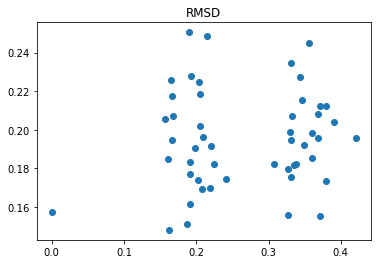

[H]n1snc(C([H])([H])[C@]([H])(C(=O)[O-])[N+]([H])([H])[H])c1=O
tensor(0.0859)


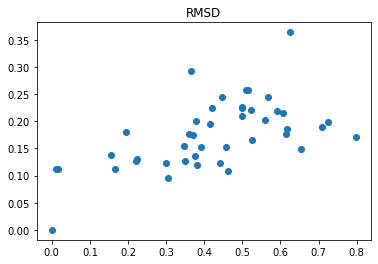

[H]O[C@@]([H])([C@]([H])(O[H])/C([H])=C(\[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(OC([H])([H])[H])C(=O)N([H])C([H])([H])C([H])([H])Oc1c(C([H])([H])[H])c([H])c(C([H])([H])[H])c([H])c1C([H])([H])[H]
tensor(0.0109)


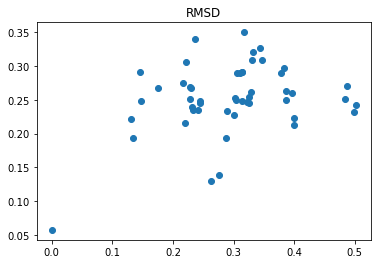

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])O[C@@]([H])(O[C@@]3([H])[C@]([H])(O[H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]3([H])C([H])([H])O[H])[C@]([H])(O[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0065)


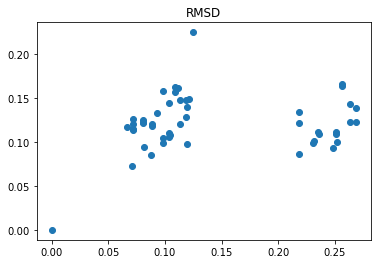

[H]c1c([H])c(-c2c([H])c([H])c([H])c3c(C([H])([H])C([H])([H])C([H])([H])Oc4c([H])c([H])c([H])c5c([H])c([H])c([H])c([H])c45)c(C(=O)[O-])nn23)c([H])c([H])c1C(=O)[O-]
tensor(0.0102)


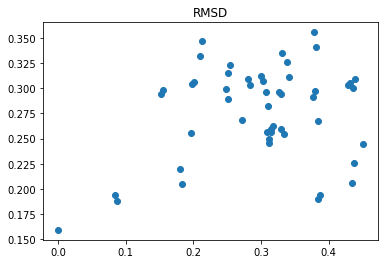

[H]OC(C([H])([H])[H])(C([H])([H])[H])[C@]1([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])c2nc3c(N4C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])nc(-n4c(N(C([H])([H])[H])C([H])([H])[H])nc5c([H])c([H])c([H])c([H])c54)nc3n2C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0083)


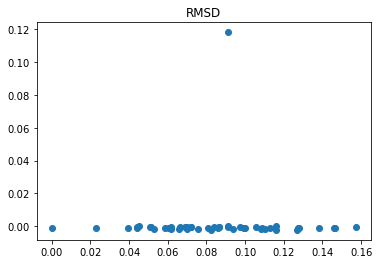

[H]OB(O[H])(O[H])~[C]([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@](C(=O)[O-])([C@]1([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])c2c([H])c([H])c(Cl)c(Cl)c2[H])C([H])([H])C1([H])[H])[N+]([H])([H])[H]
tensor(0.0028)


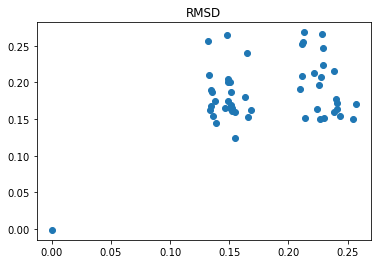

[H]c1c(C(=O)[O-])oc(-c2c([H])c([H])c3c(=S)n(C([H])([H])c4c([H])c([H])c(-c5c([H])c(C(=O)[O-])nn5-c5c([H])c([H])c(Cl)c(Cl)c5[H])c([H])c4[H])c([H])c([H])c3c2[H])c1[H]
tensor(0.0048)


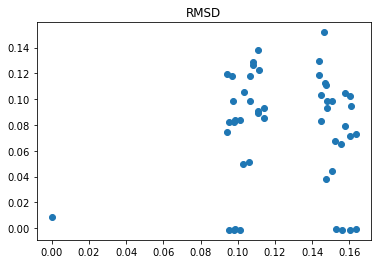

[H]c1c([H])c(C([H])([H])[H])c([H])c([H])c1-c1nc2c([H])c([H])c([H])c([H])c2c(=O)n1[H]
tensor(0.0011)


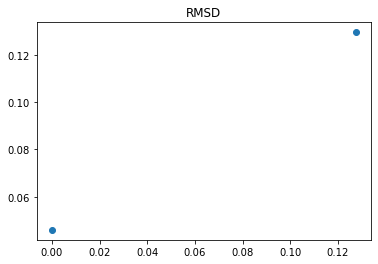

[H]OC([H])([H])C(=O)N(C([H])([H])C([H])([H])[H])[C@]1([H])C(c2c([H])c([H])c(Cl)c([H])c2[H])=NN(/C(N([H])c2c([H])c([H])c([H])c(OC([H])(F)F)c2[H])=[N+](\[H])C#N)C1([H])[H]
tensor(0.0173)


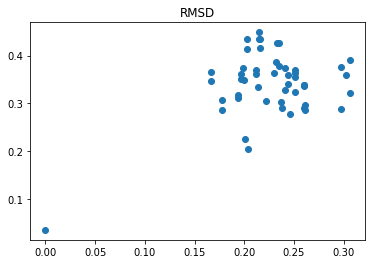

[H]Oc1c([H])c(O[H])c(C(=O)OC([H])([H])[H])c(C([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])c2c([H])c([H])c(F)c([H])c2[H])c1Cl
tensor(0.0098)


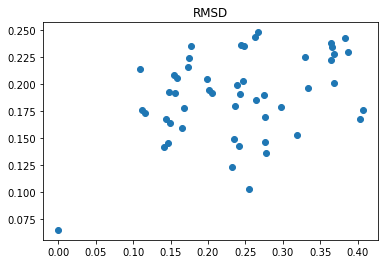

[H]SC([H])([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])c1c([H])c([H])c(OC([H])([H])[H])c([H])c1[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0044)


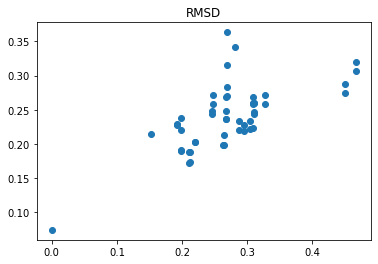

[H]c1c([H])c2c(c([H])c1Cl)[C@@](C#CC1([H])C([H])([H])C1([H])[H])(C(F)(F)F)OC(=O)N2[H]
tensor(0.0065)


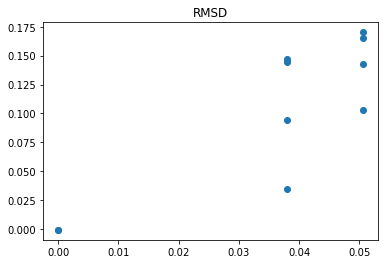

[H]c1c(I)c(=O)n([H])c(=O)n1C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H]
tensor(0.0844)


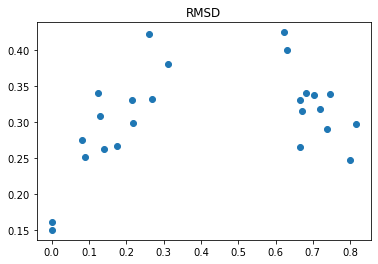

[H]Oc1c([H])c(O[H])c(C(=O)OC([H])([H])[H])c(C([H])([H])C([H])([H])C(=O)N([H])C2=C([H])C(=O)C(OC([H])([H])[H])=C([H])C2=O)c1Cl
tensor(0.0569)


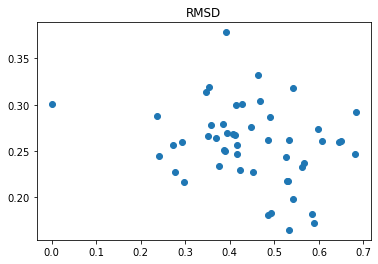

[H]OC1=C([H])C(=O)O[C@](C([H])([H])C([H])([H])c2c([H])c([H])c(OC([H])(C([H])([H])[H])C([H])([H])[H])c(F)c2[H])(C2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C1([H])[H]
tensor(0.0230)


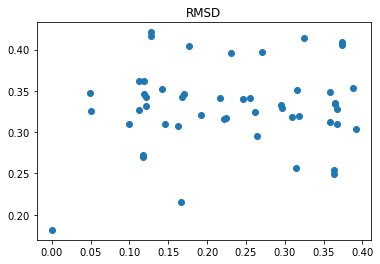

[H]c1c(Cl)c([H])c(N2C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1N([H])C(=O)c1c([H])c(C([H])([H])[H])c(OC([H])([H])C([H])([H])[N+]([H])([H])[H])c(C([H])([H])[H])c1[H]
tensor(0.0098)


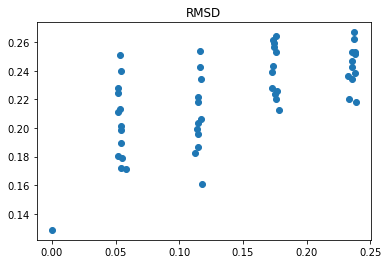

[H]O[C@]([H])(C([H])([H])C(=O)[O-])C([H])([H])C([H])([H])c1c([H])c([H])c(-c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0026)


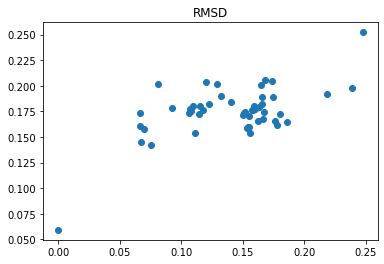

[H]/C(=C(\C#N)c1c(C(=O)OC([H])([H])C([H])([H])[H])n(C([H])([H])[H])c2c(Cl)c(Cl)c([H])c([H])c12)N([H])[H]
tensor(0.0206)


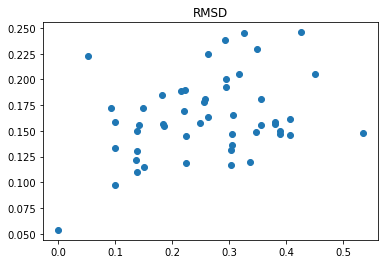

[H]C(=O)C([H])([H])/C([H])=N\[C@@]([H])(C(=O)[O-])[C@](C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])[S@+]([H])(=O)[O-]
tensor(0.0144)


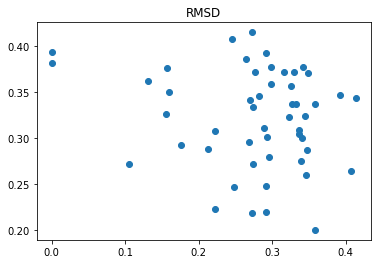

[H]c1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])sc(N2C([H])([H])C([H])([H])S(=O)(=O)C([H])([H])C2([H])[H])c1N([H])C(=O)N([H])c1c([H])c([H])c([H])c2c([H])c([H])c([H])c([H])c12
tensor(0.0181)


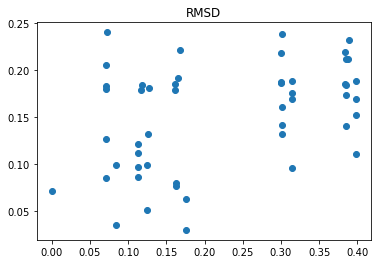

[H]OC([H])(c1sc(N([H])C([H])(C([H])([H])[H])C([H])([H])[H])nc1N([H])[H])c1c([H])nc([H])c([H])c1[H]
tensor(0.0037)


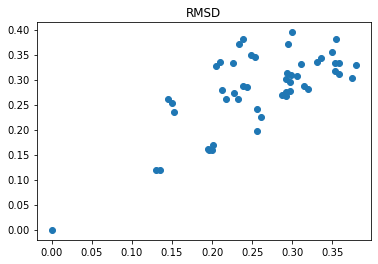

[H]C(=S)N([H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0086)


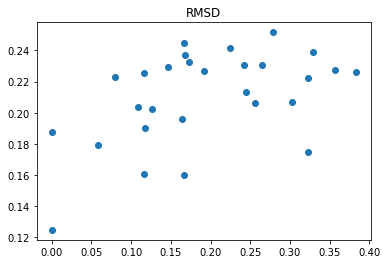

[H]Oc1c([H])c(C([H])=O)c([H])c([H])c1Oc1c([H])c([H])c(Cl)c([H])c1Cl
tensor(0.0155)


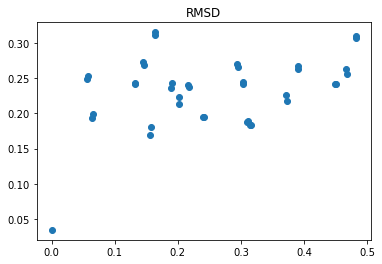

[H]c1nc([H])c(-c2c([H])c([H])c([H])c([C@]3(c4c([H])c([H])c([H])c([H])c4[H])C(=O)N(C([H])([H])[H])C(=[N+]([H])[H])N3[H])c2[H])c([H])c1[H]
tensor(0.0090)


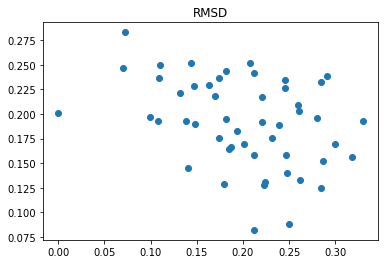

[H]O[C@@]1([H])[C@]([H])(C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2=C3C4=C5[C@@]2([H])[Fe+10]3452678C3=C2C6([H])C7=C38)[N+]([H])([H])[C@@]([H])(C([H])([H])[H])[C@@]1([H])O[H]
tensor(0.0469)


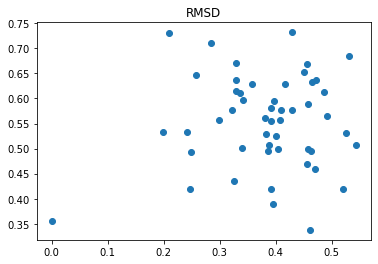

[H]Oc1c([H])c([H])c(C([H])([H])[H])c([H])c1S[H]
tensor(0.0307)


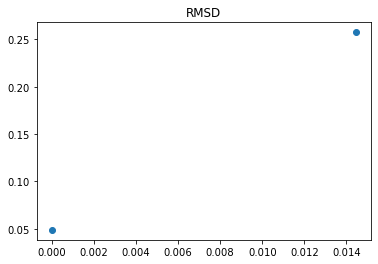

[H]OC([H])([H])c1c([H])c([H])c(F)c(-c2c([H])nc(N3C([H])([H])C([H])([H])C([H])(C(=O)[O-])C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
tensor(0.0041)


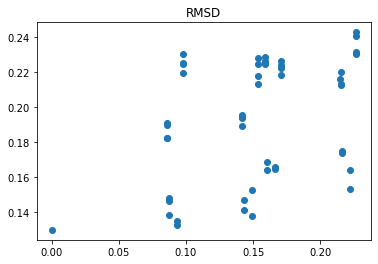

[H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c([H])c3c2N([H])[C@]([H])(C([H])([H])[H])C([H])([H])C(=O)N3[H])c([H])c1[H]
tensor(0.0155)


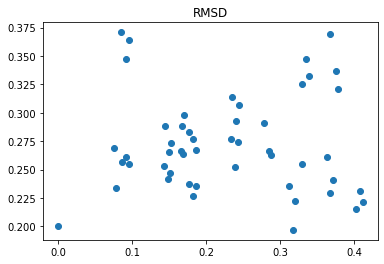

[H]c1nc(N([H])c2c([H])c([H])c(C(=O)[O-])c([H])c2[H])nc2c1C([H])([H])N=C(c1c(F)c([H])c([H])c([H])c1F)c1c([H])c(Cl)c([H])c([H])c1-2
tensor(0.0020)


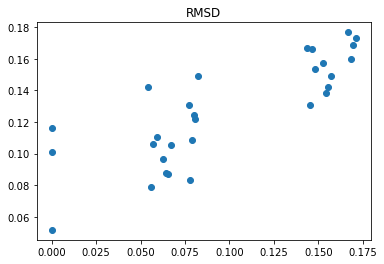

[H]c1c([H])c(-c2c([H])c([H])c(N([H])[H])c(N([H])C(=O)[C@@]3([H])C([H])([H])[C@@]4([H])O[C@]([H])(C([H])([H])C4([H])[H])C3([H])[H])c2[H])c([H])c([H])c1F
tensor(0.0057)


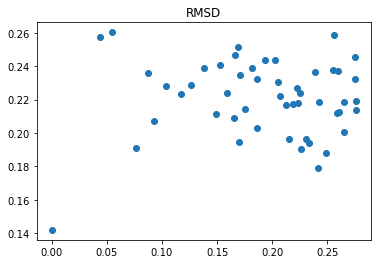

[H]c1c([H])c([H])c([C@@]2(C([H])([H])[H])C([H])([H])C(=O)N(C([H])([H])C([H])([H])Oc3c([H])c([H])c(F)c(C#N)c3[H])C2([H])[H])c([H])c1[H]
tensor(0.0237)


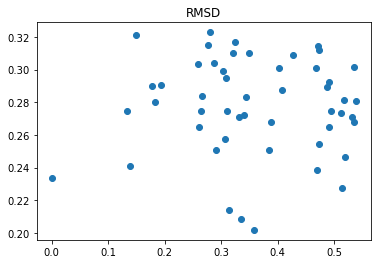

[H]C1=C([H])[C@]([H])(N(c2c([H])c([H])c(Cl)c([H])c2[H])C([H])([H])[H])c2c([H])c([H])c([H])c([H])c2N1C([H])([H])c1c([H])c([H])c(-c2c([H])c([H])c(C([H])([H])N3c4c([H])c([H])c([H])c([H])c4C(N(c4c([H])c([H])c(Cl)c([H])c4[H])C([H])([H])[H])=C([H])C3([H])[H])c([H])c2[H])c([H])c1[H]
tensor(0.0118)


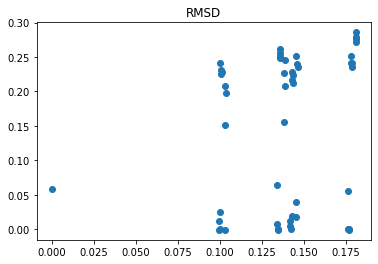

[H]O[C@]1([H])C(=O)N(C([H])([H])C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2c([H])c([H])c([H])c([H])c21
tensor(0.0152)


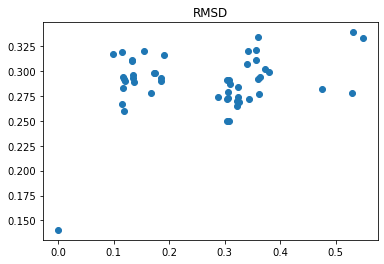

[H]c1nc2c([H])c([C@]([H])(OC([H])([H])C([H])([H])C([H])([H])[H])c3c([H])c([H])c([H])c([H])c3Cl)n([H])c2c(C(=O)[O-])c1[H]
tensor(0.0143)


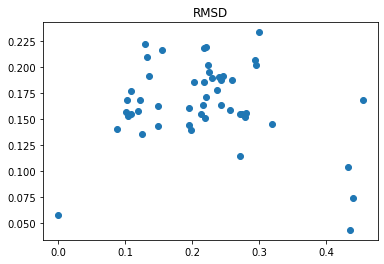

[H]O[C@]1([H])[C@@]([H])(C(=O)[O-])O[C@@]([H])([N@+]2([H])C([H])([H])C([H])([H])[N@@+]([H])([C@]3([H])c4c([H])c(Cl)c([H])c([H])c4Oc4c([H])c([H])c([H])c([H])c4N3[H])C([H])([H])C2([H])[H])[C@]([H])(O[H])[C@@]1([H])O[H]
tensor(0.0139)


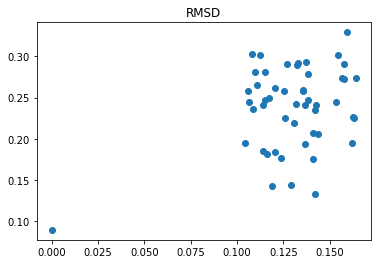

[H]C(=C(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])[C@@]1([H])C([H])([H])C([H])=C(C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0280)


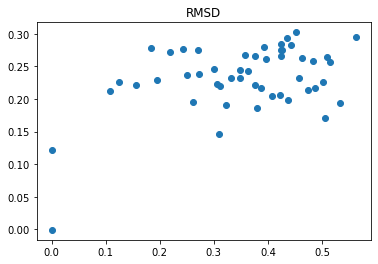

[H]c1sc(-c2nn(-c3c([H])c([H])c(F)c([H])c3[H])c(N([H])S(=O)(=O)c3c([H])c([H])c([H])c(F)c3[H])c2[H])c([H])c1[H]
tensor(0.0144)


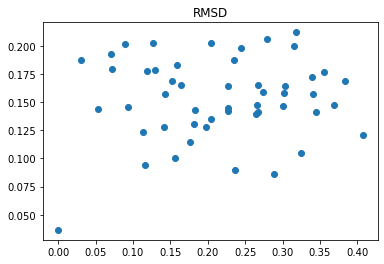

[H]Oc1c([H])c([H])c2c([H])c1Oc1c([H])c3c(c([H])c1OC([H])([H])[H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])[C@@]3([H])C([H])([H])c1c([H])c([H])c(c([H])c1[H])Oc1c(O[H])c(OC([H])([H])[H])c([H])c3c1[C@@]([H])(C2([H])[H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C3([H])[H]
tensor(0.0013)


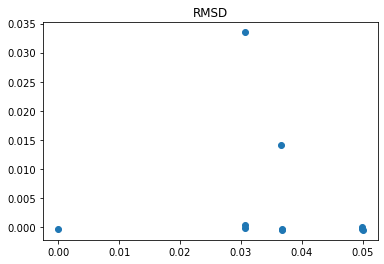

[H]c1c([H])c(F)c(-n2c(SC([H])([H])[H])nc3c([H])c([H])c([H])c([H])c3c2=O)c(F)c1[H]
tensor(0.0305)


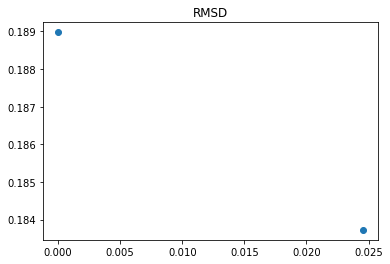

[H]C1=C([H])C([H])(C([H])([H])[C@@]([H])(C(=O)N([H])C([H])([H])C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])C2([H])C([H])=C([H])C([H])(C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C2([H])[H])C([H])([H])/C([H])=C(/[H])C([H])([H])N([H])C(=O)C([H])([H])c2c([H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])[H])=[N+]([H])[H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.1013)


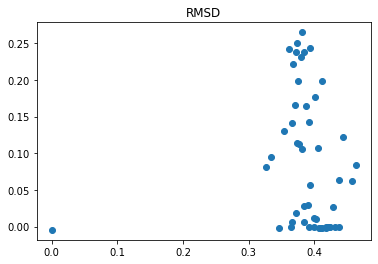

[H]c1c([H])c([H])c([C@]2([H])Sc3nnc([H])n3N=C2c2c([H])c([H])c3c(c2[H])N([H])C(=O)C([H])([H])O3)c([H])c1[H]
tensor(0.0139)


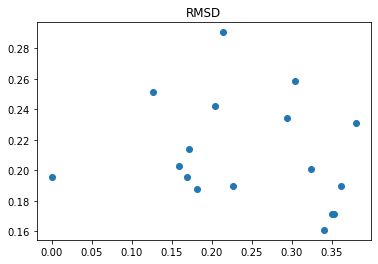

[H]c1nc(Cl)c([H])c([H])c1C([H])([H])n1c(N([H])[N+](=O)[O-])nc([H])c1[H]
tensor(0.0640)


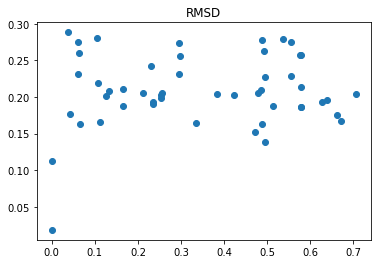

[H]c1c([H])c(-c2nc3nc(N([H])[H])nc(OC([H])([H])C4([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C4([H])[H])c3n2[H])c(C([H])([H])[H])c(S(=O)(=O)N([H])[H])c1[H]
tensor(0.0031)


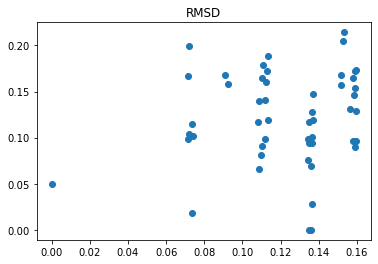

[H]Oc1c([C@]([H])(C([H])([H])[H])C([H])([H])C(=O)[O-])nnc2nc(N([H])[H])n([H])c(=O)c12
tensor(0.0146)


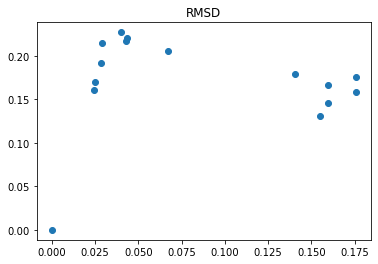

[H]c1nc(-c2nc3c([H])c(F)c([H])c([H])c3c(N3c4c(nc([H])c(N5C([H])([H])C([H])([H])OC([H])([H])C5([H])[H])c4[H])C4(C3([H])[H])C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])c2C([H])([H])[H])c([H])c([H])c1[H]
tensor(0.0401)


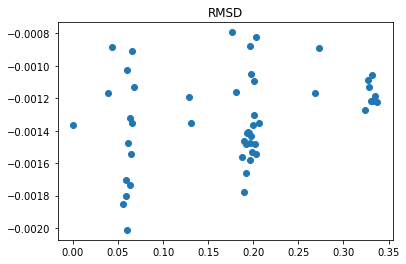

[H]OC([H])(C(=O)[O-])C([H])([H])C(=O)c1c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0020)


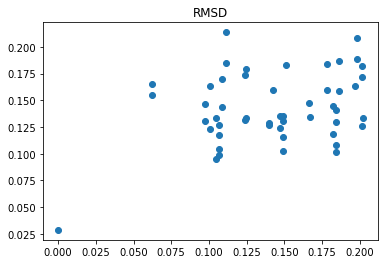

[H]O[C@@]1(/C([H])=C([H])/C(=C(/[H])C(=O)[O-])C([H])([H])[H])C(C([H])([H])[H])=C([H])C(=O)C([H])([H])C1(C([H])([H])[H])C([H])([H])[H]
tensor(0.0160)


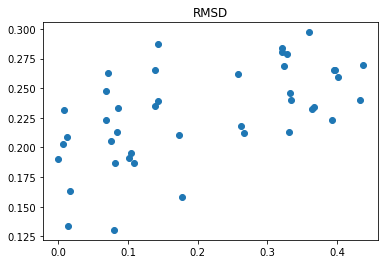

[H]c1nc(Oc2c([H])c([H])c3c(c2[H])c(=O)nc([H])n3C([H])([H])c2c([H])c([H])c(F)c([H])c2F)c(C(F)(F)F)c([H])c1[H]
tensor(0.0029)


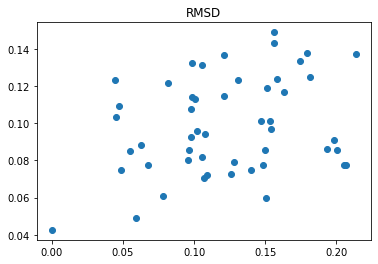

[H]c1nc2c([H])c(-c3c([H])nc(OC([H])([H])[H])nc3OC([H])([H])[H])c([H])c([H])c2c(N([H])c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])c1C(=O)N([H])[H]
tensor(0.0133)


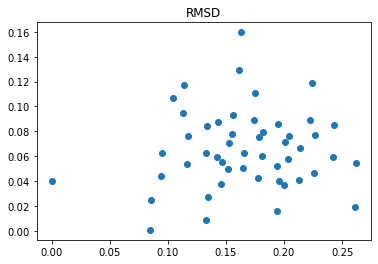

[H]c1c([H])c([H])c([C@@]([H])(N([H])C(=O)c2c([H])c([H])c3c(c2[H])c([H])c([H])n3S(=O)(=O)c2c([H])c([H])c([H])c3c([H])c([H])c([H])c([H])c23)C([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0023)


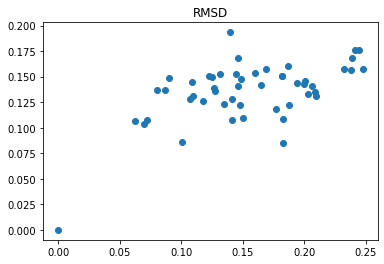

[H]Oc1c([H])c([H])c([H])c([H])c1C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])[C@]12C([H])([H])[C@@]3([H])C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C3([H])[H])C1([H])[H])C2([H])[H]
tensor(0.0178)


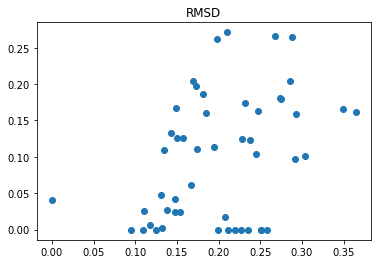

[H]C([H])=C1N([H])[C@@]([H])(C([H])([H])[H])[C@]([H])(C(=O)OC([H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(c2c([H])c([H])c([H])c([N+](=O)[O-])c2[H])[C@]1([H])C(=O)OC([H])([H])C([H])([H])OC([H])([H])[H]
tensor(0.0464)


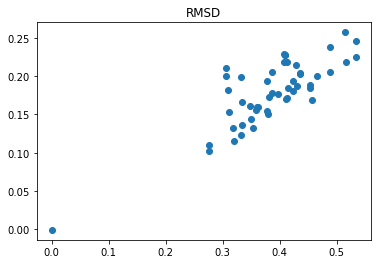

[H]c1nn([H])c2c1[C@@](c1c([H])c([H])c([H])c([H])c1[H])(C([H])([H])C([H])([H])[H])C1([H])C(=O)C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C1([H])N2[H]
tensor(0.0703)


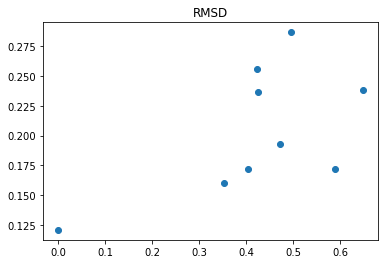

[H]O/C(C(=O)[O-])=C(/[H])C(=O)[C@]1(C([H])([H])c2c([H])c([H])c(Cl)c([H])c2[H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C1([H])[H]
tensor(0.0155)


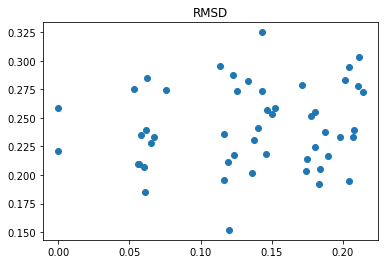

[H]c1c([H])c([H])c(OC([H])([H])C([H])([H])n2c([H])c([H])c(=O)n([H])c2=O)c(Oc2c([H])c(N(C(=O)C([H])([H])C([H])([H])[H])C([H])([H])[H])c3c([H])c([H])c(C#N)c([H])c3c2C([H])([H])[H])c1[H]
tensor(0.0141)


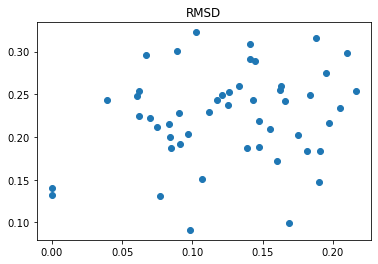

[H]c1c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c2c(N([H])[C@]3([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])nc(N(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H])nc12
tensor(0.0083)


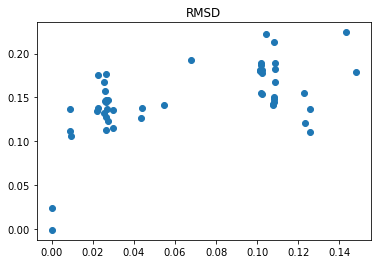

[H]c1nn(C([H])([H])[H])c([H])c1-c1nc(C(=O)N([H])C(N([H])[H])=[N+]([H])[H])c(N([H])[H])nc1N1C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0068)


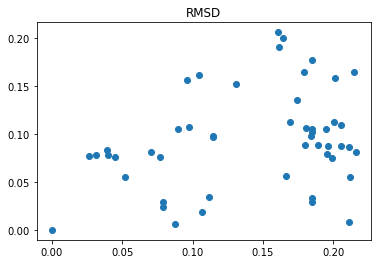

[H]c1c([H])c(C2(C(=O)N([H])[C@@]([H])(C(=O)[O-])C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C([H])([H])N(C(=O)[C@@]3([H])N(C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C2([H])[H])c([H])c([H])c1Br
tensor(0.0449)


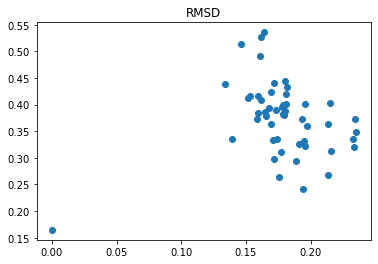

[H]c1nn([H])c(F)c1-c1c([H])c([H])c(Oc2c([H])c([H])c3c([H])c([H])c([H])c([H])c3c2[H])c(C(=O)[O-])c1[H]
tensor(0.0154)


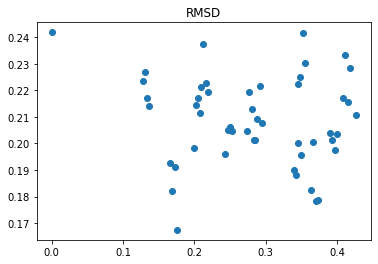

[H]c1c([H])c([H])c(S(=O)(=O)c2c([H])c([H])c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])c([H])c2[H])c([C@@]([H])(C(=O)[O-])C([H])([H])C([H])([H])C(=O)[O-])c1[H]
tensor(0.0039)


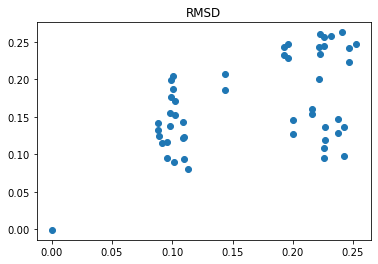

[H]Oc1c([H])c(O[H])c(C([H])([H])C([H])([H])[H])c([H])c1-c1c(-c2c([H])c([H])c([H])c([H])c2F)c(C([H])([H])[H])nn1[H]
tensor(0.0232)


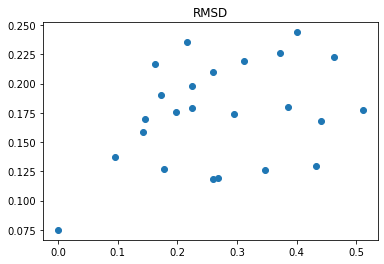

[H]c1c([H])c(C([H])([H])[C@@]2([H])C(=O)[C@]([H])(C([H])([H])c3c([H])c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c3[H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c([H])c1C(N([H])[H])=[N+]([H])[H]
tensor(0.0389)


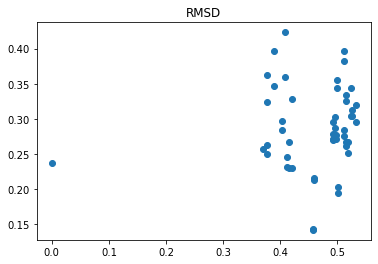

[H]c1c([H])c([H])c(C([H])([H])C2([H])C([H])([H])C([H])([H])N(C(=O)c3c([H])c4c([H])c(C(N([H])[H])=[N+]([H])[H])c([H])c([H])c4n3[H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0016)


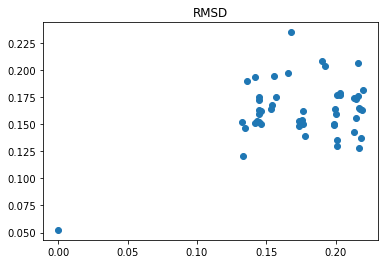

[H]Oc1c([H])c([H])c([H])c([C@]([H])(C([H])([H])[H])[N+]([H])(C([H])([H])[H])C([H])([H])[H])c1[H]
tensor(0.0659)


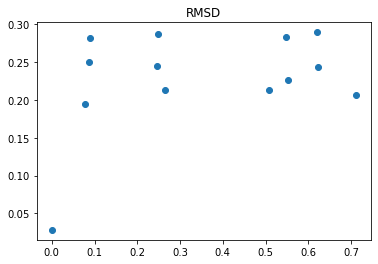

[H]O[C@]([H])(C([H])([H])[N+]([H])([H])C([H])([H])c1c([H])c([H])c([H])c(OC([H])([H])[H])c1[H])[C@@]([H])(N([H])C(=O)c1c([H])c([H])c([H])c(C(=O)N(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H])c1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0320)


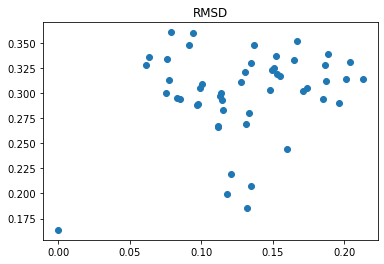

[H]C([H])([H])C(c1nnc(C(=O)[C@]2([H])C([H])([H])C([H])([H])C([H])([H])[N+]2([H])[H])o1)(C([H])([H])[H])C([H])([H])[H]
tensor(0.0165)


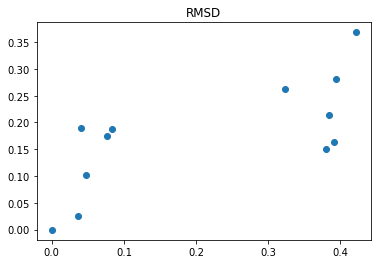

[H]O[C@]([H])(c1nc([H])c([H])s1)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)N([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])[H])=[N+]([H])[H]
tensor(0.0251)


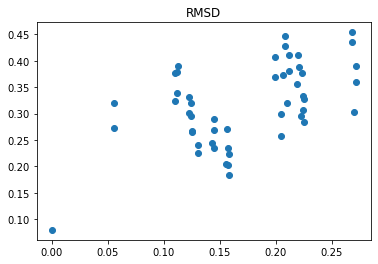

[H]Oc1c([H])c([H])c(C(=O)/N=N/C([H])([H])c2c(OC([H])([H])[H])c([H])c([H])c3c([H])c([H])c([H])c([H])c23)c([H])c1O[H]
tensor(0.0152)


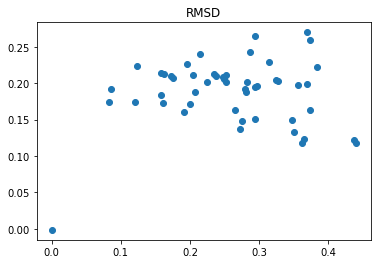

[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(O[C@]2([H])[C@@]([H])(C([H])([H])O[H])n3c(nc([H])c3[H])[C@]([H])(O[H])[C@@]2([H])O[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0066)


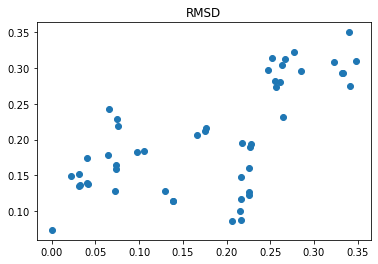

[H]c1nc([H])c([H])c(C([H])([H])N([H])c2c([H])c(-c3c([H])c([H])c([H])c(Cl)c3Cl)nc3c([H])c([H])nn23)c1[H]
tensor(0.0036)


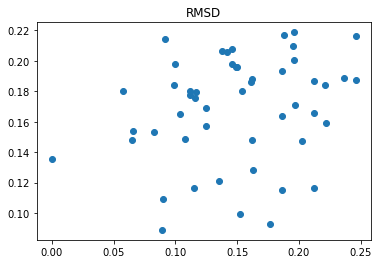

[H]c1c([H])c(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])c([H])c([H])c1N([H])c1nc(N([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.0062)


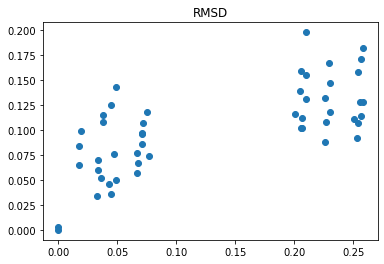

[H]O[C@@]1([H])[C@]([H])(O[H])[C@@]2([H])N(C(=S)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])[C@]([H])(OC2([H])[H])[C@]1([H])O[H]
tensor(0.0301)


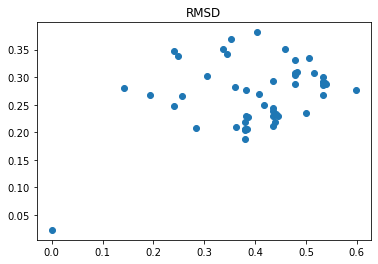

[H]OC1([H])C([H])([H])N(C2=Nc3c([H])c([H])c([H])c([H])c3C(c3c([H])c([H])c([H])c([H])c3[H])=N[C@]2([H])c2sc([H])c([H])c2[H])C1([H])[H]
tensor(0.0159)


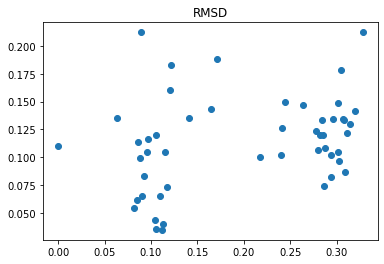

[H]c1c([H])c([H])c2c(c1[H])C([H])(O[C@@]1([H])C([H])([H])[C@]3([H])C([H])([H])C([H])([H])[C@]([H])(C1([H])[H])[N+]3(C([H])([H])[H])C([H])([H])[H])c1c([H])c([H])c([H])c([H])c1C([H])([H])C2([H])[H]
tensor(0.0073)


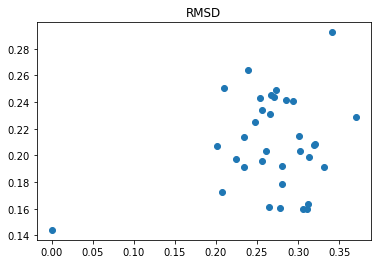

[H]c1c([H])c([H])c2c(nc3c4c([H])c([H])c(C(=O)[O-])c5c([H])c([H])c([H])c(c(=O)n32)c54)c1[H]
tensor(0.0086)


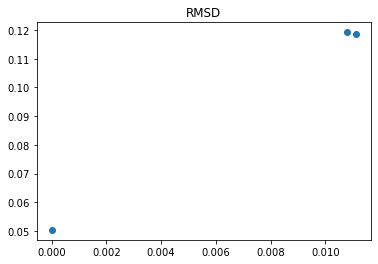

[H]O[C@@]1([H])C([H])([H])C([H])([H])[C@]23OC(=O)[C@@]1(C([H])([H])[H])[C@@]2([H])[C@]([H])(C(=O)[O-])[C@]12C([H])([H])C(=C([H])[H])[C@]([H])(C([H])([H])C([H])([H])[C@]13[H])C2([H])[H]
tensor(0.0355)


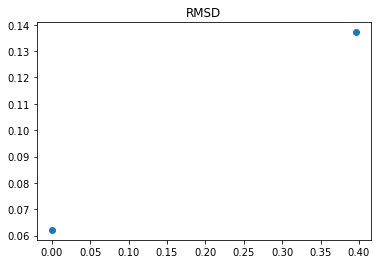

[H]c1sc(-c2noc(C3([H])C([H])([H])C([H])([H])N(C(=O)C([H])([H])c4sc([H])c([H])c4[H])C([H])([H])C3([H])[H])n2)c([H])c1[H]
tensor(0.0051)


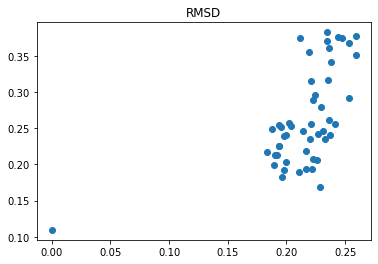

[H]c1nc(-c2c([H])c([H])c([H])c(C(=O)N([H])[H])c2[H])c([H])c(N([H])c2c([H])c([H])c(OC(F)(F)F)c([H])c2[H])n1
tensor(0.0140)


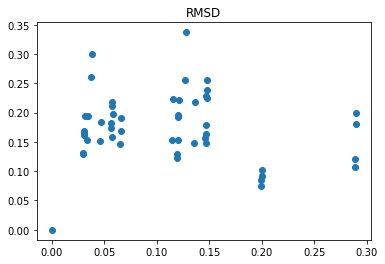

[H]Oc1c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c2c1[C@]1([H])C([H])=C(C([H])([H])[H])C([H])([H])C([H])([H])[C@@]1([H])C(C([H])([H])[H])(C([H])([H])[H])O2
tensor(0.0032)


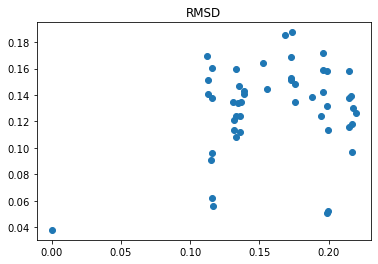

[H]c1nc2c([H])c([H])c([H])c([H])c2c(C([H])([H])N2C(=O)N(c3c([H])c([H])c(S(=O)(=O)C(F)(F)F)c([H])c3[H])C(=O)[C@]2([H])C([H])([H])[H])c1[H]
tensor(0.0078)


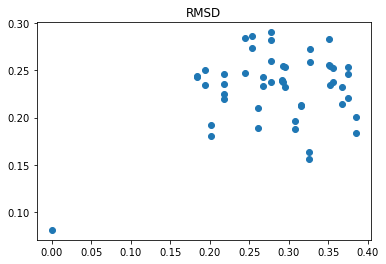

[H]c1sc(C(=O)N([H])S(=O)(=O)c2c([H])c([H])c(OC([H])([H])[H])c(C(=O)[O-])c2[H])c(SC([H])([H])c2c([H])c([H])c(Cl)c(Cl)c2[H])c1[H]
tensor(0.0120)


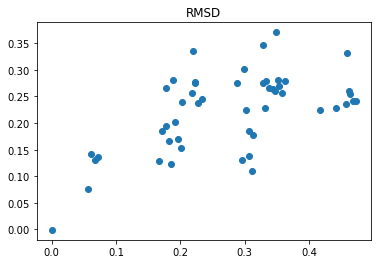

[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])N(C(=O)C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])c2c([H])c([H])c(Cl)c(Cl)c2[H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c2c1N([H])C(=O)C([H])([H])O2
tensor(0.0080)


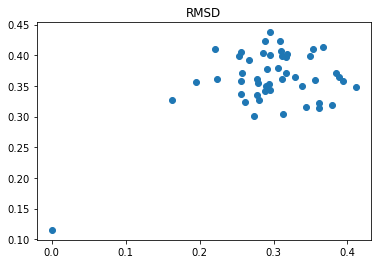

[H]c1c([H])c([H])c2c([H])c(C([H])([H])SC([H])([H])[C@@]([H])(C(=O)[O-])N([H])C(=O)C(=O)[O-])c([H])c([H])c2c1[H]
tensor(0.0181)


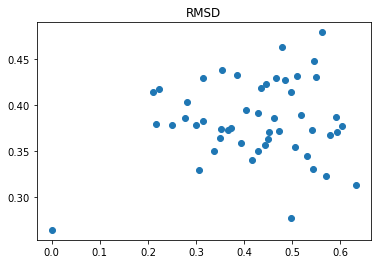

[H]O[C@@]1([H])C([H])([H])[C@]([H])(n2c([H])c([H])c(=O)n([H])c2=O)O[C@]1([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])(c1c([H])c([H])c([H])c([H])c1[H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0188)


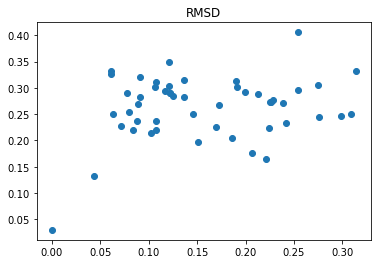

[H]Oc1c([H])c([H])c(N([H])c2nc(-c3c([H])c([H])c(Cl)c([H])c3[H])c([H])s2)c([H])c1[H]
tensor(0.0449)


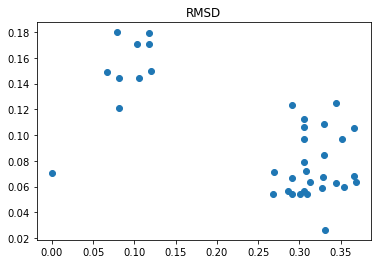

[H]c1c([H])c(C([H])([H])[H])c(S(=O)(=O)N([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1-c1c(C([H])([H])[H])noc1C([H])([H])[H]
tensor(0.0187)


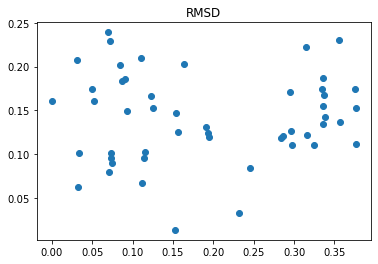

[H]c1c([H])c([H])c(C([H])([H])N([H])S(=O)(=O)c2c([H])c(N([H])C(=O)C([H])([H])C([H])([H])C(=O)[O-])c(OC([H])([H])[H])c([H])c2OC([H])([H])[H])c(N2C([H])([H])C([H])([H])C([H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C(=O)[O-])C([H])([H])C2([H])[H])c1[H]
tensor(0.0109)


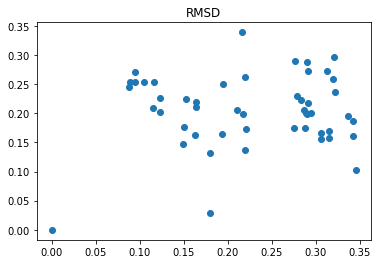

[H]c1nc([C@]([H])(n2c(=O)n([H])c3c([H])nc4c([H])c(-c5c(C([H])([H])[H])noc5C([H])([H])[H])c(OC([H])([H])[H])c([H])c4c32)C([H])([H])[H])c([H])c([H])c1[H]
tensor(0.0055)


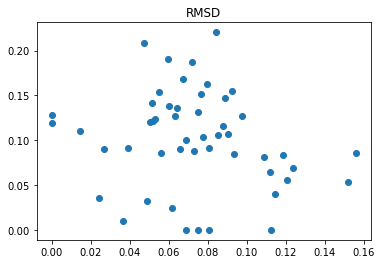

[H]c1nc2c([H])c(-c3c(C([H])([H])[H])noc3C([H])([H])[H])c(OC([H])([H])[H])nc2c(N([H])c2c([H])c([H])c([H])c([H])c2C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c1C(=O)[O-]
tensor(0.0084)


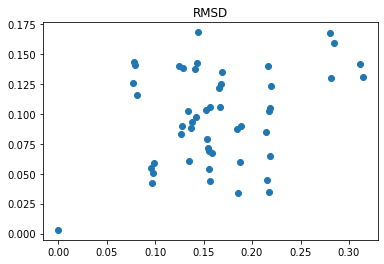

[H]Oc1c(OC([H])([H])[H])c([H])c2c(N([H])c3c([H])c([H])c(N([H])C(=O)c4c([H])c([H])c([H])c([H])c4[H])c([H])c3[H])nc([H])nc2c1[H]
tensor(0.0072)


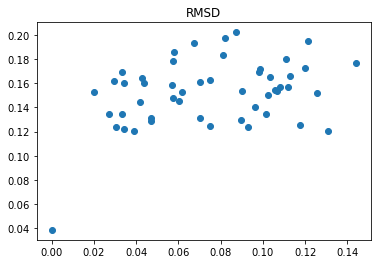

[H]c1nc([H])c(C([H])([H])C([H])([H])N([H])c2nc([H])c(Br)c(N([H])c3c([H])c(C([H])([H])[H])nn3[H])n2)c([H])c1[H]
tensor(0.0487)


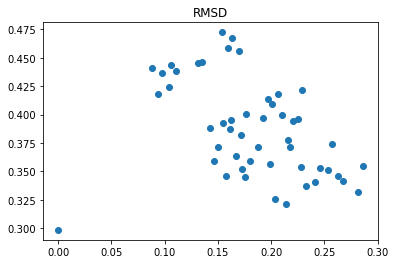

[H]OC([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])N(C(=O)c2c([H])c([H])c(-c3c([H])c([H])c4c(c3[H])-c3c(c([H])nn3[H])S(=O)(=O)N4C([H])([H])[H])c([H])c2[H])C([H])([H])C1([H])[H]
tensor(0.0010)


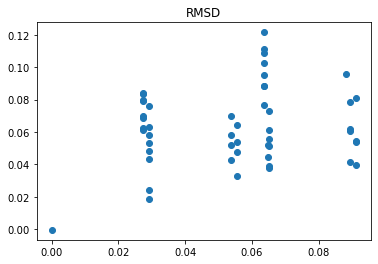

[H]Oc1nc2c([H])c(-c3c([H])c([H])c(F)c([H])c3[H])c([H])c([H])c2c([H])c1O[H]
tensor(0.0022)


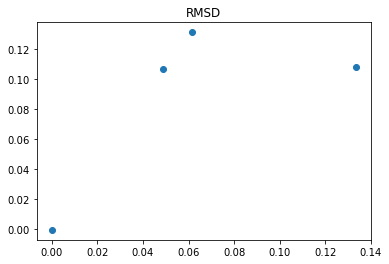

[H]C([H])=C([H])C(=O)N1C([H])([H])C([H])([H])[C@]([H])(N([H])c2nc(N([H])c3nc4c([H])c([H])c([H])nc4s3)c([H])c(C([H])([H])[N+]3([H])C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])n2)C1([H])[H]
tensor(0.0107)


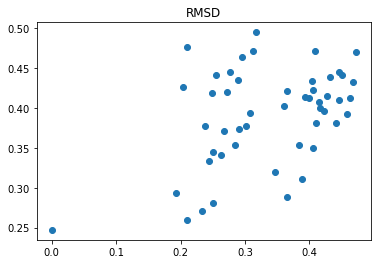

[H]c1c([H])c([H])c(Oc2c([H])c([H])c(S(=O)(=O)N([H])c3c([H])c(-c4c([H])c([H])c(C([H])([H])[H])c5c([H])c([H])c([H])c([H])c45)c([H])c([H])c3C(=O)[O-])c([H])c2[H])c([H])c1[H]
tensor(0.0089)


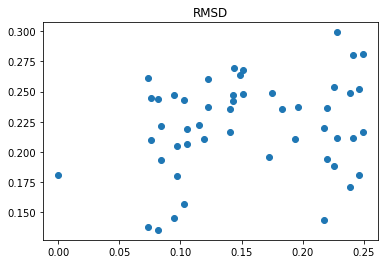

[H]O[C@]1([H])C([H])([H])C([H])([H])[C@]([H])(C(=O)[O-])[N@+]1([H])[C@]([H])(C(=O)[O-])C([H])([H])C([H])([H])C([H])([H])N([H])C(N([H])[H])=[N+]([H])[H]
tensor(0.0137)


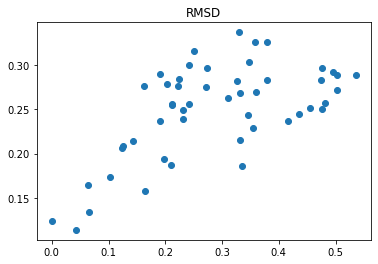

[H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])([H])[H])[C@@]([H])(OC(=O)N([H])[H])[C@@]([H])(OC(=O)C([H])([H])[H])[C@@]2([H])OC([H])([H])[H])[C@@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C1=O)[C@@]1([H])[C@@]([H])(C([H])([H])[H])C([H])=C([H])[C@]2([H])[C@]1([H])C(=C([H])[H])C([H])([H])C([H])([H])[C@@]2([H])O[C@]1([H])O[C@]([H])(C([H])([H])[H])[C@@]([H])(O[H])[C@](O[H])([C@@]([H])(N([H])C(=O)c2c(Cl)c(Cl)c(C([H])([H])[H])n2[H])C([H])([H])[H])C1([H])[H]
tensor(0.0484)


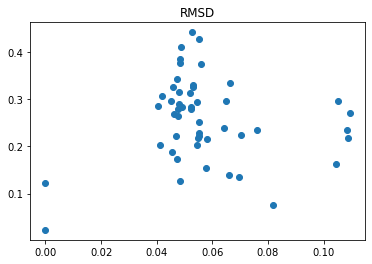

[H]c1c([H])c([H])c(N([H])[C@@]2([H])c3c([H])c(-c4c([H])c([H])c(C([H])([H])[N+]5([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C5([H])[H])c([H])c4[H])c([H])c([H])c3N(C(=O)C([H])([H])[H])[C@@]([H])(C([H])([H])[H])C2([H])[H])c([H])c1[H]
tensor(0.0206)


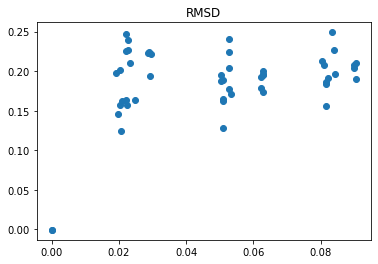

[H]ON([H])C(=O)[C@]([H])(N([H])S(=O)(=O)c1c([H])c([H])c(F)c(C([H])([H])[H])c1[H])C([H])([H])[H]
tensor(0.0559)


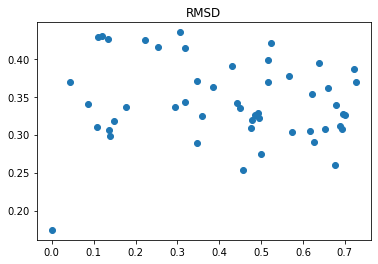

[H]S[C@@]([H])(C(=O)[O-])C([H])([H])c1c([H])n([H])c2c([H])c(Br)c([H])c([H])c12
tensor(0.0087)


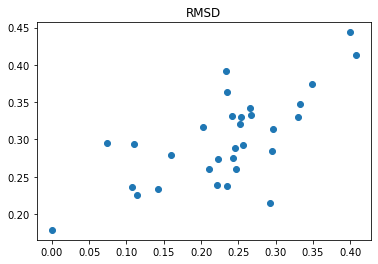

[H]c1nc(N([H])c2c([H])c([H])c([H])c(S(=O)(=O)N([H])C([H])([H])[H])c2[H])c2nc([H])n([H])c2n1
tensor(0.0100)


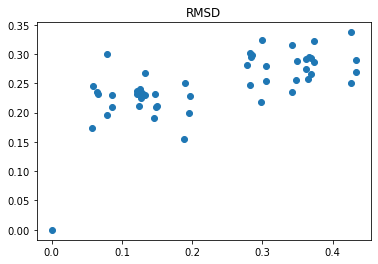

[H]O[C@@]1(C([H])([H])c2c([H])c([H])c(Cl)c([H])c2[H])C(c2c([H])n([H])c3c([H])c(Cl)c([H])c([H])c23)=C(C([H])([H])c2c([H])c([H])c(Cl)c([H])c2[H])C(=O)N1C([H])([H])[H]
tensor(0.0520)


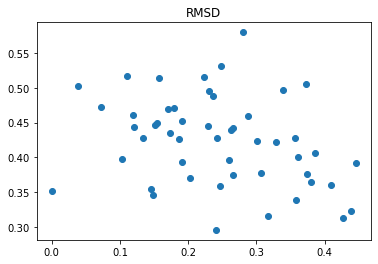

[H]c1nn(C([H])([H])[H])c([H])c1-c1c([H])n([H])c2c([H])c([H])c(Oc3c([H])c([H])c(N([H])C(=O)C([H])([H])[N+]([H])([H])[H])c([H])c3[H])c([H])c12
tensor(0.0089)


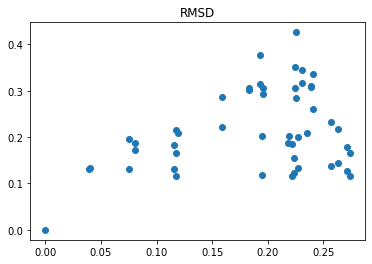

[H]c1c([H])c(-c2nc(-c3nc4c([H])c(C(=O)N([H])C([H])([H])C([H])([H])OC([H])([H])[H])c([H])c([H])c4n3C([H])([H])C([H])([H])OC([H])([H])[H])c([H])n2[H])c([H])c([H])c1Cl
tensor(0.0092)


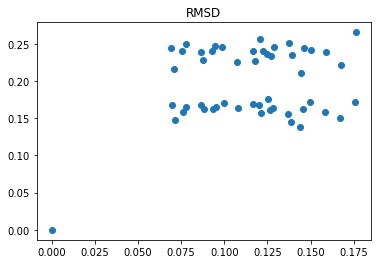

[H]Oc1c([H])c([H])c(S(=O)(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c1N([H])C(=O)c1c(C([H])([H])[H])c(C(=O)C([H])([H])[H])c(C([H])([H])[H])n1[H]
tensor(0.0028)


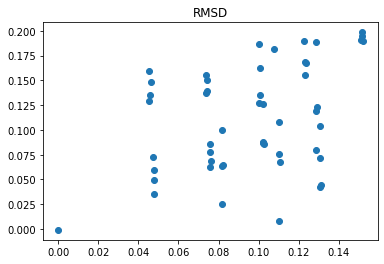

[H]O[C@]1([H])[C@@]([H])(C([H])([H])N=[N+2]#N)O[C@@]([H])(n2c(SC([H])([H])C(=O)N([H])C([H])([H])C([H])([H])c3c([H])n([H])c4c([H])c([H])c([H])c([H])c34)nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0080)


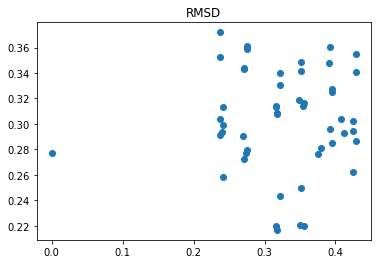

[H]OC([H])([H])C#Cc1sc(-c2c([H])c(C([H])([H])C(=O)[O-])c([H])c(C([H])([H])C(=O)[O-])c2[H])c([H])c1[H]
tensor(0.0024)


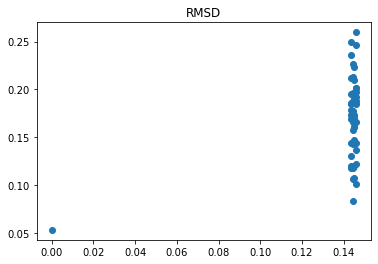

[H]c1c([H])c(Cl)c([H])c(-c2nc3c(N([H])[H])nc(N([H])[H])nc3nc2N([H])[H])c1[H]
tensor(0.0202)


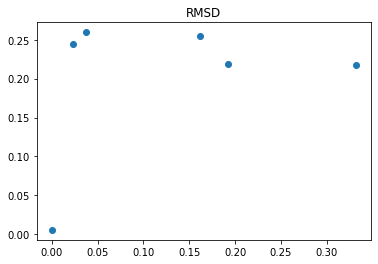

[H]C1=NN(C([H])([H])[H])C(=O)C([H])(Cl)/C1=N/[C@]1([H])C([H])([H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])[H])C1([H])[H]
tensor(0.0181)


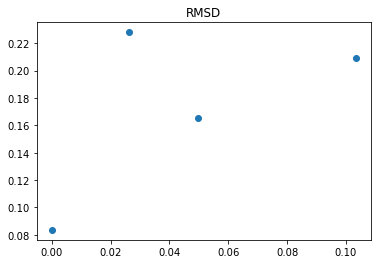

[H]Oc1c([H])c(OC([H])([H])[H])c([H])c(C([H])([H])C([H])([H])c2c([H])c([H])c([H])c([H])c2O[H])c1[H]
tensor(0.0165)


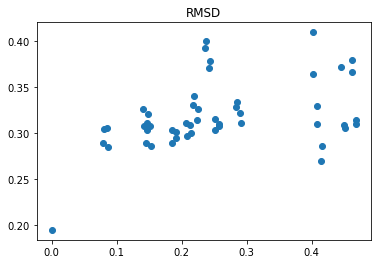

[H]c1c([H])c(OC(F)(F)F)c([H])c(N([H])C(=O)[C@@]2([H])N(C(=O)N([H])c3c([H])n(C(=O)N([H])[H])c4c([H])c([H])c([H])c([H])c34)C([H])([H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0101)


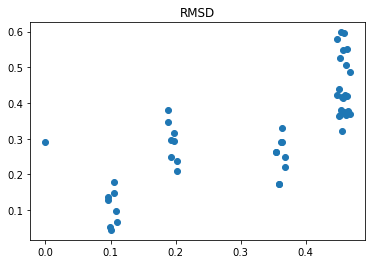

[H]c1c([H])c(OC(F)(F)F)c([H])c(N([H])C(=O)[C@@]2([H])N(C(=O)N([H])c3c([H])n(C(=O)N([H])[H])c4c([H])c([H])c([H])c([H])c34)C([H])([H])[C@@]([H])([N+]([H])([H])[H])C2([H])[H])c1[H]
tensor(0.0293)


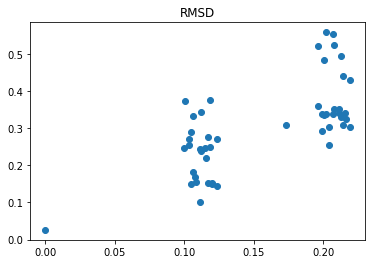

[H]Oc1c(C(=O)N([H])C([H])([H])C([H])([H])Oc2c([H])c([H])c([H])c([H])c2[H])nc([C@@]2([H])N(C(=O)C([H])([H])Oc3c([H])c([H])c([H])c([H])c3Cl)C([H])([H])C([H])([H])C2([H])[H])n([H])c1=O
tensor(0.0137)


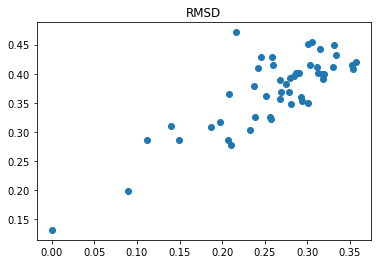

[H]c1c([H])c([H])c2c(C(=O)C([H])([H])Sc3nc(=O)c([H])c(C([H])([H])[H])n3[H])c([H])c([H])c([H])c2c1[H]
tensor(0.0142)


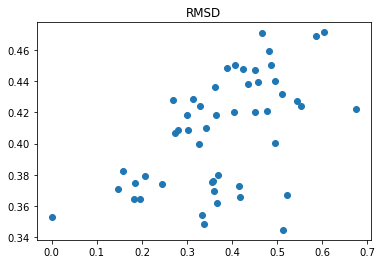

[H]c1c([H])c([H])c2c([H])c(C(=O)C([H])([H])C(=O)C(=O)[O-])c([H])c([H])c2c1[H]
tensor(0.0136)


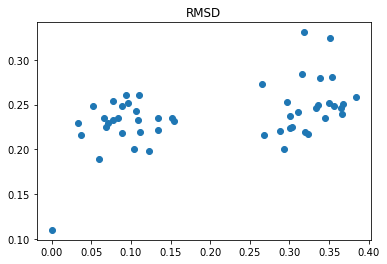

[H]Oc1c([H])c([H])c(-c2c([H])c([H])c3c(N([H])C(=O)C4=C([H])C4([H])[H])n([H])nc3c2[H])c([H])c1[H]
tensor(0.0036)


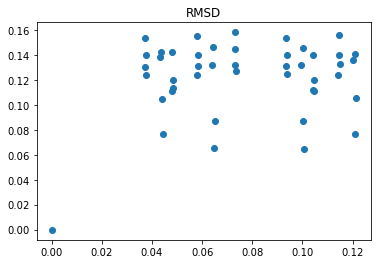

[H]Oc1c(F)c([H])c(S(=O)(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c2c([H])c([H])c([H])nc12
tensor(0.0224)


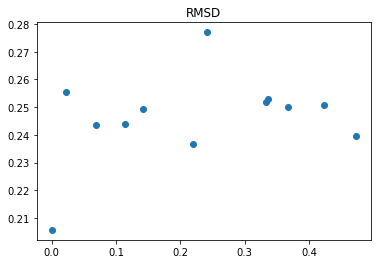

[H]ON([H])C(=O)c1nnn(-c2c([H])c(Cl)c([H])c([H])c2Oc2c([H])c([H])c(F)c([H])c2[H])c1[H]
tensor(0.0053)


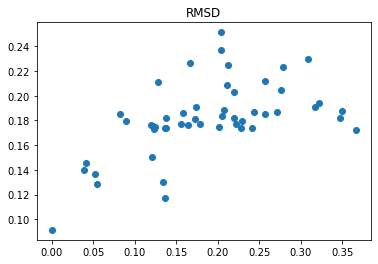

[H]c1nn(-c2c([H])c([H])c(F)c([H])c2[H])c(N([H])[H])c1C(=O)c1c([H])c([H])c([H])c(OC2([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])c1[H]
tensor(0.0044)


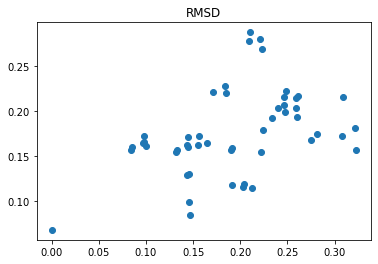

[H]C(=O)C([H])([H])Oc1c([H])c([H])c([H])c([H])c1-c1c([H])c([H])c(F)c(F)c1F
tensor(0.0145)


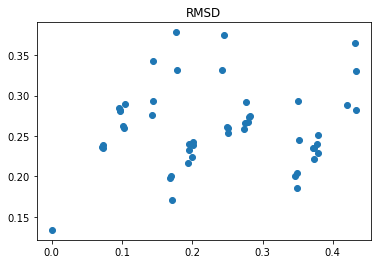

[H]O[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(C([H])([H])c1c([H])c([H])c(OC([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H])[N+]([H])([H])[H]
tensor(0.0072)


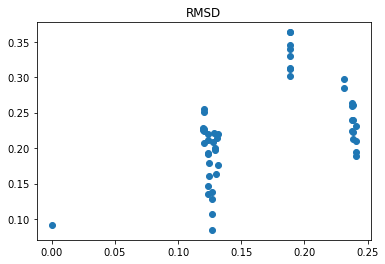

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)OC([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@@]1([H])C(=O)N([H])C([H])([H])C1([H])[H]
tensor(0.0049)


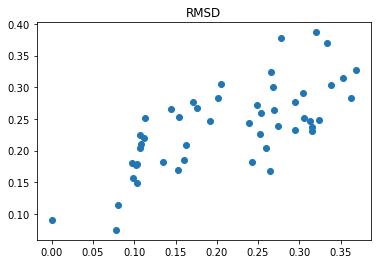

[H]C([H])(C(=O)[O-])C([H])([H])C([H])([H])[N+]1(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0533)


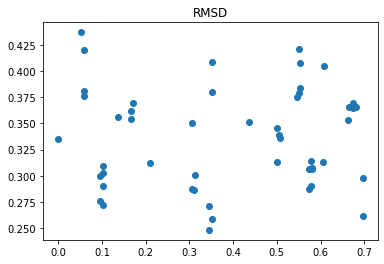

[H]c1nc(Sc2nc([C@@]3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@]3([H])C(=O)N([H])C([H])([H])c3c([H])c([H])c(Cl)c(Cl)c3[H])nc(C([H])([H])C([H])([H])[H])c2[H])n([H])c1C(=O)[O-]
tensor(0.0147)


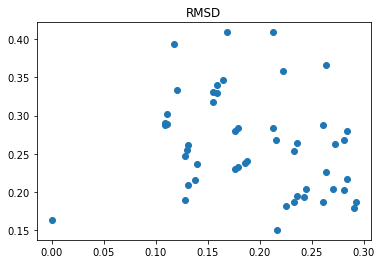

[H]c1c([H])c(C([H])([H])N([H])C(=O)[C@]2([H])C([H])([H])C([H])([H])[N@@+]([H])([C@@]([H])(c3c([H])c([H])c([H])c4c([H])c([H])c([H])c([H])c34)C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c([H])c1F
tensor(0.0033)


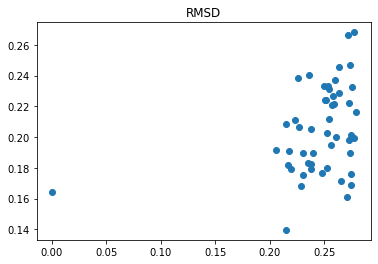

[H]Oc1c(C([H])([H])c2c(Cl)c([H])c([H])c(Cl)c2Cl)sc(=S)n1C([H])([H])[H]
tensor(0.0223)


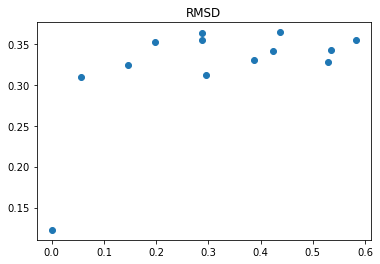

[H]c1nc(-c2nc(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])nc3nc(N([H])[H])c(C#N)c(N([H])[H])c23)sc1[H]
tensor(0.0061)


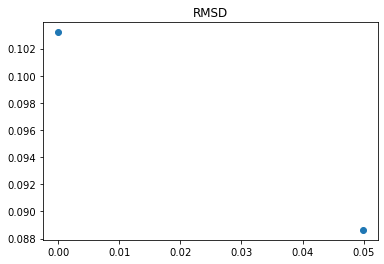

[H]c1c([H])c([H])c([C@@]2([H])N(c3c([H])c([H])c4c(C([H])([H])[H])c([H])c(=O)n(C([H])([H])[H])c4c3[H])C(=O)C([H])([H])C([H])([H])[C@]2([H])N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(0.0112)


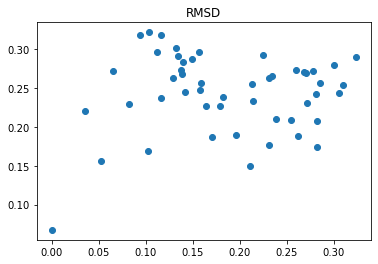

[H]O[C@]1([H])[C@@]([H])(C([H])([H])[C@]([H])(C([H])([H])C([H])([H])[C@]([H])(C(=O)[O-])[N+]([H])([H])[H])[N+]([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])O[C@@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0081)


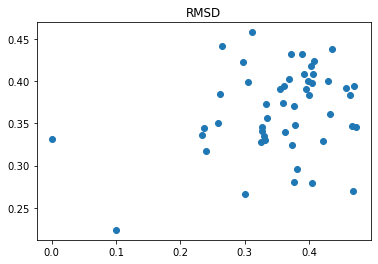

[H]c1c([H])c(C(=O)N([H])[H])c([H])c(N([H])C(=O)C([H])([H])C([H])([H])C(=O)N([H])C([H])([H])C([H])([H])c2nnn(C([H])([H])C([H])([H])N([H])S(=O)(=O)c3c([H])c([H])c([H])c(C(=O)[O-])c3[H])c2[H])c1[H]
tensor(0.0105)


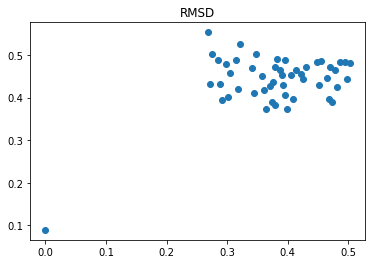

[H]OC([H])([H])[C@@]1([H])O[N+]([H])([H])C([H])([H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0613)


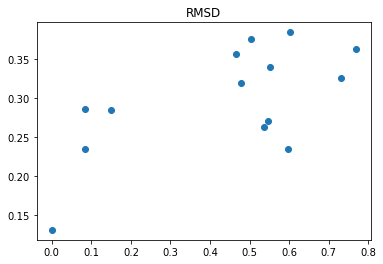

[H]c1sc(C(=O)N([H])c2sc3c(c2C(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[C@]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c1[H]
tensor(0.0044)


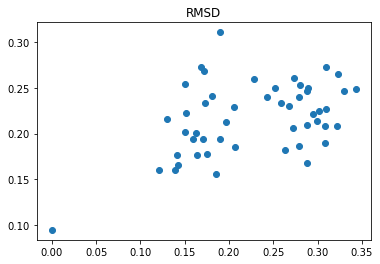

[H]c1c([H])c([H])c2c(c1[H])c(C(=O)O[C@]1([H])C([H])([H])[C@]3([H])C([H])([H])C([H])([H])[C@]([H])(C1([H])[H])[N@@+]3([H])C([H])([H])[H])c([H])n2[H]
tensor(0.0051)


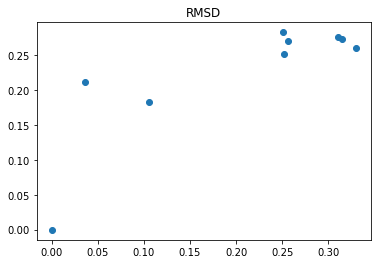

[H]c1c([H])c(-c2c([H])c(-c3nnc(C([H])([H])[H])o3)c([H])c([H])c2C([H])([H])[H])c([H])c([H])c1C(=O)N([H])C([H])([H])C1([H])C([H])([H])C1([H])[H]
tensor(0.0071)


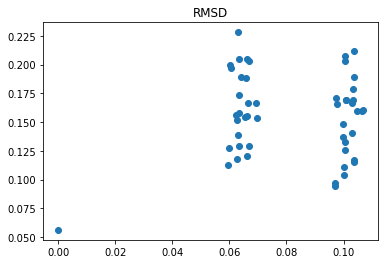

[H]C(=C(C([H])([H])[H])C([H])([H])[H])C([H])([H])N(C([H])([H])C([H])([H])[N+]([H])([H])[H])S(=O)(=O)c1c([H])c([H])c(C(=O)N([H])[H])c([H])c1[H]
tensor(0.0197)


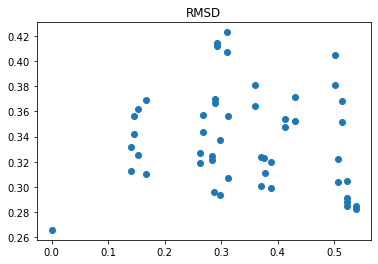

[H]C(=C(C([H])([H])[H])C([H])([H])[H])C([H])([H])N([C@@]1([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]1([H])N(C([H])([H])C([H])=C(C([H])([H])[H])C([H])([H])[H])S(=O)(=O)c1c([H])c([H])c(C(=O)N([H])[H])c([H])c1[H])S(=O)(=O)c1c([H])c([H])c(C(=O)N([H])[H])c([H])c1[H]
tensor(0.0523)


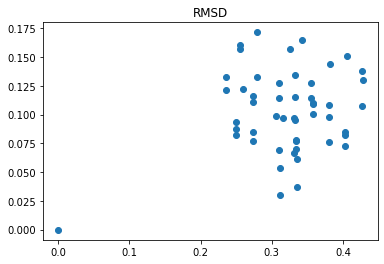

[H]c1nc(N([H])[H])c2c(C([H])([H])c3c([H])c([H])c([H])c(N([H])C(=O)N([H])c4c([H])c([H])c([H])c(C(F)(F)F)c4[H])c3[H])nn(C3([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c2n1
tensor(0.0259)


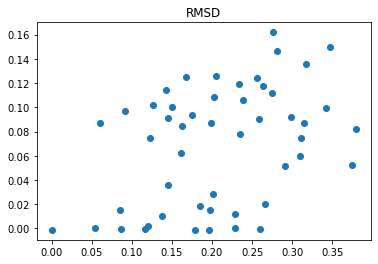

[H]c1c([H])c([H])c2c(c1[H])N(C(=O)c1c([H])c3c([H])c(F)c([H])c([H])c3n1[H])C([H])([H])[C@]21C([H])([H])C([H])([H])[N@@+]([H])([C@]2([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])C2([H])[H])C1([H])[H]
tensor(0.0168)


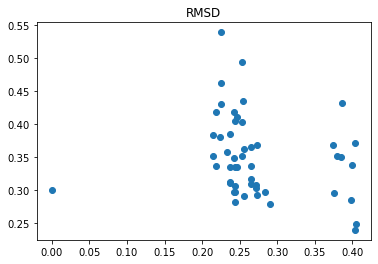

[H]c1nc(N2[C@@]3([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]([H])(N([H])C(=O)c2c([H])c([H])c([H])c(OC([H])([H])[H])c2C([H])([H])[H])C3([H])[H])c([H])c([H])c1C(=O)N([H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0119)


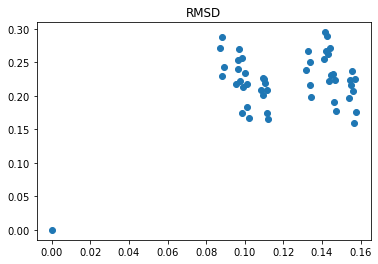

[H]OC1([H])N(C([H])([H])c2c([H])c([H])c(N([H])C(=O)C([H])([H])C([H])([H])[H])c([H])c2[H])c2nc(N([H])c3c([H])c([H])c(N4C([H])=C([H])N(C([H])([H])[H])C([H])=C4[H])c([H])c3[H])nc([H])c2C([H])([H])N1c1c([H])c(OC([H])([H])[H])c([H])c(OC([H])([H])[H])c1[H]
tensor(0.0078)


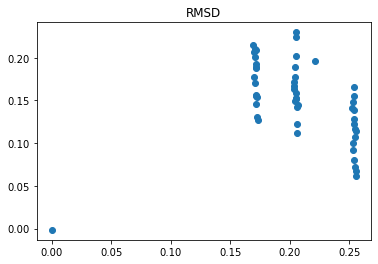

[H]O[C@@]12O[C@@]([H])(C([H])([H])C([H])([H])[C@@]1([H])C([H])([H])[H])C([H])([H])[C@]([H])(OC([H])([H])[H])[C@]([H])(C([H])([H])[H])C([H])([H])/C([H])=C([H])/C([H])=C(\[H])[C@@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C(=O)[C@]([H])(OC([H])([H])[H])[C@]([H])(O[H])[C@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C(=O)C([H])([H])[C@@]([H])([C@]([H])(C([H])([H])[H])C([H])([H])[C@]1([H])C([H])([H])C([H])([H])[C@@]([H])(O[H])[C@]([H])(OC([H])([H])[H])C1([H])[H])OC(=O)[C@@]1([H])N(C(=O)C2=O)C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.7142)


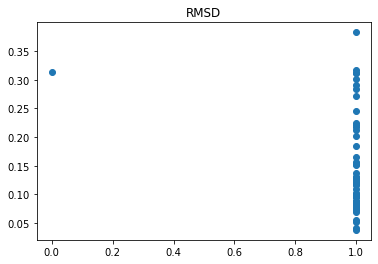

[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C(=O)C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.0281)


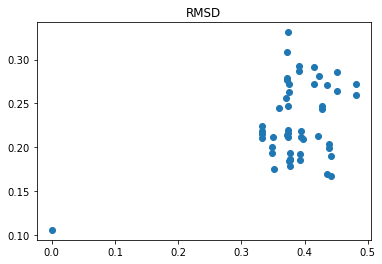

[H]c1c([H])c([N+](=O)[O-])c([H])c(C(=O)[O-])c1N([H])[H]
tensor(0.0170)


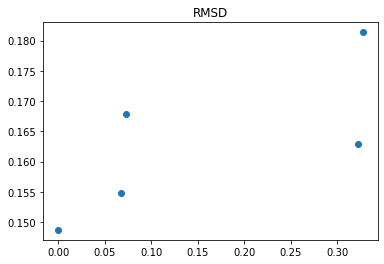

[H]c1c([H])c([H])c(OC([H])([H])C([H])([H])n2c([H])c([H])c(=O)n([H])c2=O)c(Oc2c([H])c(N(C(=O)C([H])([H])[H])C([H])([H])[H])c3c([H])c([H])c(C#N)c([H])c3c2C([H])([H])[H])c1[H]
tensor(0.0138)


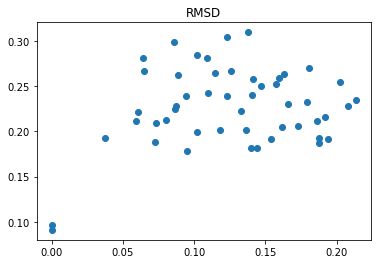

[H]O[C@@]([H])(c1c([H])c([H])c(C([H])([H])n2c([H])c(-c3c(C([H])([H])[H])noc3C([H])([H])[H])c([H])c([H])c2=O)c([H])c1[H])C([H])([H])[H]
tensor(0.0225)


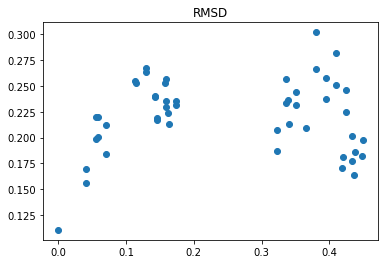

[H]Oc1c2c(oc(=O)c1[C@]([H])(c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H]
tensor(0.0102)


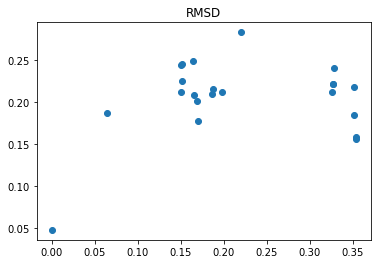

[H]C(=C(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])[H])[C@]1([H])C([H])([H])C([H])=C(C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0654)


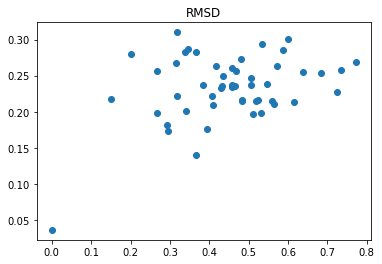

[H]c1c([H])c([H])c(C([H])([H])N([H])c2c([H])c([H])c([H])c(-c3sc(C(=O)[O-])c(OC([H])([H])C(=O)[O-])c3Br)c2[H])c([H])c1[H]
tensor(0.0088)


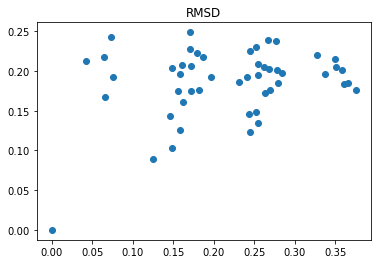

[H]c1sc(C(=O)N([H])C([H])([H])C([H])([H])c2c(C([H])([H])[H])n([H])c3c([H])c([H])c([H])c([H])c23)c([H])c1[H]
tensor(0.0333)


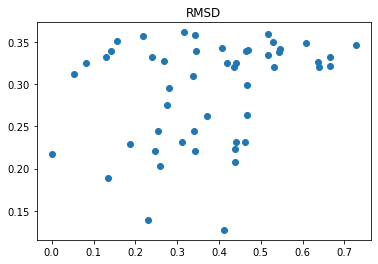

[H]c1nc2c([H])c([H])c(N([H])[H])c([H])c2c(N([H])c2c([H])c([H])c(N([H])C(=O)N([H])c3c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])nn3-c3c([H])c([H])c([H])c(C([H])([H])[H])c3[H])c([H])c2[H])c1[H]
tensor(0.0254)


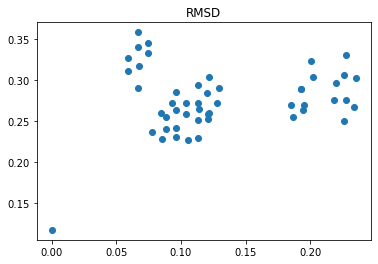

[H]O[C@]([H])(C([H])([H])[N+]([H])([H])C1(c2sc([H])c(C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])C1([H])[H])[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])c1c([H])c(F)c([H])c(F)c1[H]
tensor(0.0096)


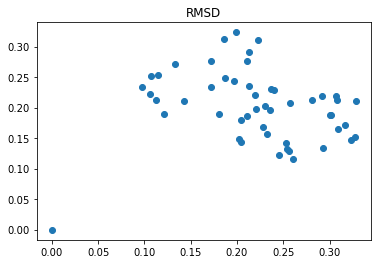

[H]C1=NC([C@@]([H])(N([H])C2=NC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c3c([H])c(Cl)c([H])c([H])c32)C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])=NC(=O)C1([H])C#N
tensor(0.0215)


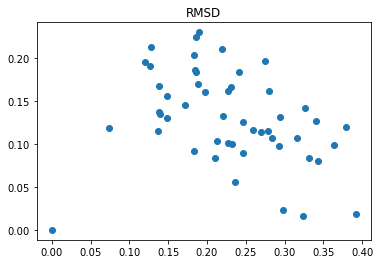

[H]Oc1c([H])c(F)c([H])c([H])c1C([H])([H])N([H])c1nc([H])c([H])c([H])c1-c1nc([H])c([H])c([H])n1
tensor(0.0192)


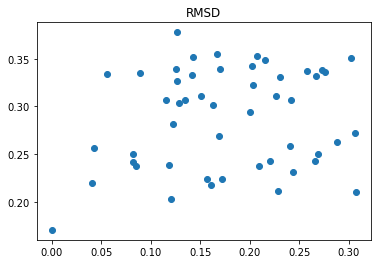

[H]C(=O)N1C([H])([H])[C@]([H])([N+]([H])([H])OS(=O)(=O)[O-])C([H])([H])C([H])([H])[C@@]1([H])C(=O)N([H])C1([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C1([H])[H]
tensor(0.0129)


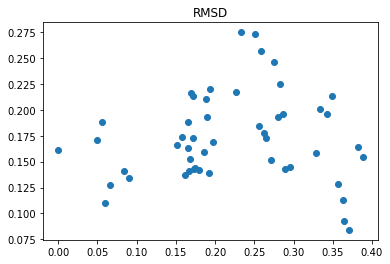

[H]c1c([H])c(F)c([H])c(-c2c([H])c(C#N)c([H])c([C@@]3(C4([H])C([H])([H])C([H])([H])C4([H])[H])C(C#N)=C(N([H])[H])Oc4c3c(C([H])([H])[H])nn4[H])c2[H])c1[H]
tensor(0.0072)


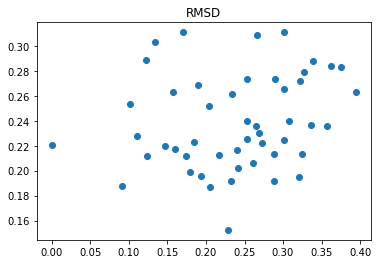

[H]c1c([H])c([H])c2c(c1[H])N(C(=O)C([H])([H])c1nc(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c(=O)n1[H])[C@@]([H])(C([H])([H])[H])C2([H])[H]
tensor(0.0291)


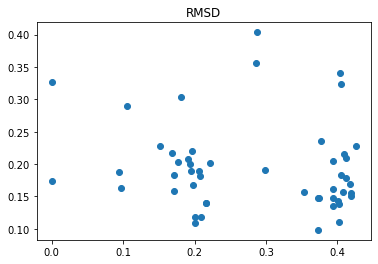

[H]/C(=C(/C#N)c1c([H])c([H])c(C(=O)[O-])c([H])c1[H])c1c([H])n(C([H])([H])c2c([H])c([H])c(F)c([H])c2[H])c2c([H])c(Cl)c([H])c([H])c12
tensor(0.0064)


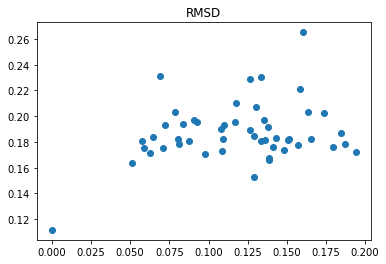

[H]c1c([H])c(N([H])C(=O)c2c([H])c(Br)c(Br)n2[H])c([H])c([H])c1C(=O)N([H])C([H])([H])C(=O)[O-]
tensor(0.0039)


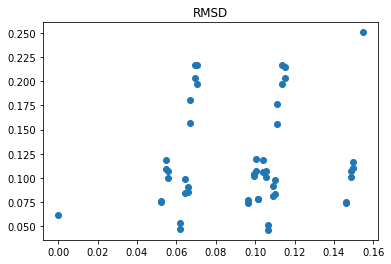

[H]c1c([H])c(C([H])([H])C([H])([H])[H])c2c(c1[H])c(C1([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C1([H])[H])c([H])n2[H]
tensor(0.0150)


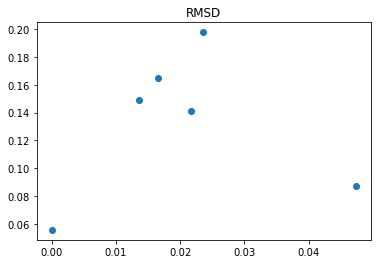

[H]c1c([H])c([H])c(C(=O)N([H])c2c([H])c([H])c([H])c(C(=O)N=O)c2[H])c([H])c1[H]
tensor(0.0076)


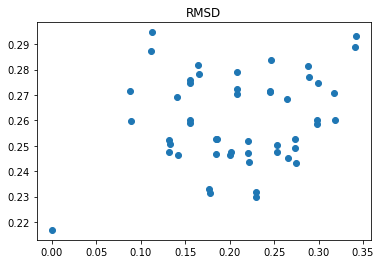

[H]c1c([H])c(C([H])([H])C([H])([H])[H])c(N([H])C(=O)c2nn(C([H])([H])[H])c3c2c([H])c([H])c2c([H])nc(N([H])c4c([H])c([H])c(N5C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C5([H])[H])c([H])c4OC([H])([H])[H])nc23)c(C([H])([H])C([H])([H])[H])c1[H]
tensor(0.0049)


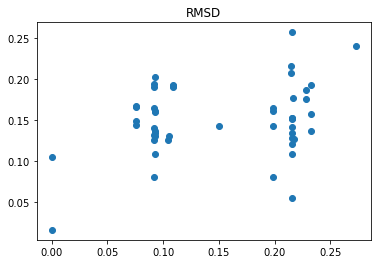

[H]c1c([H])c2c3c(c([H])c([H])c([H])c3c1[H])C(=O)N(c1c(C([H])([H])[H])c([H])c3c(c1[H])n(C([H])([H])[H])c(=O)n3C([H])([H])[H])C2=O
tensor(0.0009)


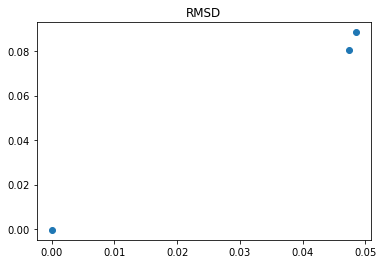

[H]c1nc(N([H])c2c([H])c([H])c([H])c(C(=O)N([H])[C@]3([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@@]3([H])F)c2[H])sc1C(=O)N([H])c1c(Cl)c([H])c([H])c([H])c1C([H])([H])[H]
tensor(0.0082)


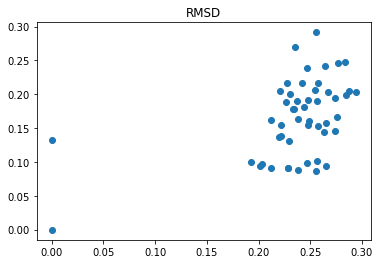

[H]Oc1c([H])c([H])c2c([H])c([H])c([H])c(O[H])c2c1C([H])([H])N([H])C(=O)c1c(C([H])([H])C([H])([H])[H])c(C(=O)C([H])([H])[H])c(C([H])([H])[H])n1[H]
tensor(0.0109)


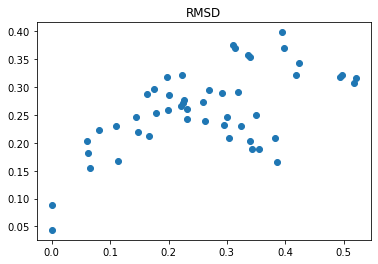

[H]OB(O[H])c1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c(O[H])c([H])c(O[H])c2[H])c([H])c1[H]
tensor(0.0197)


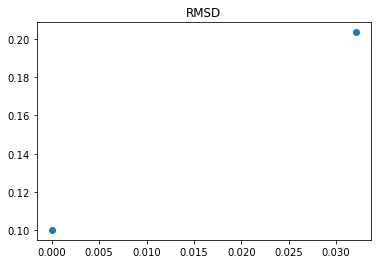

[H]Oc1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])c(Cl)c1[H]
tensor(0.0225)


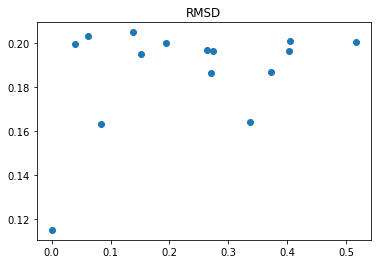

[H]c1c([H])c([H])c(N2C(=O)c3c([H])c([H])c([H])c([H])c3N([H])[C@@]2([H])c2c([H])c([H])c([H])c([H])c2F)c([H])c1[H]
tensor(0.0231)


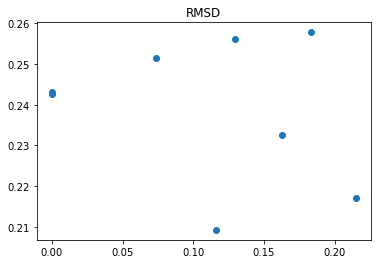

[H]c1nc2c([H])c([C@@]([H])(OC([H])([H])C3([H])C([H])([H])C([H])([H])C(F)(F)C([H])([H])C3([H])[H])c3c([H])c([H])c([H])c([H])c3Cl)n([H])c2c(C(=O)[O-])c1[H]
tensor(0.0392)


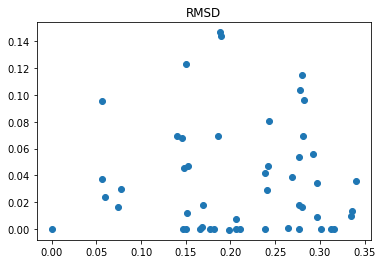

[H]c1c([H])c(N(n2c([H])nnc2[H])C([H])([H])c2c([H])c([H])c(OS(=O)(=O)N([H])[H])c(Br)c2[H])c([H])c([H])c1C#N
tensor(0.0378)


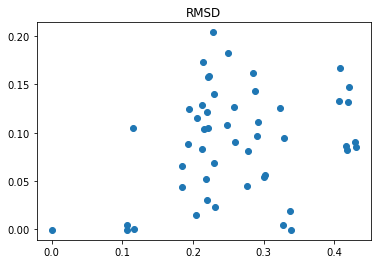

[H]Oc1c([H])c(O[H])c(-c2c(C(=O)N([H])C([H])([H])c3c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c3[H])c([H])nn2[H])c([H])c1Cl
tensor(0.0463)


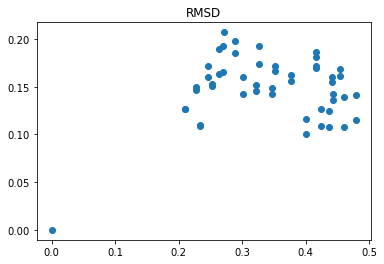

[H]c1c([H])c(N([H])C(=O)C([H])([H])C([H])([H])C(=O)N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])c(C(=O)N2C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C2([H])[H])c([H])c1Br
tensor(0.0074)


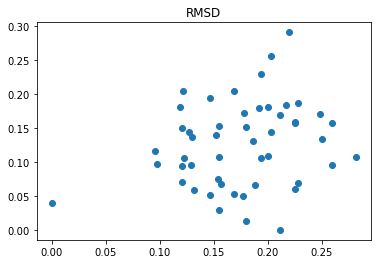

[H]c1nc2c([H])c([H])c(C([H])([H])[N+]([H])([H])[C@@](c3nnn([C@]([H])(C(=O)C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c3[H])(C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2c([H])c1[H]
tensor(0.0031)


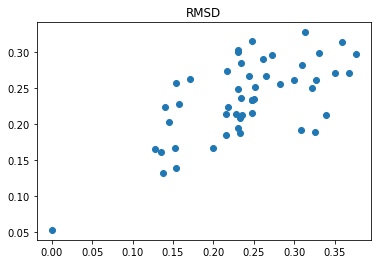

[H]c1c(/C(=N/N([H])c2nc3c([H])c([H])c([H])c([H])c3s2)C([H])([H])[H])oc(-c2c([H])c([H])c([H])c(S(=O)(=O)N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c2[H])c1[H]
tensor(0.0085)


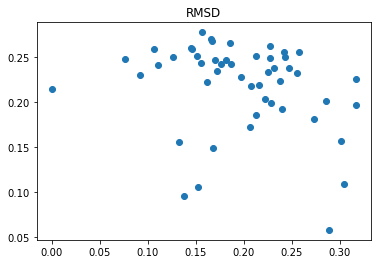

[H]ON([H])C(=O)C([H])([H])[C@]12C([H])([H])[C@@]3([H])C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C3([H])[H])C1([H])[H])C2([H])[H]
tensor(0.0456)


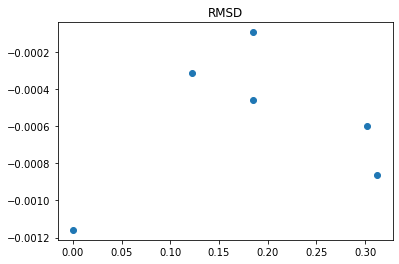

[H]O[C@@]1([H])[C@]([H])(C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C([H])([H])C([H])([H])C2=C3C4=C5[C@@]2([H])[Fe+10]3452678C3=C2C6([H])C7=C38)[N+]([H])([H])[C@@]([H])(C([H])([H])[H])[C@@]1([H])O[H]
tensor(0.0616)


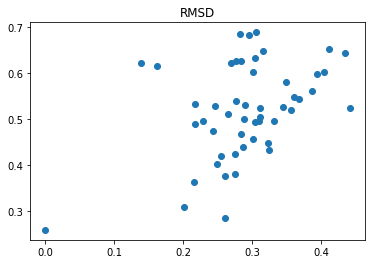

[H]c1c([H])c(S(=O)(=O)N([H])C(=O)c2c([H])c3c([H])c(OC([H])([H])[H])c([H])c([H])c3n2C([H])([H])C(=O)[O-])c([H])c([H])c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0162)


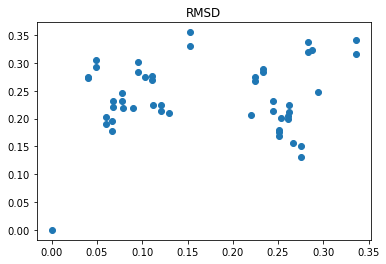

[H]c1sc2c(c1[H])c1c([H])c([H])c([H])c([H])c1c(=O)n2[H]
tensor(0.0140)


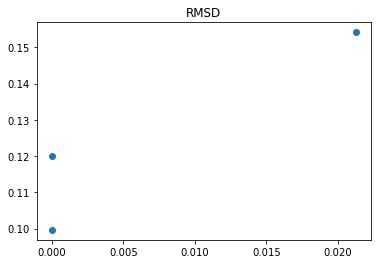

[H]c1nn([H])c(-c2nc3c([H])c([H])c(C([H])([H])[N+]4([H])C([H])([H])C([H])([H])OC([H])([H])C4([H])[H])c([H])c3n2[H])c1N([H])C(=O)N([H])C1([H])C([H])([H])C1([H])[H]
tensor(0.0074)


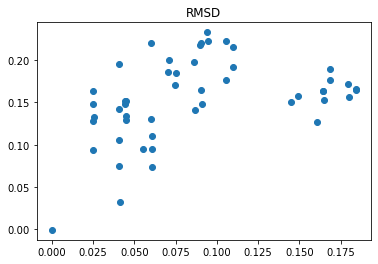

[H]c1nn2c(C#Cc3c([H])c(C(=O)N([H])c4c([H])c([H])c(C([H])([H])[N@+]5([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C5([H])[H])c(C(F)(F)F)c4[H])c([H])c([H])c3C([H])([H])[H])c([H])nc2c([H])c1[H]
tensor(0.0073)


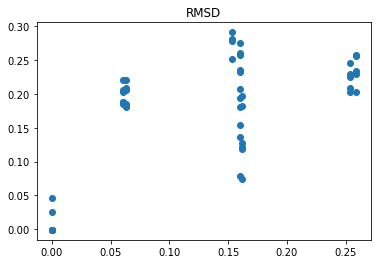

[H]Oc1c([H])c([H])c(C([H])([H])[H])n2nc3c(c12)C([H])([H])[C@@](N([H])C(=O)c1c([H])c([H])c(-n2c([H])nnc2[H])c([H])c1[H])(C([H])([H])[H])C([H])([H])C3([H])[H]
tensor(0.0063)


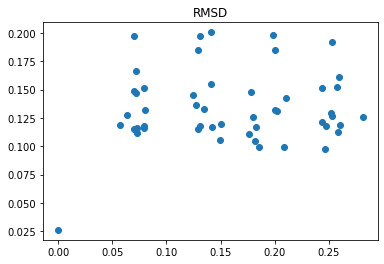

[H]c1nc(N([H])C([H])([H])c2c([H])c([H])c3c(nc([H])n3[H])c2Cl)nc(N([H])c2nn([H])c(C3([H])C([H])([H])C3([H])[H])c2[H])c1[H]
tensor(0.0168)


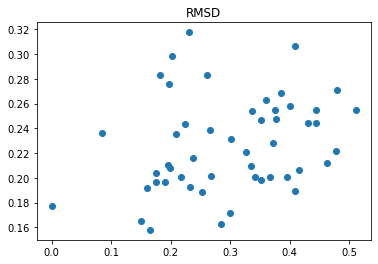

[H]c1nc2c3c4c(sc3n(C([H])([H])c3c([H])c([H])c(Cl)c([H])c3[H])c(=O)n2n1)C([H])([H])C([H])([H])C([H])([H])C4([H])[H]
tensor(0.0130)


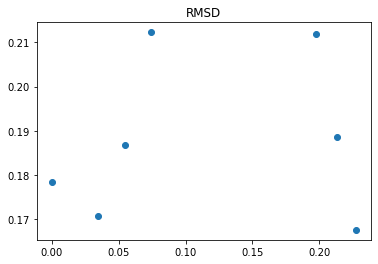

[H]O[C@@]([H])(C([H])([H])Oc1c([H])c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[N@+]1([H])C([H])([H])[C@@]2([H])C([H])([H])n3c(c([H])c([H])c([H])c3=O)[C@]([H])(C2([H])[H])C1([H])[H]
tensor(0.0051)


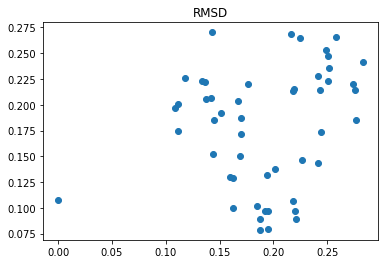

[H]c1c(C([H])([H])[H])c(F)c(C([H])([H])[H])c([H])c1C([H])([H])n1c(N2C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])nc2c([H])c([H])c(Cl)c([H])c21
tensor(0.0263)


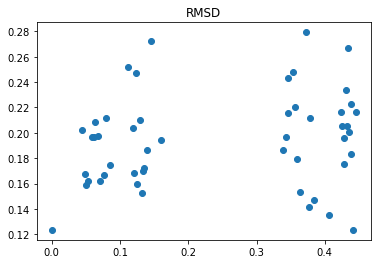

[H]c1c([H])c(Cl)c([H])c(N([H])C(=O)N([H])C2=[N+]([H])C(=O)C([H])([H])N2C([H])([H])[H])c1[H]
tensor(0.0169)


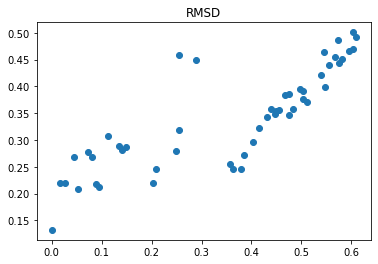

[H]c1c([H])c([H])c(-c2c([H])c([H])c(C([H])([H])N3C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])c4c([H])c([H])c(C([H])([H])C(=O)[O-])c(C(=O)[O-])c4[H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c2[H])c([H])c1[H]
tensor(0.0248)


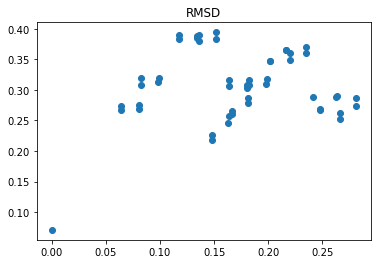

[H]Oc1c([H])c([H])c([H])c([C@@]2([H])N(C(=O)C([H])([H])[H])N=C(c3c([H])c([H])c([H])c([H])c3Cl)C2([H])[H])c1[H]
tensor(0.0127)


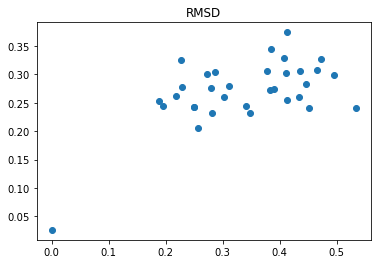

[H]OC([H])([H])[C@@]([H])(N([H])c1nc(N([H])c2c([H])c(Cl)c([H])c(N([H])[H])c2[H])c2nc([H])n(C([H])(C([H])([H])[H])C([H])([H])[H])c2n1)C([H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0360)


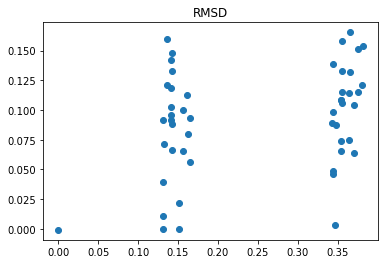

[H]OC([H])([H])[C@@]1([H])n2c(nc(C(=O)[O-])c2[H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.0317)


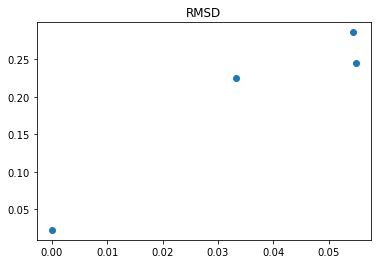

[H]O[C@]([H])(C([H])([H])[N+]([H])([H])C([H])([H])c1c([H])c([H])c([H])c(N(C([H])([H])[H])C([H])([H])[H])c1[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N([H])C(=O)N(C([H])([H])c2c([H])c([H])c([H])c(OC([H])([H])[H])c2[H])C1([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0093)


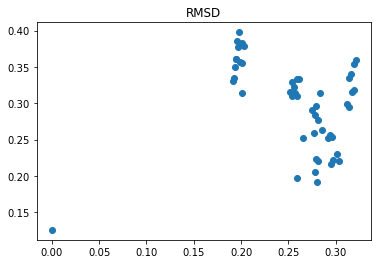

[H]OC([H])([H])[C@]1([H])[C@@]([H])(O[H])[C@]([H])(O[H])[C@@]2([H])[C@]([H])(O[H])[C@@]([H])(O[H])C([H])([H])[N@@+]12[H]
tensor(0.0034)


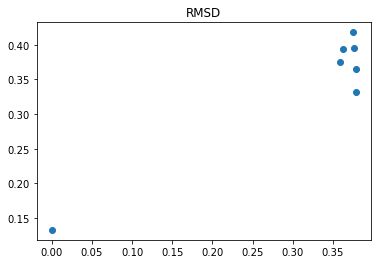

[H]O[C@]([H])(C([H])([H])Oc1c([H])c([H])c(N([H])c2nc([H])c([H])c(-c3c([H])nn4nc(N5C([H])([H])C([H])([H])OC([H])([H])C5([H])[H])c([H])c([H])c34)n2)c([H])c1[H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])[H]
tensor(0.0102)


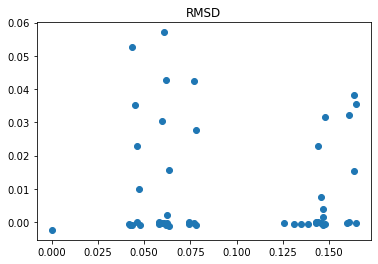

[H]c1c([H])c(C(=O)N([H])[H])c([H])c(C([H])([H])n2c3c(c4c([H])c([H])c([H])c(C(=O)[O-])c42)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c1[H]
tensor(0.0490)


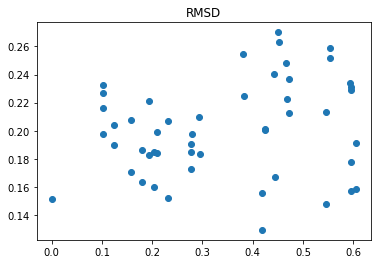

[H]c1c(Cl)c(=O)n([H])c(=O)n1C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H]
tensor(0.0939)


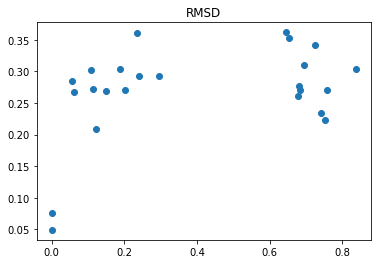

[H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)[C@]([H])(O[H])[C@]1([H])O[H])[N+]([H])([H])[H]
tensor(0.0211)


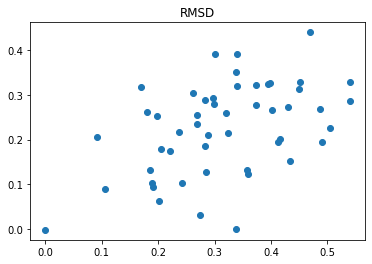

[H]Oc1c([H])c([H])c2c(=O)c([H])c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])oc2c1[H]
tensor(0.0058)


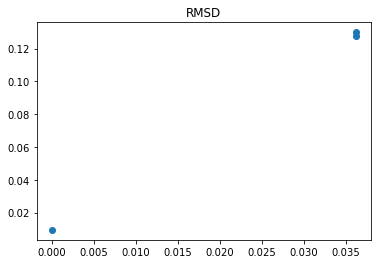

[H]c1nn([H])c([H])c1-c1c([H])sc([H])c1C([H])([H])[C@@]([H])(C(=O)[O-])N([H])C1=NC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c2c([H])c(Cl)c([H])c([H])c21
tensor(0.0066)


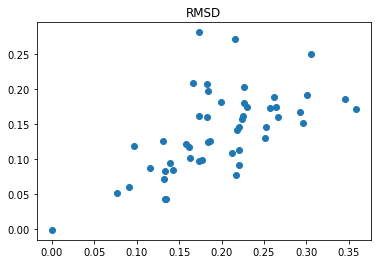

[H]Oc1nc(-c2c([H])c([H])c([H])c(OC([H])([H])[H])c2[H])c([H])c([H])c1O[H]
tensor(0.0123)


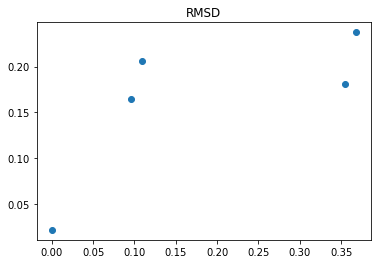

[H]c1c([H])c(F)c([H])c(N2C(=O)N=C(N([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])[C@]23C([H])([H])C([H])([H])[N@+]([H])(C([H])([H])c2c([H])c([H])c([H])c(OC([H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])C3([H])[H])c1[H]
tensor(0.0102)


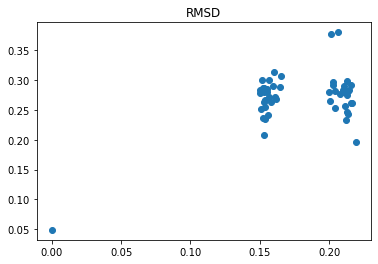

[H]c1c(C(=O)N2C([H])([H])C([H])([H])C3(C([H])([H])N(C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C3([H])[H])C([H])([H])C2([H])[H])c([H])c2c([H])nn([H])c2c1C([H])([H])[H]
tensor(0.0019)


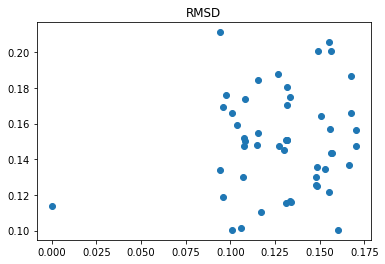

[H]c1nn2c(c1C(=O)N([H])C([H])([H])c1c([H])c([H])c3c(c1[H])OC([H])([H])O3)N([H])[C@@]([H])(c1c([H])c([H])c(C([H])([H])C([H])([H])[H])c([H])c1[H])C([H])([H])[C@@]2([H])C(F)(F)F
tensor(0.0018)


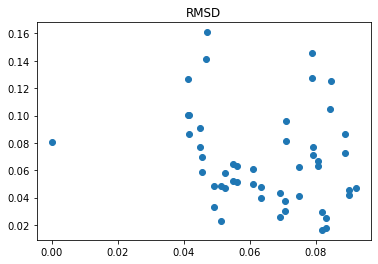

[H]c1nc([H])c(N([H])c2c([H])n(C([H])([H])[H])c3nc([H])c([H])c([H])c23)c(C(=O)[O-])c1[H]
tensor(0.0086)


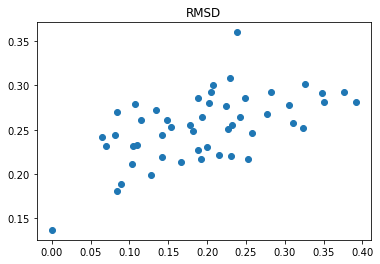

[H]c1c([H])c([H])c2c(c1[H])c1c([H])c([C@@]3([H])C(C(=O)OC([H])([H])[C@]4([H])OC([H])([H])C([H])([H])C4([H])[H])=C(C([H])([H])[H])N([H])C4=C3C(=O)C([H])([H])C([H])([H])C4([H])[H])c([H])c([H])c1n2C([H])([H])C([H])([H])[H]
tensor(0.0072)


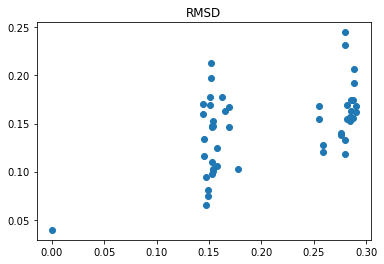

[H]c1c([H])c([H])c([C@]2(C([H])([H])[H])C([H])([H])C(=O)N(C([H])([H])C([H])([H])Oc3c([H])c([H])c(F)c(C#N)c3[H])C2([H])[H])c([H])c1[H]
tensor(0.0738)


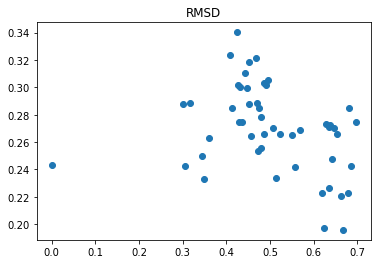

[H]On1c(=O)c(C([H])(C([H])([H])[H])C([H])([H])[H])c(C([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])n(C([H])([H])OC([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1=O
tensor(0.0360)


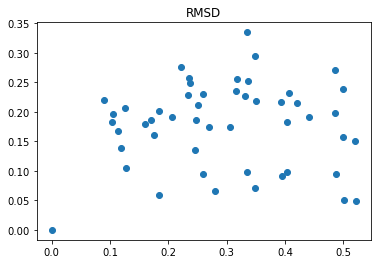

[H]c1c(OC([H])([H])[H])c(OC([H])([H])[H])c([H])c2c(N([H])[C@]3([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])nc(N3C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])nc12
tensor(0.0014)


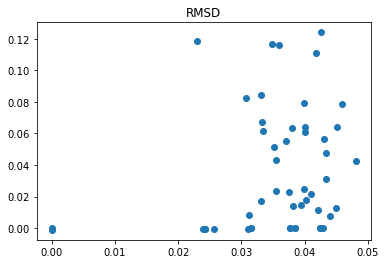

[H]OB(O[H])c1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])c(Cl)c1[H]
tensor(0.0190)


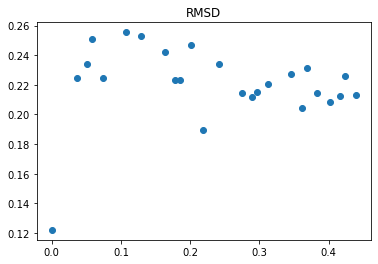

[H]c1nc2c([H])c(OC([H])([H])C([H])([H])C([H])([H])[N@+]3([H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])[H])C([H])([H])C3([H])[H])c(OC([H])([H])[H])c([H])c2c(N([H])c2c([H])c(Cl)c(OC([H])([H])[H])c(Cl)c2[H])c1C#N
tensor(0.0067)


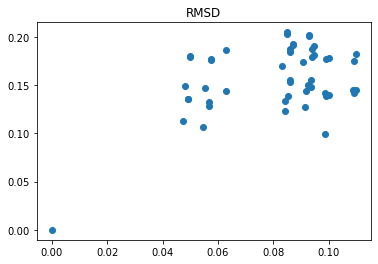

[H]c1c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c([H])c1N([H])C(=O)[C@@]1([H])N(C(=O)[C@@]([H])(N([H])C(=O)C(F)(F)F)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0123)


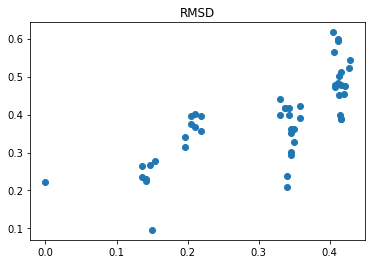

[H]Oc1c(OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c([H])c([H])c1-c1nc2c([H])c(C(N([H])[H])=[N+]([H])[H])c(F)c([H])c2n1[H]
tensor(0.0134)


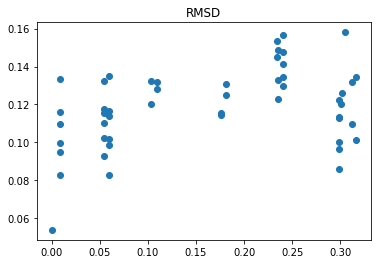

[H]Oc1c([H])c(O[H])c2c(c1Cl)C([H])([H])C(=O)C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])OC2=O
tensor(0.0407)


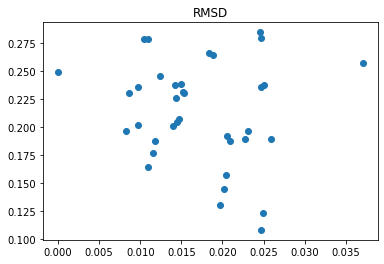

[H]c1sc(C([H])([H])C(=O)N2C([H])([H])c3nn([H])c(N([H])C(=O)c4c([H])c([H])c(N5C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C5([H])[H])c([H])c4[H])c3C2([H])[H])c([H])c1[H]
tensor(0.0015)


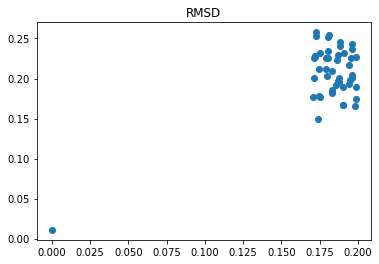

[H]O[C@]1([H])C(OC([H])([H])c2c([H])c([H])c3sc([H])c([H])c3c2[H])=C(C([H])([H])c2c([H])c([H])c3sc([H])c([H])c3c2[H])[C@@](O[H])(C(=O)[O-])C([H])([H])[C@@]1([H])O[H]
tensor(0.0073)


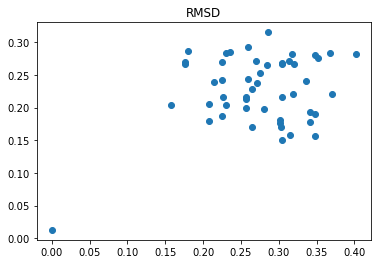

[H]O/N=C1/C(=O)N(C([H])([H])c2c([H])c(F)c([H])c3c2OC([H])([H])OC3([H])[H])c2c([H])c([H])c(F)c([H])c21
tensor(0.0538)


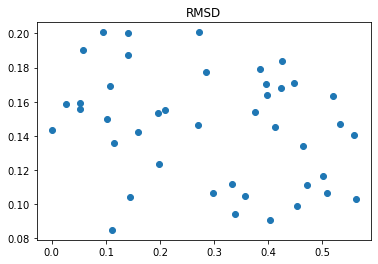

[H]c1nc2c(c([H])c1-c1c([H])c([H])c([H])c(C(=O)N([H])[H])c1[H])n(C([H])([H])[H])c(=O)n2[H]
tensor(0.0536)


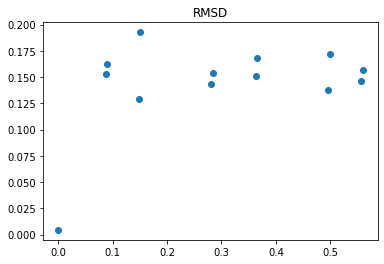

[H]c1nc(-c2c([H])c([H])c(OC([H])([H])[H])c([H])c2[H])c(N2C([H])([H])C([H])([H])N(S(=O)(=O)c3c([H])c([H])c([H])c(-c4c([H])c([H])c(OC([H])([H])[H])c([H])c4[H])c3[H])C([H])([H])C2([H])[H])nc1[H]
tensor(0.0790)


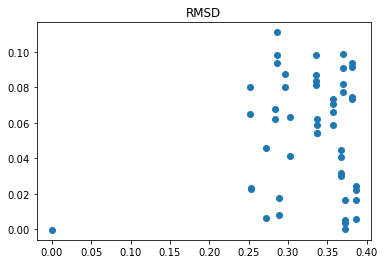

[H]OC([H])([H])C(=O)N1N=C2c3c([H])c(OC([H])([H])[H])c([H])c([H])c3C([H])([H])C([H])([H])[C@@]2([H])[C@@]1([H])c1c([H])c([H])c(OC(F)(F)F)c(F)c1[H]
tensor(0.0540)


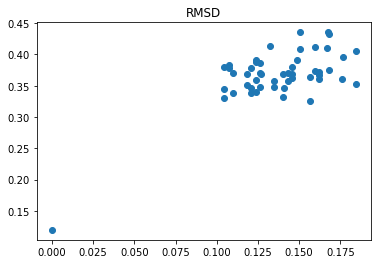

[H]c1nc(C(=O)N([H])c2c([H])c([H])c(F)c([C@@]3(C([H])([H])[H])N([H])C(=[N+]([H])[H])OC([H])([H])[C@@]3([H])F)c2[H])c([H])c([H])c1C#N
tensor(0.0085)


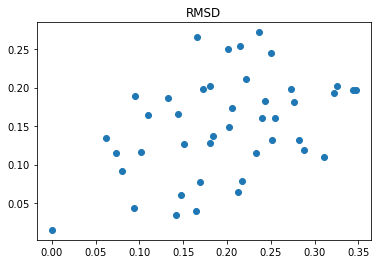

[H]c1c([H])c(C([H])([H])[H])c(N([H])[H])c([H])c1C(=O)N([H])c1c([H])c([H])c(S(=O)(=O)[O-])c2c([H])c(S(=O)(=O)[O-])c([H])c(S(=O)(=O)[O-])c12
tensor(0.0113)


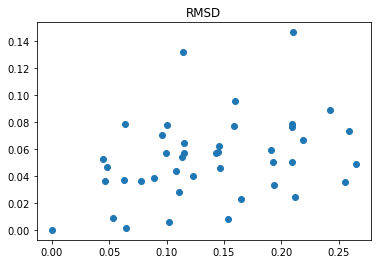

[H]Oc1c([H])c([H])c(C(=O)O[C@@]2([H])C([H])([H])C(C([H])([H])[H])=C([H])C([H])([H])[C@@]3(C([H])([H])[H])C([H])([H])C([H])([H])[C@@](O[H])(C([H])(C([H])([H])[H])C([H])([H])[H])[C@]23[H])c([H])c1[H]
tensor(0.0110)


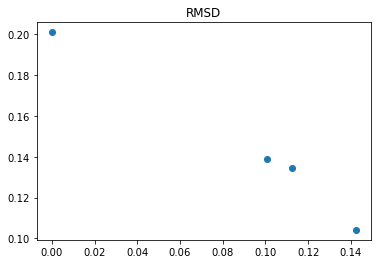

[H]c1c([H])c(-c2c([H])c([H])c([H])n([H])c2=O)c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c1OC([H])([H])[H]
tensor(0.0127)


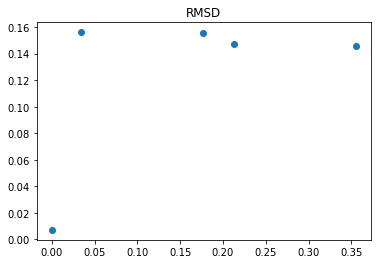

[H]c1c([H])c([H])c(C([H])([H])n2c([H])nc(C(=O)N3C([H])([H])C([H])([H])N(c4c([H])c([H])c([H])c([H])c4Cl)C([H])([H])C3([H])[H])c2[H])c([H])c1[H]
tensor(0.0198)


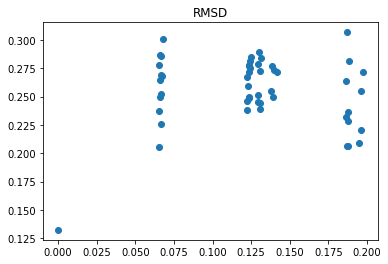

[H]c1c([H])c([H])c(C([H])([H])n2c(=O)n([H])c3c(N([H])C([H])([H])[H])nc(OC([H])([H])C([H])([H])OC([H])([H])[H])nc32)c([H])c1[H]
tensor(0.0067)


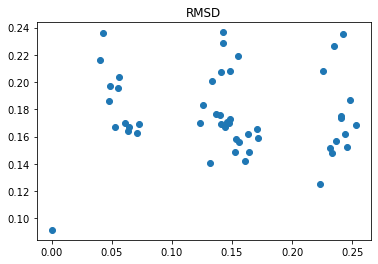

[H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])([H])[H])C([H])([H])[C@@]2([H])C(=O)N([H])C([H])([H])C2([H])[H])N([H])C(=O)C(=O)N([H])C([H])([H])C([H])([H])C2([H])C([H])([H])C2([H])[H])c([H])c1[H]
tensor(0.0076)


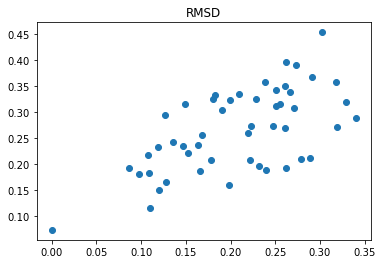

[H]c1c([H])c([H])c2c(c1[H])C(c1c([H])c([H])c(Cl)c([H])c1[H])=NC([H])([H])c1onc(C([H])([H])[H])c1-2
tensor(0.0041)


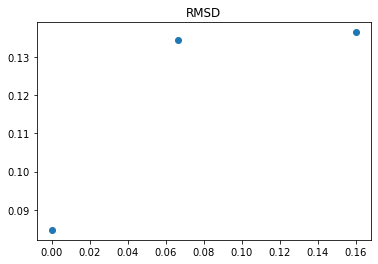

[H]Oc1c([H])c(O[H])c(C(=O)OC([H])([H])[H])c(C([H])([H])C([H])([H])c2nc([H])c([H])n2C([H])([H])c2oc(Cl)c([H])c2[H])c1Cl
tensor(0.0076)


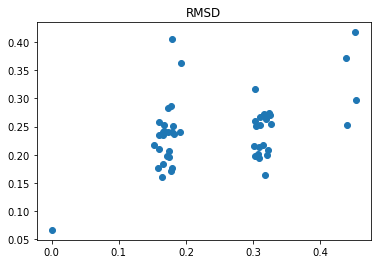

[H]OB(O[H])c1c([H])c([H])c(/C([H])=C(\[H])c2c([H])c(O[H])c([H])c(O[H])c2[H])c(Cl)c1[H]
tensor(0.0145)


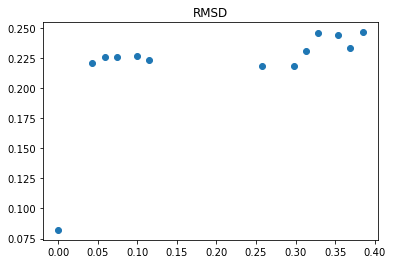

[H]Oc1c(C(=O)n2c([H])c3c([H])c([H])c(F)c([H])c3c2[H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c2onc([H])c12
tensor(0.0444)


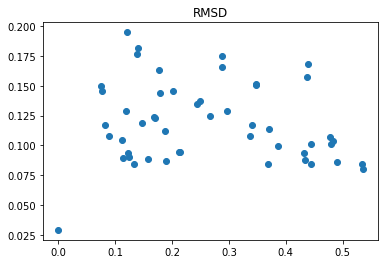

[H]c1sc(N([H])c2c([H])c([H])c([H])c([H])c2OC([H])([H])[H])nc1-c1sc(N([H])C(=O)C([H])([H])[H])nc1C([H])([H])[H]
tensor(0.0292)


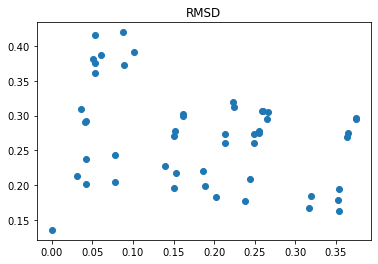

[H]Oc1c([H])c(O[H])c2c(c1[H])/C([H])=C(\[H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])(O[H])C([H])([H])C([H])([H])C([H])([H])[C@]([H])(C([H])([H])[H])OC2=O
tensor(0.0131)


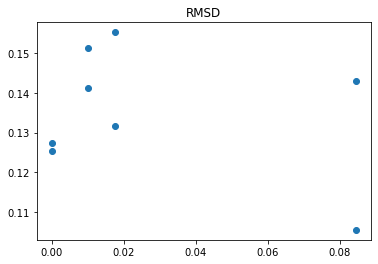

[H]O[C@@]1([H])C([H])([H])O[C@@]([H])(O[H])[C@]([H])(O[H])[C@@]1([H])O[H]
tensor(0.0485)


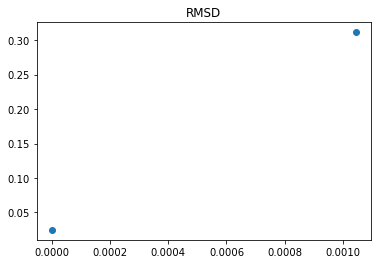

[H]OC([H])([H])/C([H])=C(C(/[H])=C([H])/C([H])=C(C(/[H])=C(\[H])C1=C(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C1(C([H])([H])[H])C([H])([H])[H])\C([H])([H])[H])\C([H])([H])[H]
tensor(0.0167)


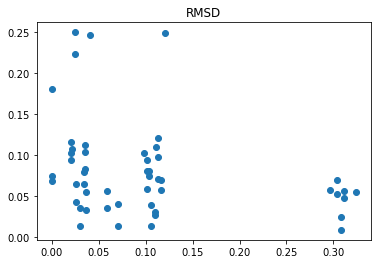

[H]C1=C([C@@]([H])(N([H])C(=O)[C@]([H])(C([H])([H])[H])[N+]([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])[N@@+]([H])([C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)OC([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]1([H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0218)


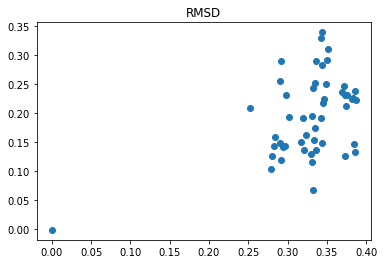

[H]/C(=C(\[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0131)


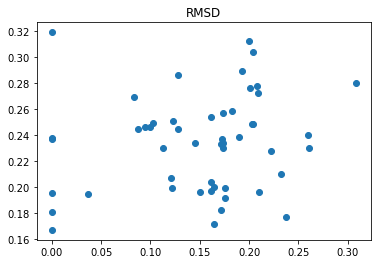

[H]C(=O)[C@]([H])(C([H])([H])C([H])([H])[H])[C@@]1([H])N=C(C(=O)[O-])[C@@]2([H])[C@]([H])(OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[C@]21[H]
tensor(0.0047)


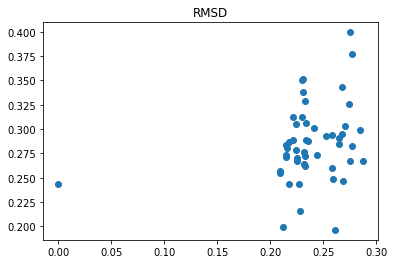

[H]OC([H])([H])c1c([H])c([H])c([H])c(-c2c([H])n([H])c3nc([H])nc(N4C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[N+]([H])([H])[H])C4([H])[H])c23)c1[H]
tensor(0.0113)


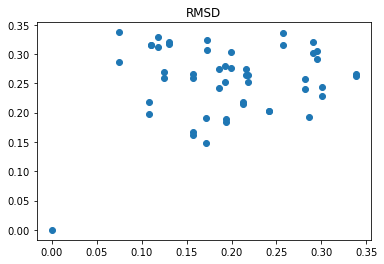

[H]c1c([H])c(C([H])([H])N([H])C(=O)[C@@]2([H])N(C(=O)C([H])([H])C([H])([H])C3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])C([H])([H])C2([H])[H])c([H])c([H])c1C(N([H])[H])=[N+]([H])[H]
tensor(0.0037)


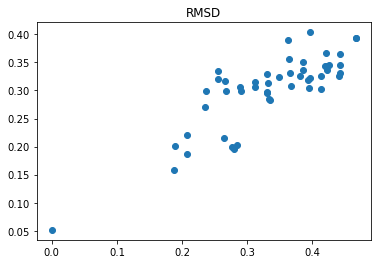

[H]c1c(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C2([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])oc(-c2c([H])c([H])c(Cl)c([H])c2[H])c1[H]
tensor(0.0193)


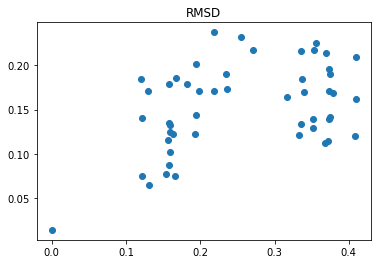

[H]OB(O[H])[C@@]([H])(N([H])S(=O)(=O)C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])c1c([H])c([H])c([H])c(C(=O)[O-])c1[H]
tensor(0.0181)


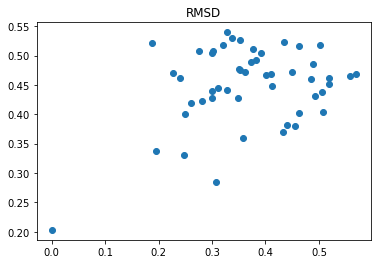

[H]OC([H])([H])C([H])([H])C([H])([H])c1nnn([C@@]2([H])C([H])=C(C(=O)[O-])C([H])([H])[C@@]([H])(OC([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])[C@]2([H])N([H])C(=O)C([H])([H])[H])c1[H]
tensor(0.0013)


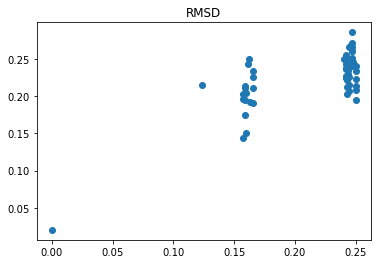

[H]OC1=C([H])C(=O)C([H])=C([H])C1([H])S(=O)(=O)n1c([H])c2c([H])c([H])c(O[H])c([H])c2c1[H]
tensor(0.0486)


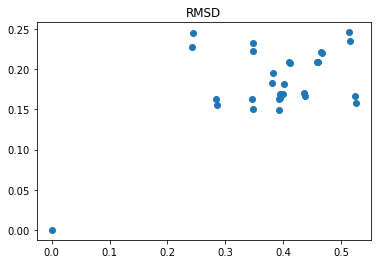

[H]N1C(=[N+]([H])[H])N(C([H])([H])[H])C(=O)[C@@]1(C([H])([H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@@]1([H])C([H])([H])C([H])([H])C([H])([H])[C@@]([H])([N+]([H])([H])C2([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C1([H])[H]
tensor(0.0731)


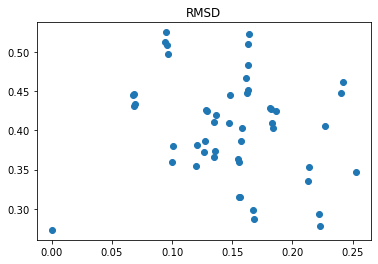

[H]Oc1c(Cl)c([H])c(Cl)c([H])c1Sc1c([H])c(Cl)c([H])c(Cl)c1O[H]
tensor(0.0443)


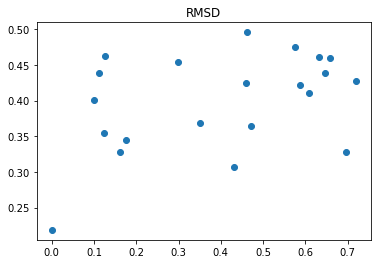

[H]O[C@]([H])(C([H])([H])C(=O)C(=O)[O-])[C@]1(C([H])([H])c2c([H])c([H])c(Cl)c([H])c2[H])C([H])([H])C([H])([H])[N@@+]([H])(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C1([H])[H]
tensor(0.0173)


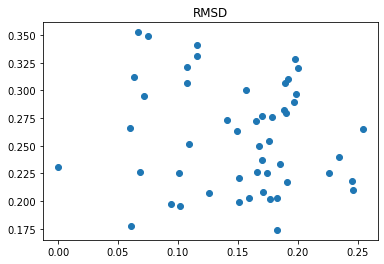

[H]O[C@]1([H])[C@@]([H])(C(=O)N([H])C([H])([H])C([H])([H])[H])O[C@@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)[C@]1([H])O[H]
tensor(0.0095)


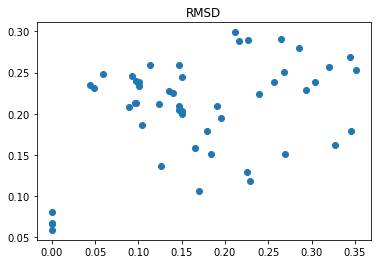

[H]c1c([H])c([H])c(C(=O)N([H])C([H])([H])c2c([H])c(-c3nn(C([H])([H])C([H])([H])C([H])([H])[N@+]4([H])C([H])([H])C([H])([H])[C@@]([H])(n5c(=O)n(C([H])([H])[H])c6c([H])c([H])c(Cl)c([H])c65)C([H])([H])C4([H])[H])c(=O)c([H])c3[H])c([H])c([H])c2Cl)c([H])c1[H]
tensor(0.0283)


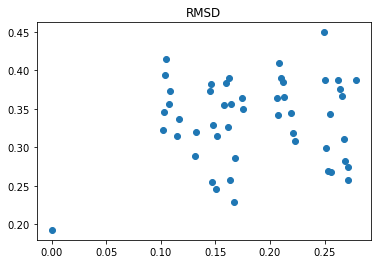

[H]ON([H])C(=O)[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])C([H])([H])O[H])C([H])([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.0074)


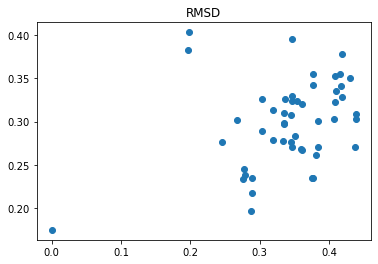

[H]c1nc(N2C([H])([H])C([H])([H])[C@@]([H])([N+]([H])(C([H])([H])[H])C([H])([H])[H])C2([H])[H])c2c(-c3c([H])nn(C([H])([H])[H])c3-c3c([H])c([H])c(C([H])([H])C([H])([H])[H])c([H])c3[H])nn(C([H])([H])[H])c2n1
tensor(0.0242)


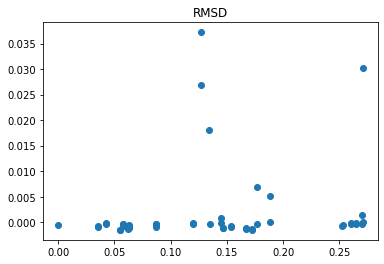

[H]Oc1c([H])c([H])c(-c2c(N([H])[H])nc([H])c(-c3c([H])c([H])c4c(c([H])nn4[H])c3[H])c2C([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.0144)


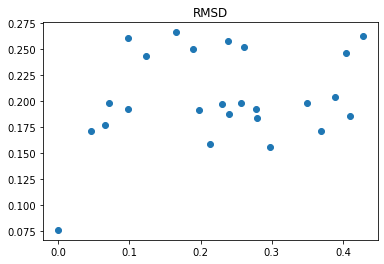

[H]C(=C(C([H])([H])[H])C([H])([H])[H])C([H])([H])N(C(=O)N(C([H])([H])[H])[C@]1([H])C([H])([H])C([H])([H])[C@@]([H])(c2c([H])c([H])nc([H])c2[H])C([H])([H])C1([H])[H])c1c([H])c([H])c([H])c(N([H])C(=O)c2c([H])c([H])c([H])c([H])c2[H])c1[H]
tensor(0.0402)


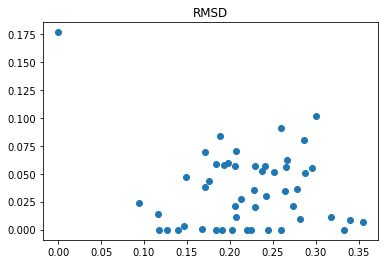

[H]ON([H])C(=O)[C@@]([H])(c1c([H])c([H])c(-c2c([H])c(F)c(F)c(F)c2[H])c([H])c1[H])N([H])C(=O)C1([H])C([H])([H])C([H])([H])OC([H])([H])C1([H])[H]
tensor(0.0089)


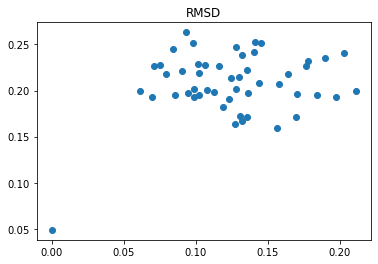

[H]c1c([H])c([C@@]2(C([H])([H])[H])OC(=O)N([H])C2([H])[H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])[H])c1OC([H])([H])[H]
tensor(0.0120)


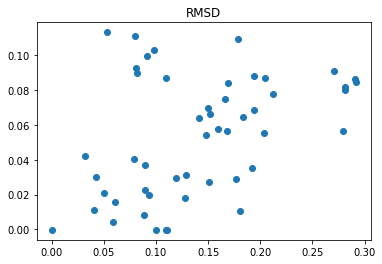

[H]O[C@]1([H])C([H])([H])C([H])([H])[C@@]2(C([H])([H])[H])[C@@]([H])(C([H])([H])C([H])([H])[C@@]3([H])[C@]4([H])C([H])([H])C([H])=C([H])[C@@]4(C([H])([H])[H])C([H])([H])C([H])([H])[C@]23[H])C1([H])[H]
tensor(0.0153)


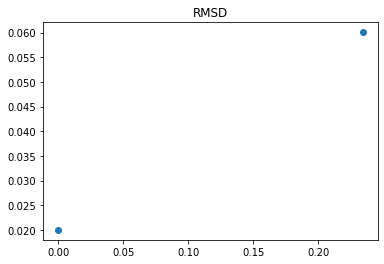

[H]O[C@]1([H])[C@@]([H])(O[H])[C@@]([H])(O[H])N2C(=[N+]([H])[H])N([H])C([H])([H])[C@]2([H])[C@@]1([H])O[H]
tensor(0.0274)


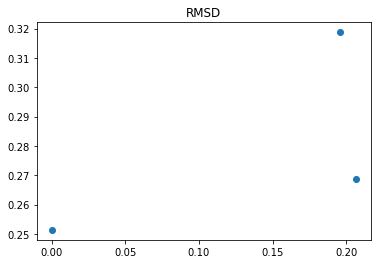

[H]c1nc2c(=O)n(C([H])([H])C([H])([H])C([H])([H])n3c(=O)c4c(nc([H])n4C([H])([H])[H])n(C([H])([H])[H])c3=O)c(=O)n(C([H])([H])[H])c2n1[H]
tensor(0.0266)


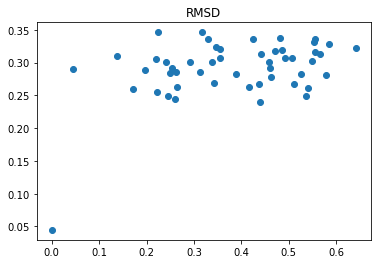

[H]c1c(N([H])[H])nc(C([H])([H])n2c(-c3c([H])c([H])c(OC([H])([H])C([H])([H])C([H])([H])C#N)c([H])c3[H])c([H])c([H])c2-c2c([H])c([H])c([H])c([H])c2Cl)c([H])c1[H]
tensor(0.0111)


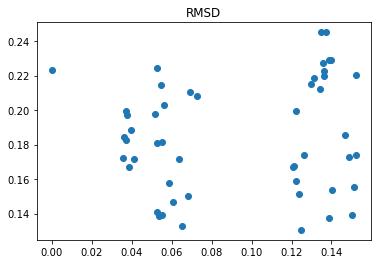

[H]c1c([H])c([H])c(Oc2c(C(=O)N3C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C3([H])[H])c3c([H])c([H])c([H])c([H])c3n2-c2c([H])c([H])c([H])c([H])c2[H])c([H])c1[H]
tensor(0.0109)


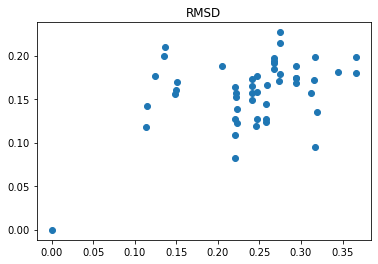

[H]c1c([H])c(C(=O)N([H])[H])c([H])c([N+](=O)[O-])c1I
tensor(0.0464)


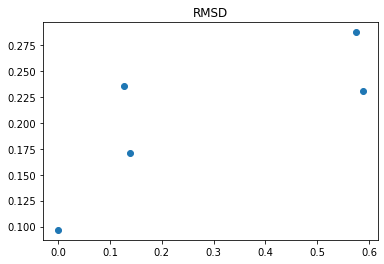

[H]C1=C(c2c([H])c([H])c(C(=O)[O-])c([H])c2[H])C([H])(C#N)C(=O)N([H])[C@]1([H])c1c([H])c([H])c([H])c(OC([H])([H])[H])c1[H]
tensor(0.0075)


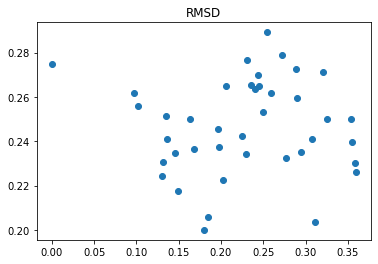

[H]OC([H])([H])C([H])([H])c1c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c1[H]
tensor(0.0277)


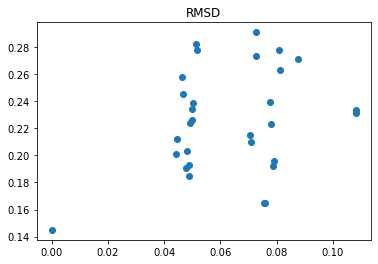

[H]c1nc2c(N([H])C(=O)[C@]3([H])C([H])([H])[C@@]3([H])[C@@]3(C([H])([H])[H])N([H])C(=[N+]([H])[H])OC([H])([H])C3(F)F)c([H])c([H])c([H])c2c([H])c1Cl
tensor(0.0045)


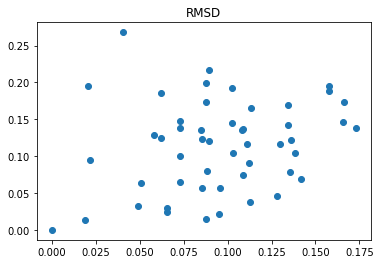

[H]n1c(=O)c2nc(SC([H])([H])C(=O)[O-])n(C([H])([H])[H])c2n([H])c1=[N+]([H])[H]
tensor(0.0155)


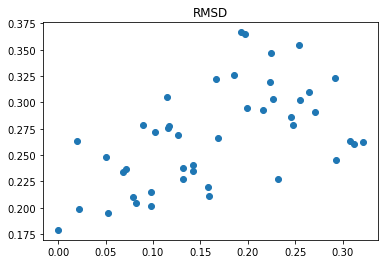

[H]c1c([H])c([H])c2c(=O)n(C([H])([H])C([H])([H])C([H])([H])[C@]3([H])C(=O)C([H])([H])C([H])([H])C([H])([H])[N+]3([H])[H])c([H])nc2c1[H]
tensor(0.0316)


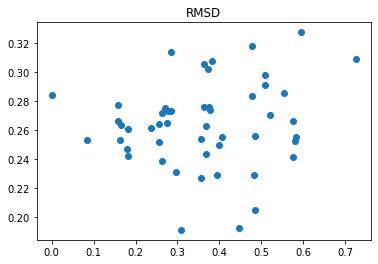

[H]C1=C(c2c([H])c([H])c([H])c([H])c2[H])N(C([H])([H])C([H])([H])c2c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c2[H])C([H])(c2c([H])c([H])c([H])c([H])c2[H])C([H])=C1c1c([H])c([H])c([H])c([H])c1[H]
tensor(0.1012)


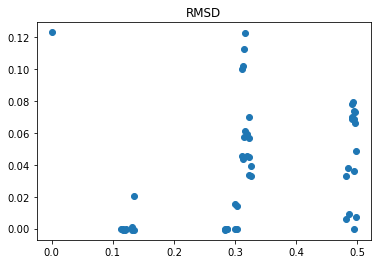

[H]c1c([H])c(OC(=O)N(C([H])([H])[H])[C@]2([H])C([H])([H])C([H])([H])[C@@]([H])(c3c([H])c([H])c(C([H])([H])[N+]4([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C4([H])[H])c([H])c3[H])C([H])([H])C2([H])[H])c([H])c([H])c1Cl
tensor(0.0036)


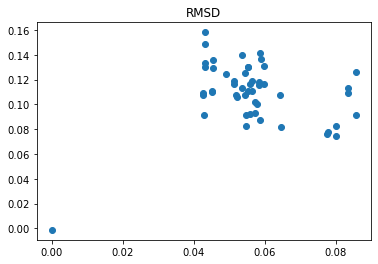

[H]N(C(=O)C([H])([H])[H])[C@@]([H])(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])[C@]1([H])O[C@@]([H])(C(=O)[O-])C([H])([H])[C@@]1([H])C(=O)OC([H])([H])[H]
tensor(0.0095)


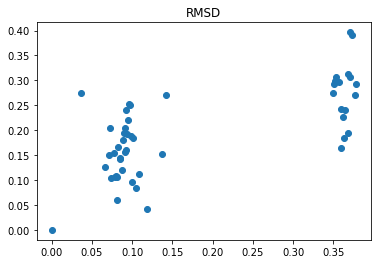

[H]c1c([H])c2c3c(c([H])c([H])c([H])c3c1[H])C(=O)N([H])C2=O
tensor(0.0049)


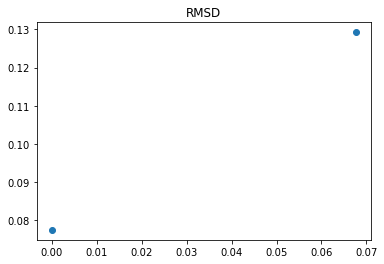

[H]c1nn([H])c([H])c1-c1c([H])sc(C([H])([H])C([H])([H])C([H])([H])[H])c1C([H])([H])[C@]([H])(/N=C1/c2c([H])c([H])c(Cl)c([H])c2C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N1[H])c1nc(=O)c([H])c([H])n1[H]
tensor(0.0126)


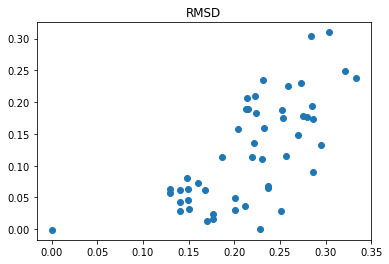

[H]c1c2nc(N([H])C([H])([H])C([H])([H])[N+]3([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])n([H])c2c([H])c2c1c(=O)nc([H])n2[H]
tensor(0.0117)


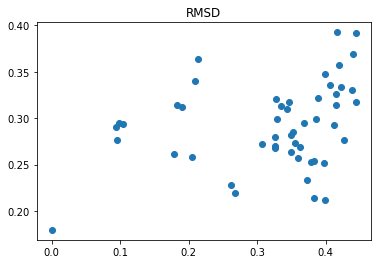

[H]c1sc([H])c(C([H])([H])N(C(=O)C([H])([H])n2nnc3c([H])c([H])c([H])c([H])c32)c2c([H])c([H])c(N([H])C(=O)c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])c1[H]
tensor(0.0068)


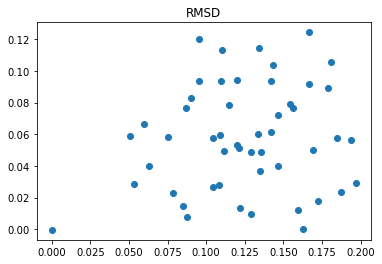

[H]c1c([H])c([H])c2c(c1[H])C(=O)N([H])[C@@]([H])(c1c([H])c([H])c(Cl)c([H])c1[H])N2[H]
tensor(0.0150)


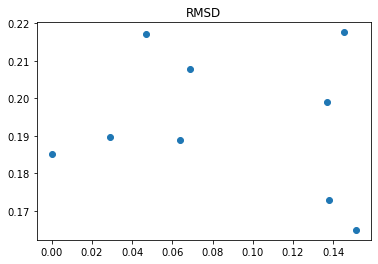

[H]c1nc([H])c([H])c(-c2c([H])c(C(=O)N([H])C([H])([H])[H])n([H])c2[H])c1[H]
tensor(0.0083)


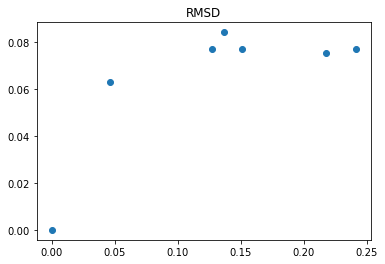

[H]Oc1c([H])c([H])c2c(c1[H])C([H])=C([H])c1c([H])c([H])c([H])c([H])c1C2=C1C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C1([H])[H]
tensor(0.0109)


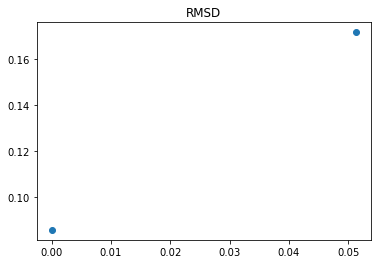

[H]c1nc2c([H])c([C@@]([H])(OC([H])([H])C([H])([H])c3nc([H])c([H])n3C([H])([H])[H])c3c([H])c([H])c([H])c([H])c3Cl)n([H])c2c(C(=O)[O-])c1[H]
tensor(0.0048)


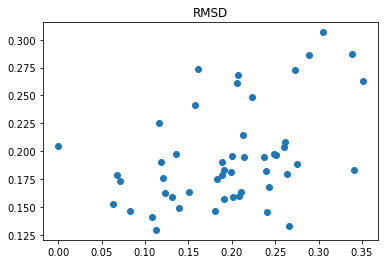

[H]c1nc(N([H])c2c([H])c([H])c([H])c([H])c2[H])nc2c1C([H])([H])C([H])([H])[C@@]1([H])[C@]([H])(C([H])([H])[H])C(=O)[C@@]([H])(C#N)C([H])([H])[C@]21C([H])([H])[H]
tensor(0.0135)


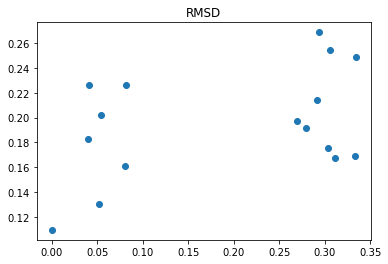

[H]ON([H])C(=O)C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H]
tensor(0.0139)


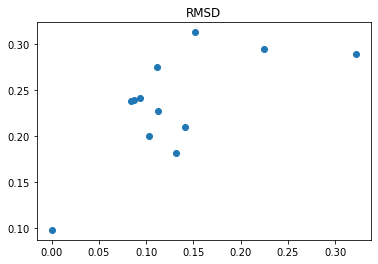

[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-]
tensor(0.0065)


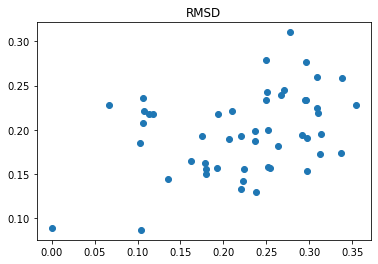

[H]c1c([H])c([H])c(C([H])([H])SC([H])([H])[C@@]([H])(C(=O)N([H])[C@@]([H])(C(=O)[O-])c2c([H])c([H])c([H])c([H])c2[H])N([H])C(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O)[O-])[N+]([H])([H])[H])c([H])c1[H]
tensor(0.0035)


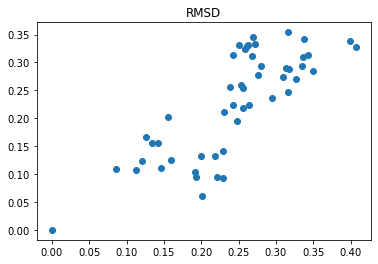

[H]C#CC([H])([H])[C@]([H])(C([H])([H])[C@@]([H])(O[H])[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)c1nc2c([H])c([H])c([H])c([H])c2n1[H])C([H])([H])SC([H])([H])[H])C([H])([H])C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])[C@@]([H])(O[H])[N+]([H])([H])C([H])([H])C([H])([H])[N+]1([H])C([H])([H])C([H])([H])OC([H])([H])C1([H])[H]
tensor(0.0060)


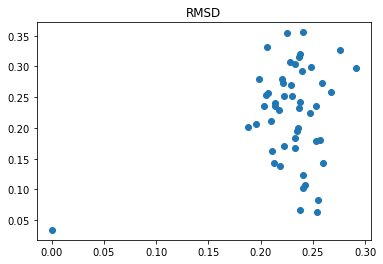

[H]/C(=N\N([H])C(N([H])[H])=[N+]([H])[H])[C@]([H])(C([H])([H])[H])[N+]([H])([H])N([H])C(N([H])[H])=[N+]([H])[H]
tensor(0.0257)


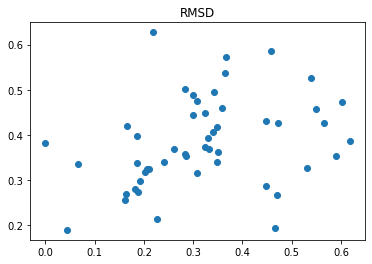

[H]ON([H])C(=O)[C@@]([H])(C([H])([H])c1c([H])c([H])c(I)c([H])c1[H])[N+]([H])([H])[H]
tensor(0.0107)


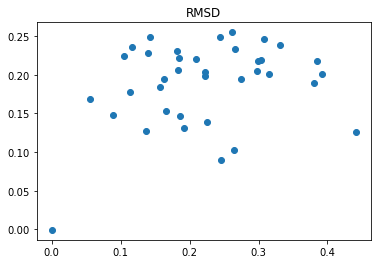

In [7]:
data_dict = group_data_by_smiles(test_dataset)
rmsds = []
pred_rmsds = []
rmsd_losses = []
relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
schnet.eval()
for smiles, data_list in data_dict.items() :
    
    print(smiles)
    mol_rmsd = []
    mol_pred_rmsd = []
    loader = DataLoader(data_list, batch_size=32, shuffle=False)
    
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        rmsd_pred = relu(preds[:, 0]) # to scale between 0 and +inf
        mol_rmsd.extend(batch.tfd.cpu().numpy())
        mol_pred_rmsd.extend(rmsd_pred.detach().cpu().numpy())
        
    rmsd_loss = mseloss(torch.tensor(mol_rmsd), torch.tensor(mol_pred_rmsd))
    rmsd_losses.append(rmsd_loss.item())
    print(rmsd_loss)

    rmsds.extend(mol_rmsd)
    pred_rmsds.extend(mol_pred_rmsd)
    
    plt.scatter(mol_rmsd, mol_pred_rmsd)
    plt.title('RMSD')
    plt.show()

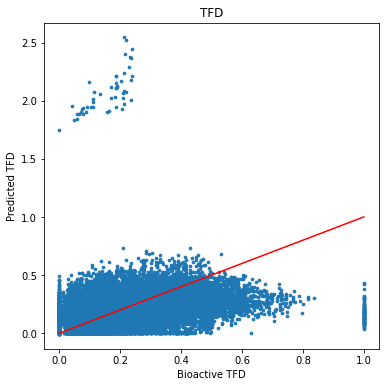

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(rmsds, pred_rmsds, s=7)
plt.title('TFD')
plt.xlabel('Bioactive TFD')
plt.ylabel('Predicted TFD')
plt.plot([0, 1], [0, 1], c='r')
plt.show()

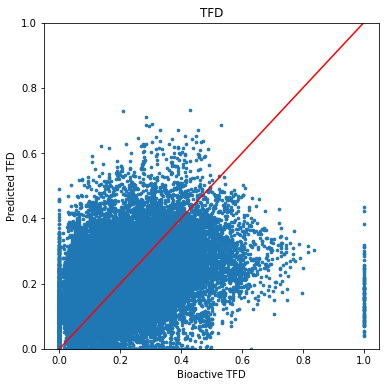

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(rmsds, pred_rmsds, s=7)
plt.title('TFD')
plt.xlabel('Bioactive TFD')
plt.ylabel('Predicted TFD')
plt.plot([0, 1], [0, 1], c='r')
plt.ylim(0, 1)
plt.show()

In [9]:
schnet.eval()

test_losses = []
for batch in test_loader :
    loss = training_step(schnet, batch)
    test_losses.append(loss.item())

In [10]:
np.sum(test_losses) / len(test_loader)

0.02521568395134288

In [11]:
from rdkit import DataStructs

In [12]:
def get_max_sim_to_train_dataset(mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(mol, 2)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.DiceSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim = max(sims)
    return max_sim

In [13]:
data_dict = defaultdict(list)
for i, data in enumerate(test_dataset) :
    smiles = data.smiles
    data_dict[smiles].append(i)

all_ranks = []
accuracies = []
rmsd_losses = []
num_ha = []
max_sims = []

train_smiles = set([data.smiles for data in train_dataset])
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in train_mols]

leaky_relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
for smiles, idxs in data_dict.items() :
    
    mol_ys = []
    mol_preds = []
    loader = DataLoader(test_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        rmsd_preds = leaky_relu(preds[:, 0])
        
        mol_ys.extend(batch.tfd.cpu().numpy().tolist())
        rmsd_preds = rmsd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(rmsd_preds) == float :
            rmsd_preds = [rmsd_preds]
        mol_preds.extend(rmsd_preds)
        
    rmsd_loss = mseloss(torch.tensor(mol_ys), torch.tensor(mol_preds))
        
    mol_ys = np.array(mol_ys)
    mol_preds = np.array(mol_preds)
        
    is_bioactive = mol_ys < 0.1

    rank = mol_preds.argsort().argsort()
    bioactive_ranks = rank[is_bioactive]
    
    bioactive_ranks = bioactive_ranks.tolist()
    if len(bioactive_ranks) :
        accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

        all_ranks.extend(bioactive_ranks)
        accuracies.append(accuracy)
        
        mol = Chem.MolFromSmiles(smiles)
        max_sim = get_max_sim_to_train_dataset(mol, train_fps)
        max_sims.append(max_sim)
        
        rmsd_losses.append(rmsd_loss.item())
        num_ha.append(mol.GetNumHeavyAtoms())

In [25]:
np.mean(accuracies)

0.39156007505501633

In [26]:
np.mean(all_ranks)

20.5138470368776

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9554137c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f955e401210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f954a7f5e10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f955e472410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f955e472c10>],
 'means': []}

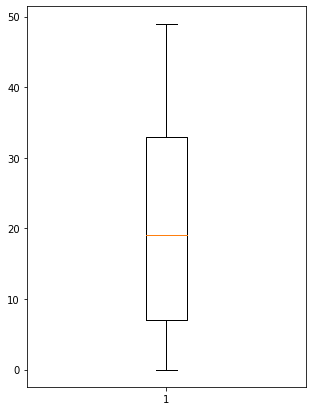

In [27]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

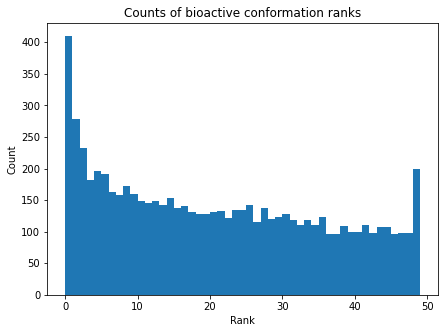

In [28]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

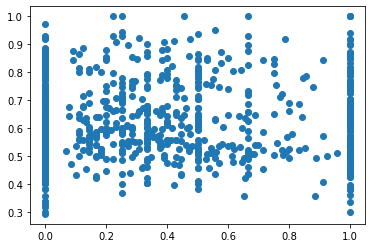

In [29]:
plt.scatter(accuracies, max_sims)

(0.0, 1.0)

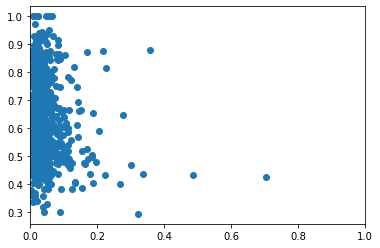

In [32]:
plt.scatter(rmsd_losses, max_sims)
plt.xlim(0, 1)

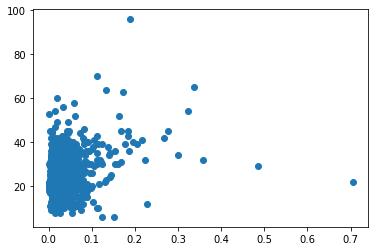

In [33]:
plt.scatter(rmsd_losses, num_ha)

# Molecule Overlap between Train, Val and Test sets

In [29]:
train_noh_smiles = set()
for data in train_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    train_noh_smiles.update([smiles])

In [30]:
val_noh_smiles = set()
for data in val_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    val_noh_smiles.update([smiles])

In [36]:
test_noh_smiles = set()
for data in test_dataset :
    smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(data.smiles)), isomericSmiles=False)
    test_noh_smiles.update([smiles])

In [31]:
overlap = train_noh_smiles.intersection(val_noh_smiles)
len(overlap)

In [37]:
overlap = train_noh_smiles.intersection(test_noh_smiles)
len(overlap)

7

In [33]:
len(train_noh_smiles)

3149

In [34]:
len(val_noh_smiles)

859

In [45]:
all_ranks = []
accuracies = []

for smiles, idxs in data_dict.items() :
    mol_ys = []
    mol_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        tfd_preds = preds[:, 1]
        
        mol_ys.extend(batch.tfd.cpu().numpy().tolist())
        tfd_preds = tfd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(tfd_preds) == float :
            tfd_preds = [tfd_preds]
        mol_preds.extend(tfd_preds)
        
    mol_ys = np.array(mol_ys)
    mol_preds = np.array(mol_preds)
        
    is_bioactive = mol_ys < 0.1

    rank = mol_preds.argsort().argsort()
    bioactive_ranks = rank[is_bioactive]
    
    bioactive_ranks = bioactive_ranks.tolist()
    if len(bioactive_ranks) :
        accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

        all_ranks.extend(bioactive_ranks)
        accuracies.append(accuracy)

In [46]:
np.mean(accuracies)

0.3690211587175861

In [47]:
np.mean(all_ranks)

19.745909528392684

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e7f8bc950>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e7f8bf210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e7eb8c2d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e7f8bfa50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e7f8bfe50>],
 'means': []}

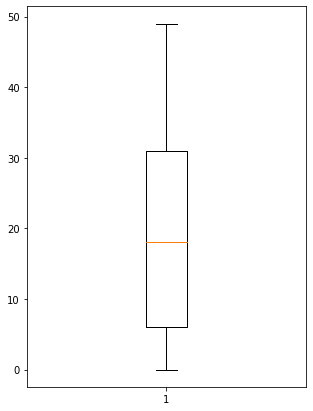

In [48]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

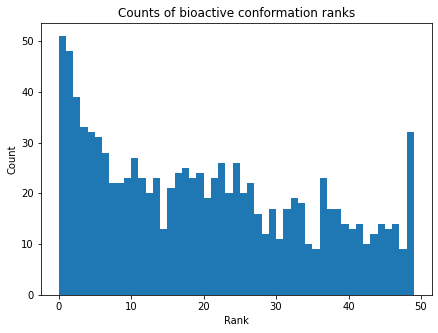

In [49]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

In [72]:
from sklearn.metrics import balanced_accuracy_score

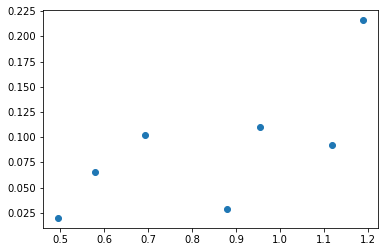

In [83]:
plt.scatter(mol_rmsds, mol_tfds)

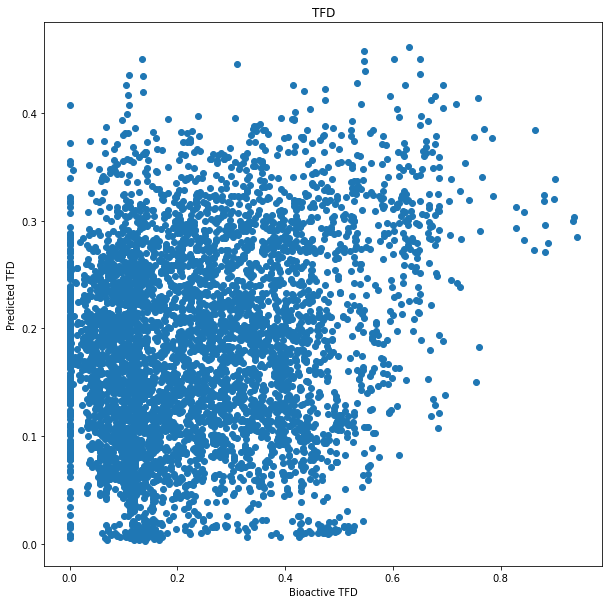

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(tfds, pred_tfds)
plt.title('TFD')
plt.xlabel('Bioactive TFD')
plt.ylabel('Predicted TFD')
plt.show()

[H]N1C(=[N+]([H])[H])N([H])[C@@]2([H])C([H])([H])S[C@@]([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)[O-])[C@@]12[H]
tensor(0.1615, grad_fn=<MseLossBackward>)


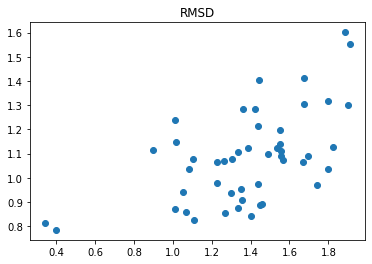

[H]Oc1c([H])c([H])c(C2=C(c3c([H])c([H])c(O[H])c([H])c3[H])[C@]3([H])O[C@@]2([H])[C@]([H])(C(=O)OC([H])([H])C([H])([H])[H])[C@]3([H])C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H]
tensor(0.5662, grad_fn=<MseLossBackward>)


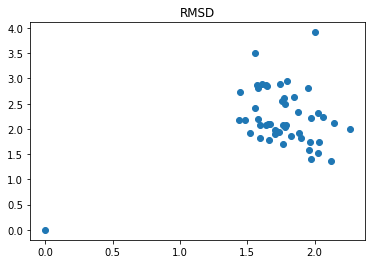

[H]c1nc([H])c([H])c(C([H])([H])N([H])c2c([H])c(-c3c([H])c([H])c([H])c([H])c3F)nc3c([H])c([H])nn23)c1[H]
tensor(0.2807, grad_fn=<MseLossBackward>)


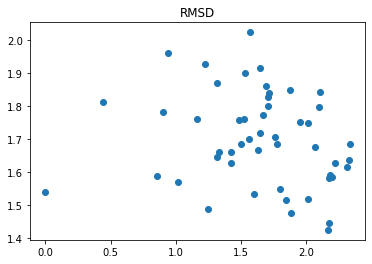

[H]c1c([H])c([H])c(C([H])([H])N([C@@]2([H])C([H])([H])[N+]([H])([H])C([H])([H])[C@]2([H])N(C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])S(=O)(=O)c2c([H])c([H])c(N([H])[H])c([H])c2[H])c([H])c1[H]
tensor(2.1677, grad_fn=<MseLossBackward>)


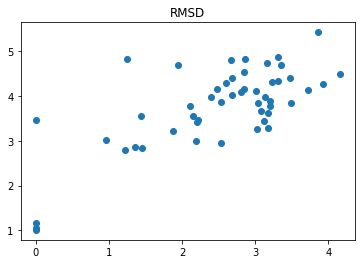

[H]OC([H])([H])[C@@]1([H])N([H])/C(=N\C([H])([H])C([H])([H])[N+]([H])([H])[H])[C@@]([H])(O[H])[C@@]([H])(O[H])[C@]1([H])O[H]
tensor(0.1977, grad_fn=<MseLossBackward>)


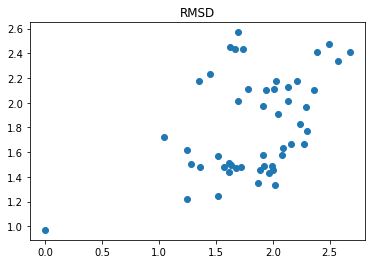

[H]c1c([H])c([H])c(C([H])([H])[N@@+]2([H])[C@@]3([H])C([H])([H])C([H])([H])[C@]2([H])C([H])([H])[C@]([H])(OC2([H])c4c([H])c([H])c([H])c([H])c4C([H])([H])C([H])([H])c4c([H])c([H])c([H])c([H])c42)C3([H])[H])c([H])c1[H]
tensor(0.2899, grad_fn=<MseLossBackward>)


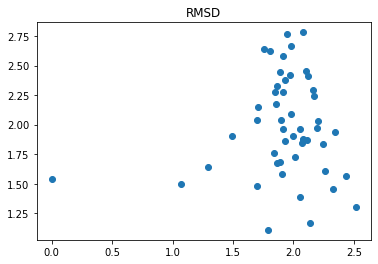

[H]c1nc([H])c(C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c([H])c1[H]
tensor(0.0697, grad_fn=<MseLossBackward>)


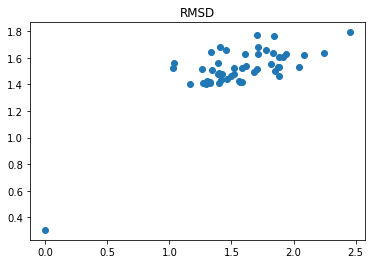

[H]C(=O)[C@@]1([H])N(C(=O)N([H])[C@@]2([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])C([H])([H])C2([H])[H])C([H])([H])C([H])([H])[C@@]1([H])N([H])S(=O)(=O)[O-]
tensor(0.3381, grad_fn=<MseLossBackward>)


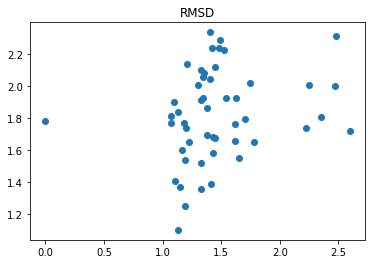

[H]c1nc2c(c([H])nn2[H])c(N2C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[N+]([H])([H])[H])C2([H])[H])c1C(=O)OC([H])([H])C([H])([H])[H]
tensor(0.2666, grad_fn=<MseLossBackward>)


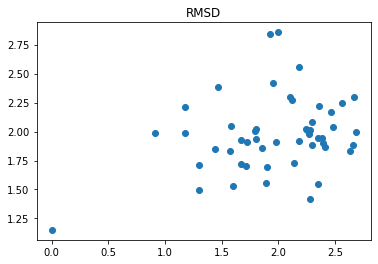

[H]c1oc(C(=O)N([H])[C@]([H])(C(=O)N2C([H])([H])c3c(c4c([H])c([H])c([H])c([H])c4n3[H])C([H])([H])[C@@]2([H])C(=O)[O-])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]
tensor(1.2482, grad_fn=<MseLossBackward>)


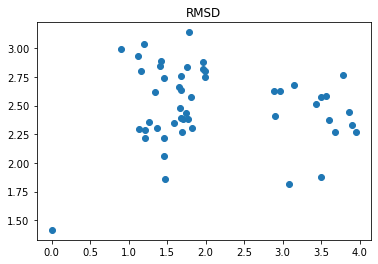

[H]c1c(N=C=S)c([H])c2c([H])c(C3=NC([H])([H])C([H])([H])N3[H])oc2c1[H]
tensor(0.3278, grad_fn=<MseLossBackward>)


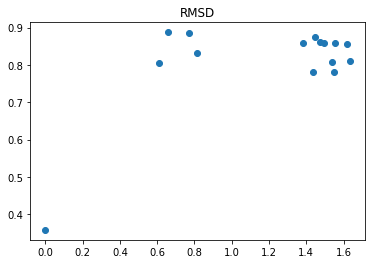

[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)C([H])([H])C(=O)C(F)(F)F
tensor(0.0852, grad_fn=<MseLossBackward>)


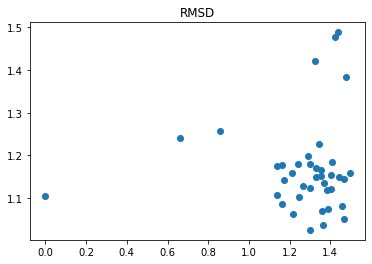

[H]Oc1c([H])c([H])c(Cl)c([H])c1Oc1c([H])c([H])c(Cl)c2c([H])c([H])c([H])nc12
tensor(0.3956, grad_fn=<MseLossBackward>)


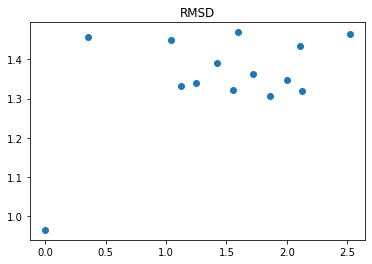

[H]OC([H])([H])[C@@]([H])(c1c([H])c([H])c([H])c([H])c1[H])[N+]([H])([H])C([H])([H])[C@@]1([H])N(C([H])([H])[H])C(=O)[C@]([H])(O[H])[C@]1([H])O[H]
tensor(0.5026, grad_fn=<MseLossBackward>)


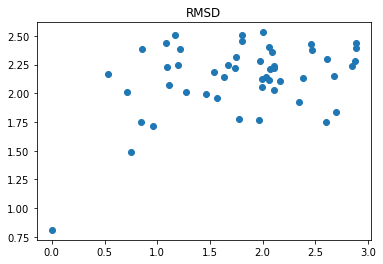

[H]Oc1c([H])c([H])c(Cl)c([H])c1N1C(=O)C([H])([H])S[C@@]1([H])c1c([H])c([H])c([H])c(Br)c1[H]
tensor(0.6374, grad_fn=<MseLossBackward>)


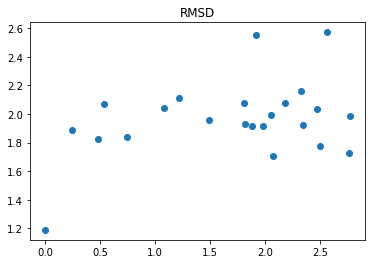

[H]O[C@]1(C(=O)OC([H])([H])[H])C([H])([H])[C@@]2([H])O[C@]1(C([H])([H])[H])n1c3c([H])c([H])c([H])c([H])c3c3c4c(c5c6c([H])c([H])c([H])c([H])c6n2c5c31)C(=O)N([H])C4([H])[H]
tensor(2.3099, grad_fn=<MseLossBackward>)


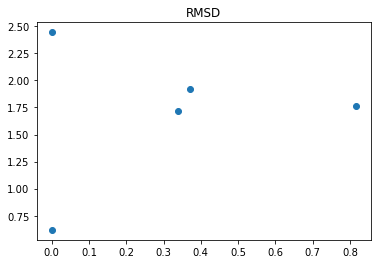

[H]c1c([H])c([H])c2c(c1[H])N([H])C(=O)[C@@]21C([H])([H])[C@]([H])(C(=O)O[C@]2([H])c3c([H])c(Br)c([H])c([H])c3S(=O)(=O)C([H])([H])C2([H])[H])[N+]([H])([H])C1([H])[H]
tensor(0.5375, grad_fn=<MseLossBackward>)


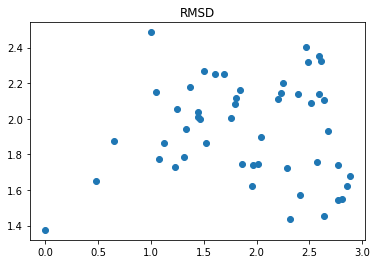

[H]c1nc(N2C([H])([H])C([H])([H])C3(C([H])([H])C2([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]3([H])[H])c2c(n1)nc([H])n2[H]
tensor(0.2719, grad_fn=<MseLossBackward>)


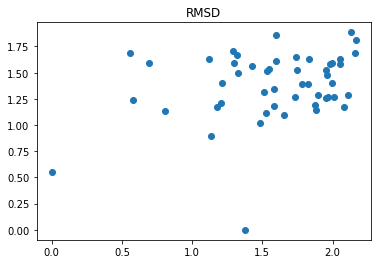

[H]c1nc2c(c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n2[H])c(-c2c([H])c([H])c(S(=O)(=O)N([H])C3([H])C([H])([H])C([H])([H])S(=O)(=O)C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
tensor(0.5263, grad_fn=<MseLossBackward>)


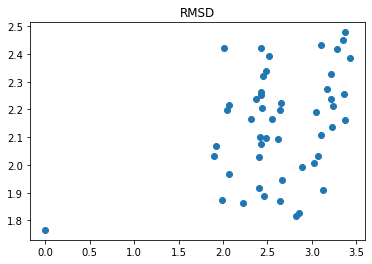

[H]c1nn([H])c([H])c1-c1c([H])c([H])c(C(=O)N([H])c2c([H])c([H])c([H])c([H])c2[H])c(OC([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])c1[H]
tensor(0.1950, grad_fn=<MseLossBackward>)


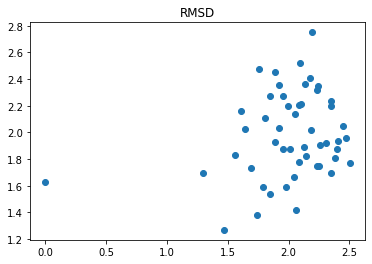

[H]c1c([H])c(S(=O)(=O)N2C([H])([H])C([H])([H])[N+]([H])(C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c(-c2nc3c(c(=O)n2[H])C([H])([H])C([H])([H])C3([H])[H])c1OC([H])([H])C([H])([H])C([H])([H])[H]
tensor(0.8581, grad_fn=<MseLossBackward>)


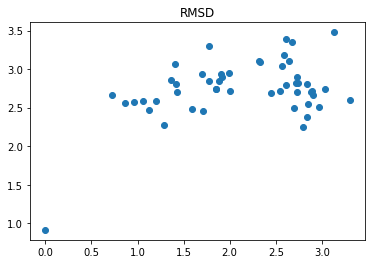

[H]c1c(Cl)c(N([H])C(=O)C([H])([H])[H])c(Cl)c([H])c1C([H])([H])N([H])C(N([H])C(=O)C([H])([H])n1c([H])c([H])c2c([H])c([H])c([H])c([H])c21)=[N+]([H])[H]
tensor(0.5987, grad_fn=<MseLossBackward>)


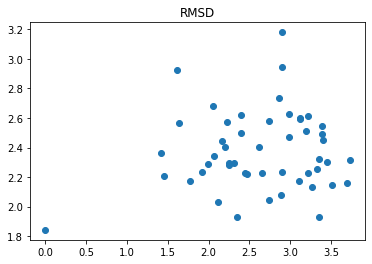

[H]/C1=C(/C([H])([H])[H])C(=O)N([H])c2c([H])c(OC([H])([H])[H])c([H])c(c2[H])C([H])([H])OC([H])([H])[C@]([H])(OC([H])([H])[H])[C@]([H])(OC([H])([H])[H])[C@@]([H])(C([H])([H])[H])/C([H])=C(\C([H])([H])[H])[C@]([H])(OC(=O)N([H])[H])[C@@]([H])(OC(=O)N([H])[H])C([H])([H])C1([H])[H]
tensor(0.5251, grad_fn=<MseLossBackward>)


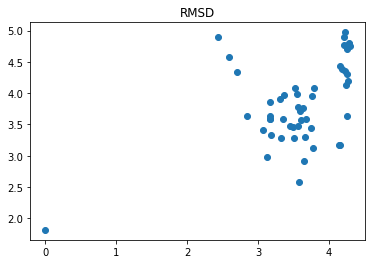

[H]c1c([H])c([H])c(C([H])([H])[C@]2([H])O[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])[C@@]([H])(c3c([H])c([H])c(Br)c([H])c3[H])N(C([H])([H])[H])C2=O)c([H])c1[H]
tensor(1.9150, grad_fn=<MseLossBackward>)


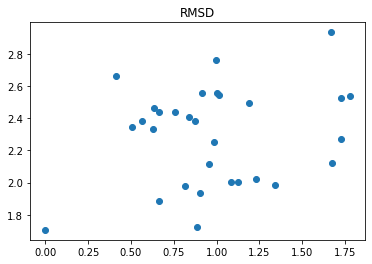

[H]c1c(Br)c2c(c([H])c1C([H])([H])[H])C(=O)C(=O)N2[H]
tensor(0.1009, grad_fn=<MseLossBackward>)


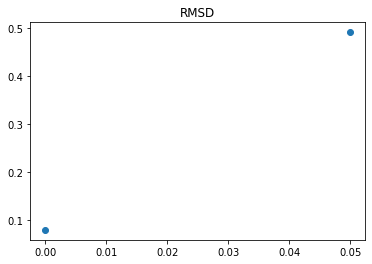

[H]OC([H])([H])[C@@]([H])(N([H])C(=O)C([H])([H])C([H])([H])c1nc2c([H])c([H])c([H])c([H])c2c(=O)n1[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]


KeyboardInterrupt: 

In [7]:
data_dict = group_data_by_smiles(test_dataset)
rmsds = []
tfds = []
pred_rmsds = []
pred_tfds = []
rmsd_losses = []
tfd_losses = []
relu = torch.nn.LeakyReLU()
mseloss = torch.nn.MSELoss()
schnet.eval()
for smiles, data_list in data_dict.items() :
    print(smiles)
    mol_rmsd = []
    mol_pred_rmsd = []
    loader = DataLoader(data_list, batch_size=32, shuffle=False)
    for batch in loader :
        batch = batch.to('cuda')
        preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
    
        rmsd_pred = relu(preds[:, 0]) # to scale between 0 and +inf
        rmsd_loss = mseloss(rmsd_pred, batch.rmsd)
        rmsd_losses.append(rmsd_loss.item())
        print(rmsd_loss)

        rmsds.extend(batch.rmsd.cpu().numpy())
        pred_rmsds.extend(rmsd_pred.detach().cpu().numpy())
    
    plt.scatter(batch.rmsd.cpu().numpy(), rmsd_pred.detach().cpu().numpy())
    plt.title('RMSD')
    plt.show()
    
#     tfd_pred = torch.sigmoid(preds[:, 1]) # to scale betwenn 0 and 1
#     tfd_loss = mseloss(tfd_pred, batch.tfd)
#     tfd_losses.append(tfd_loss.item())
#     print(tfd_loss)
    
#     tfds.extend(batch.tfd.cpu().numpy())
#     pred_tfds.extend(tfd_pred.detach().cpu().numpy())
    
#     plt.scatter(batch.tfd.cpu().numpy(), tfd_pred.detach().cpu().numpy())
#     plt.title('TFD')
#     plt.show()

In [99]:
all_ranks = []
accuracies = []
bas = []

for smiles, idxs in data_dict.items() :
    mol_rmsds = []
    mol_tfds = []
    mol_rmsd_preds = []
    mol_tfd_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        
        mol_rmsds.extend(batch.rmsd.cpu().numpy().tolist())
        mol_tfds.extend(batch.tfd.cpu().numpy().tolist())
        
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        
        rmsd_preds = preds[:, 0]
        tfd_preds = preds[:, 1]
        
        rmsd_preds = rmsd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(rmsd_preds) == float :
            rmsd_preds = [rmsd_preds]
        mol_rmsd_preds.extend(rmsd_preds)
        
        tfd_preds = tfd_preds.detach().cpu().numpy().squeeze().tolist()
        if type(tfd_preds) == float :
            tfd_preds = [tfd_preds]
        mol_tfd_preds.extend(tfd_preds)
        
    mol_rmsds = np.array(mol_rmsds)
    mol_tfds = np.array(mol_tfds)
    mol_rmsd_preds = np.array(mol_rmsd_preds)
    mol_tfd_preds = np.array(mol_tfd_preds)
        
    is_bioactive = (mol_rmsds < 1) #& (mol_tfds < 0.05)
    pred_bioactive = (mol_rmsd_preds < 1) #| (mol_tfd_preds < 0.05)
    if any(is_bioactive) :
        ba = balanced_accuracy_score(is_bioactive, pred_bioactive)
        bas.append(ba)

        rank = mol_rmsd_preds.argsort().argsort()
        bioactive_ranks = rank[is_bioactive]

        bioactive_ranks = bioactive_ranks.tolist()
        if len(bioactive_ranks) :
            accuracy = len(set(bioactive_ranks).intersection(set(range(len(bioactive_ranks))))) / len(bioactive_ranks)

            all_ranks.extend(bioactive_ranks)
            accuracies.append(accuracy)

/home/baillifb/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/baillifb/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [96]:
np.array(bas).mean()

0.6029266190134513

In [70]:
pred_bioactive = (mol_rmsd_preds < 0.1) | (mol_tfd_preds < 0.1)

In [54]:
is_bioactive

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

In [100]:
np.mean(accuracies)

0.4951161347576106

In [101]:
np.mean(all_ranks)

14.792431192660551

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e7ff10510>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e47c44a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e47b31890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e47b106d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e47b10950>],
 'means': []}

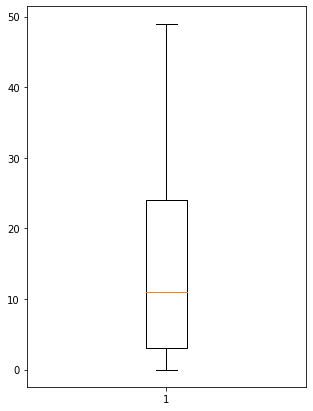

In [102]:
plt.figure(figsize=(5, 7))
plt.boxplot(all_ranks)

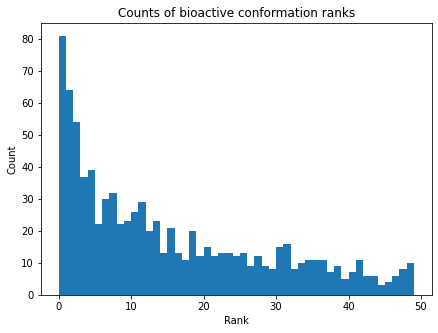

In [103]:
plt.figure(figsize=(7, 5))
plt.hist(all_ranks, bins=49)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Counts of bioactive conformation ranks')
plt.savefig('Histogram_ranks', dpi=300)

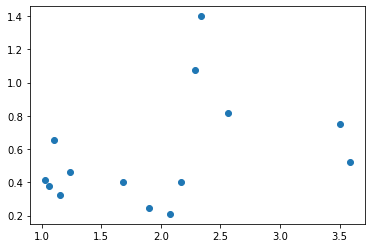

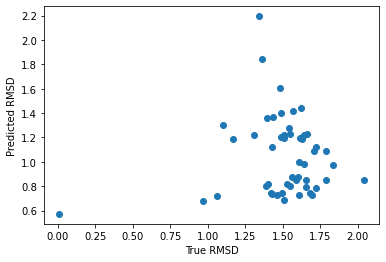

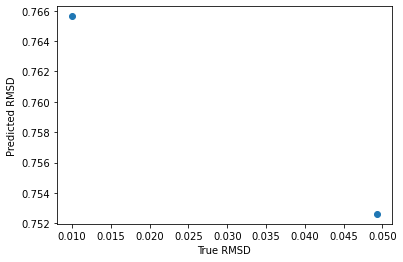

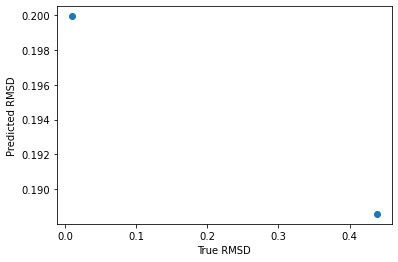

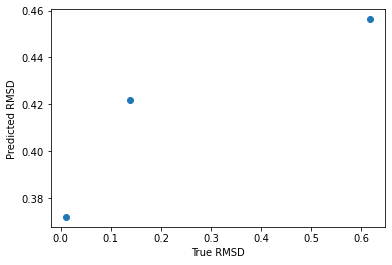

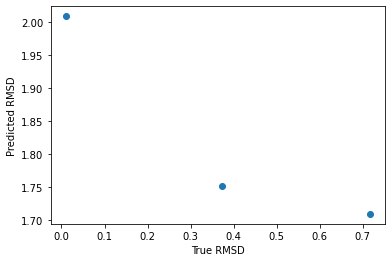

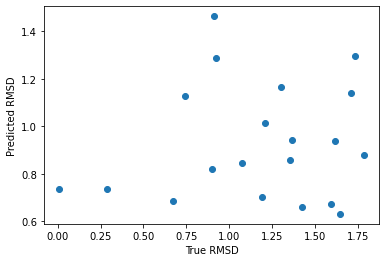

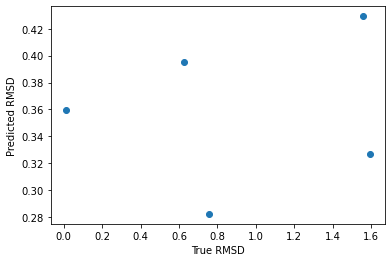

KeyboardInterrupt: 

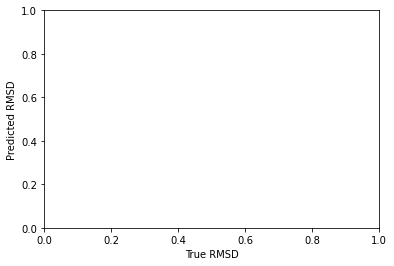

In [40]:
import time
all_ys = []
all_preds = []
mols = []
for smiles, idxs in data_dict.items() :
    mol_ys = []
    mol_preds = []
    loader = DataLoader(val_dataset[idxs], batch_size=16)
    for batch in loader :
        batch = batch.to('cuda')
        mol = Chem.MolFromSmiles(batch.smiles[0])
        mols.append(mol)
        preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
        mol_ys.extend(batch.rmsd.cpu().numpy().tolist())
        mol_preds.extend(preds.exp().detach().cpu().numpy().tolist())
    plt.scatter(mol_ys, mol_preds)
    plt.show()
    plt.xlabel('True RMSD')
    plt.ylabel('Predicted RMSD')
    #is_bioactive = int(batch.y.detach().cpu().numpy() == 0.01)
    all_ys.append(mol_ys)
    all_preds.append(mol_preds)
    time.sleep(1)

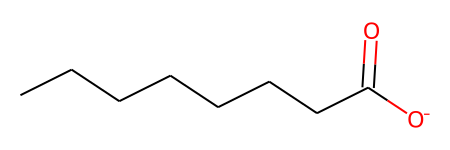

In [41]:
mols[1]

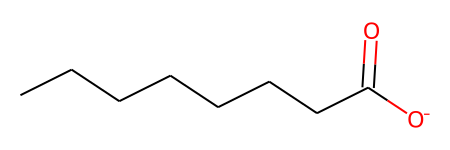

In [25]:
mols[2]

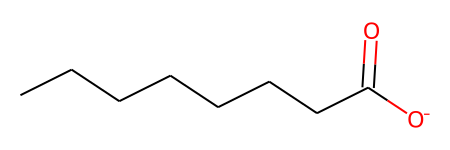

In [26]:
mols[3]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2560220510>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2560220d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2560220150>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2560218690>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2560218ad0>],
 'means': []}

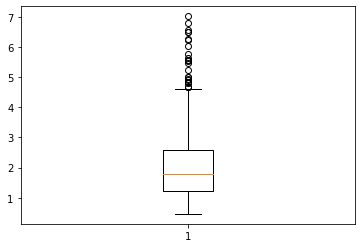

In [42]:
plt.boxplot(val_losses)

In [43]:
bioactive_rmsds = batch.rmsd.detach().cpu()

In [44]:
pred_rmsds = preds.exp().detach().cpu()

In [45]:
pred_rmsds

tensor([[0.3597],
        [0.3270],
        [0.4292],
        [0.2825],
        [0.3955]])

In [46]:
mols = [Chem.MolFromSmiles(s) for s in batch.smiles]
n_heavy_atoms = [mol.GetNumHeavyAtoms() for mol in mols]

In [47]:
squared_errors = torch.square(preds - batch.rmsd.log().unsqueeze(1)).detach().cpu()

In [48]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of heavy atoms')

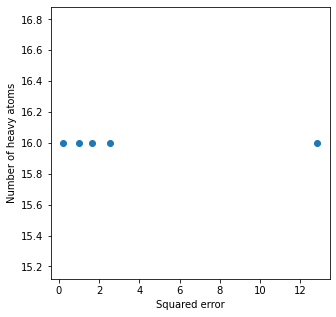

In [49]:
plt.figure(figsize=(5,5))
plt.scatter(squared_errors, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Squared error')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Number of heavy atoms')

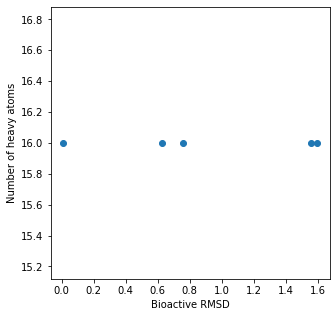

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(bioactive_rmsds, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Bioactive RMSD')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Number of heavy atoms')

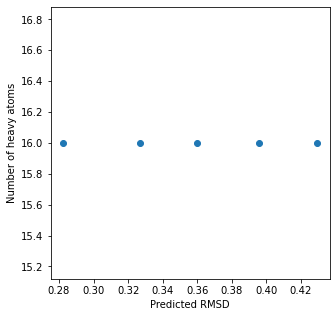

In [51]:
plt.figure(figsize=(5,5))
plt.scatter(pred_rmsds, n_heavy_atoms)
#plt.xlim(0, 7)
#plt.ylim(0, 5)
#plt.plot([0,5], [0,5])
plt.xlabel('Predicted RMSD')
plt.ylabel('Number of heavy atoms')

Text(0, 0.5, 'Predicted RMSD')

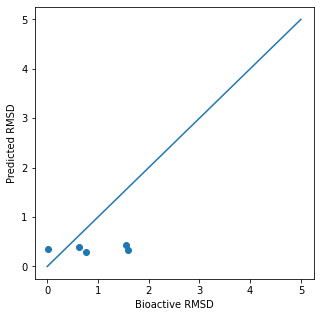

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(bioactive_rmsds, pred_rmsds)
#plt.xlim(0, 5)
#plt.ylim(0, 5)
plt.plot([0,5], [0,5])
plt.xlabel('Bioactive RMSD')
plt.ylabel('Predicted RMSD')

In [28]:
preds

tensor([[5.5809],
        [5.8469]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [29]:
batch.y.log()

tensor([1.5215, 0.8020], device='cuda:0')

In [20]:
len(dataset)

236668

In [21]:
smiles = []
for data in dataset :
    if data.y == 0.01 :
        smiles.append(data.smiles)

In [22]:
from collections import Counter
c = Counter(smiles)

In [23]:
c.most_common()[0]

('[H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])S(=O)(=O)c1c([H])c([H])c(N([H])[H])c([H])c1[H])[C@@]([H])(N([H])C(=O)O[C@@]1([H])C([H])([H])O[C@@]2([H])OC([H])([H])C([H])([H])[C@]21[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H]',
 35)

In [24]:
most_common_smiles = c.most_common()[0][0]

In [25]:
# for smiles, conf_ensemble in tqdm(conf_ensemble_library.get_unique_molecules()) :
#     mol = conf_ensemble.mol
#     data_list = dataset.featurize_mol(mol)

In [26]:
data_ensemble = []
for data in dataset :
    if data.smiles == most_common_smiles :
        data_ensemble.append(data)

In [50]:
most_common_mol = conf_ensemble_library.get_conf_ensemble(most_common_smiles).mol

In [74]:
from rdkit.Chem.TorsionFingerprints import GetTFDMatrix, GetTFDBetweenConformers
from scipy.spatial.distance import squareform

In [51]:
rdkit_decoys = copy.deepcopy(most_common_mol)
cids = EmbedMultipleConfs(rdkit_decoys, 15, clearConfs=False)

In [52]:
[cid for cid in cids]

[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [53]:
rdkit_decoys.GetNumConformers()

50

In [54]:
tfd_matrix = squareform(GetTFDMatrix(rdkit_decoys))

In [47]:
Batch.from_data_list(data_ensemble).y

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 4.2425,
        3.2086, 4.0902, 2.7070, 2.7178, 2.4065, 3.6938, 4.5432, 3.4962, 3.8905,
        3.8948, 4.0457, 3.4856, 3.0563, 3.2820])

In [67]:
tfd_matrix[0]

array([0.        , 0.02498095, 0.03412539, 0.02453632, 0.01856428,
       0.01628983, 0.02011488, 0.02388207, 0.02098394, 0.03696151,
       0.01735393, 0.02660693, 0.02349047, 0.01685428, 0.01591624,
       0.0298694 , 0.03024564, 0.01190867, 0.01707003, 0.01479341,
       0.0242654 , 0.01394391, 0.02019689, 0.01553145, 0.03130011,
       0.0143179 , 0.01620005, 0.02397508, 0.01902534, 0.05747179,
       0.03588157, 0.0303823 , 0.03967478, 0.04638873, 0.03912702,
       0.02831882, 0.04062053, 0.04768421, 0.03072303, 0.02437665,
       0.03251602, 0.04424735, 0.035359  , 0.02606463, 0.0364481 ,
       0.02347327, 0.0278658 , 0.02191388, 0.02613846, 0.01725462])

In [79]:
GetTFDBetweenConformers(rdkit_decoys, [0, 1], [0, 1])

[0.0, 0.024980946486236926, 0.024980946486236926, 0.0]

In [71]:
import numpy as np
from rdkit.Chem.rdMolAlign import GetBestRMS
rmsd_matrix = np.zeros((50, 50))
for conf_id1 in range(rdkit_decoys.GetNumConformers()) :
    for conf_id2 in range(rdkit_decoys.GetNumConformers()) :
        rmsd_matrix[conf_id1, conf_id2] = GetBestRMS(rdkit_decoys, rdkit_decoys, conf_id1, conf_id2, maxMatches=1000)

In [82]:
tfd_matrix = np.zeros((50, 50))
for conf_id1 in range(rdkit_decoys.GetNumConformers()) :
    for conf_id2 in range(rdkit_decoys.GetNumConformers()) :
        tfd_matrix[conf_id1, conf_id2] = GetTFDBetweenConformers(rdkit_decoys, [conf_id1], [conf_id2])[0]

In [83]:
tfd_matrix[0]

array([0.        , 0.02498095, 0.03412539, 0.01856428, 0.02388207,
       0.02660693, 0.03024564, 0.02019689, 0.05747179, 0.04768421,
       0.0278658 , 0.02803997, 0.03180698, 0.02689749, 0.02191215,
       0.01181887, 0.02017549, 0.05758138, 0.0284876 , 0.0236356 ,
       0.02444162, 0.1566667 , 0.02505116, 0.02786319, 0.01954324,
       0.02518331, 0.02680734, 0.02447116, 0.02149904, 0.01457815,
       0.02621564, 0.02278008, 0.02388158, 0.01983683, 0.01990052,
       0.40712306, 0.31065883, 0.36752045, 0.3425487 , 0.42697985,
       0.2924398 , 0.28071864, 0.29190729, 0.3841577 , 0.42422707,
       0.42557737, 0.25958493, 0.33727532, 0.39501014, 0.43249754])

In [80]:
rmsd_matrix[0]

array([0.        , 0.18506186, 0.16493749, 0.18781775, 0.26000489,
       0.42312892, 0.12980779, 0.12635767, 0.28876139, 0.27362755,
       0.20830762, 0.18329113, 1.27045034, 0.3173347 , 1.22336932,
       1.20868652, 1.2679377 , 1.68842703, 0.27636235, 0.25763946,
       0.12760645, 1.80087796, 0.21992653, 0.24781657, 0.27820717,
       0.54659634, 1.87396514, 0.28742004, 1.16367952, 1.19084149,
       1.5204243 , 1.70832136, 1.58784753, 1.61312932, 1.70560255,
       3.12011294, 3.2236527 , 2.9275899 , 2.89751939, 3.58985931,
       3.57527858, 3.39081861, 3.22633347, 3.12820171, 4.39621726,
       4.31319222, 4.59278367, 3.61257114, 3.71044695, 3.09929273])

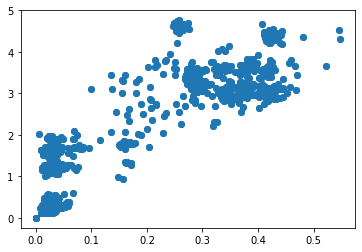

In [84]:
plt.scatter(tfd_matrix, rmsd_matrix)

In [65]:
import py3Dmol
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
def MolTo3DView(mol, conf_id=0, size=(500, 500), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol=mol, includeStereo=True, confId=conf_id)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [66]:
def conf_viewer(idx):
    return MolTo3DView(rdkit_decoys, conf_id=idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=49, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

In [100]:
len(data_ensemble)

50

In [31]:
batch = Batch.from_data_list(data_ensemble)

In [38]:
loader = DataLoader(data_ensemble, batch_size=25)

In [39]:
for batch in loader :
    batch = batch.to('cuda')
    preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)
    print(mseloss(preds, batch.y.log().unsqueeze(1)).item())

20.502635955810547
9.539355278015137


In [45]:
preds.exp()

tensor([[1.2233],
        [2.1853],
        [1.5782],
        [1.2550],
        [1.2859],
        [1.1182],
        [1.0128],
        [1.1551],
        [1.1492],
        [1.2264],
        [5.7003],
        [3.0670],
        [6.3158],
        [4.0109],
        [3.5877],
        [4.6742],
        [3.8382],
        [5.1120],
        [4.0644],
        [2.8222],
        [4.2753],
        [2.7628],
        [5.8492],
        [4.0123],
        [6.4197]], device='cuda:0', grad_fn=<ExpBackward>)

In [46]:
batch.y

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 4.2425, 3.2086, 4.0902, 2.7070, 2.7178, 2.4065, 3.6938, 4.5432,
        3.4962, 3.8905, 3.8948, 4.0457, 3.4856, 3.0563, 3.2820],
       device='cuda:0')

In [34]:
preds = schnet2(batch.x[:,56].long(), batch.pos, batch.batch)

RuntimeError: Input, output and indices must be on the current device

In [15]:
for conf in conf_ensemble_library.get_conf_ensemble(most_common_smiles).mol.GetConformers() :
    rdkit_decoys.AddConformer(conf, assignId=True)

In [16]:
data_list = dataset.featurize_mol(rdkit_decoys)
#y = torch.tensor([int('PDB_ID' in conf.GetPropsAsDict()) for conf in rdkit_decoys.GetConformers()], requires_grad=False)

#batch = Batch.from_data_list(data_list)
#batch.y = y.float()

In [17]:
#batch = batch.to('cuda')

In [50]:
from rdkit.Chem.rdMolAlign import GetBestRMS
import numpy as np

In [89]:
# to optimize
rmsd_to_bioactive = []
confs = rdkit_decoys.GetConformers()
rdkit_confs_id = []
bioactive_confs_id = []
for conf in confs :
    if 'PDB_ID' in conf.GetPropsAsDict() :
        bioactive_confs_id.append(conf.GetId())
    else :
        rdkit_confs_id.append(conf.GetId())
for conf_id in range(rdkit_decoys.GetNumConformers()) :
    rmsds = []
    if conf_id in rdkit_confs_id :
        for bioactive_conf_id in bioactive_confs_id :
            rmsds.append(GetBestRMS(rdkit_decoys, rdkit_decoys, conf_id, bioactive_conf_id, maxMatches=1000))
        rmsd_to_bioactive.append(min(rmsds))
    else :
        rmsd_to_bioactive.append(0)

In [90]:
y = torch.tensor(rmsd_to_bioactive, requires_grad=False)

In [93]:
for i, data in enumerate(data_list) :
    data.y = y[i]

In [95]:
loader = DataLoader(data_list, batch_size=16, shuffle=True)

In [96]:
for batch in loader :
    
    batch = batch.to('cuda')
    optimizer.zero_grad()

    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

In [16]:
batch.y.log().unsqueeze(1)

tensor([[ 0.9736],
        [ 0.4974],
        [-1.4957],
        [-1.0160],
        [-2.9565],
        [-0.8946],
        [ 1.3059],
        [ 0.1680],
        [ 0.9619],
        [-0.6091],
        [ 0.0148],
        [-1.9418],
        [ 0.7503],
        [ 0.4143],
        [ 0.4440],
        [-0.0153]], device='cuda:0')

In [29]:
schnet = SchNet().to('cuda')
mseloss = torch.nn.MSELoss()
optimizer = optim.Adam(schnet.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
for batch in train_loader :

    optimizer.zero_grad()

    batch = batch.to('cuda')

    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)

    loss = mseloss(preds, batch.y.log().unsqueeze(1))
    loss.backward()

    optimizer.step()

In [30]:
batch.y.log()

tensor([ 1.2071,  0.0471,  0.4974,  1.2825, -1.2034, -1.6983,  0.7586,  0.1490,
         0.1498,    -inf, -1.3439, -1.2998, -0.9966, -1.1205, -1.3509, -2.1767],
       device='cuda:0')

In [25]:
preds

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [10]:
preds

tensor([[ 2.1047],
        [ 2.1348],
        [ 1.5311],
        [ 2.6508],
        [ 0.8530],
        [ 3.4791],
        [ 2.1142],
        [ 0.0857],
        [ 3.0586],
        [ 5.3945],
        [ 0.4973],
        [ 1.6024],
        [ 0.7060],
        [-0.7919],
        [ 0.9858],
        [ 1.5892]], device='cuda:0', grad_fn=<ScatterAddBackward>)

In [11]:
batch.y

tensor([1.9710, 2.4865, 0.3691, 2.3161, 1.0153, 3.5619, 1.5852, 1.1187, 1.9109,
        2.0701, 0.3614, 0.3325, 0.2241, 0.0502, 0.2848, 2.0894],
       device='cuda:0')

In [39]:
# Training model on energy for ethane conformations (based on a single torsion)

ethane = Chem.MolFromSmiles('CC')
ethane = Chem.AddHs(ethane)
EmbedMultipleConfs(ethane, 50)

ethane_data = dataset.featurize_mol(ethane)

mmff_energies = []
mmff_props = MMFFGetMoleculeProperties(ethane)
for i in range(50) :
    mmff_ethane = MMFFGetMoleculeForceField(ethane, mmff_props, confId=i)
    mmff_energies.append(mmff_ethane.CalcEnergy())
y = torch.tensor(mmff_energies, requires_grad=False)

batch = Batch.from_data_list(ethane_data)
batch.y = y

schnet = SchNet()
mseloss = torch.nn.MSELoss()
optimizer = optim.SGD(schnet.parameters(), lr=0.0001, momentum=0.9)

for epoch in tqdm(range(1000)):  # loop over the dataset multiple times

    optimizer.zero_grad()
    
    preds = schnet(batch.x[:,56].long(), batch.pos, batch.batch)
    
    loss = mseloss(preds, batch.y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 :
        print(f'Loss at epoch {epoch} : {loss}')

print('Finished Training')

  0%|          | 4/1000 [00:00<00:31, 31.29it/s]

Loss at epoch 0 : 0.9281471371650696


 10%|█         | 104/1000 [00:03<00:26, 33.23it/s]

Loss at epoch 100 : 0.1309066116809845


 20%|██        | 204/1000 [00:06<00:23, 33.49it/s]

Loss at epoch 200 : 0.11741373687982559


 30%|███       | 304/1000 [00:09<00:21, 32.05it/s]

Loss at epoch 300 : 0.10905681550502777


 40%|████      | 404/1000 [00:12<00:17, 33.59it/s]

Loss at epoch 400 : 0.10324281454086304


 50%|█████     | 504/1000 [00:15<00:15, 32.51it/s]

Loss at epoch 500 : 0.09887970983982086


 60%|██████    | 604/1000 [00:18<00:12, 31.96it/s]

Loss at epoch 600 : 0.09545755386352539


 71%|███████   | 706/1000 [00:21<00:10, 28.94it/s]

Loss at epoch 700 : 0.09270357340574265


 80%|████████  | 805/1000 [00:24<00:05, 33.27it/s]

Loss at epoch 800 : 0.09044767171144485


 90%|█████████ | 904/1000 [00:28<00:03, 29.33it/s]

Loss at epoch 900 : 0.08857133984565735


100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]

Finished Training


In [40]:
preds

tensor([[-2.3831],
        [-1.9917],
        [ 0.3335],
        [ 0.2064],
        [-1.1179],
        [-2.0901],
        [ 0.3346],
        [-1.9903],
        [-1.2269],
        [ 0.3837],
        [ 0.4912],
        [ 0.1590],
        [-0.0482],
        [-1.4688],
        [-2.3531],
        [ 0.3832],
        [-2.3209],
        [-0.3396],
        [-0.5675],
        [-1.6591],
        [-1.9341],
        [-2.0192],
        [-1.5823],
        [-1.9956],
        [-2.0675],
        [-1.5545],
        [-2.0488],
        [-2.2495],
        [-1.9580],
        [-2.1588],
        [-2.1751],
        [-0.3586],
        [-2.1320],
        [ 0.3774],
        [-1.3506],
        [ 0.4022],
        [-2.1126],
        [-1.4260],
        [-0.0340],
        [-0.2537],
        [-1.6046],
        [-1.0991],
        [-0.3191],
        [-0.7812],
        [-1.8599],
        [-1.3839],
        [-0.2052],
        [-1.8140],
        [-0.4449],
        [-1.8697]], grad_fn=<ScatterAddBackward>)

In [37]:
batch.y

tensor([-2.2988, -1.7409,  0.6701,  0.2891, -1.0283, -2.0713,  0.3660, -1.4809,
        -1.1378,  0.5946, -0.1097, -0.4245,  0.3206, -1.6801, -2.5620,  0.4036,
        -2.6961, -0.3537, -0.8001, -1.4473, -1.5599, -1.9381, -1.7167, -1.6778,
        -1.9246, -1.2828, -1.8108, -2.5876, -1.8726, -2.2210, -2.6131, -0.4736,
        -2.6236,  0.1864, -1.5772,  1.3729, -2.0485, -1.6483,  0.1577, -0.5730,
        -1.6974, -0.9654, -0.4518, -0.9505, -2.0824, -0.9357, -0.2079, -1.8515,
        -0.7863, -1.7279])

In [13]:
egnn = EGNN(in_node_nf=80, in_edge_nf=8, hidden_nf=50)

In [41]:
mseloss = torch.nn.MSELoss()
optimizer = optim.SGD(egnn.parameters(), lr=0.001, momentum=0.9)

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    optimizer.zero_grad()
    
    preds = egnn(batch=batch)
    
    loss = mseloss(preds, batch.y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    print(loss)

print('Finished Training')

NameError: name 'egnn' is not defined

In [18]:
import py3Dmol
def MolTo3DView(mol, conf_id=0, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol=mol, includeStereo=True, confId=conf_id)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

MolTo3DView(ethane, 2)

In [23]:
MolTo3DView(ethane, 2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
for data in ethane_data :
    print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.1381], grad_fn=<SqueezeBackward1>)
tensor([-0.1381], grad_fn=<SqueezeBackward1>)
tensor([-0.1382], grad_fn=<SqueezeBackward1>)


In [15]:
for data in data_ensemble :
    print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2601], grad_fn=<SqueezeBackward1>)
tensor([-0.2600], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2602], grad_fn=<SqueezeBackward1>)
tensor([-0.2599], grad_fn=<Squeeze

In [33]:
data = dataset.get(0)
print(egnn(h0=data.x, x=data.pos, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x)))

tensor([-0.1403], grad_fn=<SqueezeBackward1>)


In [11]:
import math
rot_mat = torch.tensor([[math.cos(math.radians(90)), -math.sin(math.radians(90)), 0], 
                        [math.sin(math.radians(90)), math.cos(math.radians(90)), 0], 
                        [0, 0, 1]], dtype=torch.float32)

In [12]:
egnn(h0=data.x, x=data.pos @ rot_mat, edges=data.edge_index, edge_attr=data.edge_attr, node_mask=torch.ones(data.x.shape[0]), edge_mask=None, n_nodes=len(data.x))

tensor([-0.1403], grad_fn=<SqueezeBackward1>)

In [27]:
data.pos @ rot_mat

tensor([[ 10.7980, -15.0880,  23.5470],
        [  9.9870, -15.0100,  24.7920],
        [  8.9240, -16.1150,  24.8300],
        [  8.5150, -16.5200,  25.9400],
        [  9.3270, -13.6350,  24.9080],
        [  8.7080, -13.3940,  26.2710],
        [  8.0460, -12.0450,  26.4020],
        [  7.9360, -11.2930,  25.4350],
        [  8.5240, -16.5780,  23.7440],
        [  7.6420, -11.7260,  27.6280],
        [  6.9670, -10.4720,  27.9340],
        [  5.4840, -10.7260,  28.2060],
        [  4.5240, -11.2910,  26.8100],
        [  3.8040,  -9.7290,  26.2620],
        [  3.1710,  -8.9300,  27.3700],
        [  3.6140,  -7.6400,  27.6500],
        [  2.1350,  -9.4640,  28.1330],
        [  3.0370,  -6.8930,  28.6730],
        [  1.5500,  -8.7230,  29.1610],
        [  2.0010,  -7.4370,  29.4300],
        [  7.5500,  -9.8340,  29.1800],
        [  8.0230, -10.5220,  30.0840],
        [  7.4680,  -8.5120,  29.2290],
        [  7.9330,  -7.7400,  30.3660],
        [  7.0620,  -6.5550,  30.6330],


In [3]:
from rdkit.Chem.rdchem import Atom
dataset.encoders[Atom.GetAtomicNum].classes

AttributeError: 'ConfEnsembleDataset' object has no attribute 'encoders'

In [12]:
conf_ensemble_library.get_num_molecules()

13037

In [4]:
concern_smiles = '[H]/C1=C(\\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [5]:
concern_smiles

'[H]/C1=C(\\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [2]:
su3_mols = [Chem.rdmolfiles.MolFromMol2File(f'{pdb_id}_ligand.mol2', removeHs=False) for pdb_id in ['3su0', '3su1', '3su2']]

In [3]:
su3_mols

In [4]:
ce = ConformationEnsemble(mol_list=su3_mols)

((1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 92, 94),)
[[-15.491  -14.115   18.824 ]
 [-12.501   -6.169   17.05  ]
 [-18.143   -9.449   14.732 ]
 [-19.114  -10.977   16.197 ]
 [ -8.842   -6.087   13.628 ]
 [-12.134   -6.639   15.634 ]
 [-12.406   -8.026   15.359 ]
 [-17.827  -11.665   14.398 ]
 [-13.42    -5.826   15.884 ]
 [-10.116   -6.757   14.285 ]
 [-15.541   -8.363   15.235 ]
 [-10.914   -5.993   15.055 ]
 [-13.415  -14.441   15.017 ]
 [ -7.922   -5.576   14.602 ]
 [-13.501   -4.375   15.494 ]
 [-14.897   -9.847   13.695 ]
 [-12.517  -14.039   12.973 ]
 [-18.188  -13.077   17.008 ]
 [ -9.26    -5.075   12.682 ]
 [-20.264  -12.04    17.946 ]
 [-13.129   -7.662   13.27

In [5]:
ce.get_num_conformations()

3

In [6]:
ce.mol.GetConformer(0).GetPositions()

array([[-15.459 , -15.073 ,  18.366 ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [7]:
ce.mol.GetConformer(1).GetPositions()

array([[-15.491 , -14.115 ,  18.824 ],
       [-12.501 ,  -6.169 ,  17.05  ],
       [-18.143 ,  -9.449 ,  14.732 ],
       [-19.114 , -10.977 ,  16.197 ],
       [ -8.842 ,  -6.087 ,  13.628 ],
       [-12.134 ,  -6.639 ,  15.634 ],
       [-12.406 ,  -8.026 ,  15.359 ],
       [-17.827 , -11.665 ,  14.398 ],
       [-13.42  ,  -5.826 ,  15.884 ],
       [-10.116 ,  -6.757 ,  14.285 ],
       [-15.541 ,  -8.363 ,  15.235 ],
       [-10.914 ,  -5.993 ,  15.055 ],
       [-13.415 , -14.441 ,  15.017 ],
       [ -7.922 ,  -5.576 ,  14.602 ],
       [-13.501 ,  -4.375 ,  15.494 ],
       [-14.897 ,  -9.847 ,  13.695 ],
       [-12.517 , -14.039 ,  12.973 ],
       [-18.188 , -13.077 ,  17.008 ],
       [ -9.26  ,  -5.075 ,  12.682 ],
       [-20.264 , -12.04  ,  17.946 ],
       [-13.129 ,  -7.662 ,  13.274 ],
       [-20.293 , -12.989 ,  15.636 ],
       [-14.08  , -12.578 ,  13.82  ],
       [-19.448 , -12.273 ,  16.685 ],
       [-10.659 ,  -4.826 ,  15.286 ],
       [-14.46  ,  -3.906

In [8]:
ce.mol.GetConformer(2).GetPositions()

array([[-15.024 , -15.031 ,  18.13  ],
       [-12.55  ,  -6.133 ,  17.114 ],
       [-18.188 ,  -9.259 ,  14.625 ],
       [-19.459 , -10.701 ,  15.915 ],
       [ -8.906 ,  -6.018 ,  13.698 ],
       [-12.172 ,  -6.575 ,  15.702 ],
       [-12.447 ,  -7.954 ,  15.384 ],
       [-18.059 , -11.496 ,  14.233 ],
       [-13.46  ,  -5.763 ,  15.959 ],
       [-10.168 ,  -6.684 ,  14.374 ],
       [-15.566 ,  -8.33  ,  15.253 ],
       [-10.951 ,  -5.924 ,  15.134 ],
       [-13.128 , -14.444 ,  14.297 ],
       [ -7.975 ,  -5.538 ,  14.678 ],
       [-13.529 ,  -4.312 ,  15.576 ],
       [-14.911 ,  -9.728 ,  13.655 ],
       [-12.353 , -13.719 ,  12.332 ],
       [-18.933 , -12.926 ,  16.72  ],
       [ -9.334 ,  -4.984 ,  12.775 ],
       [-20.965 , -11.653 ,  17.468 ],
       [-13.177 ,  -7.478 ,  13.305 ],
       [-20.811 , -12.524 ,  15.121 ],
       [-13.971 , -12.493 ,  13.461 ],
       [-20.029 , -11.955 ,  16.301 ],
       [-10.715 ,  -4.761 ,  15.362 ],
       [-14.458 ,  -3.824

In [46]:
def standardize_mol(mol) :
        
    """
    Depending on the input format, 2 mols might not have the same order of 
    atoms and bonds. This function is recreating the molecule using its smiles
    then associating the right coordinates for the conformations
    Args :
        mol: Mol = RDKit molecule to standardize
    Returns :
        new_mol: Mol = Standardized RDKit molecule with canonical atom/bond ordering
    """

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    new_mol = Chem.AddHs(new_mol, addCoords=True) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
    for conf in mol.GetConformers() :
        new_mol.AddConformer(conf, assignId=True)
        new_positions = conf.GetPositions()[atom_map]
        last_conf = new_mol.GetConformers()[-1]
        for i in range(len(new_positions)) :
            last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [42]:
def standardize_mol(mol) :
        
    """
    Depending on the input format, 2 mols might not have the same order of 
    atoms and bonds. This function is recreating the molecule using its smiles
    then associating the right coordinates for the conformations
    Args :
        mol: Mol = RDKit molecule to standardize
    Returns :
        new_mol: Mol = Standardized RDKit molecule with canonical atom/bond ordering
    """

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx
    for a in new_mol.GetAtoms() :
        a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())
    new_mol = Chem.AddHs(new_mol) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
#     for conf in mol.GetConformers() :
#         new_mol.AddConformer(conf, assignId=True)
#         new_positions = conf.GetPositions()[atom_map]
#         last_conf = new_mol.GetConformers()[-1]
#         for i in range(len(new_positions)) :
#             last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [15]:
def standardize_mol(mol) :

    new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol)) # Ensure we have a canonical atom/bond ordering
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx
    for a in new_mol.GetAtoms() :
        a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())
    new_mol = Chem.AddHs(new_mol) # Because MolFromSmiles is not embedding Hs by default
    atom_map = mol.GetSubstructMatches(new_mol) # atom_map[new_mol_atom_idx] = mol_atom_idx

    # loop to correct atom ordering of positions
#     for conf in mol.GetConformers() :
#         new_mol.AddConformer(conf, assignId=True)
#         new_positions = conf.GetPositions()[atom_map]
#         last_conf = new_mol.GetConformers()[-1]
#         for i in range(len(new_positions)) :
#             last_conf.SetAtomPosition(i, new_positions[i])

    return new_mol, atom_map

In [28]:
rank_standard = list(Chem.rdmolfiles.CanonicalRankAtoms(standardized_mol))

In [29]:
rank_original = list(Chem.rdmolfiles.CanonicalRankAtoms(mol))

In [30]:
for si, oi in zip(rank_standard, rank_original) :
    print(standardized_mol.GetAtomWithIdx(si).GetSymbol() + mol.GetAtomWithIdx(oi).GetSymbol())

CH
CH
CH
CH
CH
OH
NH
CC
CH
SH
OC
CH
NH
CC
CH
CH
CC
CH
CC
CH
CC
CH
CH
CH
CC
CH
CH
CH
CH
CH
OH
CH
OH
CH
NH
CH
CH
CH
CH
OH
FH
OH
OH
CH
CH
NH
CH
OH
NH
CH
OH


In [31]:
atom_map

((25,
  14,
  8,
  0,
  5,
  11,
  24,
  9,
  4,
  13,
  18,
  38,
  44,
  47,
  6,
  26,
  20,
  30,
  15,
  48,
  10,
  43,
  2,
  35,
  7,
  3,
  23,
  17,
  19,
  21,
  40,
  37,
  34,
  33,
  28,
  49,
  45,
  22,
  50,
  16,
  12,
  27,
  39,
  31,
  29,
  32,
  36,
  1,
  41,
  46,
  42),)

In [36]:
atom_map[0][a.GetIdx()]

25

In [38]:
for a in standardized_mol.GetAtoms() :
    a.SetChiralTag(mol.GetAtomWithIdx(atom_map[0][a.GetIdx()]).GetChiralTag())

In [7]:
for mol in mols[6961:6964] :
    print(mol.GetProp('PDB_ID'))

NameError: name 'mols' is not defined

In [8]:
for a in su3_mols[0].GetAtoms() :
    print(a.GetSymbol())

F
C
N
O
S
C
N
O
C
N
O
C
N
O
C
N
O
C
O
C
O
C
O
C
O
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H


In [9]:
l1 = list(Chem.rdmolfiles.CanonicalRankAtoms(mol1))
l2 = list(Chem.rdmolfiles.CanonicalRankAtoms(mol2))

NameError: name 'mol1' is not defined

In [73]:
l1 == l2

False

In [10]:
mol1, mol2, mol3 = su3_mols
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol1)))
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol2)))
print(list(Chem.rdmolfiles.CanonicalRankAtoms(mol3)))
for i in range(mol1.GetNumAtoms()) :
    print(mol1.GetAtomWithIdx(i).GetSymbol(), mol2.GetAtomWithIdx(i).GetSymbol(), mol3.GetAtomWithIdx(i).GetSymbol())
    

[51, 87, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 5, 19, 20, 2, 41, 4, 3, 21, 22, 23, 24, 25, 26, 39, 31, 32, 35, 36, 40, 27, 28, 43, 6, 29, 30, 33, 34]
[87, 51, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 5, 19, 20, 2, 41, 4, 3, 21, 22, 23, 24, 25, 26, 39, 31, 32, 35, 36, 40, 27, 28, 43, 6, 29, 33, 30, 34]
[87, 51, 69, 52, 94, 93, 71, 44, 91, 72, 46, 58, 73, 49, 60, 70, 45, 74, 50, 75, 47, 76, 53, 83, 48, 59, 57, 65, 77, 61, 90, 63, 62, 78, 79, 54, 64, 80, 88, 67, 84, 68, 86, 89, 81, 92, 66, 82, 56, 85, 55, 37, 38, 7, 8, 42, 9, 1, 10, 11, 12, 13, 14, 15, 16, 1

In [32]:
for mol in su3_mols[:1] :
    original_smiles = Chem.MolToSmiles(mol=mol) #, allBondsExplicit=True, allHsExplicit=True
    standardized_mol, atom_map = standardize_mol(mol)
    standard_smiles = Chem.MolToSmiles(mol=standardized_mol)
    print(original_smiles == standard_smiles)

False


In [33]:
mol.GetConformer().GetPositions()

array([[-15.459 , -15.073 ,  18.366 ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [34]:
import copy
mol2 = copy.deepcopy(mol)

In [35]:
new_conf = mol2.GetConformer()

In [36]:
new_conf.SetAtomPosition(0, [0, 0, 0])

In [38]:
mol2.GetConformer().GetPositions()

array([[  0.    ,   0.    ,   0.    ],
       [-12.503 ,  -6.301 ,  17.193 ],
       [-18.184 ,  -9.428 ,  14.724 ],
       [-19.25  , -10.889 ,  16.184 ],
       [ -8.846 ,  -6.3   ,  13.803 ],
       [-12.145 ,  -6.789 ,  15.794 ],
       [-12.421 ,  -8.178 ,  15.514 ],
       [-17.917 , -11.656 ,  14.449 ],
       [-13.42  ,  -5.958 ,  16.021 ],
       [-10.141 ,  -6.947 ,  14.467 ],
       [-15.567 ,  -8.472 ,  15.333 ],
       [-10.928 ,  -6.147 ,  15.194 ],
       [-13.25  , -14.597 ,  14.747 ],
       [ -7.907 ,  -5.79  ,  14.8   ],
       [-13.481 ,  -4.499 ,  15.636 ],
       [-14.921 ,  -9.933 ,  13.779 ],
       [-12.342 , -13.95  ,  12.839 ],
       [-18.498 , -13.039 ,  16.999 ],
       [ -9.246 ,  -5.28  ,  12.823 ],
       [-20.585 , -11.942 ,  17.837 ],
       [-13.136 ,  -7.758 ,  13.42  ],
       [-20.491 , -12.834 ,  15.494 ],
       [-14.071 , -12.711 ,  13.744 ],
       [-19.696 , -12.174 ,  16.622 ],
       [-10.666 ,  -4.966 ,  15.403 ],
       [-14.428 ,  -4.026

In [24]:
conf = mol.GetConformer()

In [22]:
su3_mols[0].GetSubstructMatches(su3_mols[1])

((1,
  0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  93,
  92,
  94),)

In [11]:
for mol in mols[6961:6964] :
    original_smiles = Chem.MolToSmiles(mol=mol) #, allBondsExplicit=True, allHsExplicit=True
    standardized_mol, atom_map = standardize_mol(mol)
    standard_smiles = Chem.MolToSmiles(mol=standardized_mol)
    print(original_smiles == standard_smiles)

NameError: name 'mols' is not defined

In [44]:
original_mol_chirality = [a.GetChiralTag() for a in mol.GetAtoms()]
s_mol_chirality = [a.GetChiralTag() for a in standardized_mol.GetAtoms()]

In [45]:
p_chirality = [original_mol_chirality[i] for i in atom_map[0]]

In [46]:
for i in range(len(s_mol_chirality)) :
    if s_mol_chirality[i] != p_chirality[i] :
        print(i)
        print(s_mol_chirality[i])
        print(p_chirality[i])

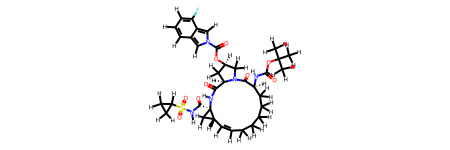

In [47]:
standardized_mol

In [43]:
for mol in mols[6961:6964] :
    original_smiles = Chem.MolToSmiles(mol)
    standardized_mol = Chem.MolFromSmiles(original_smiles)
    standardized_mol = Chem.AddHs(standardized_mol, addCoords=True)
    standard_smiles = Chem.MolToSmiles(standardized_mol)
    print(original_smiles == standard_smiles)

False
False
False


In [36]:
original_smiles

'[H]/[C]1=[C](\\[H])-[C@]2(-[H])-[C](-[H])(-[H])-[C@@]-2(-[C](=[O])-[N](-[H])-[S](=[O])(=[O])-[C]2(-[H])-[C](-[H])(-[H])-[C]-2(-[H])-[H])-[N](-[H])-[C](=[O])-[C@@]2(-[H])-[N](-[C](=[O])-[C@@](-[H])(-[N](-[H])-[C](=[O])-[O]-[C](-[C](-[H])(-[H])-[H])(-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C]-1(-[H])-[H])-[C](-[H])(-[H])-[C@](-[H])(-[O]-[C](=[O])-[n]1:[c](-[H]):[c]3:[c](-[H]):[c](-[H]):[c](-[H]):[c](-[F]):[c]:3:[c]:1-[H])-[C]-2(-[H])-[H]'

In [37]:
standard_smiles

'[H]/[C]1=[C](/[H])-[C@]2(-[H])-[C](-[H])(-[H])-[C@@]-2(-[C](=[O])-[N](-[H])-[S](=[O])(=[O])-[C]2(-[H])-[C](-[H])(-[H])-[C]-2(-[H])-[H])-[N](-[H])-[C](=[O])-[C@@]2(-[H])-[N](-[C](=[O])-[C@@](-[H])(-[N](-[H])-[C](=[O])-[O]-[C](-[C](-[H])(-[H])-[H])(-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(-[H])-[C]-1(-[H])-[H])-[C](-[H])(-[H])-[C@](-[H])(-[O]-[C](=[O])-[n]1:[c](-[H]):[c]3:[c](-[H]):[c](-[H]):[c](-[H]):[c](-[F]):[c]:3:[c]:1-[H])-[C]-2(-[H])-[H]'

In [21]:
for i, mol in enumerate(mols) :
    if Chem.MolToSmiles(mol) == concern_smiles :
        print(i)

6961
6962
6963


In [ ]:
'[H]/C1=C(\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'
'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [ ]:
'[H]/C1=C(\[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [21]:
Chem.MolToSmiles(ConformationEnsemble(mols[6962]).mol)

'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [17]:
Chem.MolToSmiles(ConformationEnsemble(mols[6961]).mol)

'[H]/C1=C(/[H])[C@]2([H])C([H])([H])[C@@]2(C(=O)N([H])S(=O)(=O)C2([H])C([H])([H])C2([H])[H])N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C1([H])[H])C([H])([H])[C@]([H])(OC(=O)n1c([H])c3c([H])c([H])c([H])c(F)c3c1[H])C2([H])[H]'

In [3]:
smiles = 'CC(=O)NC1=CC=C(C=C1)O'
mols = [Chem.MolFromSmiles(smiles) for _ in range(2)]

In [7]:
EmbedMolecule(mols[0])

0

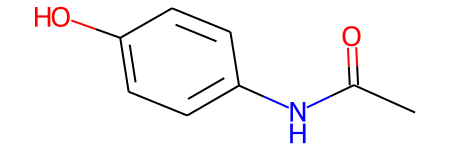

In [8]:
mols[0]

In [11]:
Chem.MolToSmiles(Chem.AddHs(mols[0], addCoords=True))

'[H]Oc1c([H])c([H])c(N([H])C(=O)C([H])([H])[H])c([H])c1[H]'